<a href="https://www.kaggle.com/code/sofiamatias/icecube-train-lgbm?scriptVersionId=124418306" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Concepts and ideas

This notebook attempts at solving the neutrino direction calculation

## How zenith and azimuth gives a direction
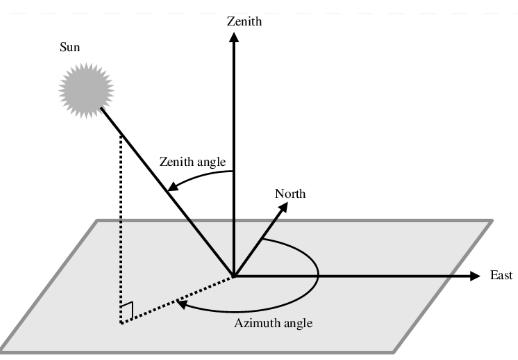

# Merge Data

In [1]:
def get_train_df_from_a_batch (train_batch_df, sensors_df, train_meta_df, batch_number):
    """
    Converts train_batch, train_meta and sensor_geometry into a 'train_df' dataframe containing features and targets
    It filters 'auxiliary' field to only 'False' values (reduces db in 27%), due to challenge explanation:
    ' If True, the pulse was not fully digitized, is of lower quality, and was more likely to originate from noise.'
    It uses polars dataframes only.
    """
    train_batch_df = train_batch_df.filter(pl.col("auxiliary") == False)
    sensors_df = sensors_df.with_columns(pl.col('sensor_id').cast(pl.Int16, strict=False))
    train_df = train_batch_df.join (sensors_df, how='left', on = 'sensor_id')
    train_meta_batch_df = train_meta_df.filter(pl.col("batch_id") == batch_number)
    train_df = train_df.join (train_meta_batch_df, how='left', on = 'event_id')
    train_df = train_df.drop (columns=['batch_id', 'auxiliary']) #train_df is filtered for 1 batch_id and auxiliary = False, these columns are useless
    train_df = train_df.drop (columns=['sensor_id', 'first_pulse_index', 'last_pulse_index']) #deleted columns - low correlation with targets
    train_df = train_df.with_columns(xy = pl.col('x') * pl.col('y'))  #polynomial features
    del train_meta_batch_df #memory
    del train_batch_df #memory
    print (f'Train dataframe:\n')
    print (train_df)
    return train_df

# 3D Plotting

In [2]:
def plot_3D (trn_df, event_num):
    """
    Plots x, y, and z from sensors vs azimuth and zenith calculated, per 1 event
    """
    
    # Get x, y, z, azimuth and zenith values from sensors
    train_df = trn_df.filter(pl.col("event_id") == event_num)
    xs = train_df.collect()[m:M, 'x']
    ys = train_df.collect()[m:M, 'y']
    zs = train_df.collect()[m:M, 'z']
    azim = train_df.collect()[m:M, 'azimuth']
    zen = train_df.collect()[m:M, 'zenith']

    # Calculate the Cartesian coordinates of the vector
    xp = np.sin(zen) * np.cos(azim)
    yp = np.sin(zen) * np.sin(azim)
    zp = np.cos(zen)

    # Set figure
    fig = plt.figure(figsize = (12,20))
    ax = fig.add_subplot(111, projection='3d')

    # Set the limits of the plot
    ax.set_xlim([-60, 10])
    ax.set_ylim([-250, 0])
    ax.set_zlim([-250, 200])

    # Plot the vector as a line from (0,0,0) to (x,y,z)
    ax.scatter(xp, yp, zp, color='g')
    ax.scatter(xs,ys,zs, color='b')

    # Add labels for the x, y, and z axes
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Show the plot
    plt.show()

# EDA

In [3]:
def EDA_report (data):
    """
    Generates an EDA report using sweetviz package. Use "data" as your dataset
    """
    import datetime
    import sweetviz as sw
    from IPython.display import FileLink, display

    now = datetime.datetime.now()
    report_filename = f'EDA_report{now}.html'

    analyze_report = sw.analyze(data)
    analyze_report.show_html(report_filename, open_browser = True)
    
    link = FileLink (report_filename)
    print ('\nClick here to open report:')
    display(link)

    return None

## Correlations

In [4]:
# Utility functions from Tutorial
def make_mi_scores(X, y):
    
    from sklearn.feature_selection import mutual_info_regression
    
    for colname in ["object", "category"]:
        if colname in X.dtypes:
            X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


# Score Function

In [5]:
def angular_dist_score(az_true, zen_true, az_pred, zen_pred, batch_size=1000):
    '''
    calculate the MAE of the angular distance between two directions.
    The two vectors are first converted to cartesian unit vectors,
    and then their scalar product is computed, which is equal to
    the cosine of the angle between the two vectors. The inverse 
    cosine (arccos) thereof is then the angle between the two input vectors
    
    Parameters:
    -----------
    
    az_true : float (or array thereof)
        true azimuth value(s) in radian
    zen_true : float (or array thereof)
        true zenith value(s) in radian
    az_pred : float (or array thereof)
        predicted azimuth value(s) in radian
    zen_pred : float (or array thereof)
        predicted zenith value(s) in radian
    
    Returns:
    --------
    
    dist : float
        mean over the angular distance(s) in radian
    '''
    
    if not (np.all(np.isfinite(az_true)) and
            np.all(np.isfinite(zen_true)) and
            np.all(np.isfinite(az_pred)) and
            np.all(np.isfinite(zen_pred))):
        raise ValueError("All arguments must be finite")
    
    import numexpr as ne

    n = len(az_true)
    angle_sum = 0.0
    for i in range(0, n, batch_size):
        end = min(i + batch_size, n)
        sa1 = np.sin(az_true[i:end]).astype(np.float32)
        ca1 = np.cos(az_true[i:end]).astype(np.float32)
        sz1 = np.sin(zen_true[i:end]).astype(np.float32)
        cz1 = np.cos(zen_true[i:end]).astype(np.float32)
        sa2 = np.sin(az_pred[i:end]).astype(np.float32)
        ca2 = np.cos(az_pred[i:end]).astype(np.float32)
        sz2 = np.sin(zen_pred[i:end]).astype(np.float32)
        cz2 = np.cos(zen_pred[i:end]).astype(np.float32)
        scalar_prod = ne.evaluate('sz1*sz2*(ca1*ca2 + sa1*sa2) + cz1*cz2')
        scalar_prod = np.clip(scalar_prod, -1, 1)
        angle_sum += np.sum(np.arccos(scalar_prod))
    return angle_sum / (n * batch_size) 

# Load train and test datasets functions

In [6]:
def train_and_test_set_for_hyperparameters (train_df):
    """
    From 'train_df' dataset, define train and test datasets for hyperparameters tunig for LGBM model.
    Using a fraction of total dataset (just 0.001 for fast tuning).
    Parameters: 'train_df'
    Output:
    x_sample_train - train set features
    y_sample_train_ze, y_sample_train_az - train target columns: y is split in azimuth (y_train_az) and zenith (y_train_ze) 
    x_sample_val - validation/test set features
    y_sample_val_ze, y_sample_val_az - validation/test target columns; y is split in azimuth (y_train_az) and zenith (y_train_ze)
    """

    # Getting sampled train and test datasets for hyperparameters tuning
    sampled_train = train_df.sample(frac=0.001).to_pandas()
    display(sampled_train)
    y = sampled_train[['azimuth', 'zenith']]
    print ('\nSampled dataset - y: \nShape: ', y.shape, '\n')
    print(y)
    X = sampled_train.drop(columns=['azimuth', 'zenith'])
    print ('\nSampled dataset - X: \nShape: ', X.shape, '\n')
    print(X)
    x_sample_train, x_sample_val, y_train, y_val = train_test_split(X, y, random_state=42)
    print ('\nSampled train dataset - x_train:\nShape: ', x_sample_train.shape, '\n')
    print(x_sample_train)
    print ('\nSampled train dataset - y_train:\nShape: ', y_train.shape, '\n')
    print(y_train)
    x_sample_train = x_sample_train.to_numpy()
    x_sample_val = x_sample_val.to_numpy()
    y_sample_train_az = y_train['azimuth'].to_numpy()
    y_sample_train_ze = y_train['zenith'].to_numpy()
    y_sample_val_az = y_val['azimuth'].to_numpy()
    y_sample_val_ze = y_val['zenith'].to_numpy()
    
    return x_sample_train, y_sample_train_ze, y_sample_train_az, x_sample_val, y_sample_val_ze, y_sample_val_az

In [7]:
def train_and_test_set_for_model (train_df):
    """
    From 'train_df' dataset, define train and test datasets for LGBM model training.
    Using a fraction of total dataset.
    Parameters: 'train_df'
    Output:
    x_train - train set features
    y_train_ze, y_train_az - train target columns: y is split in azimuth (y_train_az) and zenith (y_train_ze) 
    x_val - validation/test set features
    y_val_ze, y_val_az - validation/test target columns; y is split in azimuth (y_train_az) and zenith (y_train_ze)
    """

    # Getting train and test datasets for model fit
    train_data = train_df.sample(frac=0.2)
    y = train_data.select(['azimuth', 'zenith'])
    print ("\nTarget y:\nShape: ", y.shape, "\n")
    print(y)
    X = train_data.drop(['azimuth', 'zenith'])
    print ("\nFeatures X y:\nShape: ", X.shape, "\n")
    print(X)
    x_train, x_val, y_train, y_val = train_test_split(X, y, random_state=42)
    print ("\nFeatures x_train for train set:\nShape: ", x_train.shape, "\n")
    print(x_train)
    print ("\nTarget y_train for train set:\nShape: ", y_train.shape, "\n")
    print(y_train)
    x_train = x_train.to_numpy()
    x_val = x_val.to_numpy()
    y_train_az = y_train.select('azimuth').to_numpy().squeeze()
    y_train_ze = y_train.select('zenith').to_numpy()
    y_val_az = y_val.select('azimuth').to_numpy().squeeze()
    y_val_ze = y_val.select('zenith').to_numpy()
    
    return x_train, y_train_ze, y_train_az, x_val, y_val_ze, y_val_az

# Hyperparameter tuning function

In [8]:
def parameters (x_sample_train, y_sample_train_ze, y_sample_train_az, x_sample_val, y_sample_val_ze, y_sample_val_az):
    """
    Gets hyperparameters for LGBM model using optuna. 
    'x_sample_train' for 'model_az' includes the 'y_sample_train_ze', meaning that azimuth features includes zenith values.
    Model metric used in 'mean_absolute_error'.
    Parameters:
    x_sample_train - train set features
    y_sample_train_ze, y_sample_train_az - train target columns: y is split in azimuth (y_train_az) and zenith (y_train_ze) 
    x_sample_val - validation/test set features (for model az, includes y_val_ze)
    y_sample_val_ze, y_sample_val_az - validation/test target columns; y is split in azimuth (y_train_az) and zenith (y_train_ze)
    Output:
    params_az, params_ze
    """
    
    def objective_lgbm(trial):
        """
        Function that initializes and scores LGBM model. Used for hyperparameter optimization studies.
        """        
        
        param = {
            'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt']),
            'objective': trial.suggest_categorical('objective', ['regression_l1']),
            'metric': trial.suggest_categorical('metric', ['mean_absolute_error']),
            'device': trial.suggest_categorical('device', [device_lgbm]),
            "bagging_freq": trial.suggest_int('bagging_freq', 1,10), 
            "bagging_fraction": trial.suggest_float('bagging_fraction',0.1,1),
            'num_leaves': trial.suggest_int('num_leaves', 5,40),
            'max_depth': trial.suggest_int('max_depth', 5,40),
            'min_split_gain': trial.suggest_float('min_split_gain',0.6,1),
            'colsample_bytree': trial.suggest_float('colsample_bytree',0.1,1),
            'reg_alpha' : trial.suggest_float('reg_alpha',0.1,10),
            'reg_lambda': trial.suggest_float('reg_lambda',0.1,10),
            'n_estimators': trial.suggest_int('n_estimators', 10, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01,0.1),
            'verbosity': trial.suggest_int('verbosity', -1, -1)
            }

        print ("\nLoading model...")
        model = lgb.LGBMRegressor(**param)
        print ("\nFitting model...")
        model.fit (x_sample_train, y_sample_train)
        print ("\nPredicting values...")
        preds = model.predict(x_sample_val)
        pred_labels = np.rint(preds)
        score = round(mean_absolute_error(y_sample_val, pred_labels),4)
        return score
    
    
    # Get best parameters

    print ('\n--- Study for zenith ---\n') 
    y_sample_train = y_sample_train_ze
    y_sample_val = y_sample_val_ze
    study_ze = optuna.create_study(direction = 'minimize', study_name = 'LGBM for zenith')
    study_ze.optimize(objective_lgbm, n_trials = 15)
    trial_ze = study_ze.best_trial

    print ('\n--- Study for azimuth ---\n')
    x_sample_train = np.hstack ([x_sample_train, y_sample_train_ze.reshape (-1, 1)]) #adding y_ze to features
    x_sample_val = np.hstack ([x_sample_val, y_sample_val_ze.reshape (-1, 1)]) #adding y_ze to features
    y_sample_train = y_sample_train_az
    y_sample_val = y_sample_val_az
    study_az = optuna.create_study(direction = 'minimize', study_name = 'LGBM for azimuth')
    study_az.optimize(objective_lgbm, n_trials = 15)
    trial_az = study_az.best_trial

    print("LGBM model score for zenith --> ",trial_ze.value)
    print("LGBM model's best parameters for zenith --> ",trial_ze.params)
    print("LGBM model score for azimuth --> ",trial_az.value)
    print("LGBM model's best parameters for azimuth --> ",trial_az.params)
    return trial_az.params, trial_ze.params

In [9]:
#x_train = x_train.drop ('zenith')
#x_train

# Train and score LGBM model function

In [10]:
def LGBM_inference (x_train, y_train_ze, y_train_az, x_val, y_val_ze, y_val_az, params_az, params_ze):
    """
    Fits models to predict zenith (model_ze) and azimuth (model_az). 'x_train' for 'model_az' includes the 'y_train_ze', 
    meaning that azimuth features includes zenith values. It uses the 'sequence' class to batch all the rows.
    Score is calculated by 'angular_dist_score' function.
    Parameters:
    x_train - train set features
    y_train_ze, y_train_az - train target columns: y is split in azimuth (y_train_az) and zenith (y_train_ze) 
    x_val - validation/test set features (for model az, includes y_val_ze)
    y_val_ze, y_val_az - validation/test target columns; y is split in azimuth (y_train_az) and zenith (y_train_ze)
    Output:
    model_az, model_ze, score
    """  
    
    # Fitting models and getting scores
    print ('Initialize model for zenith...\n')
    model_ze = lgb.LGBMRegressor(**params_ze)
    print ('Fit model...\n')
    #if os.path.exists(model_ze_path):
    #    model_ze.fit (x_train, y_train_ze, init_model = model_ze_path)
    #elif os.path.exists(saved_model_ze_path):
    #    model_ze.fit (x_train, y_train_ze, init_model = saved_model_ze_path)
    #else:
    model_ze.fit (x_train, y_train_ze)
    print ('\nPredict zenith values...\n')
    ze_preds = model_ze.predict (x_val)
    print ('\nZenith values:\n', ze_preds)

    print ('\nInitialize model for azimuth...\n')
    model_az = lgb.LGBMRegressor(**params_az)
    print ('Fit model...\n')
    #if os.path.exists(model_az_path):
    #    model_az.fit (x_train, y_train_az, init_model = model_az_path)
    #elif os.path.exists(saved_model_az_path):
    #    model_az.fit (x_train, y_train_az, init_model = saved_model_az_path)
    #else:
    model_az.fit (x_train, y_train_az)
    print ('\nPredict azimuth values...\n')
    az_preds = model_az.predict (x_val)
    print ('\nAzimuth values:\n', az_preds)
    
    print ('\nCalculating score...\n')
    final_score = angular_dist_score(y_val_az, y_val_ze, az_preds, ze_preds)
    print ('\nScore:', final_score)
    
    return model_az, model_ze, final_score

# Model train

## Imports

In [11]:
%%time
%matplotlib inline
import matplotlib.pyplot as plt
import polars as pl
import numpy as np
import pandas as pd
import os, gc

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import SCORERS, mean_absolute_error
from torch import cuda
import optuna
from tqdm import tqdm

print ('\nFinished loading imports.\n')

if cuda.is_available():
    device_lgbm = 'gpu'
else:
    device_lgbm = 'cpu'
    
print (f"Device for training is {device_lgbm}.\n")

input_path = '/kaggle/input/'
work_path = '/kaggle/working/'
scores_path = f'{work_path}scores_lgbm.csv'
scores_df = pd.DataFrame([])
model_az_path = f'{work_path}model_az.txt'
model_ze_path = f'{work_path}model_ze.txt'
model_path = f'{work_path}model.pt'
saved_scores_path = f'{input_path}scores_lgbm.csv'
saved_model_az_path = f'{input_path}model_az.txt'
saved_model_ze_path = f'{input_path}model_ze.txt'
saved_model_path = f'{input_path}model.pt'

for dirname, _, filenames in os.walk(input_path):
    for filename in filenames:
        filepath = os.path.join(dirname, filename)
        if 'sensor' in filepath:
            sensors_df = pl.read_csv (filepath).lazy()
            print ("'sensor_geometry' file loaded.")
        elif 'score' in filepath:
            scores_df = pd.read_csv (filepath)
        elif 'train_meta' in filepath:
            train_meta_filepath = filepath
            print ("'train_meta' file path found and loaded.")
print ('\nAll paths are set.\n')


Finished loading imports.

Device for training is gpu.

'train_meta' file path found and loaded.
'sensor_geometry' file loaded.

All paths are set.

CPU times: user 2.63 s, sys: 457 ms, total: 3.08 s
Wall time: 5.2 s


## 3D Plotting and EDA

In [12]:
#train_analysis = train_df.collect().sample(frac=0.001)
#EDA_report (train_analysis.to_pandas())

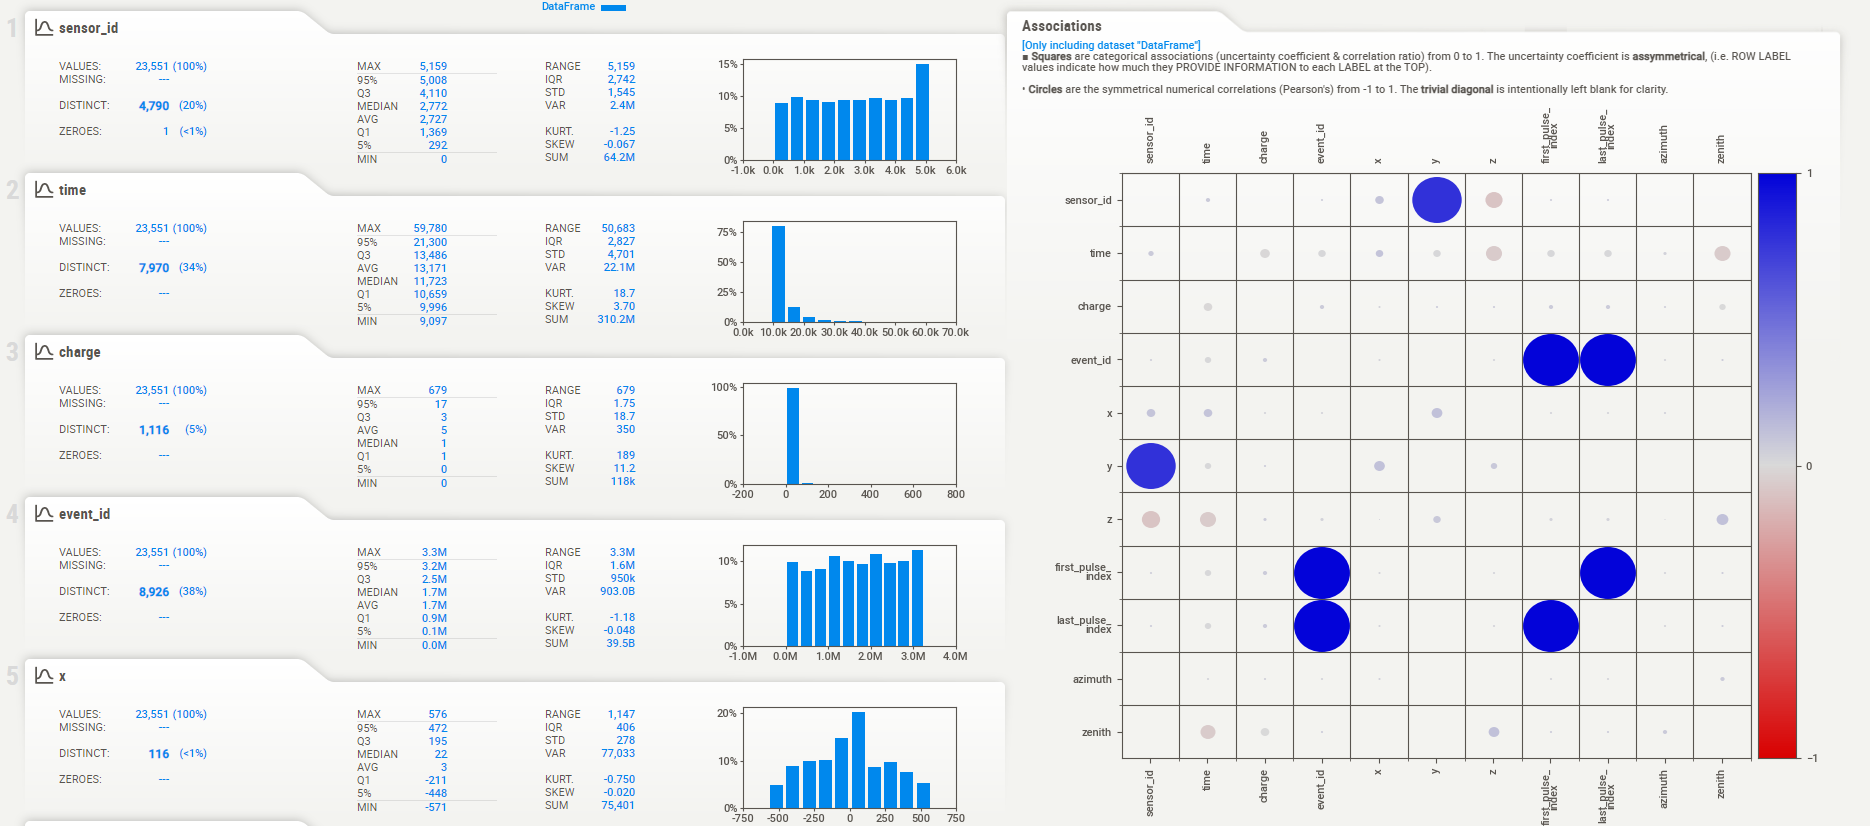
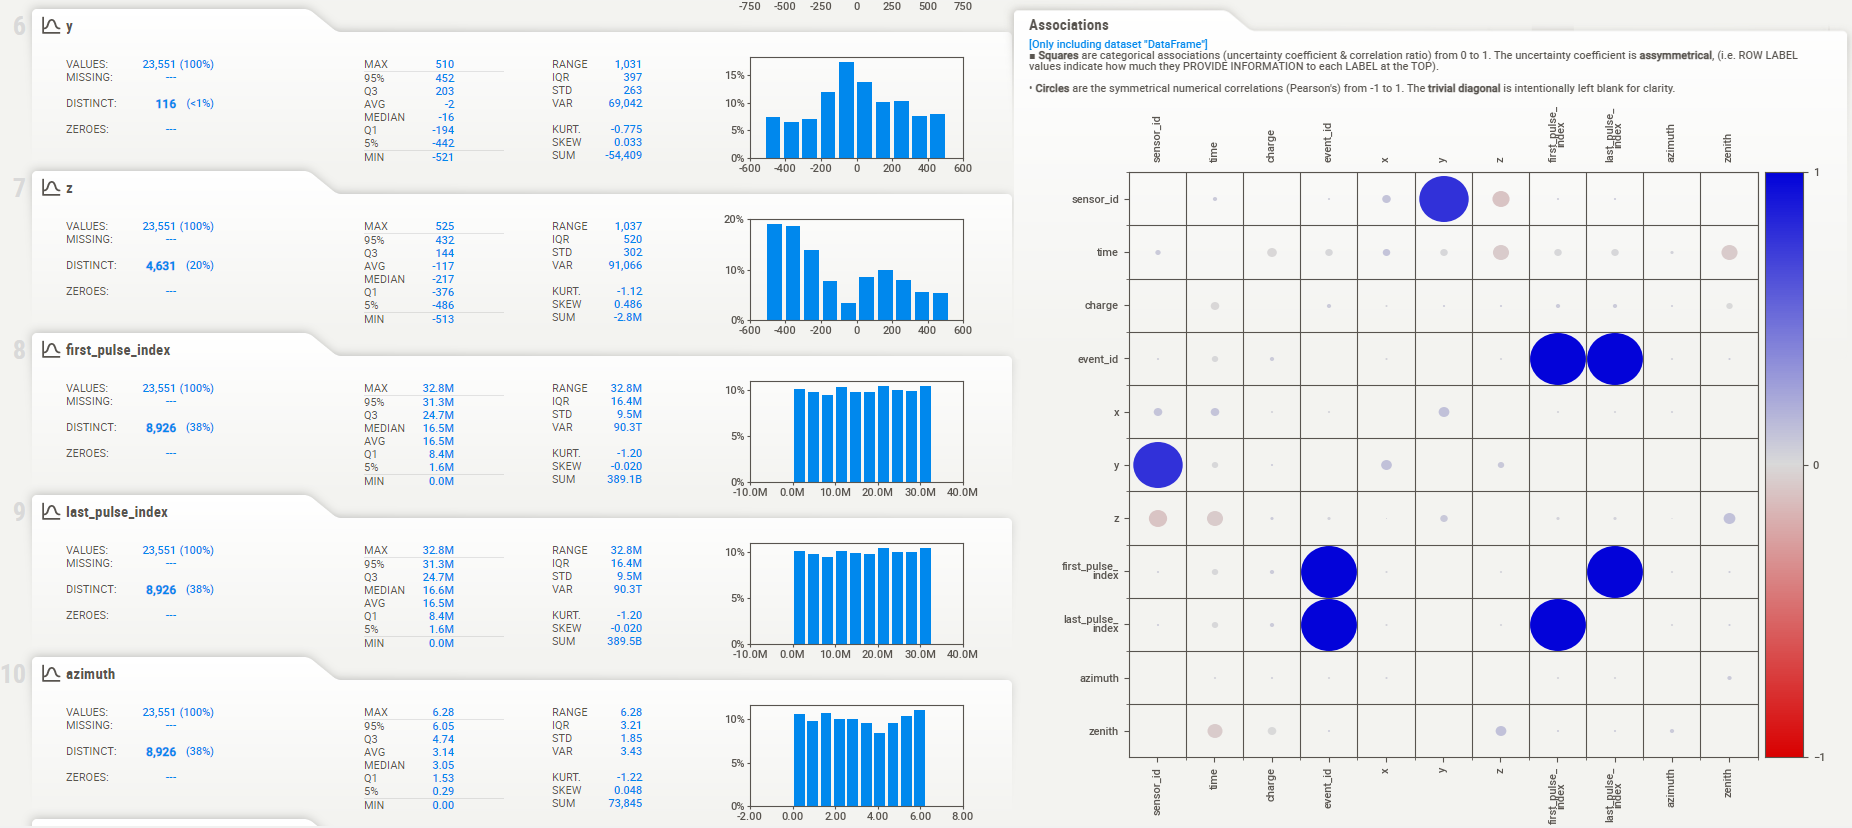

In [13]:
#3D plotting of batch 1
#batch_1_path = '/kaggle/input/icecube-neutrinos-in-deep-ice/train/batch_1.parquet'
#train_meta_df = pl.read_parquet (train_meta_filepath).lazy()
#train_batch_df = pl.read_parquet (batch_1_path).lazy()
#train_df = get_train_df_from_a_batch (train_batch_df.collect(), sensors_df.collect(), train_meta_df.collect(), 1).lazy()
#del train_batch_df #memory
#del train_meta_df #memory
#plot_3d(train_df, 24) #event_id = 24

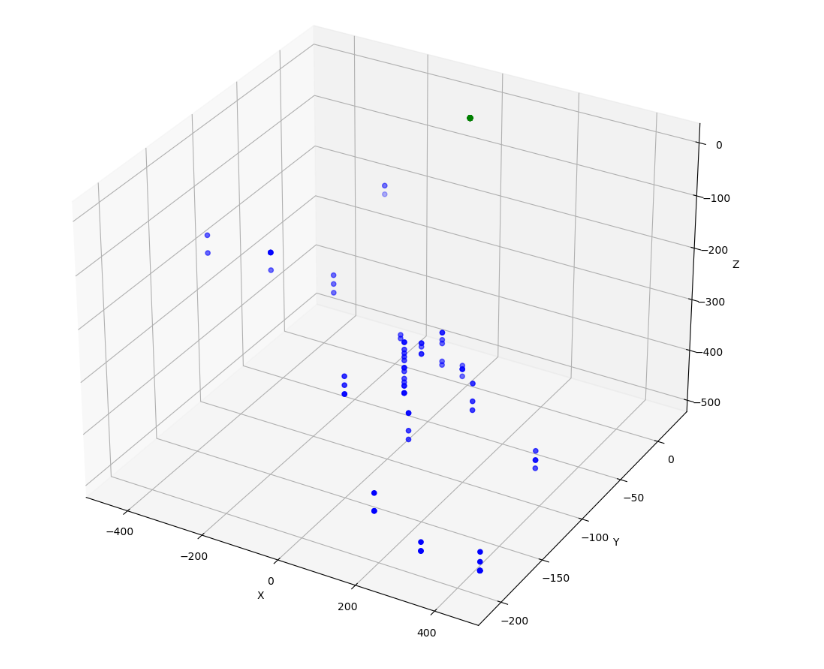

In [14]:
# Calculate mi scores
#train_meta_df = pl.read_parquet (train_meta_filepath).lazy()
#train_batch_df = pl.read_parquet (filepath).lazy()
#train_df = get_train_df_from_a_batch (train_batch_df.collect(), 
#                                                  sensors_df.collect(), 
#                                                  train_meta_df.collect(), 
#                                                  295)
#train_analysis = train_df.sample(frac=0.001).to_pandas()
#X = train_analysis.drop (columns = ['azimuth', 'zenith'])
#y = train_analysis['zenith']
#mi_scores = make_mi_scores(X, y)
#del train_df #memory
#del train_meta_df #memory
#del train_batch_df #memory
#gc.collect()
#print (mi_scores)

MI Scores: azimuth

| feature | score |
| :- | :- |
| event_id | 7.047274 |
| y | 0.448240 |
| x | 0.448145 |
| z | 0.122350 |
| charge | 0.015387 |
| time | 0.000327 |

## Train model

In [15]:
%%time
print ('Starting train...\n')

counts = 1
max = 25
for dirname, _, filenames in os.walk(input_path):
    for filename in filenames:
        filepath = os.path.join(dirname, filename)
        if ('batch' in filepath) and ('train' in dirname):
            batch_number = int (filename.split('_')[1].split('.')[0])
            print (f"'train_batch_{batch_number}' file loaded.\n\nTRAINING BATCH ID {batch_number} - {counts} BATCHES OF {max}\n\n")
            if len(scores_df) != 0 and (batch_number in scores_df.batch_id.values):
                print ('\nBatch already trained. Skipping to next batch.\n')
                continue
            
            train_meta_df = pl.read_parquet (train_meta_filepath).lazy()
            print ("'train_meta' file loaded.")
            train_batch_df = pl.read_parquet (filepath).lazy()
            print (f"\nLoading 'train_batch' file.\n")
            print (train_batch_df.collect())
            train_df = get_train_df_from_a_batch (train_batch_df.collect(), 
                                                  sensors_df.collect(), 
                                                  train_meta_df.collect(), 
                                                  batch_number)
            del train_batch_df #memory
            del train_meta_df #memory
            params_az, params_ze = parameters(*train_and_test_set_for_hyperparameters (train_df))
            model_az, model_ze, score = LGBM_inference (*train_and_test_set_for_model (train_df), params_az, params_ze)
            model_az.booster_.save_model(model_az_path)
            model_ze.booster_.save_model(model_ze_path)
            del train_df #memory
            gc.collect()
            if len(scores_df) != 0:
                scores_df = scores_df.append (pd.DataFrame ([{'batch_id': batch_number, 'score': score}]))
            else:
                scores_df = pd.DataFrame ([{'batch_id': batch_number, 'score': score}])
            scores_df.to_csv (scores_path, index=False)
            print (scores_df)
            if counts == max:
                break
            counts += 1


Starting train...

'train_batch_240' file loaded.

TRAINING BATCH ID 240 - 1 BATCHES OF 25


'train_meta' file loaded.

Loading 'train_batch' file.

shape: (32801416, 5)
┌───────────┬───────┬────────┬───────────┬───────────┐
│ sensor_id ┆ time  ┆ charge ┆ auxiliary ┆ event_id  │
│ ---       ┆ ---   ┆ ---    ┆ ---       ┆ ---       │
│ i16       ┆ i64   ┆ f64    ┆ bool      ┆ i64       │
╞═══════════╪═══════╪════════╪═══════════╪═══════════╡
│ 2024      ┆ 6029  ┆ 1.425  ┆ true      ┆ 777938857 │
│ 2371      ┆ 6078  ┆ 1.475  ┆ true      ┆ 777938857 │
│ 920       ┆ 6508  ┆ 0.425  ┆ true      ┆ 777938857 │
│ 4872      ┆ 7886  ┆ 0.475  ┆ true      ┆ 777938857 │
│ ...       ┆ ...   ┆ ...    ┆ ...       ┆ ...       │
│ 1626      ┆ 27878 ┆ 0.275  ┆ true      ┆ 781200050 │
│ 4818      ┆ 28174 ┆ 1.425  ┆ true      ┆ 781200050 │
│ 1145      ┆ 28206 ┆ 0.975  ┆ true      ┆ 781200050 │
│ 2927      ┆ 28652 ┆ 0.675  ┆ true      ┆ 781200050 │
└───────────┴───────┴────────┴───────────┴───────────┘
Train

,time,charge,event_id,x,y,z,azimuth,zenith,xy
0,10620,0.875,779185711,106.94,27.09,-328.97,2.700623,1.651923,2897.0046
1,12868,1.325,779307983,31.25,-72.93,158.26,1.260131,1.033767,-2279.0625
2,9931,0.525,778202022,-313.60,237.44,467.15,0.575062,0.989121,-74461.1840
3,10361,1.325,778066980,443.68,-194.23,-315.34,6.116501,1.090332,-86175.9664
4,11145,1.075,779335454,101.04,412.79,-329.60,5.682049,0.709397,41708.3016
...,...,...,...,...,...,...,...,...,...
23562,10799,0.475,780601371,-347.88,451.52,25.42,2.831024,1.007489,-157074.7776
23563,12437,1.575,778387284,31.25,-72.93,108.20,4.907594,2.010794,-2279.0625
23564,29776,9.225,778363418,1.71,-150.63,-302.72,0.335219,0.902228,-257.5773
23565,14053,1.225,778003172,-10.97,6.72,-493.41,0.725734,0.874602,-73.7184


[I 2023-04-03 10:12:01,705] A new study created in memory with name: LGBM for zenith



Sampled dataset - y: 
Shape:  (23567, 2) 

        azimuth    zenith
0      2.700623  1.651923
1      1.260131  1.033767
2      0.575062  0.989121
3      6.116501  1.090332
4      5.682049  0.709397
...         ...       ...
23562  2.831024  1.007489
23563  4.907594  2.010794
23564  0.335219  0.902228
23565  0.725734  0.874602
23566  5.470048  1.285400

[23567 rows x 2 columns]

Sampled dataset - X: 
Shape:  (23567, 7) 

        time  charge   event_id       x       y       z           xy
0      10620   0.875  779185711  106.94   27.09 -328.97    2897.0046
1      12868   1.325  779307983   31.25  -72.93  158.26   -2279.0625
2       9931   0.525  778202022 -313.60  237.44  467.15  -74461.1840
3      10361   1.325  778066980  443.68 -194.23 -315.34  -86175.9664
4      11145   1.075  779335454  101.04  412.79 -329.60   41708.3016
...      ...     ...        ...     ...     ...     ...          ...
23562  10799   0.475  780601371 -347.88  451.52   25.42 -157074.7776
23563  12437   1.575  

[I 2023-04-03 10:12:08,735] Trial 0 finished with value: 0.4975 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.8495819881932452, 'num_leaves': 11, 'max_depth': 18, 'min_split_gain': 0.9074317591109127, 'colsample_bytree': 0.8542389183814109, 'reg_alpha': 4.825449831646463, 'reg_lambda': 6.2550015516348845, 'n_estimators': 397, 'learning_rate': 0.05154274346285129, 'verbosity': -1}. Best is trial 0 with value: 0.4975.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.26122151152483486, subsample=1.0 will be ignored. Current value: bagging_fraction=0.26122151152483486
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-03 10:12:09,433] Trial 1 finished with value: 0.5079 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.26122151152483486, 'num_leaves': 35, 'max_depth': 33, 'min_split_gain': 0.968200110007988, 'colsample_bytree': 0.5515273510783782, 'reg_alpha': 3.4196928143922984, 'reg_lambda': 6.854759071504568, 'n_estimators': 84, 'learning_rate': 0.06249095370959205, 'verbosity': -1}. Best is trial 0 with value: 0.4975.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.12471356549685247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.12471356549685247
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 10:12:10,532] Trial 2 finished with value: 0.5127 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.12471356549685247, 'num_leaves': 39, 'max_depth': 7, 'min_split_gain': 0.8224406982317038, 'colsample_bytree': 0.2541656096718051, 'reg_alpha': 0.591367344508863, 'reg_lambda': 3.534801424312969, 'n_estimators': 216, 'learning_rate': 0.019683327703165263, 'verbosity': -1}. Best is trial 0 with value: 0.4975.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9845897414079599, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9845897414079599
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 10:12:11,304] Trial 3 finished with value: 0.5106 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.9845897414079599, 'num_leaves': 5, 'max_depth': 14, 'min_split_gain': 0.7520057878178135, 'colsample_bytree': 0.5153254567290184, 'reg_alpha': 8.304311868171688, 'reg_lambda': 9.687962473428662, 'n_estimators': 314, 'learning_rate': 0.05816716013207908, 'verbosity': -1}. Best is trial 0 with value: 0.4975.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7593771440834282, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7593771440834282
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 10:12:11,782] Trial 4 finished with value: 0.5117 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.7593771440834282, 'num_leaves': 31, 'max_depth': 34, 'min_split_gain': 0.61722306645337, 'colsample_bytree': 0.6000713133591565, 'reg_alpha': 7.804577911542357, 'reg_lambda': 7.986429277940555, 'n_estimators': 54, 'learning_rate': 0.050168277727420246, 'verbosity': -1}. Best is trial 0 with value: 0.4975.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8925624253399737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925624253399737
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 10:12:12,286] Trial 5 finished with value: 0.5127 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.8925624253399737, 'num_leaves': 5, 'max_depth': 29, 'min_split_gain': 0.8908786095585296, 'colsample_bytree': 0.45306668953521945, 'reg_alpha': 3.7119131236614917, 'reg_lambda': 5.978561231134587, 'n_estimators': 135, 'learning_rate': 0.043988740544329656, 'verbosity': -1}. Best is trial 0 with value: 0.4975.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.2636740400593013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2636740400593013
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 10:12:14,275] Trial 6 finished with value: 0.5063 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.2636740400593013, 'num_leaves': 10, 'max_depth': 27, 'min_split_gain': 0.8240607351308833, 'colsample_bytree': 0.4465248846956429, 'reg_alpha': 5.348896932277413, 'reg_lambda': 6.481601945300528, 'n_estimators': 313, 'learning_rate': 0.07660160903337791, 'verbosity': -1}. Best is trial 0 with value: 0.4975.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8645763467682192, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8645763467682192
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 10:12:15,400] Trial 7 finished with value: 0.5088 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.8645763467682192, 'num_leaves': 10, 'max_depth': 25, 'min_split_gain': 0.9661640858359695, 'colsample_bytree': 0.2704900494924243, 'reg_alpha': 0.1296671552930732, 'reg_lambda': 0.2373922858452079, 'n_estimators': 323, 'learning_rate': 0.06900177806955118, 'verbosity': -1}. Best is trial 0 with value: 0.4975.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7047141325626725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7047141325626725
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 10:12:16,504] Trial 8 finished with value: 0.5007 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.7047141325626725, 'num_leaves': 21, 'max_depth': 39, 'min_split_gain': 0.9355739858216146, 'colsample_bytree': 0.5795555363551873, 'reg_alpha': 3.9991009625018004, 'reg_lambda': 5.255859005922197, 'n_estimators': 232, 'learning_rate': 0.05256224040823544, 'verbosity': -1}. Best is trial 0 with value: 0.4975.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7030698296919218, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7030698296919218
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 10:12:17,880] Trial 9 finished with value: 0.5002 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.7030698296919218, 'num_leaves': 8, 'max_depth': 11, 'min_split_gain': 0.623447935582953, 'colsample_bytree': 0.7761035264320414, 'reg_alpha': 5.009421141225415, 'reg_lambda': 9.708530984422813, 'n_estimators': 455, 'learning_rate': 0.05345305459664247, 'verbosity': -1}. Best is trial 0 with value: 0.4975.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.560419225633539, subsample=1.0 will be ignored. Current value: bagging_fraction=0.560419225633539
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 10:12:19,315] Trial 10 finished with value: 0.4972 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.560419225633539, 'num_leaves': 18, 'max_depth': 17, 'min_split_gain': 0.8907482673106096, 'colsample_bytree': 0.9984044913426955, 'reg_alpha': 9.883921117402998, 'reg_lambda': 3.674871711079665, 'n_estimators': 489, 'learning_rate': 0.09113246607029235, 'verbosity': -1}. Best is trial 10 with value: 0.4972.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5344279439083893, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5344279439083893
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 10:12:20,240] Trial 11 finished with value: 0.4985 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.5344279439083893, 'num_leaves': 18, 'max_depth': 19, 'min_split_gain': 0.8871544431383587, 'colsample_bytree': 0.9987735711435222, 'reg_alpha': 9.824446936871523, 'reg_lambda': 3.847465014546623, 'n_estimators': 497, 'learning_rate': 0.09684529597676213, 'verbosity': -1}. Best is trial 10 with value: 0.4972.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.631118888226111, subsample=1.0 will be ignored. Current value: bagging_fraction=0.631118888226111
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 10:12:21,488] Trial 12 finished with value: 0.4951 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.631118888226111, 'num_leaves': 16, 'max_depth': 20, 'min_split_gain': 0.9922251535328687, 'colsample_bytree': 0.948337893378151, 'reg_alpha': 7.0231112374189415, 'reg_lambda': 3.4293954190694813, 'n_estimators': 429, 'learning_rate': 0.09578340835330883, 'verbosity': -1}. Best is trial 12 with value: 0.4951.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5604940583416318, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5604940583416318
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 10:12:22,735] Trial 13 finished with value: 0.4969 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.5604940583416318, 'num_leaves': 17, 'max_depth': 20, 'min_split_gain': 0.9924136583640509, 'colsample_bytree': 0.9900921987256813, 'reg_alpha': 9.905211578724664, 'reg_lambda': 2.9891474667197726, 'n_estimators': 423, 'learning_rate': 0.09628503793419829, 'verbosity': -1}. Best is trial 12 with value: 0.4951.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5498091369997647, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5498091369997647
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 10:12:23,716] Trial 14 finished with value: 0.4975 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.5498091369997647, 'num_leaves': 26, 'max_depth': 22, 'min_split_gain': 0.9979582064544099, 'colsample_bytree': 0.8325197116594655, 'reg_alpha': 7.472420946739014, 'reg_lambda': 2.2542813613066515, 'n_estimators': 397, 'learning_rate': 0.09905118377011461, 'verbosity': -1}. Best is trial 12 with value: 0.4951.
[I 2023-04-03 10:12:23,718] A new study created in memory with name: LGBM for azimuth



Predicting values...

--- Study for azimuth ---


Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5418833304686567, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5418833304686567
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 10:12:24,475] Trial 0 finished with value: 1.3825 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.5418833304686567, 'num_leaves': 37, 'max_depth': 18, 'min_split_gain': 0.9888326833400067, 'colsample_bytree': 0.11758756036883045, 'reg_alpha': 3.3674790791574063, 'reg_lambda': 1.67867163840164, 'n_estimators': 168, 'learning_rate': 0.0662836481822756, 'verbosity': -1}. Best is trial 0 with value: 1.3825.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.1381824588586615, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1381824588586615
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 10:12:25,136] Trial 1 finished with value: 1.5059 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.1381824588586615, 'num_leaves': 10, 'max_depth': 26, 'min_split_gain': 0.8524197635169857, 'colsample_bytree': 0.5660370120297035, 'reg_alpha': 2.883031309062404, 'reg_lambda': 9.801039818067455, 'n_estimators': 105, 'learning_rate': 0.030415100204089787, 'verbosity': -1}. Best is trial 0 with value: 1.3825.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.3770398126333139, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3770398126333139
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3

Predicting values...


[I 2023-04-03 10:12:27,214] Trial 2 finished with value: 1.279 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.3770398126333139, 'num_leaves': 17, 'max_depth': 32, 'min_split_gain': 0.9787514867798031, 'colsample_bytree': 0.6170518846513264, 'reg_alpha': 9.057817585375558, 'reg_lambda': 2.4860635596488874, 'n_estimators': 463, 'learning_rate': 0.03152828580300551, 'verbosity': -1}. Best is trial 2 with value: 1.279.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.19666966612044312, subsample=1.0 will be ignored. Current value: bagging_fraction=0.19666966612044312
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-03 10:12:27,468] Trial 3 finished with value: 1.6037 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.19666966612044312, 'num_leaves': 17, 'max_depth': 7, 'min_split_gain': 0.7272029217516587, 'colsample_bytree': 0.3332735015279948, 'reg_alpha': 6.877457951694562, 'reg_lambda': 9.526100831859953, 'n_estimators': 13, 'learning_rate': 0.013748398245410933, 'verbosity': -1}. Best is trial 2 with value: 1.279.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9984863092684315, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9984863092684315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 10:12:28,453] Trial 4 finished with value: 1.2118 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.9984863092684315, 'num_leaves': 15, 'max_depth': 16, 'min_split_gain': 0.769579997188879, 'colsample_bytree': 0.46053486035724, 'reg_alpha': 9.34024191190196, 'reg_lambda': 8.989943399004806, 'n_estimators': 303, 'learning_rate': 0.08778236035427456, 'verbosity': -1}. Best is trial 4 with value: 1.2118.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.1024804761454785, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1024804761454785
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6

Predicting values...


[I 2023-04-03 10:12:30,537] Trial 5 finished with value: 1.3395 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.1024804761454785, 'num_leaves': 39, 'max_depth': 16, 'min_split_gain': 0.992340494282918, 'colsample_bytree': 0.9928707353245085, 'reg_alpha': 7.4580420823567595, 'reg_lambda': 4.244969990669481, 'n_estimators': 493, 'learning_rate': 0.04649715636395848, 'verbosity': -1}. Best is trial 4 with value: 1.2118.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.633791286964752, subsample=1.0 will be ignored. Current value: bagging_fraction=0.633791286964752
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-03 10:12:32,205] Trial 6 finished with value: 1.4533 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.633791286964752, 'num_leaves': 16, 'max_depth': 33, 'min_split_gain': 0.8979629453108702, 'colsample_bytree': 0.3066028220100454, 'reg_alpha': 4.622445458958813, 'reg_lambda': 2.05263341593876, 'n_estimators': 229, 'learning_rate': 0.028986672041210353, 'verbosity': -1}. Best is trial 4 with value: 1.2118.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6936096548262057, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6936096548262057
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 10:12:33,191] Trial 7 finished with value: 1.511 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.6936096548262057, 'num_leaves': 7, 'max_depth': 17, 'min_split_gain': 0.6106405508694293, 'colsample_bytree': 0.5409926463100099, 'reg_alpha': 8.622287610884943, 'reg_lambda': 2.721514107094261, 'n_estimators': 302, 'learning_rate': 0.010993442322289366, 'verbosity': -1}. Best is trial 4 with value: 1.2118.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5485587964147245, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5485587964147245
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 10:12:33,490] Trial 8 finished with value: 1.5136 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.5485587964147245, 'num_leaves': 8, 'max_depth': 35, 'min_split_gain': 0.9010889276059327, 'colsample_bytree': 0.8819227710177556, 'reg_alpha': 1.8760436932779925, 'reg_lambda': 5.841497562845854, 'n_estimators': 43, 'learning_rate': 0.06568412376906263, 'verbosity': -1}. Best is trial 4 with value: 1.2118.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8941243638230489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8941243638230489
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 10:12:34,671] Trial 9 finished with value: 1.4513 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.8941243638230489, 'num_leaves': 8, 'max_depth': 33, 'min_split_gain': 0.8742582988929473, 'colsample_bytree': 0.7727552886390242, 'reg_alpha': 6.1903878656774145, 'reg_lambda': 3.1348002826828094, 'n_estimators': 328, 'learning_rate': 0.02607005535486906, 'verbosity': -1}. Best is trial 4 with value: 1.2118.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9739720080719938, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9739720080719938
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 10:12:35,891] Trial 10 finished with value: 1.1992 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.9739720080719938, 'num_leaves': 27, 'max_depth': 5, 'min_split_gain': 0.764274178236288, 'colsample_bytree': 0.4254183976837475, 'reg_alpha': 0.48328141565933347, 'reg_lambda': 7.262722710181395, 'n_estimators': 386, 'learning_rate': 0.09680355570129559, 'verbosity': -1}. Best is trial 10 with value: 1.1992.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9888519855526883, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9888519855526883
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 10:12:37,120] Trial 11 finished with value: 1.1857 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.9888519855526883, 'num_leaves': 29, 'max_depth': 5, 'min_split_gain': 0.7603759275645099, 'colsample_bytree': 0.3915523248271868, 'reg_alpha': 0.14008836292809512, 'reg_lambda': 7.60568382373331, 'n_estimators': 380, 'learning_rate': 0.09991848397397528, 'verbosity': -1}. Best is trial 11 with value: 1.1857.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8714420211044555, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8714420211044555
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 10:12:38,941] Trial 12 finished with value: 1.1817 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.8714420211044555, 'num_leaves': 29, 'max_depth': 5, 'min_split_gain': 0.7180441611180335, 'colsample_bytree': 0.36986566975094354, 'reg_alpha': 0.36846938748002933, 'reg_lambda': 7.359781820787395, 'n_estimators': 407, 'learning_rate': 0.09738113132691321, 'verbosity': -1}. Best is trial 12 with value: 1.1817.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8362347771686272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8362347771686272
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4

Predicting values...


[I 2023-04-03 10:12:41,011] Trial 13 finished with value: 1.1767 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.8362347771686272, 'num_leaves': 29, 'max_depth': 10, 'min_split_gain': 0.6957884501110129, 'colsample_bytree': 0.2211911141064689, 'reg_alpha': 0.2835230924021539, 'reg_lambda': 7.272024505068795, 'n_estimators': 406, 'learning_rate': 0.09974958236047413, 'verbosity': -1}. Best is trial 13 with value: 1.1767.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7698811336457015, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7698811336457015
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 10:12:42,720] Trial 14 finished with value: 1.2789 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.7698811336457015, 'num_leaves': 32, 'max_depth': 11, 'min_split_gain': 0.6841331085681982, 'colsample_bytree': 0.1035488069329719, 'reg_alpha': 1.1539034292218788, 'reg_lambda': 0.3800826775499129, 'n_estimators': 401, 'learning_rate': 0.08496061488331498, 'verbosity': -1}. Best is trial 13 with value: 1.1767.



Predicting values...
LGBM model score for zenith -->  0.4951
LGBM model's best parameters for zenith -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.631118888226111, 'num_leaves': 16, 'max_depth': 20, 'min_split_gain': 0.9922251535328687, 'colsample_bytree': 0.948337893378151, 'reg_alpha': 7.0231112374189415, 'reg_lambda': 3.4293954190694813, 'n_estimators': 429, 'learning_rate': 0.09578340835330883, 'verbosity': -1}
LGBM model score for azimuth -->  1.1767
LGBM model's best parameters for azimuth -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.8362347771686272, 'num_leaves': 29, 'max_depth': 10, 'min_split_gain': 0.6957884501110129, 'colsample_bytree': 0.2211911141064689, 'reg_alpha': 0.2835230924021539, 'reg_lambda': 7.272024505068795, 'n_estimators': 406, 'learning_rate': 0.099

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] bagging_fraction is set=0.631118888226111, subsample=1.0 will be ignored. Current value: bagging_fraction=0.631118888226111
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7

Predict zenith values...


Zenith values:
 [1.41917281 0.60451101 1.20401487 ... 1.00181658 1.29252593 0.76521136]

Initialize model for azimuth...

Fit model...

[LightGBM] [Warning] bagging_fraction is set=0.8362347771686272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8362347771686272
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4

Predict azimuth values...


Azimuth values:
 [3.17966962 4.83008208 3.91312486 ... 2.45242854 2.91559431 4.22057324]

Calculating score...


Score: 1.2627266036584097
   batch_id     score
0       240  1.262727
'train_batch_295' file loaded.

TRAINING BATCH ID 295 - 2 BATCHES OF 25


'train_meta' file loaded.

Loading 'train_

,time,charge,event_id,x,y,z,azimuth,zenith,xy
0,10872,9.275,958719126,500.43,-58.45,-468.33,1.817042,0.029486,-29250.1335
1,12208,13.075,959138088,-10.97,6.72,-472.39,4.230806,1.444576,-73.7184
2,20843,0.625,957635143,46.29,-34.88,-435.17,5.566738,0.900936,-1614.5952
3,12102,0.325,959985907,-9.68,-79.50,-338.63,5.317648,0.253631,769.5600
4,12784,0.975,957954069,-492.43,-230.16,-506.62,1.269673,0.755112,113337.6888
...,...,...,...,...,...,...,...,...,...
25096,10772,5.325,959836197,114.39,-461.99,464.62,5.500290,0.754923,-52847.0361
25097,10517,1.375,957747974,-437.04,217.80,484.44,5.178352,1.792580,-95187.3120
25098,12274,7.275,959473847,-392.38,334.24,-7.83,3.676489,0.963339,-131149.0912
25099,10715,0.425,957566879,-268.90,354.24,-264.40,2.416369,1.972420,-95255.1360


[I 2023-04-03 10:18:30,756] A new study created in memory with name: LGBM for zenith



Sampled dataset - y: 
Shape:  (25101, 2) 

        azimuth    zenith
0      1.817042  0.029486
1      4.230806  1.444576
2      5.566738  0.900936
3      5.317648  0.253631
4      1.269673  0.755112
...         ...       ...
25096  5.500290  0.754923
25097  5.178352  1.792580
25098  3.676489  0.963339
25099  2.416369  1.972420
25100  4.286116  2.698097

[25101 rows x 2 columns]

Sampled dataset - X: 
Shape:  (25101, 7) 

        time  charge   event_id       x       y       z           xy
0      10872   9.275  958719126  500.43  -58.45 -468.33  -29250.1335
1      12208  13.075  959138088  -10.97    6.72 -472.39     -73.7184
2      20843   0.625  957635143   46.29  -34.88 -435.17   -1614.5952
3      12102   0.325  959985907   -9.68  -79.50 -338.63     769.5600
4      12784   0.975  957954069 -492.43 -230.16 -506.62  113337.6888
...      ...     ...        ...     ...     ...     ...          ...
25096  10772   5.325  959836197  114.39 -461.99  464.62  -52847.0361
25097  10517   1.375  

[I 2023-04-03 10:18:31,406] Trial 0 finished with value: 0.4828 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.5898130737412633, 'num_leaves': 37, 'max_depth': 35, 'min_split_gain': 0.7678177563620692, 'colsample_bytree': 0.4574690782846431, 'reg_alpha': 1.6106560160850394, 'reg_lambda': 0.5944787737330594, 'n_estimators': 96, 'learning_rate': 0.07592518148001512, 'verbosity': -1}. Best is trial 0 with value: 0.4828.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.3580181923737884, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3580181923737884
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 10:18:33,046] Trial 1 finished with value: 0.4852 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.3580181923737884, 'num_leaves': 34, 'max_depth': 20, 'min_split_gain': 0.8029268208475876, 'colsample_bytree': 0.3163667784493383, 'reg_alpha': 1.9013065582154778, 'reg_lambda': 1.0228228465487426, 'n_estimators': 294, 'learning_rate': 0.0651429282044094, 'verbosity': -1}. Best is trial 0 with value: 0.4828.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5057711215850933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5057711215850933
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 10:18:33,572] Trial 2 finished with value: 0.4842 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.5057711215850933, 'num_leaves': 12, 'max_depth': 34, 'min_split_gain': 0.6620991896982812, 'colsample_bytree': 0.7275899352489172, 'reg_alpha': 4.058756165041308, 'reg_lambda': 0.9406269488595621, 'n_estimators': 95, 'learning_rate': 0.07009060857830492, 'verbosity': -1}. Best is trial 0 with value: 0.4828.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9828348715253428, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9828348715253428
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 10:18:34,689] Trial 3 finished with value: 0.4747 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.9828348715253428, 'num_leaves': 27, 'max_depth': 39, 'min_split_gain': 0.6964638601558215, 'colsample_bytree': 0.9444202402460093, 'reg_alpha': 8.245743028302002, 'reg_lambda': 7.6647909001116314, 'n_estimators': 366, 'learning_rate': 0.07936722705291897, 'verbosity': -1}. Best is trial 3 with value: 0.4747.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8310837752230293, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8310837752230293
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 10:18:37,012] Trial 4 finished with value: 0.4809 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.8310837752230293, 'num_leaves': 31, 'max_depth': 38, 'min_split_gain': 0.7464463824511436, 'colsample_bytree': 0.9168857669938193, 'reg_alpha': 3.180316416268563, 'reg_lambda': 2.619096371563226, 'n_estimators': 389, 'learning_rate': 0.020333521340076897, 'verbosity': -1}. Best is trial 3 with value: 0.4747.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.15673845674894368, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15673845674894368
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 10:18:38,025] Trial 5 finished with value: 0.4893 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.15673845674894368, 'num_leaves': 37, 'max_depth': 20, 'min_split_gain': 0.6965544842492837, 'colsample_bytree': 0.41464341695477247, 'reg_alpha': 9.0174610028641, 'reg_lambda': 4.0858805156854885, 'n_estimators': 240, 'learning_rate': 0.0199883480169215, 'verbosity': -1}. Best is trial 3 with value: 0.4747.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.3752201508690385, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3752201508690385
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2

Predicting values...


[I 2023-04-03 10:18:40,874] Trial 6 finished with value: 0.4731 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.3752201508690385, 'num_leaves': 28, 'max_depth': 27, 'min_split_gain': 0.9654890046928473, 'colsample_bytree': 0.44110791646498615, 'reg_alpha': 0.8861918809302979, 'reg_lambda': 0.3934048993026116, 'n_estimators': 466, 'learning_rate': 0.09315079323199418, 'verbosity': -1}. Best is trial 6 with value: 0.4731.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7875761804360117, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7875761804360117
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-03 10:18:43,070] Trial 7 finished with value: 0.4799 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.7875761804360117, 'num_leaves': 9, 'max_depth': 17, 'min_split_gain': 0.778847290627978, 'colsample_bytree': 0.6365161058952703, 'reg_alpha': 4.106952458963397, 'reg_lambda': 5.323094834363095, 'n_estimators': 483, 'learning_rate': 0.0645500049870529, 'verbosity': -1}. Best is trial 6 with value: 0.4731.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9420539230104206, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9420539230104206
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 10:18:44,173] Trial 8 finished with value: 0.4874 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.9420539230104206, 'num_leaves': 25, 'max_depth': 37, 'min_split_gain': 0.6098062391286233, 'colsample_bytree': 0.8628588371413323, 'reg_alpha': 6.719954952665582, 'reg_lambda': 8.801716077530529, 'n_estimators': 166, 'learning_rate': 0.019927351806091988, 'verbosity': -1}. Best is trial 6 with value: 0.4731.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6021074337885417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6021074337885417
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 10:18:45,179] Trial 9 finished with value: 0.4825 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.6021074337885417, 'num_leaves': 21, 'max_depth': 29, 'min_split_gain': 0.8431233693773407, 'colsample_bytree': 0.14175273449287407, 'reg_alpha': 5.8420190736284825, 'reg_lambda': 1.0433877932274376, 'n_estimators': 322, 'learning_rate': 0.09614935223259888, 'verbosity': -1}. Best is trial 6 with value: 0.4731.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.19237204783745074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.19237204783745074
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predicting values...


[I 2023-04-03 10:18:48,726] Trial 10 finished with value: 0.485 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.19237204783745074, 'num_leaves': 17, 'max_depth': 8, 'min_split_gain': 0.9957971489442254, 'colsample_bytree': 0.6115586683091299, 'reg_alpha': 0.7580460299525787, 'reg_lambda': 3.5714710150612152, 'n_estimators': 484, 'learning_rate': 0.09995765084118052, 'verbosity': -1}. Best is trial 6 with value: 0.4731.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.43040338375392884, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43040338375392884
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6

Predicting values...


[I 2023-04-03 10:18:50,891] Trial 11 finished with value: 0.4716 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.43040338375392884, 'num_leaves': 27, 'max_depth': 27, 'min_split_gain': 0.910445093055305, 'colsample_bytree': 0.9357379363115071, 'reg_alpha': 8.0187699988165, 'reg_lambda': 6.5256374126528005, 'n_estimators': 415, 'learning_rate': 0.08755687916320264, 'verbosity': -1}. Best is trial 11 with value: 0.4716.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.3445370833365035, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3445370833365035
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5

Predicting values...


[I 2023-04-03 10:18:53,475] Trial 12 finished with value: 0.4758 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.3445370833365035, 'num_leaves': 31, 'max_depth': 27, 'min_split_gain': 0.9467303061325322, 'colsample_bytree': 0.7152227204695084, 'reg_alpha': 0.17330700337902483, 'reg_lambda': 6.109698998846017, 'n_estimators': 419, 'learning_rate': 0.08818886635095315, 'verbosity': -1}. Best is trial 11 with value: 0.4716.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.3952901777334278, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3952901777334278
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6

Predicting values...


[I 2023-04-03 10:18:55,512] Trial 13 finished with value: 0.4756 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.3952901777334278, 'num_leaves': 20, 'max_depth': 27, 'min_split_gain': 0.9057624243737212, 'colsample_bytree': 0.8058644866920706, 'reg_alpha': 7.262335120830534, 'reg_lambda': 6.649558725359325, 'n_estimators': 442, 'learning_rate': 0.08772393448451077, 'verbosity': -1}. Best is trial 11 with value: 0.4716.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.2588471433008681, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2588471433008681
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 10:18:56,636] Trial 14 finished with value: 0.4821 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.2588471433008681, 'num_leaves': 28, 'max_depth': 13, 'min_split_gain': 0.8927840603918697, 'colsample_bytree': 0.5237684607216228, 'reg_alpha': 9.640176143078746, 'reg_lambda': 9.367202869058847, 'n_estimators': 227, 'learning_rate': 0.05399182458522237, 'verbosity': -1}. Best is trial 11 with value: 0.4716.
[I 2023-04-03 10:18:56,638] A new study created in memory with name: LGBM for azimuth



Predicting values...

--- Study for azimuth ---


Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.16318260057793332, subsample=1.0 will be ignored. Current value: bagging_fraction=0.16318260057793332
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2

Predicting values...


[I 2023-04-03 10:18:59,106] Trial 0 finished with value: 1.2272 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.16318260057793332, 'num_leaves': 40, 'max_depth': 17, 'min_split_gain': 0.6336320452309354, 'colsample_bytree': 0.3346267689095125, 'reg_alpha': 7.58286252737203, 'reg_lambda': 9.957467723896372, 'n_estimators': 382, 'learning_rate': 0.06594257581260551, 'verbosity': -1}. Best is trial 0 with value: 1.2272.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.34725541188464043, subsample=1.0 will be ignored. Current value: bagging_fraction=0.34725541188464043
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 10:18:59,635] Trial 1 finished with value: 1.2827 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.34725541188464043, 'num_leaves': 28, 'max_depth': 21, 'min_split_gain': 0.6226039201206881, 'colsample_bytree': 0.7999398997985657, 'reg_alpha': 6.882832073267354, 'reg_lambda': 5.98825291624118, 'n_estimators': 66, 'learning_rate': 0.08728637758291069, 'verbosity': -1}. Best is trial 0 with value: 1.2272.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4871093626610238, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4871093626610238
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 10:19:00,110] Trial 2 finished with value: 1.4254 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.4871093626610238, 'num_leaves': 40, 'max_depth': 20, 'min_split_gain': 0.6751339681378126, 'colsample_bytree': 0.6129844772525814, 'reg_alpha': 9.915663775093314, 'reg_lambda': 4.348310177512495, 'n_estimators': 52, 'learning_rate': 0.023683102714633274, 'verbosity': -1}. Best is trial 0 with value: 1.2272.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.838263833123454, subsample=1.0 will be ignored. Current value: bagging_fraction=0.838263833123454
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-03 10:19:01,097] Trial 3 finished with value: 1.1684 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.838263833123454, 'num_leaves': 33, 'max_depth': 25, 'min_split_gain': 0.7227230310690889, 'colsample_bytree': 0.8389184725196754, 'reg_alpha': 8.834751086679036, 'reg_lambda': 3.2523949299659582, 'n_estimators': 112, 'learning_rate': 0.08258025378532285, 'verbosity': -1}. Best is trial 3 with value: 1.1684.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5006945501831909, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5006945501831909
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 10:19:02,718] Trial 4 finished with value: 1.1438 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.5006945501831909, 'num_leaves': 37, 'max_depth': 21, 'min_split_gain': 0.6742914677307653, 'colsample_bytree': 0.5246074259127883, 'reg_alpha': 0.33173129484655073, 'reg_lambda': 5.70435489814191, 'n_estimators': 237, 'learning_rate': 0.060051255173957756, 'verbosity': -1}. Best is trial 4 with value: 1.1438.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.3553165287450668, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3553165287450668
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 10:19:04,286] Trial 5 finished with value: 1.1686 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.3553165287450668, 'num_leaves': 23, 'max_depth': 7, 'min_split_gain': 0.7483858767163225, 'colsample_bytree': 0.7018559387724523, 'reg_alpha': 8.209660357550531, 'reg_lambda': 4.629278569260836, 'n_estimators': 305, 'learning_rate': 0.08999790761682909, 'verbosity': -1}. Best is trial 4 with value: 1.1438.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.47006378965302686, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47006378965302686
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 10:19:05,259] Trial 6 finished with value: 1.235 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.47006378965302686, 'num_leaves': 12, 'max_depth': 33, 'min_split_gain': 0.8544447458978657, 'colsample_bytree': 0.7625537595132, 'reg_alpha': 6.987654312287152, 'reg_lambda': 7.340758099694957, 'n_estimators': 281, 'learning_rate': 0.07488323260247325, 'verbosity': -1}. Best is trial 4 with value: 1.1438.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6251242671445771, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6251242671445771
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 10:19:05,744] Trial 7 finished with value: 1.3764 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.6251242671445771, 'num_leaves': 29, 'max_depth': 24, 'min_split_gain': 0.8734532874048753, 'colsample_bytree': 0.6398646342181735, 'reg_alpha': 1.316371544614067, 'reg_lambda': 6.272627086648857, 'n_estimators': 74, 'learning_rate': 0.03229399707463571, 'verbosity': -1}. Best is trial 4 with value: 1.1438.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.2761170090042171, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2761170090042171
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-03 10:19:07,106] Trial 8 finished with value: 1.3025 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.2761170090042171, 'num_leaves': 10, 'max_depth': 21, 'min_split_gain': 0.7054174694877946, 'colsample_bytree': 0.6402656868643871, 'reg_alpha': 0.7772325832804123, 'reg_lambda': 3.8888829641739213, 'n_estimators': 300, 'learning_rate': 0.0654831647688647, 'verbosity': -1}. Best is trial 4 with value: 1.1438.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6060871552702021, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6060871552702021
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predicting values...


[I 2023-04-03 10:19:09,243] Trial 9 finished with value: 1.0875 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.6060871552702021, 'num_leaves': 26, 'max_depth': 18, 'min_split_gain': 0.6594350531457326, 'colsample_bytree': 0.7048600115388841, 'reg_alpha': 6.234123353198291, 'reg_lambda': 3.4293302496889218, 'n_estimators': 450, 'learning_rate': 0.07505383703686881, 'verbosity': -1}. Best is trial 9 with value: 1.0875.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9790120121593552, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9790120121593552
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 10:19:11,356] Trial 10 finished with value: 1.1822 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.9790120121593552, 'num_leaves': 18, 'max_depth': 7, 'min_split_gain': 0.9750306188512508, 'colsample_bytree': 0.9884846994484551, 'reg_alpha': 4.539331307622383, 'reg_lambda': 1.3127605123327375, 'n_estimators': 488, 'learning_rate': 0.047182420874002394, 'verbosity': -1}. Best is trial 9 with value: 1.0875.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6633046252869951, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6633046252869951
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 10:19:12,591] Trial 11 finished with value: 1.2217 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.6633046252869951, 'num_leaves': 34, 'max_depth': 14, 'min_split_gain': 0.6086719023096981, 'colsample_bytree': 0.4092028471394917, 'reg_alpha': 3.6994262449932718, 'reg_lambda': 2.0992931553437315, 'n_estimators': 189, 'learning_rate': 0.05248381230190402, 'verbosity': -1}. Best is trial 9 with value: 1.0875.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.686990223202039, subsample=1.0 will be ignored. Current value: bagging_fraction=0.686990223202039
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predicting values...


[I 2023-04-03 10:19:14,440] Trial 12 finished with value: 1.1063 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.686990223202039, 'num_leaves': 21, 'max_depth': 30, 'min_split_gain': 0.7761461284712018, 'colsample_bytree': 0.4934938941818673, 'reg_alpha': 3.0859694577763297, 'reg_lambda': 2.867946806716696, 'n_estimators': 500, 'learning_rate': 0.0680526960696214, 'verbosity': -1}. Best is trial 9 with value: 1.0875.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7218265164073016, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7218265164073016
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predicting values...


[I 2023-04-03 10:19:15,977] Trial 13 finished with value: 1.2015 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.7218265164073016, 'num_leaves': 19, 'max_depth': 40, 'min_split_gain': 0.7740276368443457, 'colsample_bytree': 0.2165439136751472, 'reg_alpha': 5.622788877825319, 'reg_lambda': 0.8906088414338142, 'n_estimators': 477, 'learning_rate': 0.09738964604470728, 'verbosity': -1}. Best is trial 9 with value: 1.0875.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.740515816339857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.740515816339857
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 10:19:17,498] Trial 14 finished with value: 1.3043 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.740515816339857, 'num_leaves': 23, 'max_depth': 31, 'min_split_gain': 0.8053937072882643, 'colsample_bytree': 0.10673114294106917, 'reg_alpha': 2.667245131378373, 'reg_lambda': 2.731347638611255, 'n_estimators': 412, 'learning_rate': 0.07400609166880205, 'verbosity': -1}. Best is trial 9 with value: 1.0875.



Predicting values...
LGBM model score for zenith -->  0.4716
LGBM model's best parameters for zenith -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.43040338375392884, 'num_leaves': 27, 'max_depth': 27, 'min_split_gain': 0.910445093055305, 'colsample_bytree': 0.9357379363115071, 'reg_alpha': 8.0187699988165, 'reg_lambda': 6.5256374126528005, 'n_estimators': 415, 'learning_rate': 0.08755687916320264, 'verbosity': -1}
LGBM model score for azimuth -->  1.0875
LGBM model's best parameters for azimuth -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.6060871552702021, 'num_leaves': 26, 'max_depth': 18, 'min_split_gain': 0.6594350531457326, 'colsample_bytree': 0.7048600115388841, 'reg_alpha': 6.234123353198291, 'reg_lambda': 3.4293302496889218, 'n_estimators': 450, 'learning_rate': 0.0750

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] bagging_fraction is set=0.43040338375392884, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43040338375392884
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6

Predict zenith values...


Zenith values:
 [1.09114873 1.03889134 0.49727368 ... 1.09798694 0.97514877 0.8511564 ]

Initialize model for azimuth...

Fit model...

[LightGBM] [Warning] bagging_fraction is set=0.6060871552702021, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6060871552702021
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predict azimuth values...


Azimuth values:
 [2.61949319 4.06342101 1.35395541 ... 2.88009868 3.51678566 4.25204124]

Calculating score...


Score: 1.1325068542284977
   batch_id     score
0       240  1.262727
0       295  1.132507
'train_batch_158' file loaded.

TRAINING BATCH ID 158 - 3 BATCHES OF 25


'train_meta' fil

,time,charge,event_id,x,y,z,azimuth,zenith,xy
0,11162,0.375,513103726,101.04,412.79,-312.58,3.691569,1.265211,41708.3016
1,12413,6.725,513638934,-9.68,-79.50,-275.56,3.864265,1.232859,769.5600
2,11386,1.525,512071059,-10.97,6.72,-444.35,0.053062,2.388205,-73.7184
3,12057,0.825,511945562,-77.80,-54.33,315.48,6.253339,1.323827,4226.8740
4,11797,12.275,512301702,90.49,82.35,144.23,0.916382,1.198198,7451.8515
...,...,...,...,...,...,...,...,...,...
22731,13593,14.125,512608479,54.26,292.97,-360.52,3.636143,1.458277,15896.5522
22732,11635,0.675,513861084,-145.45,374.24,-451.08,0.868608,1.830661,-54433.2080
22733,11498,9.825,511395009,-234.95,140.44,-214.81,6.060022,2.187191,-32996.3780
22734,10687,1.275,513351957,-392.38,334.24,-24.85,4.269744,1.381732,-131149.0912


[I 2023-04-03 10:24:47,965] A new study created in memory with name: LGBM for zenith



Sampled dataset - y: 
Shape:  (22736, 2) 

        azimuth    zenith
0      3.691569  1.265211
1      3.864265  1.232859
2      0.053062  2.388205
3      6.253339  1.323827
4      0.916382  1.198198
...         ...       ...
22731  3.636143  1.458277
22732  0.868608  1.830661
22733  6.060022  2.187191
22734  4.269744  1.381732
22735  0.224043  1.656186

[22736 rows x 2 columns]

Sampled dataset - X: 
Shape:  (22736, 7) 

        time  charge   event_id       x       y       z           xy
0      11162   0.375  513103726  101.04  412.79 -312.58   41708.3016
1      12413   6.725  513638934   -9.68  -79.50 -275.56     769.5600
2      11386   1.525  512071059  -10.97    6.72 -444.35     -73.7184
3      12057   0.825  511945562  -77.80  -54.33  315.48    4226.8740
4      11797  12.275  512301702   90.49   82.35  144.23    7451.8515
...      ...     ...        ...     ...     ...     ...          ...
22731  13593  14.125  512608479   54.26  292.97 -360.52   15896.5522
22732  11635   0.675  

[I 2023-04-03 10:24:50,280] Trial 0 finished with value: 0.5112 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.720493715329747, 'num_leaves': 25, 'max_depth': 40, 'min_split_gain': 0.789814774339324, 'colsample_bytree': 0.3247250101962845, 'reg_alpha': 0.2654970758664098, 'reg_lambda': 6.682197646940683, 'n_estimators': 466, 'learning_rate': 0.06551162929227303, 'verbosity': -1}. Best is trial 0 with value: 0.5112.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7892971802371413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7892971802371413
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 10:24:51,058] Trial 1 finished with value: 0.5069 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.7892971802371413, 'num_leaves': 18, 'max_depth': 16, 'min_split_gain': 0.7916688506243852, 'colsample_bytree': 0.8288823720149698, 'reg_alpha': 3.586267906472208, 'reg_lambda': 8.67211274371933, 'n_estimators': 150, 'learning_rate': 0.08321545794350627, 'verbosity': -1}. Best is trial 1 with value: 0.5069.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.3292680826672252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3292680826672252
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 10:24:51,360] Trial 2 finished with value: 0.5266 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.3292680826672252, 'num_leaves': 11, 'max_depth': 30, 'min_split_gain': 0.8868096256762155, 'colsample_bytree': 0.48954691831323827, 'reg_alpha': 6.395935349543622, 'reg_lambda': 4.272913479458156, 'n_estimators': 56, 'learning_rate': 0.02496537765951208, 'verbosity': -1}. Best is trial 1 with value: 0.5069.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.2728073276770182, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2728073276770182
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7

Predicting values...


[I 2023-04-03 10:24:52,959] Trial 3 finished with value: 0.5218 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.2728073276770182, 'num_leaves': 31, 'max_depth': 18, 'min_split_gain': 0.9719375985016134, 'colsample_bytree': 0.30636581740719476, 'reg_alpha': 5.135371674242381, 'reg_lambda': 5.243176409898739, 'n_estimators': 411, 'learning_rate': 0.02603574046799951, 'verbosity': -1}. Best is trial 1 with value: 0.5069.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6429087247366918, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6429087247366918
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 10:24:54,872] Trial 4 finished with value: 0.517 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.6429087247366918, 'num_leaves': 37, 'max_depth': 16, 'min_split_gain': 0.6287580216865069, 'colsample_bytree': 0.6691136735911153, 'reg_alpha': 1.9943181587693921, 'reg_lambda': 5.365548884984501, 'n_estimators': 320, 'learning_rate': 0.011241557306811836, 'verbosity': -1}. Best is trial 1 with value: 0.5069.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.34732139781816396, subsample=1.0 will be ignored. Current value: bagging_fraction=0.34732139781816396
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 10:24:56,527] Trial 5 finished with value: 0.5057 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.34732139781816396, 'num_leaves': 26, 'max_depth': 19, 'min_split_gain': 0.7227403917303574, 'colsample_bytree': 0.6489333066033331, 'reg_alpha': 2.067026780556699, 'reg_lambda': 7.3845754293522194, 'n_estimators': 338, 'learning_rate': 0.06588318259290375, 'verbosity': -1}. Best is trial 5 with value: 0.5057.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5694234716088764, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5694234716088764
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 10:24:57,450] Trial 6 finished with value: 0.5084 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.5694234716088764, 'num_leaves': 12, 'max_depth': 20, 'min_split_gain': 0.6383069079393627, 'colsample_bytree': 0.7029519118876542, 'reg_alpha': 4.7796209071912985, 'reg_lambda': 8.606737715480204, 'n_estimators': 283, 'learning_rate': 0.07021528394211328, 'verbosity': -1}. Best is trial 5 with value: 0.5057.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9967064043526477, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9967064043526477
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 10:24:58,691] Trial 7 finished with value: 0.5062 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.9967064043526477, 'num_leaves': 31, 'max_depth': 6, 'min_split_gain': 0.9257145549713994, 'colsample_bytree': 0.49931988243726333, 'reg_alpha': 2.910677605864155, 'reg_lambda': 7.910855135460354, 'n_estimators': 332, 'learning_rate': 0.08334717333089017, 'verbosity': -1}. Best is trial 5 with value: 0.5057.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.15328868976836962, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15328868976836962
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-03 10:25:00,158] Trial 8 finished with value: 0.5194 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.15328868976836962, 'num_leaves': 32, 'max_depth': 8, 'min_split_gain': 0.9571035350316619, 'colsample_bytree': 0.2082696198603676, 'reg_alpha': 8.75137676976852, 'reg_lambda': 1.1028273309229324, 'n_estimators': 401, 'learning_rate': 0.09430815894071351, 'verbosity': -1}. Best is trial 5 with value: 0.5057.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9003963169419632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9003963169419632
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 10:25:00,827] Trial 9 finished with value: 0.513 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.9003963169419632, 'num_leaves': 34, 'max_depth': 6, 'min_split_gain': 0.9991022029065031, 'colsample_bytree': 0.6177754178373388, 'reg_alpha': 2.8931117049701314, 'reg_lambda': 9.026789233966044, 'n_estimators': 93, 'learning_rate': 0.0832653883084154, 'verbosity': -1}. Best is trial 5 with value: 0.5057.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4493656183479349, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4493656183479349
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 10:25:01,384] Trial 10 finished with value: 0.5267 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.4493656183479349, 'num_leaves': 5, 'max_depth': 27, 'min_split_gain': 0.715778316226648, 'colsample_bytree': 0.9801049628297771, 'reg_alpha': 1.384606159997115, 'reg_lambda': 3.0158529686638937, 'n_estimators': 188, 'learning_rate': 0.05017852174453874, 'verbosity': -1}. Best is trial 5 with value: 0.5057.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9311891038336699, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9311891038336699
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 10:25:02,558] Trial 11 finished with value: 0.4995 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.9311891038336699, 'num_leaves': 25, 'max_depth': 11, 'min_split_gain': 0.8567811981522283, 'colsample_bytree': 0.470577684774225, 'reg_alpha': 0.18303077388692568, 'reg_lambda': 7.351992551890104, 'n_estimators': 334, 'learning_rate': 0.09820280912859095, 'verbosity': -1}. Best is trial 11 with value: 0.4995.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5459273216763025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5459273216763025
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 10:25:03,530] Trial 12 finished with value: 0.5043 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.5459273216763025, 'num_leaves': 24, 'max_depth': 13, 'min_split_gain': 0.8686317077582988, 'colsample_bytree': 0.4289427287051271, 'reg_alpha': 0.10526373900615926, 'reg_lambda': 6.9655397585668615, 'n_estimators': 227, 'learning_rate': 0.09503697185523868, 'verbosity': -1}. Best is trial 11 with value: 0.4995.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5318044907981154, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5318044907981154
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 10:25:04,404] Trial 13 finished with value: 0.5069 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.5318044907981154, 'num_leaves': 20, 'max_depth': 13, 'min_split_gain': 0.8657012231872435, 'colsample_bytree': 0.4121911524557138, 'reg_alpha': 0.1995547949612959, 'reg_lambda': 6.6610466915898305, 'n_estimators': 220, 'learning_rate': 0.09810239364616313, 'verbosity': -1}. Best is trial 11 with value: 0.4995.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7940847412081571, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7940847412081571
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 10:25:04,982] Trial 14 finished with value: 0.525 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.7940847412081571, 'num_leaves': 25, 'max_depth': 11, 'min_split_gain': 0.8570650996947935, 'colsample_bytree': 0.12757039931855352, 'reg_alpha': 0.40900727471108334, 'reg_lambda': 6.540003819423933, 'n_estimators': 144, 'learning_rate': 0.09599456076044653, 'verbosity': -1}. Best is trial 11 with value: 0.4995.
[I 2023-04-03 10:25:04,984] A new study created in memory with name: LGBM for azimuth



Predicting values...

--- Study for azimuth ---


Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7499677455571396, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7499677455571396
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 10:25:07,182] Trial 0 finished with value: 1.2454 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.7499677455571396, 'num_leaves': 34, 'max_depth': 31, 'min_split_gain': 0.6210368156138519, 'colsample_bytree': 0.6930617411775556, 'reg_alpha': 3.607392111792664, 'reg_lambda': 3.1107631069169943, 'n_estimators': 363, 'learning_rate': 0.01637523816599836, 'verbosity': -1}. Best is trial 0 with value: 1.2454.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.21408817432915633, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21408817432915633
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 10:25:08,346] Trial 1 finished with value: 1.2924 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.21408817432915633, 'num_leaves': 33, 'max_depth': 24, 'min_split_gain': 0.9084708916036679, 'colsample_bytree': 0.25691533862160165, 'reg_alpha': 8.120020318164585, 'reg_lambda': 9.35428706047395, 'n_estimators': 263, 'learning_rate': 0.06993448294152066, 'verbosity': -1}. Best is trial 0 with value: 1.2454.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7163024444808082, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7163024444808082
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 10:25:09,542] Trial 2 finished with value: 1.3953 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.7163024444808082, 'num_leaves': 8, 'max_depth': 38, 'min_split_gain': 0.8331057681259422, 'colsample_bytree': 0.8440223708934188, 'reg_alpha': 9.969183119293922, 'reg_lambda': 6.035514976854646, 'n_estimators': 423, 'learning_rate': 0.02029193980430764, 'verbosity': -1}. Best is trial 0 with value: 1.2454.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7115539534937518, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7115539534937518
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 10:25:10,543] Trial 3 finished with value: 1.1751 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.7115539534937518, 'num_leaves': 37, 'max_depth': 25, 'min_split_gain': 0.6198582823593688, 'colsample_bytree': 0.6682560291458041, 'reg_alpha': 1.3362951993737, 'reg_lambda': 4.0418013838422535, 'n_estimators': 160, 'learning_rate': 0.0776313635160114, 'verbosity': -1}. Best is trial 3 with value: 1.1751.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6584321327963825, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6584321327963825
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 10:25:11,667] Trial 4 finished with value: 1.239 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.6584321327963825, 'num_leaves': 26, 'max_depth': 13, 'min_split_gain': 0.8845100879560551, 'colsample_bytree': 0.3110006473692955, 'reg_alpha': 2.9776171015872874, 'reg_lambda': 9.054135465414372, 'n_estimators': 248, 'learning_rate': 0.09360226145391846, 'verbosity': -1}. Best is trial 3 with value: 1.1751.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6106513441200989, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6106513441200989
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 10:25:13,021] Trial 5 finished with value: 1.2072 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.6106513441200989, 'num_leaves': 37, 'max_depth': 7, 'min_split_gain': 0.8445157299445913, 'colsample_bytree': 0.4495552855814925, 'reg_alpha': 0.8066929266297249, 'reg_lambda': 5.067919367166723, 'n_estimators': 253, 'learning_rate': 0.03892992427320784, 'verbosity': -1}. Best is trial 3 with value: 1.1751.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.13989105422863712, subsample=1.0 will be ignored. Current value: bagging_fraction=0.13989105422863712
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 10:25:13,570] Trial 6 finished with value: 1.3287 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.13989105422863712, 'num_leaves': 31, 'max_depth': 16, 'min_split_gain': 0.9382617439862516, 'colsample_bytree': 0.4786847433818362, 'reg_alpha': 5.368448009509647, 'reg_lambda': 8.33485336174687, 'n_estimators': 87, 'learning_rate': 0.09657021201540947, 'verbosity': -1}. Best is trial 3 with value: 1.1751.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.45700271664267744, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45700271664267744
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7

Predicting values...


[I 2023-04-03 10:25:15,212] Trial 7 finished with value: 1.2533 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.45700271664267744, 'num_leaves': 26, 'max_depth': 30, 'min_split_gain': 0.9833172120873188, 'colsample_bytree': 0.22605026711586287, 'reg_alpha': 9.35241935614977, 'reg_lambda': 3.1191308150028503, 'n_estimators': 410, 'learning_rate': 0.04983075308697574, 'verbosity': -1}. Best is trial 3 with value: 1.1751.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.26950675156067794, subsample=1.0 will be ignored. Current value: bagging_fraction=0.26950675156067794
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 10:25:16,303] Trial 8 finished with value: 1.3573 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.26950675156067794, 'num_leaves': 22, 'max_depth': 18, 'min_split_gain': 0.8188599218969597, 'colsample_bytree': 0.29106939499952955, 'reg_alpha': 7.441920660581402, 'reg_lambda': 3.7866535253447675, 'n_estimators': 204, 'learning_rate': 0.04626766440079816, 'verbosity': -1}. Best is trial 3 with value: 1.1751.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.27600177921841845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.27600177921841845
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 10:25:17,556] Trial 9 finished with value: 1.2566 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.27600177921841845, 'num_leaves': 33, 'max_depth': 14, 'min_split_gain': 0.833817315509727, 'colsample_bytree': 0.6731753950791077, 'reg_alpha': 4.920818352502052, 'reg_lambda': 6.204737940684432, 'n_estimators': 231, 'learning_rate': 0.050155770885187634, 'verbosity': -1}. Best is trial 3 with value: 1.1751.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9738268761956053, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9738268761956053
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 10:25:17,841] Trial 10 finished with value: 1.4737 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.9738268761956053, 'num_leaves': 15, 'max_depth': 25, 'min_split_gain': 0.6070862348341348, 'colsample_bytree': 0.9437735028611951, 'reg_alpha': 1.2948060563404766, 'reg_lambda': 0.39727528252004074, 'n_estimators': 22, 'learning_rate': 0.07367384707330425, 'verbosity': -1}. Best is trial 3 with value: 1.1751.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.508370541542907, subsample=1.0 will be ignored. Current value: bagging_fraction=0.508370541542907
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 10:25:18,440] Trial 11 finished with value: 1.4106 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.508370541542907, 'num_leaves': 40, 'max_depth': 5, 'min_split_gain': 0.7195700357696628, 'colsample_bytree': 0.48555852168017327, 'reg_alpha': 0.14365550900370339, 'reg_lambda': 4.516343828457856, 'n_estimators': 132, 'learning_rate': 0.0289768650906031, 'verbosity': -1}. Best is trial 3 with value: 1.1751.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8615926718684926, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8615926718684926
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 10:25:19,104] Trial 12 finished with value: 1.4723 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.8615926718684926, 'num_leaves': 40, 'max_depth': 5, 'min_split_gain': 0.7460431265034496, 'colsample_bytree': 0.10503928972898369, 'reg_alpha': 0.20117866526597394, 'reg_lambda': 5.678674459163303, 'n_estimators': 153, 'learning_rate': 0.03785489600979588, 'verbosity': -1}. Best is trial 3 with value: 1.1751.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6265573252458922, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6265573252458922
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 10:25:21,054] Trial 13 finished with value: 1.1247 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.6265573252458922, 'num_leaves': 38, 'max_depth': 30, 'min_split_gain': 0.6978062211190311, 'colsample_bytree': 0.6099024339726127, 'reg_alpha': 2.009261341837091, 'reg_lambda': 7.201141872707705, 'n_estimators': 325, 'learning_rate': 0.06657520104733594, 'verbosity': -1}. Best is trial 13 with value: 1.1247.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5203644020117926, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5203644020117926
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8

Predicting values...


[I 2023-04-03 10:25:23,084] Trial 14 finished with value: 1.1569 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.5203644020117926, 'num_leaves': 28, 'max_depth': 33, 'min_split_gain': 0.6663906864845079, 'colsample_bytree': 0.633983371637205, 'reg_alpha': 1.838690661941694, 'reg_lambda': 7.749234875590115, 'n_estimators': 361, 'learning_rate': 0.06710418113727158, 'verbosity': -1}. Best is trial 13 with value: 1.1247.


LGBM model score for zenith -->  0.4995
LGBM model's best parameters for zenith -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.9311891038336699, 'num_leaves': 25, 'max_depth': 11, 'min_split_gain': 0.8567811981522283, 'colsample_bytree': 0.470577684774225, 'reg_alpha': 0.18303077388692568, 'reg_lambda': 7.351992551890104, 'n_estimators': 334, 'learning_rate': 0.09820280912859095, 'verbosity': -1}
LGBM model score for azimuth -->  1.1247
LGBM model's best parameters for azimuth -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.6265573252458922, 'num_leaves': 38, 'max_depth': 30, 'min_split_gain': 0.6978062211190311, 'colsample_bytree': 0.6099024339726127, 'reg_alpha': 2.009261341837091, 'reg_lambda': 7.201141872707705, 'n_estimators': 325, 'learning_rate': 0.06657520104733594, 'verbo

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] bagging_fraction is set=0.9311891038336699, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9311891038336699
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predict zenith values...


Zenith values:
 [1.13506258 1.24365758 1.46598434 ... 1.21728575 1.59544531 1.19934883]

Initialize model for azimuth...

Fit model...

[LightGBM] [Warning] bagging_fraction is set=0.6265573252458922, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6265573252458922
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9

Predict azimuth values...


Azimuth values:
 [3.78023969 3.13309045 2.44213026 ... 4.51677432 2.64476309 4.36556428]

Calculating score...


Score: 1.1808105660054133
   batch_id     score
0       240  1.262727
0       295  1.132507
0       158  1.180811
'train_batch_35' file loaded.

TRAINING BATCH ID 35 - 4 BATCHES OF 25


,time,charge,event_id,x,y,z,azimuth,zenith,xy
0,18565,1.125,111909411,90.49,82.35,467.62,0.691736,1.699806,7451.8515
1,14364,1.775,111959707,158.94,-345.23,-368.22,3.639805,0.422835,-54870.8562
2,12209,1.875,113729462,-245.65,-190.49,127.03,3.419912,1.184784,46793.8685
3,11120,1.125,113072354,-32.96,62.44,-423.31,3.897571,1.380800,-2058.0224
4,12879,0.425,110933549,114.39,-461.99,-352.37,2.072250,0.614321,-52847.0361
...,...,...,...,...,...,...,...,...,...
23563,11046,0.925,112600084,124.97,-131.25,204.30,0.228381,1.913234,-16402.3125
23564,11239,13.275,113238014,505.27,257.88,80.72,1.153623,0.953028,130299.0276
23565,10373,5.375,113060399,-324.39,-93.43,-453.03,3.028958,0.035994,30307.7577
23566,11310,0.725,112805653,-245.65,-190.49,-484.99,0.285104,0.694269,46793.8685


[I 2023-04-03 10:30:10,692] A new study created in memory with name: LGBM for zenith



Sampled dataset - y: 
Shape:  (23568, 2) 

        azimuth    zenith
0      0.691736  1.699806
1      3.639805  0.422835
2      3.419912  1.184784
3      3.897571  1.380800
4      2.072250  0.614321
...         ...       ...
23563  0.228381  1.913234
23564  1.153623  0.953028
23565  3.028958  0.035994
23566  0.285104  0.694269
23567  2.764018  0.241746

[23568 rows x 2 columns]

Sampled dataset - X: 
Shape:  (23568, 7) 

        time  charge   event_id       x       y       z           xy
0      18565   1.125  111909411   90.49   82.35  467.62    7451.8515
1      14364   1.775  111959707  158.94 -345.23 -368.22  -54870.8562
2      12209   1.875  113729462 -245.65 -190.49  127.03   46793.8685
3      11120   1.125  113072354  -32.96   62.44 -423.31   -2058.0224
4      12879   0.425  110933549  114.39 -461.99 -352.37  -52847.0361
...      ...     ...        ...     ...     ...     ...          ...
23563  11046   0.925  112600084  124.97 -131.25  204.30  -16402.3125
23564  11239  13.275  

[I 2023-04-03 10:30:11,580] Trial 0 finished with value: 0.5004 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.8281735848899783, 'num_leaves': 11, 'max_depth': 40, 'min_split_gain': 0.853625055517441, 'colsample_bytree': 0.11641128124957023, 'reg_alpha': 5.863503082544578, 'reg_lambda': 5.3435385487738944, 'n_estimators': 254, 'learning_rate': 0.060744323445622125, 'verbosity': -1}. Best is trial 0 with value: 0.5004.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.3623221352639163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3623221352639163
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 10:30:12,790] Trial 1 finished with value: 0.4958 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.3623221352639163, 'num_leaves': 29, 'max_depth': 12, 'min_split_gain': 0.7434598131268332, 'colsample_bytree': 0.453352177459998, 'reg_alpha': 6.132116929795462, 'reg_lambda': 6.399466931522359, 'n_estimators': 196, 'learning_rate': 0.04094464215176091, 'verbosity': -1}. Best is trial 1 with value: 0.4958.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8941361199320663, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8941361199320663
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 10:30:13,579] Trial 2 finished with value: 0.4973 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.8941361199320663, 'num_leaves': 11, 'max_depth': 37, 'min_split_gain': 0.7955244955330062, 'colsample_bytree': 0.4889443194260211, 'reg_alpha': 5.405522094827855, 'reg_lambda': 9.236289565676186, 'n_estimators': 210, 'learning_rate': 0.05428830675703435, 'verbosity': -1}. Best is trial 1 with value: 0.4958.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7476119355387639, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7476119355387639
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 10:30:14,318] Trial 3 finished with value: 0.4962 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.7476119355387639, 'num_leaves': 38, 'max_depth': 24, 'min_split_gain': 0.7375915200446143, 'colsample_bytree': 0.6721532944378472, 'reg_alpha': 1.951414251193592, 'reg_lambda': 1.1987067637360849, 'n_estimators': 94, 'learning_rate': 0.030298169218247947, 'verbosity': -1}. Best is trial 1 with value: 0.4958.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9110279502733812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9110279502733812
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 10:30:15,337] Trial 4 finished with value: 0.4944 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.9110279502733812, 'num_leaves': 7, 'max_depth': 35, 'min_split_gain': 0.8716677944434722, 'colsample_bytree': 0.906146470637926, 'reg_alpha': 2.53097538849866, 'reg_lambda': 3.4040547406202277, 'n_estimators': 332, 'learning_rate': 0.06477940104972131, 'verbosity': -1}. Best is trial 4 with value: 0.4944.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5363094862450581, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5363094862450581
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 10:30:17,222] Trial 5 finished with value: 0.4902 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.5363094862450581, 'num_leaves': 40, 'max_depth': 15, 'min_split_gain': 0.6136163547956709, 'colsample_bytree': 0.3830893162147889, 'reg_alpha': 0.35978211560107165, 'reg_lambda': 9.057752930364948, 'n_estimators': 312, 'learning_rate': 0.04326555728318108, 'verbosity': -1}. Best is trial 5 with value: 0.4902.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.965507009560579, subsample=1.0 will be ignored. Current value: bagging_fraction=0.965507009560579
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 10:30:18,667] Trial 6 finished with value: 0.4996 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.965507009560579, 'num_leaves': 11, 'max_depth': 7, 'min_split_gain': 0.8745410956103448, 'colsample_bytree': 0.12011250318397036, 'reg_alpha': 6.188895244127089, 'reg_lambda': 9.930808520265389, 'n_estimators': 459, 'learning_rate': 0.015358188046500382, 'verbosity': -1}. Best is trial 5 with value: 0.4902.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4636708734299736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4636708734299736
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 10:30:19,196] Trial 7 finished with value: 0.4955 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.4636708734299736, 'num_leaves': 37, 'max_depth': 11, 'min_split_gain': 0.9573716544046043, 'colsample_bytree': 0.8618816181196348, 'reg_alpha': 1.1403119956851484, 'reg_lambda': 5.791961467373756, 'n_estimators': 44, 'learning_rate': 0.06853779784176729, 'verbosity': -1}. Best is trial 5 with value: 0.4902.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.34021041645194927, subsample=1.0 will be ignored. Current value: bagging_fraction=0.34021041645194927
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 10:30:20,005] Trial 8 finished with value: 0.4994 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.34021041645194927, 'num_leaves': 16, 'max_depth': 20, 'min_split_gain': 0.9454831932924964, 'colsample_bytree': 0.29287106881996927, 'reg_alpha': 9.669174285724178, 'reg_lambda': 1.6454761257363324, 'n_estimators': 181, 'learning_rate': 0.02580542812830719, 'verbosity': -1}. Best is trial 5 with value: 0.4902.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.3974721955219904, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3974721955219904
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 10:30:21,650] Trial 9 finished with value: 0.4902 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.3974721955219904, 'num_leaves': 38, 'max_depth': 13, 'min_split_gain': 0.961631008992479, 'colsample_bytree': 0.4696619379852679, 'reg_alpha': 7.853596940082757, 'reg_lambda': 0.209122272610695, 'n_estimators': 294, 'learning_rate': 0.050275849148176094, 'verbosity': -1}. Best is trial 5 with value: 0.4902.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.21146339903921402, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21146339903921402
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predicting values...


[I 2023-04-03 10:30:25,114] Trial 10 finished with value: 0.4928 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.21146339903921402, 'num_leaves': 26, 'max_depth': 25, 'min_split_gain': 0.619192614656538, 'colsample_bytree': 0.6580688984799825, 'reg_alpha': 0.3766057432474952, 'reg_lambda': 7.704453934361505, 'n_estimators': 409, 'learning_rate': 0.09015356551478866, 'verbosity': -1}. Best is trial 5 with value: 0.4902.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6097409785139661, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6097409785139661
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 10:30:26,781] Trial 11 finished with value: 0.4951 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.6097409785139661, 'num_leaves': 33, 'max_depth': 18, 'min_split_gain': 0.99445723582035, 'colsample_bytree': 0.35286367005742225, 'reg_alpha': 3.523887260703562, 'reg_lambda': 3.4706106627798103, 'n_estimators': 350, 'learning_rate': 0.04447697274004393, 'verbosity': -1}. Best is trial 5 with value: 0.4902.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5928594773842446, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5928594773842446
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 10:30:29,039] Trial 12 finished with value: 0.489 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.5928594773842446, 'num_leaves': 40, 'max_depth': 14, 'min_split_gain': 0.6339183899904863, 'colsample_bytree': 0.5917866528459523, 'reg_alpha': 0.14862348935732286, 'reg_lambda': 0.2483895807537253, 'n_estimators': 316, 'learning_rate': 0.04599749087259175, 'verbosity': -1}. Best is trial 12 with value: 0.489.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5894922242070904, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5894922242070904
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2

Predicting values...


[I 2023-04-03 10:30:31,683] Trial 13 finished with value: 0.4926 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.5894922242070904, 'num_leaves': 31, 'max_depth': 6, 'min_split_gain': 0.6047683110947951, 'colsample_bytree': 0.6229539156715245, 'reg_alpha': 0.18732917731820178, 'reg_lambda': 7.51768279455797, 'n_estimators': 392, 'learning_rate': 0.035540328728119464, 'verbosity': -1}. Best is trial 12 with value: 0.489.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6894173763668875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6894173763668875
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8

Predicting values...


[I 2023-04-03 10:30:34,265] Trial 14 finished with value: 0.4956 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.6894173763668875, 'num_leaves': 21, 'max_depth': 30, 'min_split_gain': 0.6582530540289833, 'colsample_bytree': 0.7589090022469669, 'reg_alpha': 3.374821965527639, 'reg_lambda': 4.087772118159083, 'n_estimators': 486, 'learning_rate': 0.012982111267530884, 'verbosity': -1}. Best is trial 12 with value: 0.489.
[I 2023-04-03 10:30:34,271] A new study created in memory with name: LGBM for azimuth



--- Study for azimuth ---


Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8504401742645128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8504401742645128
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 10:30:35,789] Trial 0 finished with value: 1.2735 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.8504401742645128, 'num_leaves': 28, 'max_depth': 33, 'min_split_gain': 0.7941107978218791, 'colsample_bytree': 0.13861574925509815, 'reg_alpha': 9.32379792496778, 'reg_lambda': 8.06602251705419, 'n_estimators': 496, 'learning_rate': 0.06562901688344058, 'verbosity': -1}. Best is trial 0 with value: 1.2735.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6270497328564211, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6270497328564211
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2

Predicting values...


[I 2023-04-03 10:30:38,868] Trial 1 finished with value: 1.1486 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.6270497328564211, 'num_leaves': 32, 'max_depth': 12, 'min_split_gain': 0.7599219786400183, 'colsample_bytree': 0.20095992585735611, 'reg_alpha': 4.249289916423568, 'reg_lambda': 6.567093485724724, 'n_estimators': 472, 'learning_rate': 0.09004301512393206, 'verbosity': -1}. Best is trial 1 with value: 1.1486.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6749981123768894, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6749981123768894
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 10:30:39,578] Trial 2 finished with value: 1.2942 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.6749981123768894, 'num_leaves': 18, 'max_depth': 6, 'min_split_gain': 0.7739873873776223, 'colsample_bytree': 0.7389953016535737, 'reg_alpha': 3.755484081769421, 'reg_lambda': 3.9231909203632127, 'n_estimators': 136, 'learning_rate': 0.06139540407300413, 'verbosity': -1}. Best is trial 1 with value: 1.1486.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8056101975490498, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8056101975490498
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 10:30:40,310] Trial 3 finished with value: 1.4852 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.8056101975490498, 'num_leaves': 5, 'max_depth': 33, 'min_split_gain': 0.7783580520782849, 'colsample_bytree': 0.43716148584020686, 'reg_alpha': 2.321698475140546, 'reg_lambda': 0.861854125116066, 'n_estimators': 255, 'learning_rate': 0.03542769414400377, 'verbosity': -1}. Best is trial 1 with value: 1.1486.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8666693258798507, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8666693258798507
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 10:30:42,289] Trial 4 finished with value: 1.2044 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.8666693258798507, 'num_leaves': 21, 'max_depth': 18, 'min_split_gain': 0.8111741317855657, 'colsample_bytree': 0.518134805148438, 'reg_alpha': 5.903054317080517, 'reg_lambda': 8.062431224933466, 'n_estimators': 340, 'learning_rate': 0.03690410152681761, 'verbosity': -1}. Best is trial 1 with value: 1.1486.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5973730727252914, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5973730727252914
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 10:30:43,726] Trial 5 finished with value: 1.0932 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.5973730727252914, 'num_leaves': 40, 'max_depth': 26, 'min_split_gain': 0.7784113834079895, 'colsample_bytree': 0.5154585578813065, 'reg_alpha': 1.594304563172586, 'reg_lambda': 1.5348603907897316, 'n_estimators': 226, 'learning_rate': 0.0867768439677954, 'verbosity': -1}. Best is trial 5 with value: 1.0932.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.3330129127510697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3330129127510697
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5

Predicting values...


[I 2023-04-03 10:30:46,235] Trial 6 finished with value: 1.1379 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.3330129127510697, 'num_leaves': 31, 'max_depth': 23, 'min_split_gain': 0.7524100232777036, 'colsample_bytree': 0.3894403097263911, 'reg_alpha': 6.7190089699982165, 'reg_lambda': 0.7670622876452723, 'n_estimators': 458, 'learning_rate': 0.0946721925037912, 'verbosity': -1}. Best is trial 5 with value: 1.0932.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.917359974539486, subsample=1.0 will be ignored. Current value: bagging_fraction=0.917359974539486
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 10:30:46,995] Trial 7 finished with value: 1.3973 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.917359974539486, 'num_leaves': 7, 'max_depth': 21, 'min_split_gain': 0.8752112287213906, 'colsample_bytree': 0.725536276105824, 'reg_alpha': 6.034077362424511, 'reg_lambda': 8.67683106728891, 'n_estimators': 204, 'learning_rate': 0.07490384974078713, 'verbosity': -1}. Best is trial 5 with value: 1.0932.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9745174046075602, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9745174046075602
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 10:30:47,486] Trial 8 finished with value: 1.4477 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.9745174046075602, 'num_leaves': 7, 'max_depth': 22, 'min_split_gain': 0.9139737745277714, 'colsample_bytree': 0.7130985968226997, 'reg_alpha': 8.792711401401103, 'reg_lambda': 0.2632237361943902, 'n_estimators': 170, 'learning_rate': 0.05141223726747024, 'verbosity': -1}. Best is trial 5 with value: 1.0932.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7678847257634119, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7678847257634119
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10

Predicting values...


[I 2023-04-03 10:30:49,150] Trial 9 finished with value: 1.2009 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.7678847257634119, 'num_leaves': 21, 'max_depth': 30, 'min_split_gain': 0.9327390499713073, 'colsample_bytree': 0.2721116078370987, 'reg_alpha': 0.9375810807097446, 'reg_lambda': 7.534596761104099, 'n_estimators': 412, 'learning_rate': 0.0816294745643706, 'verbosity': -1}. Best is trial 5 with value: 1.0932.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4132223185522095, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4132223185522095
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 10:30:49,520] Trial 10 finished with value: 1.3005 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.4132223185522095, 'num_leaves': 40, 'max_depth': 40, 'min_split_gain': 0.6143648594546611, 'colsample_bytree': 0.9534807045027236, 'reg_alpha': 0.47559609428146743, 'reg_lambda': 3.127557496512945, 'n_estimators': 25, 'learning_rate': 0.0989974667268079, 'verbosity': -1}. Best is trial 5 with value: 1.0932.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.15643572622915003, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15643572622915003
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 10:30:51,136] Trial 11 finished with value: 1.2086 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.15643572622915003, 'num_leaves': 40, 'max_depth': 27, 'min_split_gain': 0.6800644928114865, 'colsample_bytree': 0.36749866691260696, 'reg_alpha': 7.421276065100263, 'reg_lambda': 2.0624346838949266, 'n_estimators': 339, 'learning_rate': 0.0998374331817597, 'verbosity': -1}. Best is trial 5 with value: 1.0932.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4743392510442218, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4743392510442218
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8

Predicting values...


[I 2023-04-03 10:30:53,313] Trial 12 finished with value: 1.1133 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.4743392510442218, 'num_leaves': 33, 'max_depth': 15, 'min_split_gain': 0.7163795697042009, 'colsample_bytree': 0.33918019384303894, 'reg_alpha': 2.8009631536169346, 'reg_lambda': 2.1351828997531044, 'n_estimators': 344, 'learning_rate': 0.08287902372476302, 'verbosity': -1}. Best is trial 5 with value: 1.0932.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4739783315655267, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4739783315655267
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 10:30:55,196] Trial 13 finished with value: 1.1023 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.4739783315655267, 'num_leaves': 35, 'max_depth': 15, 'min_split_gain': 0.6910901173695179, 'colsample_bytree': 0.5598044486285472, 'reg_alpha': 2.5035810696816077, 'reg_lambda': 4.908520786232951, 'n_estimators': 322, 'learning_rate': 0.07792539035768015, 'verbosity': -1}. Best is trial 5 with value: 1.0932.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5644788344403004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5644788344403004
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 10:30:56,819] Trial 14 finished with value: 1.2968 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.5644788344403004, 'num_leaves': 36, 'max_depth': 11, 'min_split_gain': 0.9795701428126885, 'colsample_bytree': 0.55886222593181, 'reg_alpha': 1.6160427323911448, 'reg_lambda': 5.4273363862764405, 'n_estimators': 264, 'learning_rate': 0.013764141983833945, 'verbosity': -1}. Best is trial 5 with value: 1.0932.



Predicting values...
LGBM model score for zenith -->  0.489
LGBM model's best parameters for zenith -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.5928594773842446, 'num_leaves': 40, 'max_depth': 14, 'min_split_gain': 0.6339183899904863, 'colsample_bytree': 0.5917866528459523, 'reg_alpha': 0.14862348935732286, 'reg_lambda': 0.2483895807537253, 'n_estimators': 316, 'learning_rate': 0.04599749087259175, 'verbosity': -1}
LGBM model score for azimuth -->  1.0932
LGBM model's best parameters for azimuth -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.5973730727252914, 'num_leaves': 40, 'max_depth': 26, 'min_split_gain': 0.7784113834079895, 'colsample_bytree': 0.5154585578813065, 'reg_alpha': 1.594304563172586, 'reg_lambda': 1.5348603907897316, 'n_estimators': 226, 'learning_rate': 0.0

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] bagging_fraction is set=0.5928594773842446, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5928594773842446
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3

Predict zenith values...


Zenith values:
 [1.41447578 1.49751196 1.31450197 ... 0.74326406 1.12268647 1.19702429]

Initialize model for azimuth...

Fit model...

[LightGBM] [Warning] bagging_fraction is set=0.5973730727252914, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5973730727252914
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9

Predict azimuth values...


Azimuth values:
 [2.72058641 3.64731915 3.06933685 ... 2.26929454 3.27854536 3.25299311]

Calculating score...


Score: 1.1768284068361332
   batch_id     score
0       240  1.262727
0       295  1.132507
0       158  1.180811
0        35  1.176828
'train_batch_145' file loaded.

TRAINING BATCH I

,time,charge,event_id,x,y,z,azimuth,zenith,xy
0,11276,0.925000,469586642,-245.65,-190.49,-400.24,3.214238,1.235154,46793.8685
1,12835,7.175000,470652877,-392.38,334.24,-501.43,1.746973,1.121592,-131149.0912
2,10087,1.175000,469443487,41.60,35.49,189.52,3.507528,1.372232,1476.3840
3,38776,0.625000,471655432,72.37,-66.60,-335.04,2.137340,0.629682,-4819.8420
4,10388,0.975000,469189674,405.83,-306.38,256.84,2.029396,1.997368,-124338.1954
...,...,...,...,...,...,...,...,...,...
24385,11423,1.475000,471242541,124.97,-131.25,-340.36,4.365699,1.178333,-16402.3125
24386,14216,2.225000,471631519,195.03,125.59,-161.97,5.004687,1.053904,24493.8177
24387,15286,0.475000,471839260,-334.80,-424.50,6.99,0.768550,2.575456,142122.6000
24388,10025,74.275002,469820396,-211.35,-404.48,73.11,3.757879,1.228425,85486.8480


[I 2023-04-03 10:35:44,637] A new study created in memory with name: LGBM for zenith



Sampled dataset - y: 
Shape:  (24390, 2) 

        azimuth    zenith
0      3.214238  1.235154
1      1.746973  1.121592
2      3.507528  1.372232
3      2.137340  0.629682
4      2.029396  1.997368
...         ...       ...
24385  4.365699  1.178333
24386  5.004687  1.053904
24387  0.768550  2.575456
24388  3.757879  1.228425
24389  1.078722  1.338865

[24390 rows x 2 columns]

Sampled dataset - X: 
Shape:  (24390, 7) 

        time     charge   event_id       x       y       z           xy
0      11276   0.925000  469586642 -245.65 -190.49 -400.24   46793.8685
1      12835   7.175000  470652877 -392.38  334.24 -501.43 -131149.0912
2      10087   1.175000  469443487   41.60   35.49  189.52    1476.3840
3      38776   0.625000  471655432   72.37  -66.60 -335.04   -4819.8420
4      10388   0.975000  469189674  405.83 -306.38  256.84 -124338.1954
...      ...        ...        ...     ...     ...     ...          ...
24385  11423   1.475000  471242541  124.97 -131.25 -340.36  -16402.312

[I 2023-04-03 10:35:45,824] Trial 0 finished with value: 0.5102 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.2058188097928185, 'num_leaves': 21, 'max_depth': 28, 'min_split_gain': 0.7910221106094428, 'colsample_bytree': 0.7310126226573849, 'reg_alpha': 3.2237899047418375, 'reg_lambda': 9.051865881745163, 'n_estimators': 222, 'learning_rate': 0.016687354640521825, 'verbosity': -1}. Best is trial 0 with value: 0.5102.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6499536196785344, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6499536196785344
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 10:35:47,810] Trial 1 finished with value: 0.5077 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.6499536196785344, 'num_leaves': 32, 'max_depth': 11, 'min_split_gain': 0.7099453586015991, 'colsample_bytree': 0.40151069794805017, 'reg_alpha': 3.7532432496163457, 'reg_lambda': 0.42760631127751636, 'n_estimators': 316, 'learning_rate': 0.018270401212284598, 'verbosity': -1}. Best is trial 1 with value: 0.5077.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7394865642960603, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7394865642960603
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 10:35:48,366] Trial 2 finished with value: 0.5107 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.7394865642960603, 'num_leaves': 8, 'max_depth': 29, 'min_split_gain': 0.7646073597766563, 'colsample_bytree': 0.26564531005480585, 'reg_alpha': 1.0509344038154034, 'reg_lambda': 1.8093841247632034, 'n_estimators': 153, 'learning_rate': 0.02555238369272171, 'verbosity': -1}. Best is trial 1 with value: 0.5077.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6205767592526668, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6205767592526668
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2

Predicting values...


[I 2023-04-03 10:35:52,381] Trial 3 finished with value: 0.4865 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.6205767592526668, 'num_leaves': 35, 'max_depth': 13, 'min_split_gain': 0.6497636721857908, 'colsample_bytree': 0.6902488874087542, 'reg_alpha': 6.526048479348166, 'reg_lambda': 1.2099258094096785, 'n_estimators': 478, 'learning_rate': 0.08363864910209821, 'verbosity': -1}. Best is trial 3 with value: 0.4865.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7281294374866041, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7281294374866041
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 10:35:53,591] Trial 4 finished with value: 0.5034 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.7281294374866041, 'num_leaves': 12, 'max_depth': 37, 'min_split_gain': 0.7444865757832524, 'colsample_bytree': 0.7905798596736816, 'reg_alpha': 8.580840287262031, 'reg_lambda': 5.282337216865642, 'n_estimators': 466, 'learning_rate': 0.0973151377669251, 'verbosity': -1}. Best is trial 3 with value: 0.4865.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8430621718965192, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8430621718965192
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 10:35:53,857] Trial 5 finished with value: 0.5107 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.8430621718965192, 'num_leaves': 38, 'max_depth': 21, 'min_split_gain': 0.9964424874439061, 'colsample_bytree': 0.3087700054117718, 'reg_alpha': 3.3949842229568516, 'reg_lambda': 4.717961240862812, 'n_estimators': 16, 'learning_rate': 0.06013852536555819, 'verbosity': -1}. Best is trial 3 with value: 0.4865.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9645367928611127, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9645367928611127
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 10:35:54,781] Trial 6 finished with value: 0.5067 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.9645367928611127, 'num_leaves': 12, 'max_depth': 16, 'min_split_gain': 0.7258975028875386, 'colsample_bytree': 0.19962189440298994, 'reg_alpha': 2.6907608306523447, 'reg_lambda': 6.792904499338719, 'n_estimators': 468, 'learning_rate': 0.07239555203827099, 'verbosity': -1}. Best is trial 3 with value: 0.4865.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9106582357700076, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9106582357700076
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 10:35:55,894] Trial 7 finished with value: 0.5053 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.9106582357700076, 'num_leaves': 26, 'max_depth': 11, 'min_split_gain': 0.9136794158360145, 'colsample_bytree': 0.21062916755060493, 'reg_alpha': 1.5030159814602537, 'reg_lambda': 9.04031557290747, 'n_estimators': 498, 'learning_rate': 0.09498639953058163, 'verbosity': -1}. Best is trial 3 with value: 0.4865.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.3400692402759463, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3400692402759463
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 10:35:56,263] Trial 8 finished with value: 0.5098 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.3400692402759463, 'num_leaves': 19, 'max_depth': 32, 'min_split_gain': 0.8069283440333652, 'colsample_bytree': 0.7557461512800129, 'reg_alpha': 0.9041172130148248, 'reg_lambda': 9.573872316434443, 'n_estimators': 59, 'learning_rate': 0.049476168999446665, 'verbosity': -1}. Best is trial 3 with value: 0.4865.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.67403533729161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.67403533729161
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-03 10:35:56,895] Trial 9 finished with value: 0.5093 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.67403533729161, 'num_leaves': 19, 'max_depth': 18, 'min_split_gain': 0.8263561373685234, 'colsample_bytree': 0.5055896434927083, 'reg_alpha': 4.562691987987787, 'reg_lambda': 7.620596255289765, 'n_estimators': 85, 'learning_rate': 0.05103595338640872, 'verbosity': -1}. Best is trial 3 with value: 0.4865.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.49213695453789497, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49213695453789497
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 10:35:58,366] Trial 10 finished with value: 0.502 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.49213695453789497, 'num_leaves': 40, 'max_depth': 5, 'min_split_gain': 0.6230843205912062, 'colsample_bytree': 0.9294461708678454, 'reg_alpha': 6.516412005542627, 'reg_lambda': 2.8188562515022446, 'n_estimators': 353, 'learning_rate': 0.08015921639155865, 'verbosity': -1}. Best is trial 3 with value: 0.4865.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.47524744869212715, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47524744869212715
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 10:35:59,880] Trial 11 finished with value: 0.4999 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.47524744869212715, 'num_leaves': 40, 'max_depth': 5, 'min_split_gain': 0.6013844555182438, 'colsample_bytree': 0.9930241557595478, 'reg_alpha': 6.244097091182747, 'reg_lambda': 2.60990107499838, 'n_estimators': 361, 'learning_rate': 0.08058047326461078, 'verbosity': -1}. Best is trial 3 with value: 0.4865.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4762787186345384, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4762787186345384
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 10:36:01,686] Trial 12 finished with value: 0.5015 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.4762787186345384, 'num_leaves': 32, 'max_depth': 5, 'min_split_gain': 0.6015214788886533, 'colsample_bytree': 0.9543118781072439, 'reg_alpha': 6.171800664732068, 'reg_lambda': 0.3197822350466266, 'n_estimators': 382, 'learning_rate': 0.08027432229926552, 'verbosity': -1}. Best is trial 3 with value: 0.4865.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5517882798159554, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5517882798159554
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5

Predicting values...


[I 2023-04-03 10:36:04,043] Trial 13 finished with value: 0.4954 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.5517882798159554, 'num_leaves': 33, 'max_depth': 12, 'min_split_gain': 0.6638942273268148, 'colsample_bytree': 0.6358704391499627, 'reg_alpha': 7.647844908473163, 'reg_lambda': 2.2963222428304553, 'n_estimators': 394, 'learning_rate': 0.08571114262620605, 'verbosity': -1}. Best is trial 3 with value: 0.4865.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5806582073889921, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5806582073889921
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4

Predicting values...


[I 2023-04-03 10:36:06,517] Trial 14 finished with value: 0.4945 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.5806582073889921, 'num_leaves': 32, 'max_depth': 13, 'min_split_gain': 0.6702916010710667, 'colsample_bytree': 0.5958925393720003, 'reg_alpha': 8.781107754234872, 'reg_lambda': 1.578774790124606, 'n_estimators': 415, 'learning_rate': 0.09956805202804128, 'verbosity': -1}. Best is trial 3 with value: 0.4865.
[I 2023-04-03 10:36:06,520] A new study created in memory with name: LGBM for azimuth



--- Study for azimuth ---


Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.26442058257684287, subsample=1.0 will be ignored. Current value: bagging_fraction=0.26442058257684287
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 10:36:07,879] Trial 0 finished with value: 1.2155 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.26442058257684287, 'num_leaves': 20, 'max_depth': 28, 'min_split_gain': 0.7692748760279742, 'colsample_bytree': 0.6475257850929794, 'reg_alpha': 6.207372945241969, 'reg_lambda': 3.6120815997801023, 'n_estimators': 302, 'learning_rate': 0.08151972907623038, 'verbosity': -1}. Best is trial 0 with value: 1.2155.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.22619282677749344, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22619282677749344
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 10:36:08,104] Trial 1 finished with value: 1.4899 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.22619282677749344, 'num_leaves': 28, 'max_depth': 27, 'min_split_gain': 0.9374598418963223, 'colsample_bytree': 0.7934626610483867, 'reg_alpha': 5.601109944604937, 'reg_lambda': 1.1129310523542106, 'n_estimators': 12, 'learning_rate': 0.07865750188121687, 'verbosity': -1}. Best is trial 0 with value: 1.2155.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.45176960305652014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45176960305652014
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 10:36:08,855] Trial 2 finished with value: 1.4726 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.45176960305652014, 'num_leaves': 10, 'max_depth': 11, 'min_split_gain': 0.9738985221617823, 'colsample_bytree': 0.630019377496584, 'reg_alpha': 9.365018484974396, 'reg_lambda': 6.553417524546512, 'n_estimators': 181, 'learning_rate': 0.018281974645629778, 'verbosity': -1}. Best is trial 0 with value: 1.2155.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8741126399185993, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8741126399185993
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 10:36:09,576] Trial 3 finished with value: 1.4234 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.8741126399185993, 'num_leaves': 14, 'max_depth': 17, 'min_split_gain': 0.757039765847016, 'colsample_bytree': 0.1797492714181642, 'reg_alpha': 5.053924426057996, 'reg_lambda': 3.8911745129492443, 'n_estimators': 205, 'learning_rate': 0.07075747107827932, 'verbosity': -1}. Best is trial 0 with value: 1.2155.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4769525308136612, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4769525308136612
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2

Predicting values...


[I 2023-04-03 10:36:11,583] Trial 4 finished with value: 1.2443 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.4769525308136612, 'num_leaves': 40, 'max_depth': 17, 'min_split_gain': 0.9851714515454487, 'colsample_bytree': 0.13301464536152, 'reg_alpha': 8.892510049661272, 'reg_lambda': 4.606375601947748, 'n_estimators': 395, 'learning_rate': 0.09474146101114259, 'verbosity': -1}. Best is trial 0 with value: 1.2155.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9162174390958592, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9162174390958592
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 10:36:12,589] Trial 5 finished with value: 1.2346 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.9162174390958592, 'num_leaves': 27, 'max_depth': 11, 'min_split_gain': 0.8841417796327595, 'colsample_bytree': 0.7289075712921279, 'reg_alpha': 1.8464601407430763, 'reg_lambda': 6.012629963848408, 'n_estimators': 169, 'learning_rate': 0.05151724337264445, 'verbosity': -1}. Best is trial 0 with value: 1.2155.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6745352784513875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6745352784513875
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3

Predicting values...


[I 2023-04-03 10:36:15,836] Trial 6 finished with value: 1.0806 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.6745352784513875, 'num_leaves': 34, 'max_depth': 13, 'min_split_gain': 0.6961131589819396, 'colsample_bytree': 0.4201956614406819, 'reg_alpha': 5.959965287358982, 'reg_lambda': 9.413043169048839, 'n_estimators': 498, 'learning_rate': 0.07678450672014757, 'verbosity': -1}. Best is trial 6 with value: 1.0806.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.45260625211720806, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45260625211720806
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 10:36:16,443] Trial 7 finished with value: 1.4298 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.45260625211720806, 'num_leaves': 39, 'max_depth': 39, 'min_split_gain': 0.9653976090418063, 'colsample_bytree': 0.6181038365706525, 'reg_alpha': 2.378552612607701, 'reg_lambda': 9.06715493801385, 'n_estimators': 73, 'learning_rate': 0.016854251566119187, 'verbosity': -1}. Best is trial 6 with value: 1.0806.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.14306034456022138, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14306034456022138
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 10:36:17,140] Trial 8 finished with value: 1.3081 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.14306034456022138, 'num_leaves': 24, 'max_depth': 35, 'min_split_gain': 0.7829420951236169, 'colsample_bytree': 0.2498794108701211, 'reg_alpha': 8.93225754556804, 'reg_lambda': 0.43000161325747355, 'n_estimators': 199, 'learning_rate': 0.09318057373474282, 'verbosity': -1}. Best is trial 6 with value: 1.0806.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5353543010293645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5353543010293645
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 10:36:19,154] Trial 9 finished with value: 1.0706 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.5353543010293645, 'num_leaves': 39, 'max_depth': 19, 'min_split_gain': 0.8101437256968474, 'colsample_bytree': 0.7883886580220246, 'reg_alpha': 0.11614794774485647, 'reg_lambda': 9.347913041636179, 'n_estimators': 274, 'learning_rate': 0.0873157492748225, 'verbosity': -1}. Best is trial 9 with value: 1.0706.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6695303681989571, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6695303681989571
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 10:36:19,876] Trial 10 finished with value: 1.3476 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.6695303681989571, 'num_leaves': 5, 'max_depth': 5, 'min_split_gain': 0.6038930539520657, 'colsample_bytree': 0.9746720142499911, 'reg_alpha': 0.13320039615825507, 'reg_lambda': 7.945448899312195, 'n_estimators': 314, 'learning_rate': 0.09931881227852019, 'verbosity': -1}. Best is trial 9 with value: 1.0706.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6729308904377111, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6729308904377111
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3

Predicting values...


[I 2023-04-03 10:36:23,424] Trial 11 finished with value: 1.0965 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.6729308904377111, 'num_leaves': 34, 'max_depth': 20, 'min_split_gain': 0.6780892828934593, 'colsample_bytree': 0.4215599088073498, 'reg_alpha': 3.402293681325681, 'reg_lambda': 9.80964555141661, 'n_estimators': 485, 'learning_rate': 0.06133761120182912, 'verbosity': -1}. Best is trial 9 with value: 1.0706.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6651151763567937, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6651151763567937
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3

Predicting values...


[I 2023-04-03 10:36:26,653] Trial 12 finished with value: 1.0371 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.6651151763567937, 'num_leaves': 33, 'max_depth': 12, 'min_split_gain': 0.8413572650346982, 'colsample_bytree': 0.44993659517856005, 'reg_alpha': 0.250693988950369, 'reg_lambda': 9.897563008328094, 'n_estimators': 472, 'learning_rate': 0.07973346151553581, 'verbosity': -1}. Best is trial 12 with value: 1.0371.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5955301227815677, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5955301227815677
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6

Predicting values...


[I 2023-04-03 10:36:28,913] Trial 13 finished with value: 1.0739 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.5955301227815677, 'num_leaves': 33, 'max_depth': 25, 'min_split_gain': 0.8560502389988748, 'colsample_bytree': 0.4868815273671383, 'reg_alpha': 0.11779798372967942, 'reg_lambda': 7.9104063058505165, 'n_estimators': 392, 'learning_rate': 0.05845286650553252, 'verbosity': -1}. Best is trial 12 with value: 1.0371.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7910201018906873, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7910201018906873
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predicting values...


[I 2023-04-03 10:36:30,383] Trial 14 finished with value: 1.1084 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.7910201018906873, 'num_leaves': 31, 'max_depth': 5, 'min_split_gain': 0.8516575471034101, 'colsample_bytree': 0.8739694538236712, 'reg_alpha': 1.37722735196048, 'reg_lambda': 9.914442257676246, 'n_estimators': 415, 'learning_rate': 0.08424418909356314, 'verbosity': -1}. Best is trial 12 with value: 1.0371.


LGBM model score for zenith -->  0.4865
LGBM model's best parameters for zenith -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.6205767592526668, 'num_leaves': 35, 'max_depth': 13, 'min_split_gain': 0.6497636721857908, 'colsample_bytree': 0.6902488874087542, 'reg_alpha': 6.526048479348166, 'reg_lambda': 1.2099258094096785, 'n_estimators': 478, 'learning_rate': 0.08363864910209821, 'verbosity': -1}
LGBM model score for azimuth -->  1.0371
LGBM model's best parameters for azimuth -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.6651151763567937, 'num_leaves': 33, 'max_depth': 12, 'min_split_gain': 0.8413572650346982, 'colsample_bytree': 0.44993659517856005, 'reg_alpha': 0.250693988950369, 'reg_lambda': 9.897563008328094, 'n_estimators': 472, 'learning_rate': 0.07973346151553581, 'verb

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] bagging_fraction is set=0.6205767592526668, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6205767592526668
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2

Predict zenith values...


Zenith values:
 [1.52987974 1.38754721 0.74068223 ... 0.9937581  0.55382774 1.08827837]

Initialize model for azimuth...

Fit model...

[LightGBM] [Warning] bagging_fraction is set=0.6651151763567937, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6651151763567937
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3

Predict azimuth values...


Azimuth values:
 [2.78175756 2.90126328 2.4610007  ... 2.9869019  5.64600558 3.47580731]

Calculating score...


Score: 1.1633185234230479
   batch_id     score
0       240  1.262727
0       295  1.132507
0       158  1.180811
0        35  1.176828
0       145  1.163319
'train_batch_476' file loa

,time,charge,event_id,x,y,z,azimuth,zenith,xy
0,14911,2.825,1548312572,57.20,-105.52,-504.30,5.293935,0.791064,-6035.7440
1,10549,0.725,1547578321,405.83,-306.38,188.76,5.317403,1.649850,-124338.1954
2,10706,9.625,1549397276,-234.95,140.44,74.55,2.988711,0.579753,-32996.3780
3,11090,1.775,1548039372,330.03,127.20,-231.03,5.130409,1.639174,41979.8160
4,21259,0.775,1546940154,113.19,-60.47,-287.25,4.831668,0.555618,-6844.5993
...,...,...,...,...,...,...,...,...,...
23806,14014,2.125,1547690178,-21.97,393.24,-453.35,2.189973,1.247774,-8639.4828
23807,11543,2.425,1548011651,57.20,-105.52,155.99,4.854979,0.409016,-6035.7440
23808,10373,0.825,1546649871,292.90,5.20,99.93,0.817833,1.231678,1523.0800
23809,10517,2.675,1548082504,544.07,55.89,-502.14,6.222053,1.207276,30408.0723


[I 2023-04-03 10:44:40,316] A new study created in memory with name: LGBM for zenith



Sampled dataset - y: 
Shape:  (23811, 2) 

        azimuth    zenith
0      5.293935  0.791064
1      5.317403  1.649850
2      2.988711  0.579753
3      5.130409  1.639174
4      4.831668  0.555618
...         ...       ...
23806  2.189973  1.247774
23807  4.854979  0.409016
23808  0.817833  1.231678
23809  6.222053  1.207276
23810  2.735335  2.064563

[23811 rows x 2 columns]

Sampled dataset - X: 
Shape:  (23811, 7) 

        time  charge    event_id       x       y       z           xy
0      14911   2.825  1548312572   57.20 -105.52 -504.30   -6035.7440
1      10549   0.725  1547578321  405.83 -306.38  188.76 -124338.1954
2      10706   9.625  1549397276 -234.95  140.44   74.55  -32996.3780
3      11090   1.775  1548039372  330.03  127.20 -231.03   41979.8160
4      21259   0.775  1546940154  113.19  -60.47 -287.25   -6844.5993
...      ...     ...         ...     ...     ...     ...          ...
23806  14014   2.125  1547690178  -21.97  393.24 -453.35   -8639.4828
23807  11543  

[I 2023-04-03 10:44:40,726] Trial 0 finished with value: 0.5008 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.2790714669346869, 'num_leaves': 15, 'max_depth': 33, 'min_split_gain': 0.8181425915886743, 'colsample_bytree': 0.9241395081331278, 'reg_alpha': 3.7982731400124186, 'reg_lambda': 3.2563012951909083, 'n_estimators': 80, 'learning_rate': 0.04184708669369006, 'verbosity': -1}. Best is trial 0 with value: 0.5008.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.20127222296223257, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20127222296223257
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 10:44:41,957] Trial 1 finished with value: 0.5047 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.20127222296223257, 'num_leaves': 35, 'max_depth': 15, 'min_split_gain': 0.865133564511426, 'colsample_bytree': 0.7116268033305991, 'reg_alpha': 6.666681108959947, 'reg_lambda': 4.53204157016521, 'n_estimators': 239, 'learning_rate': 0.08140878241284856, 'verbosity': -1}. Best is trial 0 with value: 0.5008.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.22174819967901827, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22174819967901827
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 10:44:44,279] Trial 2 finished with value: 0.5012 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.22174819967901827, 'num_leaves': 11, 'max_depth': 17, 'min_split_gain': 0.7407494712591234, 'colsample_bytree': 0.6101073090502175, 'reg_alpha': 0.10555100164631288, 'reg_lambda': 1.5110304348670167, 'n_estimators': 367, 'learning_rate': 0.0237655065739378, 'verbosity': -1}. Best is trial 0 with value: 0.5008.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.11251285692709612, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11251285692709612
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 10:44:44,520] Trial 3 finished with value: 0.5006 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.11251285692709612, 'num_leaves': 6, 'max_depth': 25, 'min_split_gain': 0.691794566041602, 'colsample_bytree': 0.30810012640455053, 'reg_alpha': 2.510046244380028, 'reg_lambda': 8.006067781482438, 'n_estimators': 38, 'learning_rate': 0.03873351805034166, 'verbosity': -1}. Best is trial 3 with value: 0.5006.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7087401658274408, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7087401658274408
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-03 10:44:45,755] Trial 4 finished with value: 0.4942 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.7087401658274408, 'num_leaves': 27, 'max_depth': 19, 'min_split_gain': 0.89855435114233, 'colsample_bytree': 0.9340526115196656, 'reg_alpha': 3.558361053587011, 'reg_lambda': 2.570395554684542, 'n_estimators': 175, 'learning_rate': 0.06467343028526457, 'verbosity': -1}. Best is trial 4 with value: 0.4942.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.3620176777931021, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3620176777931021
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 10:44:47,175] Trial 5 finished with value: 0.502 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.3620176777931021, 'num_leaves': 11, 'max_depth': 35, 'min_split_gain': 0.888938607282747, 'colsample_bytree': 0.5245319954641137, 'reg_alpha': 2.7849569487544588, 'reg_lambda': 7.236554770978297, 'n_estimators': 401, 'learning_rate': 0.06461556602030662, 'verbosity': -1}. Best is trial 4 with value: 0.4942.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.543090048396656, subsample=1.0 will be ignored. Current value: bagging_fraction=0.543090048396656
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 10:44:47,815] Trial 6 finished with value: 0.5049 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.543090048396656, 'num_leaves': 33, 'max_depth': 18, 'min_split_gain': 0.9004705219901964, 'colsample_bytree': 0.30667425319573643, 'reg_alpha': 3.89595005437353, 'reg_lambda': 7.67182965716999, 'n_estimators': 120, 'learning_rate': 0.09206687441071527, 'verbosity': -1}. Best is trial 4 with value: 0.4942.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7635262945855381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7635262945855381
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 10:44:48,441] Trial 7 finished with value: 0.5006 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.7635262945855381, 'num_leaves': 40, 'max_depth': 35, 'min_split_gain': 0.710794540658593, 'colsample_bytree': 0.22194696252328172, 'reg_alpha': 4.408207223473625, 'reg_lambda': 8.377508753026289, 'n_estimators': 60, 'learning_rate': 0.019254447255807935, 'verbosity': -1}. Best is trial 4 with value: 0.4942.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.1438145434131044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1438145434131044
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 10:44:48,945] Trial 8 finished with value: 0.5012 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.1438145434131044, 'num_leaves': 34, 'max_depth': 30, 'min_split_gain': 0.8547540116595316, 'colsample_bytree': 0.710081246044852, 'reg_alpha': 9.252014306904599, 'reg_lambda': 7.10461283038311, 'n_estimators': 92, 'learning_rate': 0.03524154279981021, 'verbosity': -1}. Best is trial 4 with value: 0.4942.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.15643561081992527, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15643561081992527
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 10:44:50,284] Trial 9 finished with value: 0.501 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.15643561081992527, 'num_leaves': 18, 'max_depth': 13, 'min_split_gain': 0.9384885162128234, 'colsample_bytree': 0.9130040506609456, 'reg_alpha': 5.6747466312833055, 'reg_lambda': 9.695746583427201, 'n_estimators': 357, 'learning_rate': 0.05178211563344403, 'verbosity': -1}. Best is trial 4 with value: 0.4942.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9968269906843052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9968269906843052
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 10:44:51,004] Trial 10 finished with value: 0.4975 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.9968269906843052, 'num_leaves': 26, 'max_depth': 10, 'min_split_gain': 0.9955849464227826, 'colsample_bytree': 0.9976230822317351, 'reg_alpha': 7.807058965400954, 'reg_lambda': 0.44350842679954017, 'n_estimators': 205, 'learning_rate': 0.06968679279066417, 'verbosity': -1}. Best is trial 4 with value: 0.4942.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9748412692460982, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9748412692460982
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 10:44:51,796] Trial 11 finished with value: 0.4956 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.9748412692460982, 'num_leaves': 25, 'max_depth': 5, 'min_split_gain': 0.9750306832148143, 'colsample_bytree': 0.9870360510483895, 'reg_alpha': 7.755258879922954, 'reg_lambda': 0.4916377412707282, 'n_estimators': 220, 'learning_rate': 0.06787292146732578, 'verbosity': -1}. Best is trial 4 with value: 0.4942.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9634886965659182, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9634886965659182
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 10:44:53,255] Trial 12 finished with value: 0.4973 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.9634886965659182, 'num_leaves': 26, 'max_depth': 7, 'min_split_gain': 0.9858510677071787, 'colsample_bytree': 0.8505826821092167, 'reg_alpha': 9.716031740906473, 'reg_lambda': 1.8289406157003667, 'n_estimators': 180, 'learning_rate': 0.06600339309810667, 'verbosity': -1}. Best is trial 4 with value: 0.4942.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8021189479477734, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8021189479477734
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 10:44:54,538] Trial 13 finished with value: 0.4928 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.8021189479477734, 'num_leaves': 23, 'max_depth': 23, 'min_split_gain': 0.9507741299689231, 'colsample_bytree': 0.8146276663811867, 'reg_alpha': 7.654536873784964, 'reg_lambda': 0.2671078785058403, 'n_estimators': 300, 'learning_rate': 0.0989188059206783, 'verbosity': -1}. Best is trial 13 with value: 0.4928.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7216973881645444, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7216973881645444
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 10:44:56,228] Trial 14 finished with value: 0.4919 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.7216973881645444, 'num_leaves': 20, 'max_depth': 23, 'min_split_gain': 0.6166876629537847, 'colsample_bytree': 0.7863479841445176, 'reg_alpha': 5.71671534365452, 'reg_lambda': 3.281168430893605, 'n_estimators': 313, 'learning_rate': 0.09818121245531712, 'verbosity': -1}. Best is trial 14 with value: 0.4919.
[I 2023-04-03 10:44:56,230] A new study created in memory with name: LGBM for azimuth



Predicting values...

--- Study for azimuth ---


Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7887663561180919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7887663561180919
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 10:44:57,387] Trial 0 finished with value: 1.1135 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.7887663561180919, 'num_leaves': 30, 'max_depth': 29, 'min_split_gain': 0.9969634970485164, 'colsample_bytree': 0.8573128178774362, 'reg_alpha': 3.6444352618665925, 'reg_lambda': 7.923809963546631, 'n_estimators': 238, 'learning_rate': 0.08641871291367786, 'verbosity': -1}. Best is trial 0 with value: 1.1135.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.23580302119772928, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23580302119772928
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 10:44:58,326] Trial 1 finished with value: 1.3346 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.23580302119772928, 'num_leaves': 12, 'max_depth': 16, 'min_split_gain': 0.7315275089720628, 'colsample_bytree': 0.9650412500987957, 'reg_alpha': 8.223536607849502, 'reg_lambda': 4.675832680982482, 'n_estimators': 233, 'learning_rate': 0.06959894478609581, 'verbosity': -1}. Best is trial 0 with value: 1.1135.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9072345068770049, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9072345068770049
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 10:44:59,201] Trial 2 finished with value: 1.1912 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.9072345068770049, 'num_leaves': 36, 'max_depth': 24, 'min_split_gain': 0.7257848168741545, 'colsample_bytree': 0.7177926292384601, 'reg_alpha': 0.28016734101233176, 'reg_lambda': 1.5533936033514306, 'n_estimators': 104, 'learning_rate': 0.0798121733749509, 'verbosity': -1}. Best is trial 0 with value: 1.1135.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8336995957777533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8336995957777533
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 10:45:00,398] Trial 3 finished with value: 1.5065 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.8336995957777533, 'num_leaves': 9, 'max_depth': 37, 'min_split_gain': 0.7748036081786847, 'colsample_bytree': 0.4934184460003015, 'reg_alpha': 9.48093419103707, 'reg_lambda': 1.090099598663739, 'n_estimators': 296, 'learning_rate': 0.010635673876951973, 'verbosity': -1}. Best is trial 0 with value: 1.1135.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6177955713835639, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6177955713835639
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 10:45:01,898] Trial 4 finished with value: 1.1547 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.6177955713835639, 'num_leaves': 27, 'max_depth': 40, 'min_split_gain': 0.9070958436979606, 'colsample_bytree': 0.6309364659735928, 'reg_alpha': 6.770509519533724, 'reg_lambda': 1.4528377884333576, 'n_estimators': 304, 'learning_rate': 0.07084428557215383, 'verbosity': -1}. Best is trial 0 with value: 1.1135.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5394950205795572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5394950205795572
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 10:45:03,546] Trial 5 finished with value: 1.2825 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.5394950205795572, 'num_leaves': 28, 'max_depth': 12, 'min_split_gain': 0.9445654142640059, 'colsample_bytree': 0.8840644730239343, 'reg_alpha': 8.255679080532566, 'reg_lambda': 6.331652073982811, 'n_estimators': 286, 'learning_rate': 0.017683697515804987, 'verbosity': -1}. Best is trial 0 with value: 1.1135.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.1968188211421965, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1968188211421965
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 10:45:04,121] Trial 6 finished with value: 1.3851 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.1968188211421965, 'num_leaves': 18, 'max_depth': 5, 'min_split_gain': 0.7236260266800428, 'colsample_bytree': 0.3786319937444791, 'reg_alpha': 0.4270416223257597, 'reg_lambda': 1.0921430831591976, 'n_estimators': 139, 'learning_rate': 0.07393824587275678, 'verbosity': -1}. Best is trial 0 with value: 1.1135.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.13174645886859476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.13174645886859476
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-03 10:45:04,532] Trial 7 finished with value: 1.4432 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.13174645886859476, 'num_leaves': 29, 'max_depth': 40, 'min_split_gain': 0.9209531661478529, 'colsample_bytree': 0.6640967812820269, 'reg_alpha': 7.820846622627771, 'reg_lambda': 1.2757261289977864, 'n_estimators': 45, 'learning_rate': 0.05940471799150136, 'verbosity': -1}. Best is trial 0 with value: 1.1135.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.2988296843040774, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2988296843040774
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 10:45:05,061] Trial 8 finished with value: 1.3751 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.2988296843040774, 'num_leaves': 28, 'max_depth': 8, 'min_split_gain': 0.9173284799106955, 'colsample_bytree': 0.894187044072947, 'reg_alpha': 2.971400977981861, 'reg_lambda': 0.2993551548150484, 'n_estimators': 45, 'learning_rate': 0.07019716361812511, 'verbosity': -1}. Best is trial 0 with value: 1.1135.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.31176863569804314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.31176863569804314
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 10:45:05,570] Trial 9 finished with value: 1.394 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.31176863569804314, 'num_leaves': 9, 'max_depth': 17, 'min_split_gain': 0.759065402455328, 'colsample_bytree': 0.5991974826285317, 'reg_alpha': 3.1573104341187754, 'reg_lambda': 6.831664515187595, 'n_estimators': 144, 'learning_rate': 0.06731205803518078, 'verbosity': -1}. Best is trial 0 with value: 1.1135.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9923982303210006, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9923982303210006
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 10:45:07,679] Trial 10 finished with value: 1.2485 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.9923982303210006, 'num_leaves': 40, 'max_depth': 29, 'min_split_gain': 0.6103078533980699, 'colsample_bytree': 0.133357708838457, 'reg_alpha': 5.257355404429333, 'reg_lambda': 9.678432366915658, 'n_estimators': 446, 'learning_rate': 0.0992424629258058, 'verbosity': -1}. Best is trial 0 with value: 1.1135.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7167362575663245, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7167362575663245
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10

Predicting values...


[I 2023-04-03 10:45:09,425] Trial 11 finished with value: 1.1217 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.7167362575663245, 'num_leaves': 20, 'max_depth': 32, 'min_split_gain': 0.9957022936922939, 'colsample_bytree': 0.7651120877693574, 'reg_alpha': 5.494248962078979, 'reg_lambda': 2.8375574485536124, 'n_estimators': 417, 'learning_rate': 0.08885588395893002, 'verbosity': -1}. Best is trial 0 with value: 1.1135.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7247451992942981, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7247451992942981
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10

Predicting values...


[I 2023-04-03 10:45:11,599] Trial 12 finished with value: 1.1071 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.7247451992942981, 'num_leaves': 19, 'max_depth': 31, 'min_split_gain': 0.9572511454213255, 'colsample_bytree': 0.795292639333818, 'reg_alpha': 5.40401436513395, 'reg_lambda': 3.6959818554816137, 'n_estimators': 492, 'learning_rate': 0.09877282277063651, 'verbosity': -1}. Best is trial 12 with value: 1.1071.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.771422421816046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.771422421816046
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 10:45:13,126] Trial 13 finished with value: 1.1468 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.771422421816046, 'num_leaves': 16, 'max_depth': 27, 'min_split_gain': 0.9988176056685686, 'colsample_bytree': 0.8294492631698314, 'reg_alpha': 3.6374530790968085, 'reg_lambda': 3.7469589760660886, 'n_estimators': 385, 'learning_rate': 0.09903025083049526, 'verbosity': -1}. Best is trial 12 with value: 1.1071.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6456957556013512, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6456957556013512
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predicting values...


[I 2023-04-03 10:45:15,178] Trial 14 finished with value: 1.0757 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.6456957556013512, 'num_leaves': 24, 'max_depth': 34, 'min_split_gain': 0.8412162685829597, 'colsample_bytree': 0.9421507225125045, 'reg_alpha': 4.477590411501273, 'reg_lambda': 6.309246960272001, 'n_estimators': 483, 'learning_rate': 0.08814667492063738, 'verbosity': -1}. Best is trial 14 with value: 1.0757.


LGBM model score for zenith -->  0.4919
LGBM model's best parameters for zenith -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.7216973881645444, 'num_leaves': 20, 'max_depth': 23, 'min_split_gain': 0.6166876629537847, 'colsample_bytree': 0.7863479841445176, 'reg_alpha': 5.71671534365452, 'reg_lambda': 3.281168430893605, 'n_estimators': 313, 'learning_rate': 0.09818121245531712, 'verbosity': -1}
LGBM model score for azimuth -->  1.0757
LGBM model's best parameters for azimuth -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.6456957556013512, 'num_leaves': 24, 'max_depth': 34, 'min_split_gain': 0.8412162685829597, 'colsample_bytree': 0.9421507225125045, 'reg_alpha': 4.477590411501273, 'reg_lambda': 6.309246960272001, 'n_estimators': 483, 'learning_rate': 0.08814667492063738, 'verbosi

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] bagging_fraction is set=0.7216973881645444, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7216973881645444
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3

Predict zenith values...


Zenith values:
 [1.00955509 1.31781986 1.19725594 ... 1.26415399 1.2832422  0.54027388]

Initialize model for azimuth...

Fit model...

[LightGBM] [Warning] bagging_fraction is set=0.6456957556013512, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6456957556013512
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predict azimuth values...


Azimuth values:
 [2.25541044 3.77965946 4.01237444 ... 3.36479212 3.59219076 4.12800508]

Calculating score...


Score: 1.1355891219150824
   batch_id     score
0       240  1.262727
0       295  1.132507
0       158  1.180811
0        35  1.176828
0       145  1.163319
0       476  1.135589
'tra

,time,charge,event_id,x,y,z,azimuth,zenith,xy
0,10770,4.775000,1458591278,79.41,-248.24,5.30,2.635669,0.701869,-19712.7384
1,10419,71.275002,1459883612,-313.60,237.44,467.15,5.657535,0.742961,-74461.1840
2,11952,0.775000,1460202174,57.20,-105.52,-259.52,4.089830,1.274864,-6035.7440
3,13930,2.225000,1458785234,132.03,202.98,-246.18,6.105886,1.171795,26799.4494
4,11172,0.725000,1460193471,411.81,13.00,-485.47,5.094528,1.242486,5353.5300
...,...,...,...,...,...,...,...,...,...
24168,10143,2.075000,1458782617,330.03,127.20,432.78,1.857061,0.509895,41979.8160
24169,36905,2.175000,1460025368,132.03,202.98,77.22,3.005971,1.009923,26799.4494
24170,10663,20.125000,1461016682,544.07,55.89,-229.11,4.534745,0.172415,30408.0723
24171,21957,0.725000,1460085570,-200.55,-74.03,234.07,3.250663,1.436034,14846.7165


[I 2023-04-03 10:50:48,450] A new study created in memory with name: LGBM for zenith



Sampled dataset - y: 
Shape:  (24173, 2) 

        azimuth    zenith
0      2.635669  0.701869
1      5.657535  0.742961
2      4.089830  1.274864
3      6.105886  1.171795
4      5.094528  1.242486
...         ...       ...
24168  1.857061  0.509895
24169  3.005971  1.009923
24170  4.534745  0.172415
24171  3.250663  1.436034
24172  4.412600  1.484174

[24173 rows x 2 columns]

Sampled dataset - X: 
Shape:  (24173, 7) 

        time     charge    event_id       x       y       z          xy
0      10770   4.775000  1458591278   79.41 -248.24    5.30 -19712.7384
1      10419  71.275002  1459883612 -313.60  237.44  467.15 -74461.1840
2      11952   0.775000  1460202174   57.20 -105.52 -259.52  -6035.7440
3      13930   2.225000  1458785234  132.03  202.98 -246.18  26799.4494
4      11172   0.725000  1460193471  411.81   13.00 -485.47   5353.5300
...      ...        ...         ...     ...     ...     ...         ...
24168  10143   2.075000  1458782617  330.03  127.20  432.78  41979.816

[I 2023-04-03 10:50:49,419] Trial 0 finished with value: 0.5213 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.32500644836230563, 'num_leaves': 18, 'max_depth': 18, 'min_split_gain': 0.6496185185372338, 'colsample_bytree': 0.5216012468449439, 'reg_alpha': 5.545033651566012, 'reg_lambda': 0.8214030029871161, 'n_estimators': 189, 'learning_rate': 0.04154261122891597, 'verbosity': -1}. Best is trial 0 with value: 0.5213.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5870941263075897, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5870941263075897
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7

Predicting values...


[I 2023-04-03 10:50:52,149] Trial 1 finished with value: 0.5053 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.5870941263075897, 'num_leaves': 30, 'max_depth': 40, 'min_split_gain': 0.6886941537796756, 'colsample_bytree': 0.644474601043275, 'reg_alpha': 8.966581676097341, 'reg_lambda': 2.333787706938163, 'n_estimators': 476, 'learning_rate': 0.05994079573860036, 'verbosity': -1}. Best is trial 1 with value: 0.5053.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.3785703903092894, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3785703903092894
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 10:50:53,020] Trial 2 finished with value: 0.5271 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.3785703903092894, 'num_leaves': 37, 'max_depth': 20, 'min_split_gain': 0.915835918976215, 'colsample_bytree': 0.12349704741428606, 'reg_alpha': 9.706709539949316, 'reg_lambda': 6.206600487654733, 'n_estimators': 237, 'learning_rate': 0.05748220216694381, 'verbosity': -1}. Best is trial 1 with value: 0.5053.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7679599401928981, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7679599401928981
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3

Predicting values...


[I 2023-04-03 10:50:54,984] Trial 3 finished with value: 0.5174 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.7679599401928981, 'num_leaves': 20, 'max_depth': 18, 'min_split_gain': 0.7783563083117009, 'colsample_bytree': 0.3107320665172363, 'reg_alpha': 2.2648042674172157, 'reg_lambda': 8.857899596363508, 'n_estimators': 410, 'learning_rate': 0.07565515209198312, 'verbosity': -1}. Best is trial 1 with value: 0.5053.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6533164723408916, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6533164723408916
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-03 10:50:55,922] Trial 4 finished with value: 0.5261 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.6533164723408916, 'num_leaves': 25, 'max_depth': 24, 'min_split_gain': 0.9088594772713152, 'colsample_bytree': 0.14214552344487738, 'reg_alpha': 3.6987603629531067, 'reg_lambda': 8.163270222399804, 'n_estimators': 174, 'learning_rate': 0.07358572172827116, 'verbosity': -1}. Best is trial 1 with value: 0.5053.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4918123956212722, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4918123956212722
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 10:50:57,040] Trial 5 finished with value: 0.514 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.4918123956212722, 'num_leaves': 14, 'max_depth': 31, 'min_split_gain': 0.7550653326499973, 'colsample_bytree': 0.9503206047848582, 'reg_alpha': 0.9055021629607065, 'reg_lambda': 6.52735746293534, 'n_estimators': 304, 'learning_rate': 0.05754308720782227, 'verbosity': -1}. Best is trial 1 with value: 0.5053.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.17658524944450338, subsample=1.0 will be ignored. Current value: bagging_fraction=0.17658524944450338
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predicting values...


[I 2023-04-03 10:50:59,863] Trial 6 finished with value: 0.5282 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.17658524944450338, 'num_leaves': 11, 'max_depth': 14, 'min_split_gain': 0.6858075141522768, 'colsample_bytree': 0.2661270183884555, 'reg_alpha': 8.383628333360768, 'reg_lambda': 6.97379739236495, 'n_estimators': 461, 'learning_rate': 0.08032716250731108, 'verbosity': -1}. Best is trial 1 with value: 0.5053.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9789739313921012, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9789739313921012
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 10:51:00,245] Trial 7 finished with value: 0.529 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.9789739313921012, 'num_leaves': 36, 'max_depth': 20, 'min_split_gain': 0.6591711228409227, 'colsample_bytree': 0.5749999391466738, 'reg_alpha': 2.291644821522204, 'reg_lambda': 9.731957462241587, 'n_estimators': 36, 'learning_rate': 0.0445237995218943, 'verbosity': -1}. Best is trial 1 with value: 0.5053.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7523229016125323, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7523229016125323
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 10:51:01,373] Trial 8 finished with value: 0.511 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.7523229016125323, 'num_leaves': 14, 'max_depth': 26, 'min_split_gain': 0.668927347761605, 'colsample_bytree': 0.6637489108980841, 'reg_alpha': 3.012017176388301, 'reg_lambda': 3.1666983677110756, 'n_estimators': 373, 'learning_rate': 0.08768190403532079, 'verbosity': -1}. Best is trial 1 with value: 0.5053.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7365260233245865, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7365260233245865
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 10:51:01,621] Trial 9 finished with value: 0.529 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.7365260233245865, 'num_leaves': 18, 'max_depth': 10, 'min_split_gain': 0.8664165389045586, 'colsample_bytree': 0.1149244854064434, 'reg_alpha': 7.5311757298702355, 'reg_lambda': 9.607163501753124, 'n_estimators': 24, 'learning_rate': 0.08770916023756392, 'verbosity': -1}. Best is trial 1 with value: 0.5053.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.10330984447148739, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10330984447148739
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9

Predicting values...


[I 2023-04-03 10:51:03,788] Trial 10 finished with value: 0.5251 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.10330984447148739, 'num_leaves': 30, 'max_depth': 40, 'min_split_gain': 0.9954838000868741, 'colsample_bytree': 0.842865055057095, 'reg_alpha': 6.204974037657758, 'reg_lambda': 3.830584031677912, 'n_estimators': 490, 'learning_rate': 0.02321658163406417, 'verbosity': -1}. Best is trial 1 with value: 0.5053.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6044616592673332, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6044616592673332
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 10:51:04,925] Trial 11 finished with value: 0.5173 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.6044616592673332, 'num_leaves': 7, 'max_depth': 36, 'min_split_gain': 0.6267152188437897, 'colsample_bytree': 0.7118159366541921, 'reg_alpha': 4.4760518799497175, 'reg_lambda': 3.0530116386998114, 'n_estimators': 366, 'learning_rate': 0.09814651546176931, 'verbosity': -1}. Best is trial 1 with value: 0.5053.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8501208899851914, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8501208899851914
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 10:51:06,138] Trial 12 finished with value: 0.5053 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.8501208899851914, 'num_leaves': 29, 'max_depth': 29, 'min_split_gain': 0.7108950769870463, 'colsample_bytree': 0.6554714233741356, 'reg_alpha': 6.914987813725339, 'reg_lambda': 1.739168892429623, 'n_estimators': 367, 'learning_rate': 0.0973555592719065, 'verbosity': -1}. Best is trial 1 with value: 0.5053.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9108449496886544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9108449496886544
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 10:51:06,954] Trial 13 finished with value: 0.5133 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.9108449496886544, 'num_leaves': 29, 'max_depth': 31, 'min_split_gain': 0.7263021291887565, 'colsample_bytree': 0.49189873263101674, 'reg_alpha': 9.882408493420897, 'reg_lambda': 0.7999891436268585, 'n_estimators': 308, 'learning_rate': 0.099843187365876, 'verbosity': -1}. Best is trial 1 with value: 0.5053.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8616512892350991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8616512892350991
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 10:51:08,289] Trial 14 finished with value: 0.5102 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.8616512892350991, 'num_leaves': 31, 'max_depth': 33, 'min_split_gain': 0.7168893440912986, 'colsample_bytree': 0.7519917882721471, 'reg_alpha': 6.962152612603058, 'reg_lambda': 1.776025421426878, 'n_estimators': 431, 'learning_rate': 0.06776058810915833, 'verbosity': -1}. Best is trial 1 with value: 0.5053.
[I 2023-04-03 10:51:08,292] A new study created in memory with name: LGBM for azimuth



Predicting values...

--- Study for azimuth ---


Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9780092944289858, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9780092944289858
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 10:51:08,723] Trial 0 finished with value: 1.4381 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.9780092944289858, 'num_leaves': 15, 'max_depth': 37, 'min_split_gain': 0.9387416128501065, 'colsample_bytree': 0.23414390739202684, 'reg_alpha': 6.505530241165879, 'reg_lambda': 4.892884402778793, 'n_estimators': 71, 'learning_rate': 0.05712226737670446, 'verbosity': -1}. Best is trial 0 with value: 1.4381.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4859745164235798, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4859745164235798
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2

Predicting values...


[I 2023-04-03 10:51:11,140] Trial 1 finished with value: 1.1062 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.4859745164235798, 'num_leaves': 31, 'max_depth': 7, 'min_split_gain': 0.8748934294269397, 'colsample_bytree': 0.8199501719876501, 'reg_alpha': 8.086620085996126, 'reg_lambda': 7.498321520113683, 'n_estimators': 362, 'learning_rate': 0.09097030742295306, 'verbosity': -1}. Best is trial 1 with value: 1.1062.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9142484135396771, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9142484135396771
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 10:51:11,362] Trial 2 finished with value: 1.5567 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.9142484135396771, 'num_leaves': 30, 'max_depth': 8, 'min_split_gain': 0.8426053493639407, 'colsample_bytree': 0.12989722578232565, 'reg_alpha': 5.824660795253113, 'reg_lambda': 9.975447540368718, 'n_estimators': 16, 'learning_rate': 0.03673714901995315, 'verbosity': -1}. Best is trial 1 with value: 1.1062.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6771727084618467, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6771727084618467
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 10:51:11,870] Trial 3 finished with value: 1.2739 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.6771727084618467, 'num_leaves': 32, 'max_depth': 33, 'min_split_gain': 0.956807567139947, 'colsample_bytree': 0.6377767656786618, 'reg_alpha': 2.618677862861559, 'reg_lambda': 2.9002401168156484, 'n_estimators': 66, 'learning_rate': 0.07358192012827051, 'verbosity': -1}. Best is trial 1 with value: 1.1062.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6288990458775197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6288990458775197
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5

Predicting values...


[I 2023-04-03 10:51:14,646] Trial 4 finished with value: 1.1485 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.6288990458775197, 'num_leaves': 35, 'max_depth': 25, 'min_split_gain': 0.9284375662006842, 'colsample_bytree': 0.2368931608913521, 'reg_alpha': 2.5430375169492434, 'reg_lambda': 4.402341399577107, 'n_estimators': 456, 'learning_rate': 0.07530255594213943, 'verbosity': -1}. Best is trial 1 with value: 1.1062.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8673020783491441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8673020783491441
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 10:51:15,492] Trial 5 finished with value: 1.3057 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.8673020783491441, 'num_leaves': 20, 'max_depth': 11, 'min_split_gain': 0.7295924649960233, 'colsample_bytree': 0.38331408675177825, 'reg_alpha': 9.460805911018216, 'reg_lambda': 8.35911367583927, 'n_estimators': 121, 'learning_rate': 0.05935751044494762, 'verbosity': -1}. Best is trial 1 with value: 1.1062.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.995486607178926, subsample=1.0 will be ignored. Current value: bagging_fraction=0.995486607178926
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 10:51:16,016] Trial 6 finished with value: 1.5132 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.995486607178926, 'num_leaves': 6, 'max_depth': 38, 'min_split_gain': 0.8543233656957617, 'colsample_bytree': 0.43283459439005256, 'reg_alpha': 0.7856363195057697, 'reg_lambda': 5.8916300505648875, 'n_estimators': 120, 'learning_rate': 0.029690711620214034, 'verbosity': -1}. Best is trial 1 with value: 1.1062.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.18138084318505435, subsample=1.0 will be ignored. Current value: bagging_fraction=0.18138084318505435
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2

Predicting values...


[I 2023-04-03 10:51:18,446] Trial 7 finished with value: 1.1905 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.18138084318505435, 'num_leaves': 27, 'max_depth': 22, 'min_split_gain': 0.7070323830289268, 'colsample_bytree': 0.6277189861418837, 'reg_alpha': 3.6097184916500504, 'reg_lambda': 1.9422705686673496, 'n_estimators': 393, 'learning_rate': 0.08586763554787796, 'verbosity': -1}. Best is trial 1 with value: 1.1062.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9849609227962586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9849609227962586
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 10:51:18,925] Trial 8 finished with value: 1.535 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.9849609227962586, 'num_leaves': 5, 'max_depth': 31, 'min_split_gain': 0.8735549517240054, 'colsample_bytree': 0.2793586886922822, 'reg_alpha': 7.518068792443451, 'reg_lambda': 0.5545169918181467, 'n_estimators': 119, 'learning_rate': 0.023030767940282984, 'verbosity': -1}. Best is trial 1 with value: 1.1062.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.16241279853861984, subsample=1.0 will be ignored. Current value: bagging_fraction=0.16241279853861984
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 10:51:19,590] Trial 9 finished with value: 1.3884 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.16241279853861984, 'num_leaves': 12, 'max_depth': 23, 'min_split_gain': 0.9933004715269874, 'colsample_bytree': 0.2481528303924229, 'reg_alpha': 6.994226291200563, 'reg_lambda': 9.00652858255159, 'n_estimators': 225, 'learning_rate': 0.06091332416540628, 'verbosity': -1}. Best is trial 1 with value: 1.1062.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.40995086444248136, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40995086444248136
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3

Predicting values...


[I 2023-04-03 10:51:22,020] Trial 10 finished with value: 1.1121 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.40995086444248136, 'num_leaves': 40, 'max_depth': 15, 'min_split_gain': 0.6306698535894258, 'colsample_bytree': 0.8950036237766007, 'reg_alpha': 9.68476155240014, 'reg_lambda': 7.001546367038852, 'n_estimators': 330, 'learning_rate': 0.09383103849047965, 'verbosity': -1}. Best is trial 1 with value: 1.1062.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.40458752977682605, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40458752977682605
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3

Predicting values...


[I 2023-04-03 10:51:24,697] Trial 11 finished with value: 1.1096 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.40458752977682605, 'num_leaves': 40, 'max_depth': 15, 'min_split_gain': 0.6014685618571495, 'colsample_bytree': 0.9007862430525275, 'reg_alpha': 9.98216862671061, 'reg_lambda': 7.173405676578268, 'n_estimators': 326, 'learning_rate': 0.09562262650390292, 'verbosity': -1}. Best is trial 1 with value: 1.1062.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.446778691270488, subsample=1.0 will be ignored. Current value: bagging_fraction=0.446778691270488
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 10:51:27,528] Trial 12 finished with value: 1.1077 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.446778691270488, 'num_leaves': 40, 'max_depth': 16, 'min_split_gain': 0.6073593698459526, 'colsample_bytree': 0.9902516968459703, 'reg_alpha': 8.430509875001084, 'reg_lambda': 7.339563694793277, 'n_estimators': 276, 'learning_rate': 0.09888755618358458, 'verbosity': -1}. Best is trial 1 with value: 1.1062.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4669197481934819, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4669197481934819
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 10:51:29,402] Trial 13 finished with value: 1.1832 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.4669197481934819, 'num_leaves': 25, 'max_depth': 5, 'min_split_gain': 0.7772790741697709, 'colsample_bytree': 0.9588270938917057, 'reg_alpha': 8.293537352635983, 'reg_lambda': 7.278398989641824, 'n_estimators': 243, 'learning_rate': 0.09858736670960729, 'verbosity': -1}. Best is trial 1 with value: 1.1062.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.32271489253476443, subsample=1.0 will be ignored. Current value: bagging_fraction=0.32271489253476443
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7

Predicting values...


[I 2023-04-03 10:51:32,286] Trial 14 finished with value: 1.1255 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.32271489253476443, 'num_leaves': 35, 'max_depth': 16, 'min_split_gain': 0.6699287092891129, 'colsample_bytree': 0.7771104886146677, 'reg_alpha': 8.231190900222808, 'reg_lambda': 6.037166886283333, 'n_estimators': 499, 'learning_rate': 0.08532433147379473, 'verbosity': -1}. Best is trial 1 with value: 1.1062.


LGBM model score for zenith -->  0.5053
LGBM model's best parameters for zenith -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.5870941263075897, 'num_leaves': 30, 'max_depth': 40, 'min_split_gain': 0.6886941537796756, 'colsample_bytree': 0.644474601043275, 'reg_alpha': 8.966581676097341, 'reg_lambda': 2.333787706938163, 'n_estimators': 476, 'learning_rate': 0.05994079573860036, 'verbosity': -1}
LGBM model score for azimuth -->  1.1062
LGBM model's best parameters for azimuth -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.4859745164235798, 'num_leaves': 31, 'max_depth': 7, 'min_split_gain': 0.8748934294269397, 'colsample_bytree': 0.8199501719876501, 'reg_alpha': 8.086620085996126, 'reg_lambda': 7.498321520113683, 'n_estimators': 362, 'learning_rate': 0.09097030742295306, 'verbosit

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] bagging_fraction is set=0.5870941263075897, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5870941263075897
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7

Predict zenith values...


Zenith values:
 [0.82897575 0.92720249 0.68907953 ... 0.90952426 0.36739299 1.03638288]

Initialize model for azimuth...

Fit model...

[LightGBM] [Warning] bagging_fraction is set=0.4859745164235798, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4859745164235798
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2

Predict azimuth values...


Azimuth values:
 [4.26701497 2.61105164 3.85208438 ... 2.73617354 2.27136408 3.23519802]

Calculating score...


Score: 1.143697909961727
   batch_id     score
0       240  1.262727
0       295  1.132507
0       158  1.180811
0        35  1.176828
0       145  1.163319
0       476  1.135589
0    

,time,charge,event_id,x,y,z,azimuth,zenith,xy
0,20418,0.725000,336732604,371.56,-92.18,-263.35,5.617481,0.341760,-34250.4008
1,9912,28.075001,336271979,411.81,13.00,314.51,1.132577,2.295887,5353.5300
2,12621,4.925000,338118940,35.54,-364.83,89.22,3.037609,1.088177,-12966.0582
3,10702,1.525000,335319351,405.83,-306.38,-287.82,4.951564,1.791600,-124338.1954
4,10122,0.475000,337121437,210.47,-209.77,-13.68,3.916835,1.167673,-44150.2919
...,...,...,...,...,...,...,...,...,...
23940,23248,1.975000,336977373,-481.60,101.39,25.47,6.270597,1.514368,-48829.4240
23941,11148,1.525000,336174137,-21.97,393.24,74.30,0.163802,0.689917,-8639.4828
23942,10481,8.575000,336234064,-234.95,140.44,176.67,4.684774,0.372610,-32996.3780
23943,13830,1.125000,336770109,-224.09,470.86,-246.49,0.236091,2.183462,-105515.0174


[I 2023-04-03 10:57:41,139] A new study created in memory with name: LGBM for zenith



Sampled dataset - y: 
Shape:  (23945, 2) 

        azimuth    zenith
0      5.617481  0.341760
1      1.132577  2.295887
2      3.037609  1.088177
3      4.951564  1.791600
4      3.916835  1.167673
...         ...       ...
23940  6.270597  1.514368
23941  0.163802  0.689917
23942  4.684774  0.372610
23943  0.236091  2.183462
23944  2.959677  2.662225

[23945 rows x 2 columns]

Sampled dataset - X: 
Shape:  (23945, 7) 

        time     charge   event_id       x       y       z           xy
0      20418   0.725000  336732604  371.56  -92.18 -263.35  -34250.4008
1       9912  28.075001  336271979  411.81   13.00  314.51    5353.5300
2      12621   4.925000  338118940   35.54 -364.83   89.22  -12966.0582
3      10702   1.525000  335319351  405.83 -306.38 -287.82 -124338.1954
4      10122   0.475000  337121437  210.47 -209.77  -13.68  -44150.2919
...      ...        ...        ...     ...     ...     ...          ...
23940  23248   1.975000  336977373 -481.60  101.39   25.47  -48829.424

[I 2023-04-03 10:57:42,514] Trial 0 finished with value: 0.5151 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.5212867140654798, 'num_leaves': 23, 'max_depth': 21, 'min_split_gain': 0.741610925867247, 'colsample_bytree': 0.23201440451334607, 'reg_alpha': 7.951171575812541, 'reg_lambda': 8.281621823916101, 'n_estimators': 332, 'learning_rate': 0.06674583052718812, 'verbosity': -1}. Best is trial 0 with value: 0.5151.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6755060881543973, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6755060881543973
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 10:57:43,872] Trial 1 finished with value: 0.5151 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.6755060881543973, 'num_leaves': 11, 'max_depth': 26, 'min_split_gain': 0.9311460957236461, 'colsample_bytree': 0.9098626537083995, 'reg_alpha': 4.654352787004091, 'reg_lambda': 4.089795410060019, 'n_estimators': 435, 'learning_rate': 0.04827044050224023, 'verbosity': -1}. Best is trial 0 with value: 0.5151.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8719638083491346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8719638083491346
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 10:57:44,370] Trial 2 finished with value: 0.5216 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.8719638083491346, 'num_leaves': 7, 'max_depth': 21, 'min_split_gain': 0.7985042104638068, 'colsample_bytree': 0.8787849018110248, 'reg_alpha': 2.894083462431842, 'reg_lambda': 8.15740478658094, 'n_estimators': 127, 'learning_rate': 0.06196336824135758, 'verbosity': -1}. Best is trial 0 with value: 0.5151.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6330941022259323, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6330941022259323
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 10:57:44,882] Trial 3 finished with value: 0.5262 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.6330941022259323, 'num_leaves': 17, 'max_depth': 16, 'min_split_gain': 0.7444514078331476, 'colsample_bytree': 0.13549785394340752, 'reg_alpha': 1.6899122760690495, 'reg_lambda': 4.423023310529653, 'n_estimators': 125, 'learning_rate': 0.04569765060482881, 'verbosity': -1}. Best is trial 0 with value: 0.5151.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5857950772117515, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5857950772117515
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 10:57:45,904] Trial 4 finished with value: 0.5126 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.5857950772117515, 'num_leaves': 14, 'max_depth': 17, 'min_split_gain': 0.9795358097152816, 'colsample_bytree': 0.5090612352915617, 'reg_alpha': 5.525085909848285, 'reg_lambda': 4.557423391245985, 'n_estimators': 277, 'learning_rate': 0.06822258029187939, 'verbosity': -1}. Best is trial 4 with value: 0.5126.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.41428279491568787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41428279491568787
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 10:57:47,359] Trial 5 finished with value: 0.5136 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.41428279491568787, 'num_leaves': 13, 'max_depth': 12, 'min_split_gain': 0.6422158318061092, 'colsample_bytree': 0.8220236742644957, 'reg_alpha': 2.0951479650219715, 'reg_lambda': 6.1939096777658165, 'n_estimators': 371, 'learning_rate': 0.04774533469777042, 'verbosity': -1}. Best is trial 4 with value: 0.5126.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8270359124013502, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8270359124013502
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 10:57:47,751] Trial 6 finished with value: 0.525 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.8270359124013502, 'num_leaves': 25, 'max_depth': 27, 'min_split_gain': 0.8837870037810516, 'colsample_bytree': 0.48096343918974127, 'reg_alpha': 2.6918177619867314, 'reg_lambda': 7.830769246178791, 'n_estimators': 46, 'learning_rate': 0.05073386811122486, 'verbosity': -1}. Best is trial 4 with value: 0.5126.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.21766370592783113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21766370592783113
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-03 10:57:48,841] Trial 7 finished with value: 0.5237 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.21766370592783113, 'num_leaves': 6, 'max_depth': 6, 'min_split_gain': 0.6760410538557211, 'colsample_bytree': 0.7029380750794308, 'reg_alpha': 7.2277368479472255, 'reg_lambda': 8.730824290016825, 'n_estimators': 277, 'learning_rate': 0.04961072165325607, 'verbosity': -1}. Best is trial 4 with value: 0.5126.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7749060887490407, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7749060887490407
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-03 10:57:50,081] Trial 8 finished with value: 0.5139 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.7749060887490407, 'num_leaves': 20, 'max_depth': 19, 'min_split_gain': 0.837515330331755, 'colsample_bytree': 0.8504850640735827, 'reg_alpha': 3.1689082105612845, 'reg_lambda': 1.974731436129179, 'n_estimators': 167, 'learning_rate': 0.06134834832897417, 'verbosity': -1}. Best is trial 4 with value: 0.5126.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7943492083779762, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7943492083779762
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 10:57:51,008] Trial 9 finished with value: 0.5086 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.7943492083779762, 'num_leaves': 33, 'max_depth': 32, 'min_split_gain': 0.9551046742459417, 'colsample_bytree': 0.37700266332469645, 'reg_alpha': 5.803940483229831, 'reg_lambda': 1.3345803724293372, 'n_estimators': 140, 'learning_rate': 0.09384277842157576, 'verbosity': -1}. Best is trial 9 with value: 0.5086.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9794672314613154, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9794672314613154
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 10:57:51,287] Trial 10 finished with value: 0.5264 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.9794672314613154, 'num_leaves': 36, 'max_depth': 38, 'min_split_gain': 0.9931415610353758, 'colsample_bytree': 0.4189637411871475, 'reg_alpha': 9.484560136002736, 'reg_lambda': 0.13726542501151617, 'n_estimators': 11, 'learning_rate': 0.09818315252781808, 'verbosity': -1}. Best is trial 9 with value: 0.5086.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5083323886289483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5083323886289483
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 10:57:52,551] Trial 11 finished with value: 0.5053 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.5083323886289483, 'num_leaves': 33, 'max_depth': 36, 'min_split_gain': 0.9922520988647527, 'colsample_bytree': 0.6001832827706679, 'reg_alpha': 4.887041911453807, 'reg_lambda': 2.4425218772766177, 'n_estimators': 221, 'learning_rate': 0.08686749898031991, 'verbosity': -1}. Best is trial 11 with value: 0.5053.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4608462283857986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4608462283857986
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 10:57:53,851] Trial 12 finished with value: 0.5042 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.4608462283857986, 'num_leaves': 37, 'max_depth': 37, 'min_split_gain': 0.9272053975813407, 'colsample_bytree': 0.6215530945898593, 'reg_alpha': 5.134756064345494, 'reg_lambda': 2.302454955424951, 'n_estimators': 220, 'learning_rate': 0.09627977598010592, 'verbosity': -1}. Best is trial 12 with value: 0.5042.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.420949623045558, subsample=1.0 will be ignored. Current value: bagging_fraction=0.420949623045558
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 10:57:55,228] Trial 13 finished with value: 0.5064 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.420949623045558, 'num_leaves': 40, 'max_depth': 39, 'min_split_gain': 0.9145786517271275, 'colsample_bytree': 0.6391553050222613, 'reg_alpha': 0.4575651929646378, 'reg_lambda': 2.7932961685186686, 'n_estimators': 223, 'learning_rate': 0.0843252529955939, 'verbosity': -1}. Best is trial 12 with value: 0.5042.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.264615406136081, subsample=1.0 will be ignored. Current value: bagging_fraction=0.264615406136081
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 10:57:56,339] Trial 14 finished with value: 0.5172 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.264615406136081, 'num_leaves': 29, 'max_depth': 33, 'min_split_gain': 0.9948401952666202, 'colsample_bytree': 0.6325039262890044, 'reg_alpha': 4.114016431420681, 'reg_lambda': 2.9930229617303405, 'n_estimators': 215, 'learning_rate': 0.027198891786457492, 'verbosity': -1}. Best is trial 12 with value: 0.5042.
[I 2023-04-03 10:57:56,341] A new study created in memory with name: LGBM for azimuth



Predicting values...

--- Study for azimuth ---


Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9348198311391519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9348198311391519
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 10:57:57,880] Trial 0 finished with value: 1.2962 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.9348198311391519, 'num_leaves': 19, 'max_depth': 28, 'min_split_gain': 0.6738641801879689, 'colsample_bytree': 0.6822081093605, 'reg_alpha': 8.806835634307559, 'reg_lambda': 8.964152795592067, 'n_estimators': 304, 'learning_rate': 0.03916205030455788, 'verbosity': -1}. Best is trial 0 with value: 1.2962.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5980940659299153, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5980940659299153
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 10:57:58,843] Trial 1 finished with value: 1.3467 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.5980940659299153, 'num_leaves': 13, 'max_depth': 31, 'min_split_gain': 0.8465236723517306, 'colsample_bytree': 0.285540986308474, 'reg_alpha': 2.462409819243694, 'reg_lambda': 1.145301392347171, 'n_estimators': 321, 'learning_rate': 0.07609886833948074, 'verbosity': -1}. Best is trial 0 with value: 1.2962.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6296529885125264, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6296529885125264
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 10:57:59,142] Trial 2 finished with value: 1.5709 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.6296529885125264, 'num_leaves': 27, 'max_depth': 28, 'min_split_gain': 0.8504540655175898, 'colsample_bytree': 0.12329342987831217, 'reg_alpha': 8.52172617067078, 'reg_lambda': 3.8713389981019635, 'n_estimators': 33, 'learning_rate': 0.07022775101141178, 'verbosity': -1}. Best is trial 0 with value: 1.2962.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5429541119844941, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5429541119844941
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 10:58:00,143] Trial 3 finished with value: 1.3706 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.5429541119844941, 'num_leaves': 18, 'max_depth': 25, 'min_split_gain': 0.6790173175635216, 'colsample_bytree': 0.8086060054700857, 'reg_alpha': 4.94311982562936, 'reg_lambda': 5.992541921754685, 'n_estimators': 217, 'learning_rate': 0.026780345159945512, 'verbosity': -1}. Best is trial 0 with value: 1.2962.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9719047275762812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9719047275762812
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 10:58:02,000] Trial 4 finished with value: 1.3495 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.9719047275762812, 'num_leaves': 38, 'max_depth': 7, 'min_split_gain': 0.7185339768750949, 'colsample_bytree': 0.4864899283558972, 'reg_alpha': 0.8065513987152709, 'reg_lambda': 0.5763180771707935, 'n_estimators': 296, 'learning_rate': 0.015818812801841248, 'verbosity': -1}. Best is trial 0 with value: 1.2962.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.37015814535470404, subsample=1.0 will be ignored. Current value: bagging_fraction=0.37015814535470404
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6

Predicting values...


[I 2023-04-03 10:58:03,708] Trial 5 finished with value: 1.23 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.37015814535470404, 'num_leaves': 35, 'max_depth': 20, 'min_split_gain': 0.9039706664991146, 'colsample_bytree': 0.18795049102805805, 'reg_alpha': 7.298601463774314, 'reg_lambda': 9.913052546406837, 'n_estimators': 394, 'learning_rate': 0.07047338530220573, 'verbosity': -1}. Best is trial 5 with value: 1.23.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4771710363992474, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4771710363992474
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 10:58:04,248] Trial 6 finished with value: 1.3697 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.4771710363992474, 'num_leaves': 17, 'max_depth': 28, 'min_split_gain': 0.876065335011101, 'colsample_bytree': 0.944600700057301, 'reg_alpha': 5.214981948160714, 'reg_lambda': 7.841710165612209, 'n_estimators': 94, 'learning_rate': 0.06800226862449404, 'verbosity': -1}. Best is trial 5 with value: 1.23.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7140572004121811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7140572004121811
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 10:58:05,572] Trial 7 finished with value: 1.4106 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.7140572004121811, 'num_leaves': 17, 'max_depth': 21, 'min_split_gain': 0.7774089553405579, 'colsample_bytree': 0.16247749165863215, 'reg_alpha': 8.71610573280944, 'reg_lambda': 8.5127024040627, 'n_estimators': 338, 'learning_rate': 0.06231733958109823, 'verbosity': -1}. Best is trial 5 with value: 1.23.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5063198230905346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5063198230905346
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 10:58:07,133] Trial 8 finished with value: 1.1383 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.5063198230905346, 'num_leaves': 39, 'max_depth': 27, 'min_split_gain': 0.6570773534945856, 'colsample_bytree': 0.6442896629278552, 'reg_alpha': 1.070471304748583, 'reg_lambda': 7.768615663552434, 'n_estimators': 283, 'learning_rate': 0.08609610885651053, 'verbosity': -1}. Best is trial 8 with value: 1.1383.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.27903535711619437, subsample=1.0 will be ignored. Current value: bagging_fraction=0.27903535711619437
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10

Predicting values...


[I 2023-04-03 10:58:09,970] Trial 9 finished with value: 1.1818 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.27903535711619437, 'num_leaves': 30, 'max_depth': 21, 'min_split_gain': 0.7858442795710852, 'colsample_bytree': 0.8235729868182105, 'reg_alpha': 4.679033898053575, 'reg_lambda': 4.8785123226921225, 'n_estimators': 477, 'learning_rate': 0.0708880656406666, 'verbosity': -1}. Best is trial 8 with value: 1.1383.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.10732430797612719, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10732430797612719
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 10:58:11,918] Trial 10 finished with value: 1.2979 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.10732430797612719, 'num_leaves': 40, 'max_depth': 40, 'min_split_gain': 0.6288805678285547, 'colsample_bytree': 0.4923256574589829, 'reg_alpha': 0.1926035791794174, 'reg_lambda': 7.472617000255871, 'n_estimators': 186, 'learning_rate': 0.09568511378557548, 'verbosity': -1}. Best is trial 8 with value: 1.1383.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.30140129077651195, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30140129077651195
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8

Predicting values...


[I 2023-04-03 10:58:14,475] Trial 11 finished with value: 1.1675 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.30140129077651195, 'num_leaves': 30, 'max_depth': 14, 'min_split_gain': 0.9981831994597025, 'colsample_bytree': 0.6938315878842867, 'reg_alpha': 2.842553991807354, 'reg_lambda': 5.3633706993600025, 'n_estimators': 485, 'learning_rate': 0.09187760271718318, 'verbosity': -1}. Best is trial 8 with value: 1.1383.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.34001615705621596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.34001615705621596
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8

Predicting values...


[I 2023-04-03 10:58:16,981] Trial 12 finished with value: 1.1574 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.34001615705621596, 'num_leaves': 32, 'max_depth': 9, 'min_split_gain': 0.9956858616323297, 'colsample_bytree': 0.6462716411655941, 'reg_alpha': 2.180945678052409, 'reg_lambda': 6.474941560054362, 'n_estimators': 476, 'learning_rate': 0.09823362827418221, 'verbosity': -1}. Best is trial 8 with value: 1.1383.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4258854852915949, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4258854852915949
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7

Predicting values...


[I 2023-04-03 10:58:18,913] Trial 13 finished with value: 1.161 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.4258854852915949, 'num_leaves': 34, 'max_depth': 6, 'min_split_gain': 0.9683167685611141, 'colsample_bytree': 0.5899968090113717, 'reg_alpha': 2.2277372579225565, 'reg_lambda': 6.8458329091583225, 'n_estimators': 405, 'learning_rate': 0.09963714718739425, 'verbosity': -1}. Best is trial 8 with value: 1.1383.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.20530451632784785, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20530451632784785
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 10:58:19,501] Trial 14 finished with value: 1.4996 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.20530451632784785, 'num_leaves': 5, 'max_depth': 14, 'min_split_gain': 0.935146833254912, 'colsample_bytree': 0.3952663593980862, 'reg_alpha': 1.2458444622356866, 'reg_lambda': 6.741896263775262, 'n_estimators': 153, 'learning_rate': 0.08564323907526485, 'verbosity': -1}. Best is trial 8 with value: 1.1383.



Predicting values...
LGBM model score for zenith -->  0.5042
LGBM model's best parameters for zenith -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.4608462283857986, 'num_leaves': 37, 'max_depth': 37, 'min_split_gain': 0.9272053975813407, 'colsample_bytree': 0.6215530945898593, 'reg_alpha': 5.134756064345494, 'reg_lambda': 2.302454955424951, 'n_estimators': 220, 'learning_rate': 0.09627977598010592, 'verbosity': -1}
LGBM model score for azimuth -->  1.1383
LGBM model's best parameters for azimuth -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.5063198230905346, 'num_leaves': 39, 'max_depth': 27, 'min_split_gain': 0.6570773534945856, 'colsample_bytree': 0.6442896629278552, 'reg_alpha': 1.070471304748583, 'reg_lambda': 7.768615663552434, 'n_estimators': 283, 'learning_rate': 0.0860

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] bagging_fraction is set=0.4608462283857986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4608462283857986
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8

Predict zenith values...


Zenith values:
 [1.36557789 0.76960885 1.08268879 ... 1.4143649  0.9527736  1.12662708]

Initialize model for azimuth...

Fit model...

[LightGBM] [Warning] bagging_fraction is set=0.5063198230905346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5063198230905346
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predict azimuth values...


Azimuth values:
 [2.90436426 1.42041308 3.38739394 ... 3.9033082  3.1867778  2.03216912]

Calculating score...


Score: 1.1542554504677358
   batch_id     score
0       240  1.262727
0       295  1.132507
0       158  1.180811
0        35  1.176828
0       145  1.163319
0       476  1.135589
0   

,time,charge,event_id,x,y,z,azimuth,zenith,xy
0,10588,7.825,1361540476,72.37,-66.60,-356.07,1.060563,0.314686,-4819.8420
1,10067,1.225,1360851217,-166.40,-287.79,-200.20,1.376869,1.492435,47888.2560
2,28169,0.625,1362489800,113.19,-60.47,-462.47,1.320581,1.033360,-6844.5993
3,10708,2.075,1361264733,-21.97,393.24,346.63,1.837793,0.752346,-8639.4828
4,11698,0.775,1363092904,22.11,509.50,300.42,4.804094,1.188897,11265.0450
...,...,...,...,...,...,...,...,...,...
22337,11073,1.425,1362762860,429.76,351.02,352.96,5.781382,0.335804,150854.3552
22338,16877,1.175,1363860094,443.81,-194.38,-385.43,3.816880,0.803495,-86267.7878
22339,13756,1.225,1362722708,35.54,-364.83,-353.32,3.146300,1.513837,-12966.0582
22340,11741,2.125,1361144512,194.34,-30.92,112.62,1.781448,1.318078,-6008.9928


[I 2023-04-03 11:02:16,160] A new study created in memory with name: LGBM for zenith



Sampled dataset - y: 
Shape:  (22342, 2) 

        azimuth    zenith
0      1.060563  0.314686
1      1.376869  1.492435
2      1.320581  1.033360
3      1.837793  0.752346
4      4.804094  1.188897
...         ...       ...
22337  5.781382  0.335804
22338  3.816880  0.803495
22339  3.146300  1.513837
22340  1.781448  1.318078
22341  4.357411  0.640048

[22342 rows x 2 columns]

Sampled dataset - X: 
Shape:  (22342, 7) 

        time  charge    event_id       x       y       z           xy
0      10588   7.825  1361540476   72.37  -66.60 -356.07   -4819.8420
1      10067   1.225  1360851217 -166.40 -287.79 -200.20   47888.2560
2      28169   0.625  1362489800  113.19  -60.47 -462.47   -6844.5993
3      10708   2.075  1361264733  -21.97  393.24  346.63   -8639.4828
4      11698   0.775  1363092904   22.11  509.50  300.42   11265.0450
...      ...     ...         ...     ...     ...     ...          ...
22337  11073   1.425  1362762860  429.76  351.02  352.96  150854.3552
22338  16877  

[I 2023-04-03 11:02:16,369] Trial 0 finished with value: 0.5421 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.5499662478093295, 'num_leaves': 15, 'max_depth': 33, 'min_split_gain': 0.6485104778498193, 'colsample_bytree': 0.2967578862856157, 'reg_alpha': 7.593209596047682, 'reg_lambda': 1.8904164669702022, 'n_estimators': 11, 'learning_rate': 0.06333171670642054, 'verbosity': -1}. Best is trial 0 with value: 0.5421.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7439201683356236, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7439201683356236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 11:02:17,956] Trial 1 finished with value: 0.5309 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.7439201683356236, 'num_leaves': 38, 'max_depth': 38, 'min_split_gain': 0.7124486858796373, 'colsample_bytree': 0.8207063990908414, 'reg_alpha': 0.3601212909921657, 'reg_lambda': 0.9828865560516289, 'n_estimators': 292, 'learning_rate': 0.015582604505949737, 'verbosity': -1}. Best is trial 1 with value: 0.5309.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6517993865003099, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6517993865003099
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 11:02:19,285] Trial 2 finished with value: 0.5274 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.6517993865003099, 'num_leaves': 16, 'max_depth': 7, 'min_split_gain': 0.7996673408133798, 'colsample_bytree': 0.6558678423819199, 'reg_alpha': 9.668560778993772, 'reg_lambda': 3.8097508431822824, 'n_estimators': 281, 'learning_rate': 0.053847269500050574, 'verbosity': -1}. Best is trial 2 with value: 0.5274.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6737479886475648, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6737479886475648
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-03 11:02:20,165] Trial 3 finished with value: 0.5353 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.6737479886475648, 'num_leaves': 19, 'max_depth': 17, 'min_split_gain': 0.6800102797962724, 'colsample_bytree': 0.9397534143174302, 'reg_alpha': 0.1448950301933169, 'reg_lambda': 7.027483065847971, 'n_estimators': 133, 'learning_rate': 0.041848094488641144, 'verbosity': -1}. Best is trial 2 with value: 0.5274.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.41016202770481314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41016202770481314
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8

Predicting values...


[I 2023-04-03 11:02:21,923] Trial 4 finished with value: 0.5252 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.41016202770481314, 'num_leaves': 25, 'max_depth': 10, 'min_split_gain': 0.7733328411610281, 'colsample_bytree': 0.7644885720505143, 'reg_alpha': 5.68330517376761, 'reg_lambda': 0.14764818609967748, 'n_estimators': 385, 'learning_rate': 0.04058943139624739, 'verbosity': -1}. Best is trial 4 with value: 0.5252.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.37851528991045946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.37851528991045946
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-03 11:02:22,878] Trial 5 finished with value: 0.5419 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.37851528991045946, 'num_leaves': 5, 'max_depth': 23, 'min_split_gain': 0.9269040868216762, 'colsample_bytree': 0.3311153871914891, 'reg_alpha': 5.723647499083338, 'reg_lambda': 8.639661726558074, 'n_estimators': 212, 'learning_rate': 0.03377373370047006, 'verbosity': -1}. Best is trial 4 with value: 0.5252.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8409093268060435, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8409093268060435
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 11:02:23,803] Trial 6 finished with value: 0.5266 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.8409093268060435, 'num_leaves': 35, 'max_depth': 23, 'min_split_gain': 0.7645301132756221, 'colsample_bytree': 0.9085352294562254, 'reg_alpha': 9.197955627335626, 'reg_lambda': 9.7856708668597, 'n_estimators': 90, 'learning_rate': 0.059856312180128435, 'verbosity': -1}. Best is trial 4 with value: 0.5252.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.22704926384688423, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22704926384688423
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 11:02:25,011] Trial 7 finished with value: 0.536 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.22704926384688423, 'num_leaves': 36, 'max_depth': 35, 'min_split_gain': 0.8906693493853824, 'colsample_bytree': 0.2573610087850756, 'reg_alpha': 3.637578798018556, 'reg_lambda': 9.757864631278313, 'n_estimators': 228, 'learning_rate': 0.05035095984222974, 'verbosity': -1}. Best is trial 4 with value: 0.5252.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6770832927741158, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6770832927741158
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 11:02:25,328] Trial 8 finished with value: 0.5417 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.6770832927741158, 'num_leaves': 24, 'max_depth': 30, 'min_split_gain': 0.7951954708778304, 'colsample_bytree': 0.37331070215156004, 'reg_alpha': 1.8787191359561266, 'reg_lambda': 8.170004737576516, 'n_estimators': 37, 'learning_rate': 0.0565487479618323, 'verbosity': -1}. Best is trial 4 with value: 0.5252.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.12688126797789953, subsample=1.0 will be ignored. Current value: bagging_fraction=0.12688126797789953
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 11:02:26,534] Trial 9 finished with value: 0.5415 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.12688126797789953, 'num_leaves': 5, 'max_depth': 5, 'min_split_gain': 0.7467318986672683, 'colsample_bytree': 0.15854885795913612, 'reg_alpha': 3.514445882277523, 'reg_lambda': 1.5725271616165797, 'n_estimators': 494, 'learning_rate': 0.02693780234151496, 'verbosity': -1}. Best is trial 4 with value: 0.5252.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9607749583170034, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9607749583170034
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 11:02:27,568] Trial 10 finished with value: 0.5199 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.9607749583170034, 'num_leaves': 28, 'max_depth': 13, 'min_split_gain': 0.9931358759182423, 'colsample_bytree': 0.6197096039517234, 'reg_alpha': 6.018947292843788, 'reg_lambda': 0.21285009467608798, 'n_estimators': 424, 'learning_rate': 0.08268039251144146, 'verbosity': -1}. Best is trial 10 with value: 0.5199.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9621235310330857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9621235310330857
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 11:02:28,590] Trial 11 finished with value: 0.5161 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.9621235310330857, 'num_leaves': 27, 'max_depth': 13, 'min_split_gain': 0.9989580217368264, 'colsample_bytree': 0.6317788358891693, 'reg_alpha': 6.16740749964163, 'reg_lambda': 0.17070161798646222, 'n_estimators': 433, 'learning_rate': 0.0870723326368571, 'verbosity': -1}. Best is trial 11 with value: 0.5161.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9513164386408982, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9513164386408982
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 11:02:29,479] Trial 12 finished with value: 0.5215 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.9513164386408982, 'num_leaves': 30, 'max_depth': 15, 'min_split_gain': 0.994770643137145, 'colsample_bytree': 0.5531777611564006, 'reg_alpha': 6.970422919325782, 'reg_lambda': 2.8330912466454237, 'n_estimators': 500, 'learning_rate': 0.09012302674321884, 'verbosity': -1}. Best is trial 11 with value: 0.5161.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9916735850463648, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9916735850463648
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 11:02:30,352] Trial 13 finished with value: 0.5192 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.9916735850463648, 'num_leaves': 30, 'max_depth': 14, 'min_split_gain': 0.9851888616575507, 'colsample_bytree': 0.5320154709246847, 'reg_alpha': 7.097194282259403, 'reg_lambda': 0.10296964903917397, 'n_estimators': 392, 'learning_rate': 0.09693525945926057, 'verbosity': -1}. Best is trial 11 with value: 0.5161.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9951116257916829, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9951116257916829
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 11:02:31,252] Trial 14 finished with value: 0.5198 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.9951116257916829, 'num_leaves': 31, 'max_depth': 19, 'min_split_gain': 0.8849488906330841, 'colsample_bytree': 0.508846407263893, 'reg_alpha': 7.718356674673772, 'reg_lambda': 4.298662162396512, 'n_estimators': 367, 'learning_rate': 0.09921217717031598, 'verbosity': -1}. Best is trial 11 with value: 0.5161.
[I 2023-04-03 11:02:31,255] A new study created in memory with name: LGBM for azimuth



Predicting values...

--- Study for azimuth ---


Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8187227395123841, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8187227395123841
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 11:02:32,578] Trial 0 finished with value: 1.2478 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.8187227395123841, 'num_leaves': 22, 'max_depth': 5, 'min_split_gain': 0.7176214595972176, 'colsample_bytree': 0.6858889028639282, 'reg_alpha': 6.560803019588406, 'reg_lambda': 3.2267348540948007, 'n_estimators': 415, 'learning_rate': 0.04081048793234576, 'verbosity': -1}. Best is trial 0 with value: 1.2478.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.19216300988765295, subsample=1.0 will be ignored. Current value: bagging_fraction=0.19216300988765295
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 11:02:33,922] Trial 1 finished with value: 1.3912 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.19216300988765295, 'num_leaves': 34, 'max_depth': 16, 'min_split_gain': 0.8114077376706472, 'colsample_bytree': 0.8734312209286748, 'reg_alpha': 3.4529637249500484, 'reg_lambda': 2.710245092731429, 'n_estimators': 224, 'learning_rate': 0.01193669061923964, 'verbosity': -1}. Best is trial 0 with value: 1.2478.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5762190235245573, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5762190235245573
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 11:02:34,872] Trial 2 finished with value: 1.1995 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.5762190235245573, 'num_leaves': 37, 'max_depth': 14, 'min_split_gain': 0.8042348864394638, 'colsample_bytree': 0.9229667146343049, 'reg_alpha': 5.114904813948132, 'reg_lambda': 3.2673596726657164, 'n_estimators': 125, 'learning_rate': 0.07197624411631992, 'verbosity': -1}. Best is trial 2 with value: 1.1995.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6623081235833944, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6623081235833944
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 11:02:35,233] Trial 3 finished with value: 1.562 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.6623081235833944, 'num_leaves': 25, 'max_depth': 9, 'min_split_gain': 0.7413126765134074, 'colsample_bytree': 0.9868588584354102, 'reg_alpha': 7.48644976867555, 'reg_lambda': 0.4287341691669344, 'n_estimators': 19, 'learning_rate': 0.018524822449880976, 'verbosity': -1}. Best is trial 2 with value: 1.1995.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6665275624390509, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6665275624390509
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 11:02:36,498] Trial 4 finished with value: 1.2431 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.6665275624390509, 'num_leaves': 24, 'max_depth': 40, 'min_split_gain': 0.8082997287036732, 'colsample_bytree': 0.9163039377513633, 'reg_alpha': 7.05495908215268, 'reg_lambda': 2.9119360634678326, 'n_estimators': 210, 'learning_rate': 0.04843593706679122, 'verbosity': -1}. Best is trial 2 with value: 1.1995.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.33053018609425544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.33053018609425544
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6

Predicting values...


[I 2023-04-03 11:02:38,489] Trial 5 finished with value: 1.3021 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.33053018609425544, 'num_leaves': 31, 'max_depth': 24, 'min_split_gain': 0.681186397330294, 'colsample_bytree': 0.2940716491788721, 'reg_alpha': 7.901242365379159, 'reg_lambda': 9.207260439771932, 'n_estimators': 455, 'learning_rate': 0.03395487020616854, 'verbosity': -1}. Best is trial 2 with value: 1.1995.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.2781339803769156, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2781339803769156
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 11:02:40,172] Trial 6 finished with value: 1.2888 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.2781339803769156, 'num_leaves': 25, 'max_depth': 18, 'min_split_gain': 0.6724745782570648, 'colsample_bytree': 0.7091542891424933, 'reg_alpha': 2.595829331951169, 'reg_lambda': 2.1750762201456073, 'n_estimators': 202, 'learning_rate': 0.043971598477262494, 'verbosity': -1}. Best is trial 2 with value: 1.1995.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8003542998885509, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8003542998885509
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 11:02:41,081] Trial 7 finished with value: 1.3838 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.8003542998885509, 'num_leaves': 5, 'max_depth': 33, 'min_split_gain': 0.6532163391833368, 'colsample_bytree': 0.4386200040667164, 'reg_alpha': 8.59710073818114, 'reg_lambda': 3.75220052368115, 'n_estimators': 248, 'learning_rate': 0.0970505425562536, 'verbosity': -1}. Best is trial 2 with value: 1.1995.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7191297446196342, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7191297446196342
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 11:02:42,434] Trial 8 finished with value: 1.2122 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.7191297446196342, 'num_leaves': 21, 'max_depth': 20, 'min_split_gain': 0.7622383001723748, 'colsample_bytree': 0.7157609209049259, 'reg_alpha': 4.596334142618991, 'reg_lambda': 7.889594285759424, 'n_estimators': 268, 'learning_rate': 0.06516776874809689, 'verbosity': -1}. Best is trial 2 with value: 1.1995.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.32779094057811253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.32779094057811253
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 11:02:43,666] Trial 9 finished with value: 1.4437 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.32779094057811253, 'num_leaves': 5, 'max_depth': 34, 'min_split_gain': 0.9892707292046159, 'colsample_bytree': 0.30214756883338134, 'reg_alpha': 3.8675591022568825, 'reg_lambda': 8.04725814762724, 'n_estimators': 407, 'learning_rate': 0.05793783992804066, 'verbosity': -1}. Best is trial 2 with value: 1.1995.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9827939529958234, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9827939529958234
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 11:02:44,005] Trial 10 finished with value: 1.5198 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.9827939529958234, 'num_leaves': 39, 'max_depth': 10, 'min_split_gain': 0.878650285979104, 'colsample_bytree': 0.16926852780519525, 'reg_alpha': 0.38426984189864477, 'reg_lambda': 5.392190910227358, 'n_estimators': 27, 'learning_rate': 0.07981356293038017, 'verbosity': -1}. Best is trial 2 with value: 1.1995.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4925915530049975, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4925915530049975
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 11:02:44,652] Trial 11 finished with value: 1.313 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.4925915530049975, 'num_leaves': 15, 'max_depth': 23, 'min_split_gain': 0.6077996306976121, 'colsample_bytree': 0.7692442347997432, 'reg_alpha': 5.270474013923496, 'reg_lambda': 6.476042753350129, 'n_estimators': 139, 'learning_rate': 0.0675891889409716, 'verbosity': -1}. Best is trial 2 with value: 1.1995.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4973501753633222, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4973501753633222
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7

Predicting values...


[I 2023-04-03 11:02:46,090] Trial 12 finished with value: 1.2519 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.4973501753633222, 'num_leaves': 15, 'max_depth': 17, 'min_split_gain': 0.7629430513464032, 'colsample_bytree': 0.5966998651573854, 'reg_alpha': 9.921894129988084, 'reg_lambda': 7.029430597904552, 'n_estimators': 352, 'learning_rate': 0.07008685868726429, 'verbosity': -1}. Best is trial 2 with value: 1.1995.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6040596924679089, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6040596924679089
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 11:02:46,819] Trial 13 finished with value: 1.2948 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.6040596924679089, 'num_leaves': 17, 'max_depth': 28, 'min_split_gain': 0.8399585489531223, 'colsample_bytree': 0.8495640616921056, 'reg_alpha': 5.375610567637931, 'reg_lambda': 9.960858816331834, 'n_estimators': 106, 'learning_rate': 0.08357015277271548, 'verbosity': -1}. Best is trial 2 with value: 1.1995.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4662665466767582, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4662665466767582
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3

Predicting values...


[I 2023-04-03 11:02:49,139] Trial 14 finished with value: 1.1686 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.4662665466767582, 'num_leaves': 40, 'max_depth': 14, 'min_split_gain': 0.7662745537366692, 'colsample_bytree': 0.7977759741734298, 'reg_alpha': 5.420753909412596, 'reg_lambda': 4.928523725879092, 'n_estimators': 322, 'learning_rate': 0.05915814169734428, 'verbosity': -1}. Best is trial 14 with value: 1.1686.


LGBM model score for zenith -->  0.5161
LGBM model's best parameters for zenith -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.9621235310330857, 'num_leaves': 27, 'max_depth': 13, 'min_split_gain': 0.9989580217368264, 'colsample_bytree': 0.6317788358891693, 'reg_alpha': 6.16740749964163, 'reg_lambda': 0.17070161798646222, 'n_estimators': 433, 'learning_rate': 0.0870723326368571, 'verbosity': -1}
LGBM model score for azimuth -->  1.1686
LGBM model's best parameters for azimuth -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.4662665466767582, 'num_leaves': 40, 'max_depth': 14, 'min_split_gain': 0.7662745537366692, 'colsample_bytree': 0.7977759741734298, 'reg_alpha': 5.420753909412596, 'reg_lambda': 4.928523725879092, 'n_estimators': 322, 'learning_rate': 0.05915814169734428, 'verbos

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] bagging_fraction is set=0.9621235310330857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9621235310330857
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5

Predict zenith values...


Zenith values:
 [1.91734641 1.29839134 1.29254766 ... 0.97781225 1.29447623 0.83459264]

Initialize model for azimuth...

Fit model...

[LightGBM] [Warning] bagging_fraction is set=0.4662665466767582, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4662665466767582
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3

Predict azimuth values...


Azimuth values:
 [3.93626601 2.26921936 3.11370226 ... 4.70304407 3.13248363 3.3916477 ]

Calculating score...


Score: 1.1808716776959765
   batch_id     score
0       240  1.262727
0       295  1.132507
0       158  1.180811
0        35  1.176828
0       145  1.163319
0       476  1.135589
0   

,time,charge,event_id,x,y,z,azimuth,zenith,xy
0,10547,1.025000,442142193,-43.27,-267.52,125.67,1.789297,0.673982,11575.5904
1,12845,1.025000,439633233,-211.35,-404.48,5.02,6.029859,0.292448,85486.8480
2,11310,0.575000,441383077,-413.46,-327.27,57.06,0.433676,0.639519,135313.0542
3,12355,20.674999,439832287,292.90,5.20,304.18,2.566927,1.258934,1523.0800
4,19398,0.875000,442429545,-313.60,237.44,-417.93,0.751061,0.144039,-74461.1840
...,...,...,...,...,...,...,...,...,...
22106,11312,1.625000,439508517,361.00,-422.83,-28.13,0.547993,0.840524,-152641.6300
22107,10034,0.075000,441700193,-268.90,354.24,416.43,5.423472,0.569547,-95255.1360
22108,10958,3.875000,441681804,-166.40,-287.79,123.20,5.078963,0.941401,47888.2560
22109,10370,0.575000,439824323,326.85,-209.07,430.34,0.980084,1.461086,-68334.5295


[I 2023-04-03 11:08:29,296] A new study created in memory with name: LGBM for zenith



Sampled dataset - y: 
Shape:  (22111, 2) 

        azimuth    zenith
0      1.789297  0.673982
1      6.029859  0.292448
2      0.433676  0.639519
3      2.566927  1.258934
4      0.751061  0.144039
...         ...       ...
22106  0.547993  0.840524
22107  5.423472  0.569547
22108  5.078963  0.941401
22109  0.980084  1.461086
22110  2.860641  0.923438

[22111 rows x 2 columns]

Sampled dataset - X: 
Shape:  (22111, 7) 

        time     charge   event_id       x       y       z           xy
0      10547   1.025000  442142193  -43.27 -267.52  125.67   11575.5904
1      12845   1.025000  439633233 -211.35 -404.48    5.02   85486.8480
2      11310   0.575000  441383077 -413.46 -327.27   57.06  135313.0542
3      12355  20.674999  439832287  292.90    5.20  304.18    1523.0800
4      19398   0.875000  442429545 -313.60  237.44 -417.93  -74461.1840
...      ...        ...        ...     ...     ...     ...          ...
22106  11312   1.625000  439508517  361.00 -422.83  -28.13 -152641.630

[I 2023-04-03 11:08:30,201] Trial 0 finished with value: 0.51 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.7857594563984537, 'num_leaves': 35, 'max_depth': 38, 'min_split_gain': 0.9773360425359271, 'colsample_bytree': 0.49332120645052135, 'reg_alpha': 7.262936021219786, 'reg_lambda': 3.9140797705328767, 'n_estimators': 269, 'learning_rate': 0.09125751022803404, 'verbosity': -1}. Best is trial 0 with value: 0.51.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6280149193297415, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6280149193297415
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 11:08:30,904] Trial 1 finished with value: 0.516 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.6280149193297415, 'num_leaves': 30, 'max_depth': 9, 'min_split_gain': 0.9906275578678458, 'colsample_bytree': 0.6904384638066737, 'reg_alpha': 7.996836487287216, 'reg_lambda': 6.55277116750355, 'n_estimators': 100, 'learning_rate': 0.06992893896304116, 'verbosity': -1}. Best is trial 0 with value: 0.51.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5209238795071249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5209238795071249
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 11:08:31,205] Trial 2 finished with value: 0.5257 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.5209238795071249, 'num_leaves': 16, 'max_depth': 24, 'min_split_gain': 0.8219359262596695, 'colsample_bytree': 0.19511594094380558, 'reg_alpha': 3.7065017401050753, 'reg_lambda': 9.16095706301711, 'n_estimators': 45, 'learning_rate': 0.03667487175348338, 'verbosity': -1}. Best is trial 0 with value: 0.51.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.3198805854984559, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3198805854984559
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 11:08:31,964] Trial 3 finished with value: 0.5239 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.3198805854984559, 'num_leaves': 21, 'max_depth': 11, 'min_split_gain': 0.9098393152693484, 'colsample_bytree': 0.3203385649635859, 'reg_alpha': 0.6271339188352967, 'reg_lambda': 9.877409015991985, 'n_estimators': 161, 'learning_rate': 0.04166481048422843, 'verbosity': -1}. Best is trial 0 with value: 0.51.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6601315629668848, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6601315629668848
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 11:08:32,641] Trial 4 finished with value: 0.5231 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.6601315629668848, 'num_leaves': 6, 'max_depth': 30, 'min_split_gain': 0.7581933118439579, 'colsample_bytree': 0.6371944525743929, 'reg_alpha': 5.33929929148052, 'reg_lambda': 2.226993166727273, 'n_estimators': 247, 'learning_rate': 0.043303897028177094, 'verbosity': -1}. Best is trial 0 with value: 0.51.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.934428810441958, subsample=1.0 will be ignored. Current value: bagging_fraction=0.934428810441958
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 11:08:33,629] Trial 5 finished with value: 0.5226 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.934428810441958, 'num_leaves': 11, 'max_depth': 13, 'min_split_gain': 0.6550262736096498, 'colsample_bytree': 0.6891914561393532, 'reg_alpha': 8.3281489229162, 'reg_lambda': 4.865670602632077, 'n_estimators': 264, 'learning_rate': 0.028079768585323052, 'verbosity': -1}. Best is trial 0 with value: 0.51.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.3261310336110157, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3261310336110157
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-03 11:08:34,126] Trial 6 finished with value: 0.5257 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.3261310336110157, 'num_leaves': 35, 'max_depth': 28, 'min_split_gain': 0.8767564217917705, 'colsample_bytree': 0.44750528617738283, 'reg_alpha': 1.8524359951576388, 'reg_lambda': 3.3956403696661708, 'n_estimators': 53, 'learning_rate': 0.03712046246954106, 'verbosity': -1}. Best is trial 0 with value: 0.51.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.37358516636728667, subsample=1.0 will be ignored. Current value: bagging_fraction=0.37358516636728667
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 11:08:34,475] Trial 7 finished with value: 0.5255 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.37358516636728667, 'num_leaves': 40, 'max_depth': 8, 'min_split_gain': 0.865109690016532, 'colsample_bytree': 0.4675411085849639, 'reg_alpha': 8.182742725545515, 'reg_lambda': 7.85333716577947, 'n_estimators': 43, 'learning_rate': 0.057864365044289844, 'verbosity': -1}. Best is trial 0 with value: 0.51.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9449338896156413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9449338896156413
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 11:08:35,658] Trial 8 finished with value: 0.5177 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.9449338896156413, 'num_leaves': 12, 'max_depth': 30, 'min_split_gain': 0.8429645086620977, 'colsample_bytree': 0.2671619307305755, 'reg_alpha': 4.066930153483502, 'reg_lambda': 3.5326954568524975, 'n_estimators': 432, 'learning_rate': 0.06910154411206991, 'verbosity': -1}. Best is trial 0 with value: 0.51.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.25729348003222197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.25729348003222197
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 11:08:36,458] Trial 9 finished with value: 0.5221 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.25729348003222197, 'num_leaves': 33, 'max_depth': 29, 'min_split_gain': 0.8467999524293107, 'colsample_bytree': 0.7731298442074307, 'reg_alpha': 4.08204333370777, 'reg_lambda': 5.618979284321865, 'n_estimators': 134, 'learning_rate': 0.037385313915737566, 'verbosity': -1}. Best is trial 0 with value: 0.51.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.13573533132286286, subsample=1.0 will be ignored. Current value: bagging_fraction=0.13573533132286286
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4

Predicting values...


[I 2023-04-03 11:08:38,609] Trial 10 finished with value: 0.5339 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.13573533132286286, 'num_leaves': 26, 'max_depth': 40, 'min_split_gain': 0.9965547000222177, 'colsample_bytree': 0.9936796917062657, 'reg_alpha': 6.374652973763521, 'reg_lambda': 0.41792902238328455, 'n_estimators': 420, 'learning_rate': 0.09872566197172424, 'verbosity': -1}. Best is trial 0 with value: 0.51.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.722972284536991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.722972284536991
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-03 11:08:40,387] Trial 11 finished with value: 0.5061 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.722972284536991, 'num_leaves': 30, 'max_depth': 17, 'min_split_gain': 0.9917799037429282, 'colsample_bytree': 0.5327413567347785, 'reg_alpha': 9.95983478473595, 'reg_lambda': 6.585567034682478, 'n_estimators': 312, 'learning_rate': 0.08256299928381315, 'verbosity': -1}. Best is trial 11 with value: 0.5061.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.82567712388288, subsample=1.0 will be ignored. Current value: bagging_fraction=0.82567712388288
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 11:08:41,360] Trial 12 finished with value: 0.5079 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.82567712388288, 'num_leaves': 40, 'max_depth': 17, 'min_split_gain': 0.9441399297429155, 'colsample_bytree': 0.4791068613456116, 'reg_alpha': 9.343711297757267, 'reg_lambda': 7.214356472359454, 'n_estimators': 341, 'learning_rate': 0.09541301604642154, 'verbosity': -1}. Best is trial 11 with value: 0.5061.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7762771500221797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7762771500221797
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 11:08:42,430] Trial 13 finished with value: 0.5069 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.7762771500221797, 'num_leaves': 40, 'max_depth': 18, 'min_split_gain': 0.9293979231281949, 'colsample_bytree': 0.36431502577720487, 'reg_alpha': 9.972514165559506, 'reg_lambda': 7.330630375048996, 'n_estimators': 348, 'learning_rate': 0.08615252881152426, 'verbosity': -1}. Best is trial 11 with value: 0.5061.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7648624617309491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7648624617309491
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 11:08:43,386] Trial 14 finished with value: 0.5144 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.7648624617309491, 'num_leaves': 25, 'max_depth': 18, 'min_split_gain': 0.9291056972579036, 'colsample_bytree': 0.10841719077182388, 'reg_alpha': 9.737058056009687, 'reg_lambda': 8.12135157887762, 'n_estimators': 496, 'learning_rate': 0.08148861039921282, 'verbosity': -1}. Best is trial 11 with value: 0.5061.
[I 2023-04-03 11:08:43,389] A new study created in memory with name: LGBM for azimuth



Predicting values...

--- Study for azimuth ---


Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.38262347983161404, subsample=1.0 will be ignored. Current value: bagging_fraction=0.38262347983161404
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 11:08:43,862] Trial 0 finished with value: 1.3737 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.38262347983161404, 'num_leaves': 39, 'max_depth': 38, 'min_split_gain': 0.6802775408295081, 'colsample_bytree': 0.3289697680337491, 'reg_alpha': 0.5905775315062848, 'reg_lambda': 0.505908756750101, 'n_estimators': 60, 'learning_rate': 0.05899697821980809, 'verbosity': -1}. Best is trial 0 with value: 1.3737.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7337269189458783, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7337269189458783
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 11:08:44,536] Trial 1 finished with value: 1.4678 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.7337269189458783, 'num_leaves': 15, 'max_depth': 22, 'min_split_gain': 0.9559360782048333, 'colsample_bytree': 0.7783994364681899, 'reg_alpha': 1.9956014384372434, 'reg_lambda': 2.800734603468056, 'n_estimators': 118, 'learning_rate': 0.014874275866729876, 'verbosity': -1}. Best is trial 0 with value: 1.3737.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.11886708526073018, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11886708526073018
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6

Predicting values...


[I 2023-04-03 11:08:46,365] Trial 2 finished with value: 1.2962 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.11886708526073018, 'num_leaves': 32, 'max_depth': 16, 'min_split_gain': 0.7430438918872811, 'colsample_bytree': 0.3424003129218749, 'reg_alpha': 2.2441177328502135, 'reg_lambda': 8.096842438020277, 'n_estimators': 332, 'learning_rate': 0.07018622092419918, 'verbosity': -1}. Best is trial 2 with value: 1.2962.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.844946052626161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.844946052626161
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 11:08:47,421] Trial 3 finished with value: 1.2272 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.844946052626161, 'num_leaves': 13, 'max_depth': 21, 'min_split_gain': 0.7562798473385044, 'colsample_bytree': 0.44150342123423925, 'reg_alpha': 9.594671469039339, 'reg_lambda': 0.9385167609010137, 'n_estimators': 297, 'learning_rate': 0.08870735146725117, 'verbosity': -1}. Best is trial 3 with value: 1.2272.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.29714169229467885, subsample=1.0 will be ignored. Current value: bagging_fraction=0.29714169229467885
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 11:08:47,740] Trial 4 finished with value: 1.4286 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.29714169229467885, 'num_leaves': 22, 'max_depth': 11, 'min_split_gain': 0.7754190297545176, 'colsample_bytree': 0.4196872201545412, 'reg_alpha': 4.4417765197902135, 'reg_lambda': 3.8139217963452445, 'n_estimators': 35, 'learning_rate': 0.08267007484764351, 'verbosity': -1}. Best is trial 3 with value: 1.2272.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6043859791925666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6043859791925666
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 11:08:48,321] Trial 5 finished with value: 1.4107 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.6043859791925666, 'num_leaves': 27, 'max_depth': 34, 'min_split_gain': 0.7100261581029585, 'colsample_bytree': 0.5154256900238204, 'reg_alpha': 3.8825437002089758, 'reg_lambda': 9.014071012940553, 'n_estimators': 83, 'learning_rate': 0.02884760247312971, 'verbosity': -1}. Best is trial 3 with value: 1.2272.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.31552349364950794, subsample=1.0 will be ignored. Current value: bagging_fraction=0.31552349364950794
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 11:08:49,767] Trial 6 finished with value: 1.4005 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.31552349364950794, 'num_leaves': 10, 'max_depth': 6, 'min_split_gain': 0.6409639648226175, 'colsample_bytree': 0.5765732207578379, 'reg_alpha': 1.1533041809308802, 'reg_lambda': 3.675209472295241, 'n_estimators': 329, 'learning_rate': 0.027638718957116476, 'verbosity': -1}. Best is trial 3 with value: 1.2272.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7239534911710772, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7239534911710772
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 11:08:50,170] Trial 7 finished with value: 1.4925 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.7239534911710772, 'num_leaves': 10, 'max_depth': 18, 'min_split_gain': 0.8823794456635784, 'colsample_bytree': 0.20898713152868312, 'reg_alpha': 8.02461908064261, 'reg_lambda': 8.300361747852786, 'n_estimators': 84, 'learning_rate': 0.03230394783821798, 'verbosity': -1}. Best is trial 3 with value: 1.2272.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.29430925583515594, subsample=1.0 will be ignored. Current value: bagging_fraction=0.29430925583515594
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 11:08:51,470] Trial 8 finished with value: 1.2449 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.29430925583515594, 'num_leaves': 30, 'max_depth': 14, 'min_split_gain': 0.6472910967967891, 'colsample_bytree': 0.9960091024506811, 'reg_alpha': 8.236782623983848, 'reg_lambda': 8.913120665477555, 'n_estimators': 242, 'learning_rate': 0.07052700753038862, 'verbosity': -1}. Best is trial 3 with value: 1.2272.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.23728637567388983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23728637567388983
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 11:08:52,690] Trial 9 finished with value: 1.4175 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.23728637567388983, 'num_leaves': 21, 'max_depth': 26, 'min_split_gain': 0.8127983148220932, 'colsample_bytree': 0.5325468236302281, 'reg_alpha': 2.350481906651714, 'reg_lambda': 7.283214698446759, 'n_estimators': 236, 'learning_rate': 0.013905537413484107, 'verbosity': -1}. Best is trial 3 with value: 1.2272.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.991530931123558, subsample=1.0 will be ignored. Current value: bagging_fraction=0.991530931123558
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 11:08:53,672] Trial 10 finished with value: 1.4258 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.991530931123558, 'num_leaves': 6, 'max_depth': 29, 'min_split_gain': 0.8409137234990768, 'colsample_bytree': 0.1223227182226796, 'reg_alpha': 9.967328553061998, 'reg_lambda': 1.0129572266757796, 'n_estimators': 496, 'learning_rate': 0.0933619251585629, 'verbosity': -1}. Best is trial 3 with value: 1.2272.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4642576448818546, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4642576448818546
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 11:08:54,995] Trial 11 finished with value: 1.1788 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.4642576448818546, 'num_leaves': 32, 'max_depth': 13, 'min_split_gain': 0.6047447157665145, 'colsample_bytree': 0.9861458801370038, 'reg_alpha': 7.417278272935707, 'reg_lambda': 6.011215866223619, 'n_estimators': 224, 'learning_rate': 0.0964041374408939, 'verbosity': -1}. Best is trial 11 with value: 1.1788.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.48039307702795, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48039307702795
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 11:08:56,840] Trial 12 finished with value: 1.1736 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.48039307702795, 'num_leaves': 39, 'max_depth': 7, 'min_split_gain': 0.6004800211331105, 'colsample_bytree': 0.9967531759467957, 'reg_alpha': 6.57580616621837, 'reg_lambda': 6.052813294785087, 'n_estimators': 184, 'learning_rate': 0.0994497082202797, 'verbosity': -1}. Best is trial 12 with value: 1.1736.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4897102538844376, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4897102538844376
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 11:08:58,272] Trial 13 finished with value: 1.265 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.4897102538844376, 'num_leaves': 40, 'max_depth': 5, 'min_split_gain': 0.6020755507660829, 'colsample_bytree': 0.9786094343038119, 'reg_alpha': 6.025500440962144, 'reg_lambda': 6.208711044035499, 'n_estimators': 176, 'learning_rate': 0.09798927705742015, 'verbosity': -1}. Best is trial 12 with value: 1.1736.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.48490994989596226, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48490994989596226
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 11:08:59,935] Trial 14 finished with value: 1.1726 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.48490994989596226, 'num_leaves': 35, 'max_depth': 10, 'min_split_gain': 0.6143360396491017, 'colsample_bytree': 0.837265169465466, 'reg_alpha': 5.855046670747104, 'reg_lambda': 6.154205498943094, 'n_estimators': 165, 'learning_rate': 0.09876225093251094, 'verbosity': -1}. Best is trial 14 with value: 1.1726.



Predicting values...
LGBM model score for zenith -->  0.5061
LGBM model's best parameters for zenith -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.722972284536991, 'num_leaves': 30, 'max_depth': 17, 'min_split_gain': 0.9917799037429282, 'colsample_bytree': 0.5327413567347785, 'reg_alpha': 9.95983478473595, 'reg_lambda': 6.585567034682478, 'n_estimators': 312, 'learning_rate': 0.08256299928381315, 'verbosity': -1}
LGBM model score for azimuth -->  1.1726
LGBM model's best parameters for azimuth -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.48490994989596226, 'num_leaves': 35, 'max_depth': 10, 'min_split_gain': 0.6143360396491017, 'colsample_bytree': 0.837265169465466, 'reg_alpha': 5.855046670747104, 'reg_lambda': 6.154205498943094, 'n_estimators': 165, 'learning_rate': 0.098762

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] bagging_fraction is set=0.722972284536991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.722972284536991
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2

Predict zenith values...


Zenith values:
 [0.69785188 0.7374674  1.22013236 ... 1.22999216 1.30003535 1.20429445]

Initialize model for azimuth...

Fit model...

[LightGBM] [Warning] bagging_fraction is set=0.48490994989596226, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48490994989596226
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predict azimuth values...


Azimuth values:
 [3.22167373 1.02269952 4.74276393 ... 1.66137481 3.0332992  3.65034977]

Calculating score...


Score: 1.2225089524159163
   batch_id     score
0       240  1.262727
0       295  1.132507
0       158  1.180811
0        35  1.176828
0       145  1.163319
0       476  1.135589
0   

,time,charge,event_id,x,y,z,azimuth,zenith,xy
0,14604,0.475,1492919136,-66.70,276.92,-353.21,3.887995,0.327939,-18470.5640
1,11680,0.425,1494065033,-10.97,6.72,-402.30,5.231044,2.141639,-73.7184
2,13006,1.075,1492762280,371.56,-92.18,-349.45,3.103381,1.227226,-34250.4008
3,13957,1.325,1491848731,-166.40,-287.79,259.24,0.610236,1.376247,47888.2560
4,10453,1.325,1491075619,405.83,-306.38,-475.05,0.020655,1.338819,-124338.1954
...,...,...,...,...,...,...,...,...,...
24108,11161,5.025,1492546042,-347.88,451.52,280.74,5.593391,1.537970,-157074.7776
24109,11495,0.825,1492967080,-313.60,237.44,-264.74,0.746452,1.875522,-74461.1840
24110,10115,6.525,1492680198,-43.27,-267.52,57.59,3.091870,1.483341,11575.5904
24111,12992,1.275,1493112883,113.19,-60.47,146.27,2.784769,1.862121,-6844.5993


[I 2023-04-03 11:13:17,942] A new study created in memory with name: LGBM for zenith



Sampled dataset - y: 
Shape:  (24113, 2) 

        azimuth    zenith
0      3.887995  0.327939
1      5.231044  2.141639
2      3.103381  1.227226
3      0.610236  1.376247
4      0.020655  1.338819
...         ...       ...
24108  5.593391  1.537970
24109  0.746452  1.875522
24110  3.091870  1.483341
24111  2.784769  1.862121
24112  5.676375  2.850627

[24113 rows x 2 columns]

Sampled dataset - X: 
Shape:  (24113, 7) 

        time  charge    event_id       x       y       z           xy
0      14604   0.475  1492919136  -66.70  276.92 -353.21  -18470.5640
1      11680   0.425  1494065033  -10.97    6.72 -402.30     -73.7184
2      13006   1.075  1492762280  371.56  -92.18 -349.45  -34250.4008
3      13957   1.325  1491848731 -166.40 -287.79  259.24   47888.2560
4      10453   1.325  1491075619  405.83 -306.38 -475.05 -124338.1954
...      ...     ...         ...     ...     ...     ...          ...
24108  11161   5.025  1492546042 -347.88  451.52  280.74 -157074.7776
24109  11495  

[I 2023-04-03 11:13:20,286] Trial 0 finished with value: 0.5071 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.20007972992559142, 'num_leaves': 23, 'max_depth': 29, 'min_split_gain': 0.6694630237928609, 'colsample_bytree': 0.7028312965260525, 'reg_alpha': 3.7628790785270603, 'reg_lambda': 2.3341817690119844, 'n_estimators': 403, 'learning_rate': 0.011665321390640927, 'verbosity': -1}. Best is trial 0 with value: 0.5071.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4593597784747745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4593597784747745
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8

Predicting values...


[I 2023-04-03 11:13:21,724] Trial 1 finished with value: 0.5042 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.4593597784747745, 'num_leaves': 17, 'max_depth': 31, 'min_split_gain': 0.6334910118730368, 'colsample_bytree': 0.3280960369882179, 'reg_alpha': 0.21854413535421127, 'reg_lambda': 7.964080338718601, 'n_estimators': 376, 'learning_rate': 0.06094304891086419, 'verbosity': -1}. Best is trial 1 with value: 0.5042.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5648230245755163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5648230245755163
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8

Predicting values...


[I 2023-04-03 11:13:24,583] Trial 2 finished with value: 0.4883 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.5648230245755163, 'num_leaves': 35, 'max_depth': 35, 'min_split_gain': 0.7143090387928301, 'colsample_bytree': 0.7030877472064493, 'reg_alpha': 0.4989158730118075, 'reg_lambda': 4.526023072992984, 'n_estimators': 478, 'learning_rate': 0.05949745033426291, 'verbosity': -1}. Best is trial 2 with value: 0.4883.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.46219523648587146, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46219523648587146
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6

Predicting values...


[I 2023-04-03 11:13:26,480] Trial 3 finished with value: 0.4912 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.46219523648587146, 'num_leaves': 36, 'max_depth': 13, 'min_split_gain': 0.8681917450969846, 'colsample_bytree': 0.9839991326405256, 'reg_alpha': 2.515216620516333, 'reg_lambda': 9.62046325792493, 'n_estimators': 311, 'learning_rate': 0.0746806001432207, 'verbosity': -1}. Best is trial 2 with value: 0.4883.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7433395972698997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7433395972698997
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 11:13:27,643] Trial 4 finished with value: 0.4967 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.7433395972698997, 'num_leaves': 8, 'max_depth': 26, 'min_split_gain': 0.6094449711788923, 'colsample_bytree': 0.7349027995390074, 'reg_alpha': 8.4394505815479, 'reg_lambda': 7.032144246675926, 'n_estimators': 401, 'learning_rate': 0.08662199333570769, 'verbosity': -1}. Best is trial 2 with value: 0.4883.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6660547892045932, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6660547892045932
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 11:13:28,501] Trial 5 finished with value: 0.4961 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.6660547892045932, 'num_leaves': 17, 'max_depth': 18, 'min_split_gain': 0.6560071181531884, 'colsample_bytree': 0.6515063934975731, 'reg_alpha': 9.5715287012949, 'reg_lambda': 7.058262834573259, 'n_estimators': 230, 'learning_rate': 0.07740898212805161, 'verbosity': -1}. Best is trial 2 with value: 0.4883.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9059550794485246, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9059550794485246
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 11:13:29,305] Trial 6 finished with value: 0.505 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.9059550794485246, 'num_leaves': 31, 'max_depth': 7, 'min_split_gain': 0.8032797787241059, 'colsample_bytree': 0.3366405086027244, 'reg_alpha': 9.167006348211157, 'reg_lambda': 7.33589544385036, 'n_estimators': 214, 'learning_rate': 0.07577072990532627, 'verbosity': -1}. Best is trial 2 with value: 0.4883.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4660415724040855, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4660415724040855
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8

Predicting values...


[I 2023-04-03 11:13:31,780] Trial 7 finished with value: 0.5002 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.4660415724040855, 'num_leaves': 31, 'max_depth': 37, 'min_split_gain': 0.6321734324952063, 'colsample_bytree': 0.36469948465894264, 'reg_alpha': 2.0969073292181926, 'reg_lambda': 0.36161946873480755, 'n_estimators': 402, 'learning_rate': 0.022910715584954555, 'verbosity': -1}. Best is trial 2 with value: 0.4883.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.3339571714345644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3339571714345644
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 11:13:32,633] Trial 8 finished with value: 0.5033 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.3339571714345644, 'num_leaves': 30, 'max_depth': 26, 'min_split_gain': 0.8861604190156713, 'colsample_bytree': 0.7733161173796496, 'reg_alpha': 1.351793085700028, 'reg_lambda': 1.9143902709885379, 'n_estimators': 125, 'learning_rate': 0.044156590425374356, 'verbosity': -1}. Best is trial 2 with value: 0.4883.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4208156612382794, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4208156612382794
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2

Predicting values...


[I 2023-04-03 11:13:35,111] Trial 9 finished with value: 0.5058 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.4208156612382794, 'num_leaves': 23, 'max_depth': 35, 'min_split_gain': 0.6962968553677299, 'colsample_bytree': 0.36142341501431374, 'reg_alpha': 1.4718002892187616, 'reg_lambda': 2.7370503133816344, 'n_estimators': 399, 'learning_rate': 0.01851204261324744, 'verbosity': -1}. Best is trial 2 with value: 0.4883.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.12629110177367986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.12629110177367986
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 11:13:35,518] Trial 10 finished with value: 0.5086 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.12629110177367986, 'num_leaves': 40, 'max_depth': 40, 'min_split_gain': 0.9661828574912934, 'colsample_bytree': 0.5339311046838237, 'reg_alpha': 5.522039980978891, 'reg_lambda': 4.623106856805843, 'n_estimators': 25, 'learning_rate': 0.09565885459273298, 'verbosity': -1}. Best is trial 2 with value: 0.4883.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.605307589612064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.605307589612064
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5

Predicting values...


[I 2023-04-03 11:13:38,573] Trial 11 finished with value: 0.4864 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.605307589612064, 'num_leaves': 39, 'max_depth': 16, 'min_split_gain': 0.7660337906131753, 'colsample_bytree': 0.9336114123729518, 'reg_alpha': 0.15131326474539902, 'reg_lambda': 5.15493805946309, 'n_estimators': 469, 'learning_rate': 0.05930056171902426, 'verbosity': -1}. Best is trial 11 with value: 0.4864.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7050812945587156, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7050812945587156
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5

Predicting values...


[I 2023-04-03 11:13:41,845] Trial 12 finished with value: 0.4869 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.7050812945587156, 'num_leaves': 40, 'max_depth': 19, 'min_split_gain': 0.7421835301708753, 'colsample_bytree': 0.9796697088975554, 'reg_alpha': 0.18649737581624387, 'reg_lambda': 5.068170045305243, 'n_estimators': 493, 'learning_rate': 0.05421223720808653, 'verbosity': -1}. Best is trial 11 with value: 0.4864.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7544986834217163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7544986834217163
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4

Predicting values...


[I 2023-04-03 11:13:45,241] Trial 13 finished with value: 0.4889 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.7544986834217163, 'num_leaves': 40, 'max_depth': 18, 'min_split_gain': 0.7605396966871119, 'colsample_bytree': 0.982576556952786, 'reg_alpha': 0.3580350691075882, 'reg_lambda': 5.345370594997381, 'n_estimators': 494, 'learning_rate': 0.046873003054375625, 'verbosity': -1}. Best is trial 11 with value: 0.4864.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9975867974387816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9975867974387816
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5

Predicting values...


[I 2023-04-03 11:13:48,453] Trial 14 finished with value: 0.4863 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.9975867974387816, 'num_leaves': 35, 'max_depth': 19, 'min_split_gain': 0.7537418890037618, 'colsample_bytree': 0.8769224466701194, 'reg_alpha': 3.3223747642426895, 'reg_lambda': 5.588949582329031, 'n_estimators': 484, 'learning_rate': 0.036738396225735354, 'verbosity': -1}. Best is trial 14 with value: 0.4863.
[I 2023-04-03 11:13:48,455] A new study created in memory with name: LGBM for azimuth



--- Study for azimuth ---


Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7253923353047146, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7253923353047146
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 11:13:49,785] Trial 0 finished with value: 1.2021 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.7253923353047146, 'num_leaves': 15, 'max_depth': 7, 'min_split_gain': 0.6659588337437703, 'colsample_bytree': 0.7670799524488446, 'reg_alpha': 8.521044110670521, 'reg_lambda': 5.917687731986685, 'n_estimators': 337, 'learning_rate': 0.0796377559537461, 'verbosity': -1}. Best is trial 0 with value: 1.2021.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.10407802899610906, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10407802899610906
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 11:13:50,999] Trial 1 finished with value: 1.4533 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.10407802899610906, 'num_leaves': 33, 'max_depth': 21, 'min_split_gain': 0.8300092124502789, 'colsample_bytree': 0.14314768080639237, 'reg_alpha': 6.229136603459961, 'reg_lambda': 8.0526281748038, 'n_estimators': 188, 'learning_rate': 0.07454701271471373, 'verbosity': -1}. Best is trial 0 with value: 1.2021.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5803532771038608, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5803532771038608
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10

Predicting values...


[I 2023-04-03 11:13:53,075] Trial 2 finished with value: 1.2581 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.5803532771038608, 'num_leaves': 25, 'max_depth': 19, 'min_split_gain': 0.6368244985138237, 'colsample_bytree': 0.2241800316698782, 'reg_alpha': 2.578248154348825, 'reg_lambda': 8.030216523880949, 'n_estimators': 456, 'learning_rate': 0.05235724145161377, 'verbosity': -1}. Best is trial 0 with value: 1.2021.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.16922614107963116, subsample=1.0 will be ignored. Current value: bagging_fraction=0.16922614107963116
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10

Predicting values...


[I 2023-04-03 11:13:54,863] Trial 3 finished with value: 1.3837 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.16922614107963116, 'num_leaves': 19, 'max_depth': 13, 'min_split_gain': 0.7710115382709546, 'colsample_bytree': 0.9306066899677685, 'reg_alpha': 0.8801449015415784, 'reg_lambda': 5.148544004447397, 'n_estimators': 447, 'learning_rate': 0.011239313533030093, 'verbosity': -1}. Best is trial 0 with value: 1.2021.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8081151141263228, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8081151141263228
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 11:13:56,107] Trial 4 finished with value: 1.3757 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.8081151141263228, 'num_leaves': 10, 'max_depth': 40, 'min_split_gain': 0.6055028631855708, 'colsample_bytree': 0.8647123280979587, 'reg_alpha': 3.0500916719097617, 'reg_lambda': 7.446158047461136, 'n_estimators': 327, 'learning_rate': 0.030516229544928122, 'verbosity': -1}. Best is trial 0 with value: 1.2021.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4234910637586098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4234910637586098
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 11:13:56,673] Trial 5 finished with value: 1.2703 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.4234910637586098, 'num_leaves': 27, 'max_depth': 24, 'min_split_gain': 0.6416696677050147, 'colsample_bytree': 0.7848314531752794, 'reg_alpha': 0.8857360728217174, 'reg_lambda': 1.4892593312439881, 'n_estimators': 83, 'learning_rate': 0.0927996364735813, 'verbosity': -1}. Best is trial 0 with value: 1.2021.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.31829612982298694, subsample=1.0 will be ignored. Current value: bagging_fraction=0.31829612982298694
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-03 11:13:57,223] Trial 6 finished with value: 1.4486 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.31829612982298694, 'num_leaves': 12, 'max_depth': 39, 'min_split_gain': 0.8154768324079379, 'colsample_bytree': 0.6312401018697582, 'reg_alpha': 7.593425094936494, 'reg_lambda': 2.4653310623806632, 'n_estimators': 64, 'learning_rate': 0.06780404446075346, 'verbosity': -1}. Best is trial 0 with value: 1.2021.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9435436204060071, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9435436204060071
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 11:13:58,698] Trial 7 finished with value: 1.3364 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.9435436204060071, 'num_leaves': 18, 'max_depth': 23, 'min_split_gain': 0.8601792792186596, 'colsample_bytree': 0.19249631428247238, 'reg_alpha': 4.097020451601546, 'reg_lambda': 7.519424552286924, 'n_estimators': 322, 'learning_rate': 0.05038950277988216, 'verbosity': -1}. Best is trial 0 with value: 1.2021.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.1304201015440663, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1304201015440663
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6

Predicting values...


[I 2023-04-03 11:13:59,997] Trial 8 finished with value: 1.3479 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.1304201015440663, 'num_leaves': 8, 'max_depth': 21, 'min_split_gain': 0.980245845334562, 'colsample_bytree': 0.6363525066972799, 'reg_alpha': 4.264978200553453, 'reg_lambda': 1.729805606316014, 'n_estimators': 479, 'learning_rate': 0.09226130329114758, 'verbosity': -1}. Best is trial 0 with value: 1.2021.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7993281464442169, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7993281464442169
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 11:14:00,613] Trial 9 finished with value: 1.5252 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.7993281464442169, 'num_leaves': 35, 'max_depth': 10, 'min_split_gain': 0.8724407830827855, 'colsample_bytree': 0.1513615636001343, 'reg_alpha': 5.897032803032555, 'reg_lambda': 7.672970853164488, 'n_estimators': 117, 'learning_rate': 0.021572852566724553, 'verbosity': -1}. Best is trial 0 with value: 1.2021.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6146143783580901, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6146143783580901
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 11:14:01,662] Trial 10 finished with value: 1.2734 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.6146143783580901, 'num_leaves': 14, 'max_depth': 5, 'min_split_gain': 0.7069144023651078, 'colsample_bytree': 0.4237471804073723, 'reg_alpha': 9.808850782290001, 'reg_lambda': 4.981606276038103, 'n_estimators': 273, 'learning_rate': 0.09936844736770711, 'verbosity': -1}. Best is trial 0 with value: 1.2021.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6126725052614181, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6126725052614181
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10

Predicting values...


[I 2023-04-03 11:14:04,073] Trial 11 finished with value: 1.2059 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.6126725052614181, 'num_leaves': 27, 'max_depth': 31, 'min_split_gain': 0.671084557995335, 'colsample_bytree': 0.40266320952819434, 'reg_alpha': 9.25399359945687, 'reg_lambda': 9.407377229694394, 'n_estimators': 397, 'learning_rate': 0.05012635011179131, 'verbosity': -1}. Best is trial 0 with value: 1.2021.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7175546075891169, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7175546075891169
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8

Predicting values...


[I 2023-04-03 11:14:06,564] Trial 12 finished with value: 1.124 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.7175546075891169, 'num_leaves': 40, 'max_depth': 32, 'min_split_gain': 0.6969398074835704, 'colsample_bytree': 0.4689932800019229, 'reg_alpha': 9.73966736501969, 'reg_lambda': 9.958440353830875, 'n_estimators': 375, 'learning_rate': 0.04410947242080343, 'verbosity': -1}. Best is trial 12 with value: 1.124.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.72955261794712, subsample=1.0 will be ignored. Current value: bagging_fraction=0.72955261794712
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7

Predicting values...


[I 2023-04-03 11:14:09,472] Trial 13 finished with value: 1.1094 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.72955261794712, 'num_leaves': 40, 'max_depth': 31, 'min_split_gain': 0.7124706809336636, 'colsample_bytree': 0.9949977357974882, 'reg_alpha': 8.300414567402523, 'reg_lambda': 9.629607822541844, 'n_estimators': 377, 'learning_rate': 0.03715954035955502, 'verbosity': -1}. Best is trial 13 with value: 1.1094.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7166460575785158, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7166460575785158
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4

Predicting values...


[I 2023-04-03 11:14:12,443] Trial 14 finished with value: 1.0935 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.7166460575785158, 'num_leaves': 39, 'max_depth': 31, 'min_split_gain': 0.7302046490163209, 'colsample_bytree': 0.9853985221032563, 'reg_alpha': 7.906176513469414, 'reg_lambda': 9.5400487510666, 'n_estimators': 390, 'learning_rate': 0.0381682581458518, 'verbosity': -1}. Best is trial 14 with value: 1.0935.


LGBM model score for zenith -->  0.4863
LGBM model's best parameters for zenith -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.9975867974387816, 'num_leaves': 35, 'max_depth': 19, 'min_split_gain': 0.7537418890037618, 'colsample_bytree': 0.8769224466701194, 'reg_alpha': 3.3223747642426895, 'reg_lambda': 5.588949582329031, 'n_estimators': 484, 'learning_rate': 0.036738396225735354, 'verbosity': -1}
LGBM model score for azimuth -->  1.0935
LGBM model's best parameters for azimuth -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.7166460575785158, 'num_leaves': 39, 'max_depth': 31, 'min_split_gain': 0.7302046490163209, 'colsample_bytree': 0.9853985221032563, 'reg_alpha': 7.906176513469414, 'reg_lambda': 9.5400487510666, 'n_estimators': 390, 'learning_rate': 0.0381682581458518, 'verbosi

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] bagging_fraction is set=0.9975867974387816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9975867974387816
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5

Predict zenith values...


Zenith values:
 [0.91465942 0.9527082  1.3611269  ... 1.0512504  1.26296569 1.00379804]

Initialize model for azimuth...

Fit model...

[LightGBM] [Warning] bagging_fraction is set=0.7166460575785158, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7166460575785158
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4

Predict azimuth values...


Azimuth values:
 [4.79776076 4.22735242 3.50013462 ... 2.71001709 3.07296167 3.07218679]

Calculating score...


Score: 1.2250362301388507
   batch_id     score
0       240  1.262727
0       295  1.132507
0       158  1.180811
0        35  1.176828
0       145  1.163319
0       476  1.135589
0   

,time,charge,event_id,x,y,z,azimuth,zenith,xy
0,10904,1.775,1825907691,429.76,351.02,-174.69,5.354386,2.019601,150854.3552
1,10105,1.275,1823890585,361.00,-422.83,-28.13,0.944132,1.402049,-152641.6300
2,13605,1.225,1824009731,-189.98,257.42,-434.79,2.620019,0.912402,-48904.6516
3,13123,7.525,1824146448,113.19,-60.47,-420.42,0.315084,1.670869,-6844.5993
4,11916,1.075,1824623115,1.71,-150.63,258.96,5.206053,1.230242,-257.5773
...,...,...,...,...,...,...,...,...,...
23393,13469,1.075,1825262292,-189.98,257.42,-434.79,3.801625,0.117605,-48904.6516
23394,9888,1.075,1824070944,-121.77,-171.03,-144.51,5.591880,0.955331,20826.3231
23395,12001,3.525,1823780034,90.49,82.35,178.27,1.883848,1.484798,7451.8515
23396,13578,1.375,1825689784,472.05,127.90,300.03,4.363481,0.714586,60375.1950


[I 2023-04-03 11:22:42,832] A new study created in memory with name: LGBM for zenith



Sampled dataset - y: 
Shape:  (23398, 2) 

        azimuth    zenith
0      5.354386  2.019601
1      0.944132  1.402049
2      2.620019  0.912402
3      0.315084  1.670869
4      5.206053  1.230242
...         ...       ...
23393  3.801625  0.117605
23394  5.591880  0.955331
23395  1.883848  1.484798
23396  4.363481  0.714586
23397  2.986727  0.738047

[23398 rows x 2 columns]

Sampled dataset - X: 
Shape:  (23398, 7) 

        time  charge    event_id       x       y       z           xy
0      10904   1.775  1825907691  429.76  351.02 -174.69  150854.3552
1      10105   1.275  1823890585  361.00 -422.83  -28.13 -152641.6300
2      13605   1.225  1824009731 -189.98  257.42 -434.79  -48904.6516
3      13123   7.525  1824146448  113.19  -60.47 -420.42   -6844.5993
4      11916   1.075  1824623115    1.71 -150.63  258.96    -257.5773
...      ...     ...         ...     ...     ...     ...          ...
23393  13469   1.075  1825262292 -189.98  257.42 -434.79  -48904.6516
23394   9888  

[I 2023-04-03 11:22:43,648] Trial 0 finished with value: 0.5338 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.37127849212760156, 'num_leaves': 11, 'max_depth': 15, 'min_split_gain': 0.6587079288006952, 'colsample_bytree': 0.8020264282605596, 'reg_alpha': 4.939584109761038, 'reg_lambda': 6.924751075393488, 'n_estimators': 211, 'learning_rate': 0.026654439754726478, 'verbosity': -1}. Best is trial 0 with value: 0.5338.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6135279335043794, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6135279335043794
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 11:22:44,740] Trial 1 finished with value: 0.5093 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.6135279335043794, 'num_leaves': 40, 'max_depth': 30, 'min_split_gain': 0.8818530674452574, 'colsample_bytree': 0.8011563565720052, 'reg_alpha': 3.577434811267286, 'reg_lambda': 6.686750306500998, 'n_estimators': 158, 'learning_rate': 0.09087983053712742, 'verbosity': -1}. Best is trial 1 with value: 0.5093.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7687589321639755, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7687589321639755
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 11:22:46,073] Trial 2 finished with value: 0.5337 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.7687589321639755, 'num_leaves': 13, 'max_depth': 9, 'min_split_gain': 0.6219485243992049, 'colsample_bytree': 0.5481369487121857, 'reg_alpha': 8.392377398224228, 'reg_lambda': 1.3858143686446023, 'n_estimators': 239, 'learning_rate': 0.03395424735810064, 'verbosity': -1}. Best is trial 1 with value: 0.5093.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.24357713031277994, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24357713031277994
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4

Predicting values...


[I 2023-04-03 11:22:48,293] Trial 3 finished with value: 0.5358 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.24357713031277994, 'num_leaves': 29, 'max_depth': 27, 'min_split_gain': 0.7492535341744498, 'colsample_bytree': 0.5580565574645072, 'reg_alpha': 7.254028141150783, 'reg_lambda': 5.452691156862819, 'n_estimators': 415, 'learning_rate': 0.010714507725409507, 'verbosity': -1}. Best is trial 1 with value: 0.5093.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7229362485496466, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7229362485496466
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 11:22:49,553] Trial 4 finished with value: 0.5314 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.7229362485496466, 'num_leaves': 7, 'max_depth': 16, 'min_split_gain': 0.9124085653207232, 'colsample_bytree': 0.6806854850485933, 'reg_alpha': 3.054913610617164, 'reg_lambda': 1.4790135649175675, 'n_estimators': 450, 'learning_rate': 0.05629269792898668, 'verbosity': -1}. Best is trial 1 with value: 0.5093.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6369526906994031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6369526906994031
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 11:22:49,922] Trial 5 finished with value: 0.5348 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.6369526906994031, 'num_leaves': 17, 'max_depth': 40, 'min_split_gain': 0.9687913875293831, 'colsample_bytree': 0.6656646757325875, 'reg_alpha': 0.39738738158314724, 'reg_lambda': 0.3276909935596578, 'n_estimators': 55, 'learning_rate': 0.06603619701709507, 'verbosity': -1}. Best is trial 1 with value: 0.5093.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.40769550693403256, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40769550693403256
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 11:22:50,726] Trial 6 finished with value: 0.5275 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.40769550693403256, 'num_leaves': 35, 'max_depth': 24, 'min_split_gain': 0.8534341984208547, 'colsample_bytree': 0.18922713150601628, 'reg_alpha': 8.422326996103967, 'reg_lambda': 6.327876416763898, 'n_estimators': 278, 'learning_rate': 0.09378181590658806, 'verbosity': -1}. Best is trial 1 with value: 0.5093.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.42401734221217713, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42401734221217713
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 11:22:51,221] Trial 7 finished with value: 0.5346 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.42401734221217713, 'num_leaves': 24, 'max_depth': 7, 'min_split_gain': 0.9026820846540776, 'colsample_bytree': 0.9310321794937462, 'reg_alpha': 0.14605141850568926, 'reg_lambda': 6.907325961796708, 'n_estimators': 85, 'learning_rate': 0.03869766288481725, 'verbosity': -1}. Best is trial 1 with value: 0.5093.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.11927456094682137, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11927456094682137
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 11:22:51,890] Trial 8 finished with value: 0.5388 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.11927456094682137, 'num_leaves': 21, 'max_depth': 24, 'min_split_gain': 0.9471169312863925, 'colsample_bytree': 0.6027483395279208, 'reg_alpha': 2.9519002867440656, 'reg_lambda': 6.505617617890001, 'n_estimators': 117, 'learning_rate': 0.07379240760223632, 'verbosity': -1}. Best is trial 1 with value: 0.5093.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.1614814188449793, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1614814188449793
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 11:22:52,554] Trial 9 finished with value: 0.5381 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.1614814188449793, 'num_leaves': 30, 'max_depth': 37, 'min_split_gain': 0.692426711213773, 'colsample_bytree': 0.364499834299985, 'reg_alpha': 2.4043383549789272, 'reg_lambda': 1.1881514606176047, 'n_estimators': 112, 'learning_rate': 0.09990913258735971, 'verbosity': -1}. Best is trial 1 with value: 0.5093.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9984099599399765, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9984099599399765
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 11:22:53,716] Trial 10 finished with value: 0.5104 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.9984099599399765, 'num_leaves': 39, 'max_depth': 32, 'min_split_gain': 0.8090552053210013, 'colsample_bytree': 0.9870603188590457, 'reg_alpha': 5.55119785791209, 'reg_lambda': 9.706029054105045, 'n_estimators': 343, 'learning_rate': 0.0822554725281504, 'verbosity': -1}. Best is trial 1 with value: 0.5093.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9874152418525765, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9874152418525765
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 11:22:54,874] Trial 11 finished with value: 0.5095 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.9874152418525765, 'num_leaves': 40, 'max_depth': 32, 'min_split_gain': 0.810878679488463, 'colsample_bytree': 0.977488656260732, 'reg_alpha': 5.35798825812203, 'reg_lambda': 9.902577193104865, 'n_estimators': 317, 'learning_rate': 0.08420041989012404, 'verbosity': -1}. Best is trial 1 with value: 0.5093.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9720358879137566, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9720358879137566
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 11:22:55,925] Trial 12 finished with value: 0.504 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.9720358879137566, 'num_leaves': 40, 'max_depth': 32, 'min_split_gain': 0.8384182427600702, 'colsample_bytree': 0.8474905943409512, 'reg_alpha': 5.401518307226526, 'reg_lambda': 9.357643029883889, 'n_estimators': 191, 'learning_rate': 0.08561403666708489, 'verbosity': -1}. Best is trial 12 with value: 0.504.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7901526664437137, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7901526664437137
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 11:22:57,044] Trial 13 finished with value: 0.5164 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.7901526664437137, 'num_leaves': 34, 'max_depth': 31, 'min_split_gain': 0.9938958847989339, 'colsample_bytree': 0.799096131084116, 'reg_alpha': 9.610540692443994, 'reg_lambda': 8.429245936884286, 'n_estimators': 176, 'learning_rate': 0.08660687366319297, 'verbosity': -1}. Best is trial 12 with value: 0.504.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6109921234245732, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6109921234245732
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 11:22:58,463] Trial 14 finished with value: 0.5091 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.6109921234245732, 'num_leaves': 35, 'max_depth': 19, 'min_split_gain': 0.8631298447679402, 'colsample_bytree': 0.8204922511304185, 'reg_alpha': 4.4036568263147435, 'reg_lambda': 8.173826128243139, 'n_estimators': 193, 'learning_rate': 0.09900078671732339, 'verbosity': -1}. Best is trial 12 with value: 0.504.
[I 2023-04-03 11:22:58,465] A new study created in memory with name: LGBM for azimuth



Predicting values...

--- Study for azimuth ---


Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9841643813851055, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9841643813851055
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 11:22:59,401] Trial 0 finished with value: 1.3811 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.9841643813851055, 'num_leaves': 15, 'max_depth': 17, 'min_split_gain': 0.8195286935429918, 'colsample_bytree': 0.14275928127373805, 'reg_alpha': 3.669406593832182, 'reg_lambda': 2.5882229608155605, 'n_estimators': 335, 'learning_rate': 0.06971204751747478, 'verbosity': -1}. Best is trial 0 with value: 1.3811.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.20866473810090097, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20866473810090097
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 11:23:00,352] Trial 1 finished with value: 1.2575 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.20866473810090097, 'num_leaves': 38, 'max_depth': 7, 'min_split_gain': 0.9822758999288846, 'colsample_bytree': 0.9776699074029223, 'reg_alpha': 9.436809341686269, 'reg_lambda': 3.4459643301634064, 'n_estimators': 192, 'learning_rate': 0.09166508117484358, 'verbosity': -1}. Best is trial 1 with value: 1.2575.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.662647419931682, subsample=1.0 will be ignored. Current value: bagging_fraction=0.662647419931682
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 11:23:01,075] Trial 2 finished with value: 1.3525 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.662647419931682, 'num_leaves': 24, 'max_depth': 5, 'min_split_gain': 0.8637894860981159, 'colsample_bytree': 0.6501862037507753, 'reg_alpha': 0.4124167387700647, 'reg_lambda': 5.0822861408707265, 'n_estimators': 206, 'learning_rate': 0.041605284920611385, 'verbosity': -1}. Best is trial 1 with value: 1.2575.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8326259926920007, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8326259926920007
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 11:23:02,213] Trial 3 finished with value: 1.2808 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.8326259926920007, 'num_leaves': 13, 'max_depth': 40, 'min_split_gain': 0.8235925406086956, 'colsample_bytree': 0.5704548234592212, 'reg_alpha': 3.029683649835985, 'reg_lambda': 9.618741563142926, 'n_estimators': 302, 'learning_rate': 0.05108681506252257, 'verbosity': -1}. Best is trial 1 with value: 1.2575.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5588471526653104, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5588471526653104
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 11:23:02,811] Trial 4 finished with value: 1.3302 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.5588471526653104, 'num_leaves': 11, 'max_depth': 7, 'min_split_gain': 0.7784977882036392, 'colsample_bytree': 0.5123895091615397, 'reg_alpha': 4.003601144423925, 'reg_lambda': 5.650010539477553, 'n_estimators': 148, 'learning_rate': 0.07727989416994015, 'verbosity': -1}. Best is trial 1 with value: 1.2575.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8872060266332421, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8872060266332421
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 11:23:03,187] Trial 5 finished with value: 1.4642 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.8872060266332421, 'num_leaves': 31, 'max_depth': 12, 'min_split_gain': 0.9072436885475179, 'colsample_bytree': 0.9312910663590414, 'reg_alpha': 8.592880692631482, 'reg_lambda': 0.39160660075184295, 'n_estimators': 30, 'learning_rate': 0.030151964833993808, 'verbosity': -1}. Best is trial 1 with value: 1.2575.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9066244612067842, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9066244612067842
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 11:23:04,614] Trial 6 finished with value: 1.2971 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.9066244612067842, 'num_leaves': 33, 'max_depth': 6, 'min_split_gain': 0.9999531762438597, 'colsample_bytree': 0.1798486049875314, 'reg_alpha': 6.748449984440366, 'reg_lambda': 7.776570801620489, 'n_estimators': 429, 'learning_rate': 0.08037461215384548, 'verbosity': -1}. Best is trial 1 with value: 1.2575.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.3667398148858314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3667398148858314
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-03 11:23:06,441] Trial 7 finished with value: 1.1783 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.3667398148858314, 'num_leaves': 26, 'max_depth': 31, 'min_split_gain': 0.6383774310766094, 'colsample_bytree': 0.5402167990857348, 'reg_alpha': 3.320897190169093, 'reg_lambda': 3.56448976702678, 'n_estimators': 267, 'learning_rate': 0.08051706709187052, 'verbosity': -1}. Best is trial 7 with value: 1.1783.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.873178526716815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.873178526716815
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-03 11:23:08,999] Trial 8 finished with value: 1.0828 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.873178526716815, 'num_leaves': 29, 'max_depth': 29, 'min_split_gain': 0.8355350365221723, 'colsample_bytree': 0.957819964743741, 'reg_alpha': 7.916818800831885, 'reg_lambda': 9.004123361310292, 'n_estimators': 441, 'learning_rate': 0.08940879668275577, 'verbosity': -1}. Best is trial 8 with value: 1.0828.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7170269675612571, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7170269675612571
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5

Predicting values...


[I 2023-04-03 11:23:10,557] Trial 9 finished with value: 1.3132 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.7170269675612571, 'num_leaves': 18, 'max_depth': 37, 'min_split_gain': 0.6591182730672948, 'colsample_bytree': 0.14339691267648613, 'reg_alpha': 4.460040643477107, 'reg_lambda': 2.296032782440294, 'n_estimators': 430, 'learning_rate': 0.08261148386702556, 'verbosity': -1}. Best is trial 8 with value: 1.0828.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7333718540631509, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7333718540631509
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 11:23:12,215] Trial 10 finished with value: 1.2845 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.7333718540631509, 'num_leaves': 5, 'max_depth': 26, 'min_split_gain': 0.7209420229762397, 'colsample_bytree': 0.8302169873451416, 'reg_alpha': 7.0162727048790465, 'reg_lambda': 9.880846671957224, 'n_estimators': 495, 'learning_rate': 0.09974238970380919, 'verbosity': -1}. Best is trial 8 with value: 1.0828.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.36022336180438586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.36022336180438586
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predicting values...


[I 2023-04-03 11:23:15,292] Trial 11 finished with value: 1.1865 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.36022336180438586, 'num_leaves': 26, 'max_depth': 30, 'min_split_gain': 0.6017442365515461, 'colsample_bytree': 0.7444424275729133, 'reg_alpha': 6.1326530048836485, 'reg_lambda': 7.091119445194717, 'n_estimators': 353, 'learning_rate': 0.06454245805829785, 'verbosity': -1}. Best is trial 8 with value: 1.0828.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.41991631827591647, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41991631827591647
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 11:23:15,908] Trial 12 finished with value: 1.3008 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.41991631827591647, 'num_leaves': 29, 'max_depth': 32, 'min_split_gain': 0.7410860591266848, 'colsample_bytree': 0.3981265471678582, 'reg_alpha': 8.489386393423374, 'reg_lambda': 6.920129237113517, 'n_estimators': 74, 'learning_rate': 0.09234148667099008, 'verbosity': -1}. Best is trial 8 with value: 1.0828.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.1299344325933887, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1299344325933887
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 11:23:17,103] Trial 13 finished with value: 1.4209 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.1299344325933887, 'num_leaves': 21, 'max_depth': 21, 'min_split_gain': 0.6898968390104039, 'colsample_bytree': 0.8278900796138292, 'reg_alpha': 5.757562479661213, 'reg_lambda': 4.180724342444597, 'n_estimators': 271, 'learning_rate': 0.011183801075679636, 'verbosity': -1}. Best is trial 8 with value: 1.0828.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.519837405701867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.519837405701867
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3

Predicting values...


[I 2023-04-03 11:23:20,100] Trial 14 finished with value: 1.1107 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.519837405701867, 'num_leaves': 37, 'max_depth': 32, 'min_split_gain': 0.7610493007774073, 'colsample_bytree': 0.6948125491491902, 'reg_alpha': 2.2488557338897097, 'reg_lambda': 8.68357938063114, 'n_estimators': 395, 'learning_rate': 0.06561653282131386, 'verbosity': -1}. Best is trial 8 with value: 1.0828.


LGBM model score for zenith -->  0.504
LGBM model's best parameters for zenith -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.9720358879137566, 'num_leaves': 40, 'max_depth': 32, 'min_split_gain': 0.8384182427600702, 'colsample_bytree': 0.8474905943409512, 'reg_alpha': 5.401518307226526, 'reg_lambda': 9.357643029883889, 'n_estimators': 191, 'learning_rate': 0.08561403666708489, 'verbosity': -1}
LGBM model score for azimuth -->  1.0828
LGBM model's best parameters for azimuth -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.873178526716815, 'num_leaves': 29, 'max_depth': 29, 'min_split_gain': 0.8355350365221723, 'colsample_bytree': 0.957819964743741, 'reg_alpha': 7.916818800831885, 'reg_lambda': 9.004123361310292, 'n_estimators': 441, 'learning_rate': 0.08940879668275577, 'verbosity

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] bagging_fraction is set=0.9720358879137566, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9720358879137566
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predict zenith values...


Zenith values:
 [1.41104782 1.15014994 1.40542343 ... 1.101687   1.45139881 1.16537318]

Initialize model for azimuth...

Fit model...

[LightGBM] [Warning] bagging_fraction is set=0.873178526716815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.873178526716815
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2

Predict azimuth values...


Azimuth values:
 [2.64992048 2.67058612 2.75292745 ... 1.15658911 2.2914678  2.89251899]

Calculating score...


Score: 1.1536746557112842
   batch_id     score
0       240  1.262727
0       295  1.132507
0       158  1.180811
0        35  1.176828
0       145  1.163319
0       476  1.135589
0     

,time,charge,event_id,x,y,z,azimuth,zenith,xy
0,11256,0.925,2097380992,-200.55,-74.03,200.03,4.037813,1.467191,14846.7165
1,11386,0.475,2097699324,-413.46,-327.27,244.28,4.314442,0.208364,135313.0542
2,12755,1.825,2098554688,113.19,-60.47,-420.42,5.404035,1.633032,-6844.5993
3,12406,1.225,2096416747,-132.80,-501.45,227.74,2.142211,1.862605,66592.5600
4,12922,0.725,2097727074,-368.93,-210.23,-486.67,0.519604,0.665413,77560.1539
...,...,...,...,...,...,...,...,...,...
23185,9899,2.925,2099476351,-413.46,-327.27,499.59,5.468435,1.713116,135313.0542
23186,25561,1.325,2097221044,46.29,-34.88,-486.23,5.139619,1.255149,-1614.5952
23187,15291,0.775,2098804668,-88.05,-384.30,-504.83,2.558276,0.861283,33837.6150
23188,11587,5.825,2098568792,-492.43,-230.16,446.54,4.856640,0.734993,113337.6888


[I 2023-04-03 11:28:30,388] A new study created in memory with name: LGBM for zenith



Sampled dataset - y: 
Shape:  (23190, 2) 

        azimuth    zenith
0      4.037813  1.467191
1      4.314442  0.208364
2      5.404035  1.633032
3      2.142211  1.862605
4      0.519604  0.665413
...         ...       ...
23185  5.468435  1.713116
23186  5.139619  1.255149
23187  2.558276  0.861283
23188  4.856640  0.734993
23189  1.819747  0.617201

[23190 rows x 2 columns]

Sampled dataset - X: 
Shape:  (23190, 7) 

        time  charge    event_id       x       y       z           xy
0      11256   0.925  2097380992 -200.55  -74.03  200.03   14846.7165
1      11386   0.475  2097699324 -413.46 -327.27  244.28  135313.0542
2      12755   1.825  2098554688  113.19  -60.47 -420.42   -6844.5993
3      12406   1.225  2096416747 -132.80 -501.45  227.74   66592.5600
4      12922   0.725  2097727074 -368.93 -210.23 -486.67   77560.1539
...      ...     ...         ...     ...     ...     ...          ...
23185   9899   2.925  2099476351 -413.46 -327.27  499.59  135313.0542
23186  25561  

[I 2023-04-03 11:28:31,752] Trial 0 finished with value: 0.5113 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.8212708037095257, 'num_leaves': 7, 'max_depth': 10, 'min_split_gain': 0.7516551386667406, 'colsample_bytree': 0.8007039290388205, 'reg_alpha': 7.65419441484408, 'reg_lambda': 7.020799926770214, 'n_estimators': 461, 'learning_rate': 0.06325356573798052, 'verbosity': -1}. Best is trial 0 with value: 0.5113.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.1477477874378407, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1477477874378407
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 11:28:32,153] Trial 1 finished with value: 0.5193 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.1477477874378407, 'num_leaves': 32, 'max_depth': 34, 'min_split_gain': 0.8765719446258586, 'colsample_bytree': 0.2943417921795951, 'reg_alpha': 5.945323991237848, 'reg_lambda': 3.4706319331848237, 'n_estimators': 70, 'learning_rate': 0.042007523633913316, 'verbosity': -1}. Best is trial 0 with value: 0.5113.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6404258075049611, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6404258075049611
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 11:28:32,444] Trial 2 finished with value: 0.5193 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.6404258075049611, 'num_leaves': 5, 'max_depth': 37, 'min_split_gain': 0.9188172684485684, 'colsample_bytree': 0.7343429466580903, 'reg_alpha': 1.8079730970902943, 'reg_lambda': 4.459100456354168, 'n_estimators': 56, 'learning_rate': 0.06099673776749424, 'verbosity': -1}. Best is trial 0 with value: 0.5113.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8606889337276257, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8606889337276257
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 11:28:32,957] Trial 3 finished with value: 0.5191 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.8606889337276257, 'num_leaves': 22, 'max_depth': 11, 'min_split_gain': 0.7405635421852579, 'colsample_bytree': 0.1097365633098678, 'reg_alpha': 8.546502312187116, 'reg_lambda': 0.4203292022464118, 'n_estimators': 101, 'learning_rate': 0.08562157214793052, 'verbosity': -1}. Best is trial 0 with value: 0.5113.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8104642602027642, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8104642602027642
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 11:28:34,014] Trial 4 finished with value: 0.5127 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.8104642602027642, 'num_leaves': 11, 'max_depth': 10, 'min_split_gain': 0.722967013789412, 'colsample_bytree': 0.9530275235685393, 'reg_alpha': 3.789386211262086, 'reg_lambda': 2.464932891710151, 'n_estimators': 256, 'learning_rate': 0.062870946104838, 'verbosity': -1}. Best is trial 0 with value: 0.5113.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.39133136019727066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.39133136019727066
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 11:28:34,455] Trial 5 finished with value: 0.5193 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.39133136019727066, 'num_leaves': 29, 'max_depth': 27, 'min_split_gain': 0.9587253257694623, 'colsample_bytree': 0.14718927231859918, 'reg_alpha': 4.647141388019225, 'reg_lambda': 4.703971997307097, 'n_estimators': 85, 'learning_rate': 0.04644876952592348, 'verbosity': -1}. Best is trial 0 with value: 0.5113.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.2984777623714237, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2984777623714237
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 11:28:35,076] Trial 6 finished with value: 0.518 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.2984777623714237, 'num_leaves': 5, 'max_depth': 16, 'min_split_gain': 0.6089716060176801, 'colsample_bytree': 0.9445864778136647, 'reg_alpha': 4.074848603221672, 'reg_lambda': 1.1803537928299754, 'n_estimators': 204, 'learning_rate': 0.08627282095615774, 'verbosity': -1}. Best is trial 0 with value: 0.5113.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.14342817756940032, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14342817756940032
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 11:28:36,005] Trial 7 finished with value: 0.5182 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.14342817756940032, 'num_leaves': 16, 'max_depth': 23, 'min_split_gain': 0.8427376284581947, 'colsample_bytree': 0.4729200167156804, 'reg_alpha': 0.4483076896614234, 'reg_lambda': 9.01437177703982, 'n_estimators': 196, 'learning_rate': 0.04066067994753212, 'verbosity': -1}. Best is trial 0 with value: 0.5113.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.40955605781069426, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40955605781069426
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3

Predicting values...


[I 2023-04-03 11:28:38,120] Trial 8 finished with value: 0.5199 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.40955605781069426, 'num_leaves': 14, 'max_depth': 40, 'min_split_gain': 0.952062976467783, 'colsample_bytree': 0.3156011897471357, 'reg_alpha': 8.017620914153865, 'reg_lambda': 5.739514356996533, 'n_estimators': 475, 'learning_rate': 0.019520160441134866, 'verbosity': -1}. Best is trial 0 with value: 0.5113.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4110919218451238, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4110919218451238
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8

Predicting values...


[I 2023-04-03 11:28:39,502] Trial 9 finished with value: 0.5172 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.4110919218451238, 'num_leaves': 10, 'max_depth': 16, 'min_split_gain': 0.6149259577389717, 'colsample_bytree': 0.4116264333293962, 'reg_alpha': 7.37794067605288, 'reg_lambda': 4.107400629205977, 'n_estimators': 457, 'learning_rate': 0.028199002113555464, 'verbosity': -1}. Best is trial 0 with value: 0.5113.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9851555595653689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9851555595653689
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 11:28:40,219] Trial 10 finished with value: 0.5122 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.9851555595653689, 'num_leaves': 38, 'max_depth': 5, 'min_split_gain': 0.7933865358794746, 'colsample_bytree': 0.673443215355395, 'reg_alpha': 9.653745194009659, 'reg_lambda': 7.404446074056616, 'n_estimators': 356, 'learning_rate': 0.098345891054961, 'verbosity': -1}. Best is trial 0 with value: 0.5113.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9799969431538925, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9799969431538925
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 11:28:41,034] Trial 11 finished with value: 0.5106 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.9799969431538925, 'num_leaves': 39, 'max_depth': 6, 'min_split_gain': 0.7939779156924112, 'colsample_bytree': 0.6255120073475949, 'reg_alpha': 9.947978296182004, 'reg_lambda': 7.213055792093632, 'n_estimators': 352, 'learning_rate': 0.09850007958509452, 'verbosity': -1}. Best is trial 11 with value: 0.5106.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9608434973160931, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9608434973160931
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 11:28:42,241] Trial 12 finished with value: 0.5095 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.9608434973160931, 'num_leaves': 23, 'max_depth': 5, 'min_split_gain': 0.7867125286363973, 'colsample_bytree': 0.6509377591878649, 'reg_alpha': 6.7351425496717425, 'reg_lambda': 6.831427991223345, 'n_estimators': 378, 'learning_rate': 0.07206195149538336, 'verbosity': -1}. Best is trial 12 with value: 0.5095.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9974108252208155, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9974108252208155
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 11:28:43,122] Trial 13 finished with value: 0.5115 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.9974108252208155, 'num_leaves': 40, 'max_depth': 6, 'min_split_gain': 0.8164789872073499, 'colsample_bytree': 0.5934097335195546, 'reg_alpha': 9.760627037706037, 'reg_lambda': 9.830942670112682, 'n_estimators': 370, 'learning_rate': 0.07660310903148523, 'verbosity': -1}. Best is trial 12 with value: 0.5095.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6942135597276662, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6942135597276662
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 11:28:44,456] Trial 14 finished with value: 0.5083 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.6942135597276662, 'num_leaves': 23, 'max_depth': 16, 'min_split_gain': 0.9997074227686283, 'colsample_bytree': 0.5834086260214743, 'reg_alpha': 6.087317467794221, 'reg_lambda': 6.341758634578172, 'n_estimators': 350, 'learning_rate': 0.07663932201807455, 'verbosity': -1}. Best is trial 14 with value: 0.5083.
[I 2023-04-03 11:28:44,458] A new study created in memory with name: LGBM for azimuth



Predicting values...

--- Study for azimuth ---


Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.3197068919018166, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3197068919018166
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-03 11:28:45,969] Trial 0 finished with value: 1.3459 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.3197068919018166, 'num_leaves': 24, 'max_depth': 39, 'min_split_gain': 0.8431503503565555, 'colsample_bytree': 0.6836055943903397, 'reg_alpha': 3.878329159451133, 'reg_lambda': 0.8975737777818049, 'n_estimators': 239, 'learning_rate': 0.027357989085196537, 'verbosity': -1}. Best is trial 0 with value: 1.3459.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8947414776167144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8947414776167144
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 11:28:47,192] Trial 1 finished with value: 1.3133 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.8947414776167144, 'num_leaves': 27, 'max_depth': 27, 'min_split_gain': 0.9835532625293917, 'colsample_bytree': 0.4034562063942544, 'reg_alpha': 0.6683858533680381, 'reg_lambda': 1.5292124187684955, 'n_estimators': 192, 'learning_rate': 0.04317242360600568, 'verbosity': -1}. Best is trial 1 with value: 1.3133.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.1327390893763341, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1327390893763341
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 11:28:48,199] Trial 2 finished with value: 1.3722 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.1327390893763341, 'num_leaves': 37, 'max_depth': 5, 'min_split_gain': 0.6100837545448576, 'colsample_bytree': 0.7627967420786936, 'reg_alpha': 2.454937702016225, 'reg_lambda': 1.4001517292990462, 'n_estimators': 245, 'learning_rate': 0.09317728103103139, 'verbosity': -1}. Best is trial 1 with value: 1.3133.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5808778930411781, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5808778930411781
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2

Predicting values...


[I 2023-04-03 11:28:50,428] Trial 3 finished with value: 1.3315 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.5808778930411781, 'num_leaves': 12, 'max_depth': 22, 'min_split_gain': 0.6263400228190888, 'colsample_bytree': 0.21112298611474373, 'reg_alpha': 6.247035870856835, 'reg_lambda': 2.938681704883458, 'n_estimators': 422, 'learning_rate': 0.06912645864235163, 'verbosity': -1}. Best is trial 1 with value: 1.3133.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7783547727651919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7783547727651919
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 11:28:51,351] Trial 4 finished with value: 1.2011 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.7783547727651919, 'num_leaves': 31, 'max_depth': 40, 'min_split_gain': 0.8682601845794062, 'colsample_bytree': 0.4902704436466758, 'reg_alpha': 6.923962291001037, 'reg_lambda': 5.560366344311461, 'n_estimators': 129, 'learning_rate': 0.09076360988106076, 'verbosity': -1}. Best is trial 4 with value: 1.2011.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7193348771230192, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7193348771230192
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 11:28:53,140] Trial 5 finished with value: 1.1609 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.7193348771230192, 'num_leaves': 24, 'max_depth': 13, 'min_split_gain': 0.9439754997321103, 'colsample_bytree': 0.49133076567505296, 'reg_alpha': 9.877342716989267, 'reg_lambda': 4.513275053102712, 'n_estimators': 325, 'learning_rate': 0.08552636715725041, 'verbosity': -1}. Best is trial 5 with value: 1.1609.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.44978614504718206, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44978614504718206
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 11:28:54,815] Trial 6 finished with value: 1.4313 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.44978614504718206, 'num_leaves': 17, 'max_depth': 29, 'min_split_gain': 0.987584391851696, 'colsample_bytree': 0.38466098483351596, 'reg_alpha': 5.540938113833857, 'reg_lambda': 8.316899507807257, 'n_estimators': 171, 'learning_rate': 0.0330678646104032, 'verbosity': -1}. Best is trial 5 with value: 1.1609.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6842947058844545, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6842947058844545
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5

Predicting values...


[I 2023-04-03 11:28:56,539] Trial 7 finished with value: 1.4607 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.6842947058844545, 'num_leaves': 36, 'max_depth': 35, 'min_split_gain': 0.7892191047533765, 'colsample_bytree': 0.1187216273934908, 'reg_alpha': 2.450504084375164, 'reg_lambda': 4.587639775409249, 'n_estimators': 349, 'learning_rate': 0.01656170447015293, 'verbosity': -1}. Best is trial 5 with value: 1.1609.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7158517859159312, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7158517859159312
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 11:28:57,803] Trial 8 finished with value: 1.3426 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.7158517859159312, 'num_leaves': 18, 'max_depth': 35, 'min_split_gain': 0.9366680222212588, 'colsample_bytree': 0.7766979035488976, 'reg_alpha': 0.7682710120429728, 'reg_lambda': 9.895031534084053, 'n_estimators': 243, 'learning_rate': 0.029512996914779002, 'verbosity': -1}. Best is trial 5 with value: 1.1609.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.26203946778501297, subsample=1.0 will be ignored. Current value: bagging_fraction=0.26203946778501297
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 11:28:58,101] Trial 9 finished with value: 1.416 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.26203946778501297, 'num_leaves': 35, 'max_depth': 26, 'min_split_gain': 0.7319666376938687, 'colsample_bytree': 0.4594932687139959, 'reg_alpha': 3.2697089958518992, 'reg_lambda': 3.4812558244375413, 'n_estimators': 24, 'learning_rate': 0.09875700630568202, 'verbosity': -1}. Best is trial 5 with value: 1.1609.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9822149619284648, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9822149619284648
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 11:28:59,763] Trial 10 finished with value: 1.3084 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.9822149619284648, 'num_leaves': 7, 'max_depth': 10, 'min_split_gain': 0.9089270408384489, 'colsample_bytree': 0.9655094541880924, 'reg_alpha': 9.964070207656942, 'reg_lambda': 6.057066728027492, 'n_estimators': 481, 'learning_rate': 0.06881656526289431, 'verbosity': -1}. Best is trial 5 with value: 1.1609.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8016576192203213, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8016576192203213
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 11:29:00,462] Trial 11 finished with value: 1.279 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.8016576192203213, 'num_leaves': 30, 'max_depth': 16, 'min_split_gain': 0.8871104673190015, 'colsample_bytree': 0.5629654183658551, 'reg_alpha': 9.22530621470015, 'reg_lambda': 6.030523096650444, 'n_estimators': 85, 'learning_rate': 0.08305728463882647, 'verbosity': -1}. Best is trial 5 with value: 1.1609.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.794784863484383, subsample=1.0 will be ignored. Current value: bagging_fraction=0.794784863484383
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6

Predicting values...


[I 2023-04-03 11:29:02,348] Trial 12 finished with value: 1.1339 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.794784863484383, 'num_leaves': 31, 'max_depth': 17, 'min_split_gain': 0.8621459520022597, 'colsample_bytree': 0.5511313500598679, 'reg_alpha': 7.943793103132757, 'reg_lambda': 5.279674490772432, 'n_estimators': 346, 'learning_rate': 0.0820155806019206, 'verbosity': -1}. Best is trial 12 with value: 1.1339.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6000700464657632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000700464657632
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 11:29:03,944] Trial 13 finished with value: 1.1816 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.6000700464657632, 'num_leaves': 21, 'max_depth': 16, 'min_split_gain': 0.9408985769290102, 'colsample_bytree': 0.6017735648696889, 'reg_alpha': 8.258675824876008, 'reg_lambda': 4.117029887528516, 'n_estimators': 334, 'learning_rate': 0.07563357466339315, 'verbosity': -1}. Best is trial 12 with value: 1.1339.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8649349718789191, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8649349718789191
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 11:29:05,539] Trial 14 finished with value: 1.2309 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.8649349718789191, 'num_leaves': 40, 'max_depth': 15, 'min_split_gain': 0.8237503190278286, 'colsample_bytree': 0.30505015680176895, 'reg_alpha': 7.767793390156964, 'reg_lambda': 6.6523292360133635, 'n_estimators': 339, 'learning_rate': 0.05771694551719689, 'verbosity': -1}. Best is trial 12 with value: 1.1339.



Predicting values...
LGBM model score for zenith -->  0.5083
LGBM model's best parameters for zenith -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.6942135597276662, 'num_leaves': 23, 'max_depth': 16, 'min_split_gain': 0.9997074227686283, 'colsample_bytree': 0.5834086260214743, 'reg_alpha': 6.087317467794221, 'reg_lambda': 6.341758634578172, 'n_estimators': 350, 'learning_rate': 0.07663932201807455, 'verbosity': -1}
LGBM model score for azimuth -->  1.1339
LGBM model's best parameters for azimuth -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.794784863484383, 'num_leaves': 31, 'max_depth': 17, 'min_split_gain': 0.8621459520022597, 'colsample_bytree': 0.5511313500598679, 'reg_alpha': 7.943793103132757, 'reg_lambda': 5.279674490772432, 'n_estimators': 346, 'learning_rate': 0.0820

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] bagging_fraction is set=0.6942135597276662, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6942135597276662
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10

Predict zenith values...


Zenith values:
 [1.35674963 0.94220632 0.71787752 ... 1.47735145 0.93526491 1.26468111]

Initialize model for azimuth...

Fit model...

[LightGBM] [Warning] bagging_fraction is set=0.794784863484383, subsample=1.0 will be ignored. Current value: bagging_fraction=0.794784863484383
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6

Predict azimuth values...


Azimuth values:
 [2.16729814 4.35604409 0.8479301  ... 4.04640272 2.62868645 3.13656174]

Calculating score...


Score: 1.1699816107097056
   batch_id     score
0       240  1.262727
0       295  1.132507
0       158  1.180811
0        35  1.176828
0       145  1.163319
0       476  1.135589
0   

,time,charge,event_id,x,y,z,azimuth,zenith,xy
0,29331,2.025,503775104,194.34,-30.92,-449.07,2.727726,0.695657,-6008.9928
1,13056,1.125,502840336,-145.45,374.24,-280.87,2.170873,0.966461,-54433.2080
2,10383,1.375,502814340,101.04,412.79,-261.52,1.821027,0.766227,41708.3016
3,18383,1.775,503244273,429.76,351.02,114.67,4.006080,1.116868,150854.3552
4,12820,6.275,501564255,195.03,125.59,-349.20,0.362648,0.917291,24493.8177
...,...,...,...,...,...,...,...,...,...
24025,10389,2.125,501833060,35.54,-364.83,412.61,2.899600,2.381972,-12966.0582
24026,12335,0.825,503454965,158.94,-345.23,-215.04,4.535455,0.342335,-54870.8562
24027,9957,3.825,503280964,-101.06,490.22,-26.16,2.661865,1.152060,-49541.6332
24028,10516,1.225,504219588,-234.95,140.44,-385.01,0.799123,2.229570,-32996.3780


[I 2023-04-03 11:34:26,790] A new study created in memory with name: LGBM for zenith



Sampled dataset - y: 
Shape:  (24030, 2) 

        azimuth    zenith
0      2.727726  0.695657
1      2.170873  0.966461
2      1.821027  0.766227
3      4.006080  1.116868
4      0.362648  0.917291
...         ...       ...
24025  2.899600  2.381972
24026  4.535455  0.342335
24027  2.661865  1.152060
24028  0.799123  2.229570
24029  5.590623  2.556113

[24030 rows x 2 columns]

Sampled dataset - X: 
Shape:  (24030, 7) 

        time  charge   event_id       x       y       z           xy
0      29331   2.025  503775104  194.34  -30.92 -449.07   -6008.9928
1      13056   1.125  502840336 -145.45  374.24 -280.87  -54433.2080
2      10383   1.375  502814340  101.04  412.79 -261.52   41708.3016
3      18383   1.775  503244273  429.76  351.02  114.67  150854.3552
4      12820   6.275  501564255  195.03  125.59 -349.20   24493.8177
...      ...     ...        ...     ...     ...     ...          ...
24025  10389   2.125  501833060   35.54 -364.83  412.61  -12966.0582
24026  12335   0.825  

[I 2023-04-03 11:34:28,367] Trial 0 finished with value: 0.51 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.8311360467996036, 'num_leaves': 24, 'max_depth': 17, 'min_split_gain': 0.9832792866217174, 'colsample_bytree': 0.3172380244443078, 'reg_alpha': 4.751892214028624, 'reg_lambda': 2.792096331253709, 'n_estimators': 369, 'learning_rate': 0.031124961090125323, 'verbosity': -1}. Best is trial 0 with value: 0.51.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5198929840390742, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5198929840390742
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 11:34:28,792] Trial 1 finished with value: 0.5161 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.5198929840390742, 'num_leaves': 10, 'max_depth': 9, 'min_split_gain': 0.7111286980338669, 'colsample_bytree': 0.7518937854854405, 'reg_alpha': 3.3718342214384935, 'reg_lambda': 5.467683564544332, 'n_estimators': 88, 'learning_rate': 0.09913211218239538, 'verbosity': -1}. Best is trial 0 with value: 0.51.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.764723037535805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.764723037535805
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 11:34:30,360] Trial 2 finished with value: 0.4906 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.764723037535805, 'num_leaves': 26, 'max_depth': 21, 'min_split_gain': 0.7221460669090717, 'colsample_bytree': 0.9844545711781622, 'reg_alpha': 6.0694775998653645, 'reg_lambda': 2.9122250520841395, 'n_estimators': 267, 'learning_rate': 0.08875015243845293, 'verbosity': -1}. Best is trial 2 with value: 0.4906.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9218930715014327, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9218930715014327
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 11:34:30,677] Trial 3 finished with value: 0.5196 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.9218930715014327, 'num_leaves': 14, 'max_depth': 24, 'min_split_gain': 0.6072351843748479, 'colsample_bytree': 0.6725368620018557, 'reg_alpha': 4.385306376561674, 'reg_lambda': 7.975046713230165, 'n_estimators': 33, 'learning_rate': 0.07639671473137108, 'verbosity': -1}. Best is trial 2 with value: 0.4906.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.48925635093725417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48925635093725417
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 11:34:31,305] Trial 4 finished with value: 0.5161 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.48925635093725417, 'num_leaves': 10, 'max_depth': 38, 'min_split_gain': 0.6711806229929713, 'colsample_bytree': 0.7287800979832826, 'reg_alpha': 9.57961103387146, 'reg_lambda': 8.993662857864981, 'n_estimators': 173, 'learning_rate': 0.04647091087965964, 'verbosity': -1}. Best is trial 2 with value: 0.4906.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.862501375205658, subsample=1.0 will be ignored. Current value: bagging_fraction=0.862501375205658
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 11:34:31,894] Trial 5 finished with value: 0.5154 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.862501375205658, 'num_leaves': 30, 'max_depth': 14, 'min_split_gain': 0.6297669323326371, 'colsample_bytree': 0.1320248635926244, 'reg_alpha': 6.657052788710342, 'reg_lambda': 7.110576634799946, 'n_estimators': 119, 'learning_rate': 0.05932478698251899, 'verbosity': -1}. Best is trial 2 with value: 0.4906.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.3949289671691407, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3949289671691407
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 11:34:32,865] Trial 6 finished with value: 0.4961 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.3949289671691407, 'num_leaves': 39, 'max_depth': 30, 'min_split_gain': 0.664140437327792, 'colsample_bytree': 0.8583890867853047, 'reg_alpha': 6.685003443047888, 'reg_lambda': 2.78554578539628, 'n_estimators': 141, 'learning_rate': 0.07379209843898117, 'verbosity': -1}. Best is trial 2 with value: 0.4906.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6629043315621282, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6629043315621282
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8

Predicting values...


[I 2023-04-03 11:34:35,491] Trial 7 finished with value: 0.4852 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.6629043315621282, 'num_leaves': 33, 'max_depth': 16, 'min_split_gain': 0.8271942776470584, 'colsample_bytree': 0.8738669879019084, 'reg_alpha': 2.931996463081041, 'reg_lambda': 7.116010539989495, 'n_estimators': 455, 'learning_rate': 0.08370374030160252, 'verbosity': -1}. Best is trial 7 with value: 0.4852.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.2394541874714454, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2394541874714454
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 11:34:36,330] Trial 8 finished with value: 0.5217 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.2394541874714454, 'num_leaves': 9, 'max_depth': 21, 'min_split_gain': 0.8855364739425382, 'colsample_bytree': 0.26575253656002046, 'reg_alpha': 7.041403060342407, 'reg_lambda': 7.689302719733417, 'n_estimators': 271, 'learning_rate': 0.014974463364976851, 'verbosity': -1}. Best is trial 7 with value: 0.4852.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9566253898207302, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9566253898207302
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 11:34:37,621] Trial 9 finished with value: 0.4998 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.9566253898207302, 'num_leaves': 10, 'max_depth': 19, 'min_split_gain': 0.7704526801204961, 'colsample_bytree': 0.5221725687340327, 'reg_alpha': 1.439623885581435, 'reg_lambda': 6.749757329934515, 'n_estimators': 418, 'learning_rate': 0.06390402264078732, 'verbosity': -1}. Best is trial 7 with value: 0.4852.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6868624529618766, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6868624529618766
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predicting values...


[I 2023-04-03 11:34:40,286] Trial 10 finished with value: 0.4773 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.6868624529618766, 'num_leaves': 40, 'max_depth': 8, 'min_split_gain': 0.8263793596203681, 'colsample_bytree': 0.9891188897637399, 'reg_alpha': 1.1013788501656552, 'reg_lambda': 0.358064791777867, 'n_estimators': 495, 'learning_rate': 0.09874819741673145, 'verbosity': -1}. Best is trial 10 with value: 0.4773.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7009186079418116, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7009186079418116
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predicting values...


[I 2023-04-03 11:34:42,480] Trial 11 finished with value: 0.4816 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.7009186079418116, 'num_leaves': 40, 'max_depth': 6, 'min_split_gain': 0.8529358496868522, 'colsample_bytree': 0.9986761556570822, 'reg_alpha': 0.17822540149840727, 'reg_lambda': 0.11297927654623052, 'n_estimators': 499, 'learning_rate': 0.0991766762589203, 'verbosity': -1}. Best is trial 10 with value: 0.4773.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7034333194992342, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7034333194992342
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-03 11:34:44,954] Trial 12 finished with value: 0.4934 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.7034333194992342, 'num_leaves': 40, 'max_depth': 5, 'min_split_gain': 0.8490956664804341, 'colsample_bytree': 0.9781371857440838, 'reg_alpha': 0.2827561285560317, 'reg_lambda': 0.10423518143535748, 'n_estimators': 363, 'learning_rate': 0.09590878710546995, 'verbosity': -1}. Best is trial 10 with value: 0.4773.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6660006463496143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6660006463496143
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predicting values...


[I 2023-04-03 11:34:46,695] Trial 13 finished with value: 0.4863 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.6660006463496143, 'num_leaves': 33, 'max_depth': 5, 'min_split_gain': 0.9001309434760443, 'colsample_bytree': 0.9927215032068214, 'reg_alpha': 0.6589852935522438, 'reg_lambda': 0.18949985013214704, 'n_estimators': 493, 'learning_rate': 0.09591414253511968, 'verbosity': -1}. Best is trial 10 with value: 0.4773.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5999346844465809, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5999346844465809
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3

Predicting values...


[I 2023-04-03 11:34:49,301] Trial 14 finished with value: 0.4867 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.5999346844465809, 'num_leaves': 37, 'max_depth': 11, 'min_split_gain': 0.7674889303216259, 'colsample_bytree': 0.8403113419147897, 'reg_alpha': 1.8676510309869332, 'reg_lambda': 1.3964672650215333, 'n_estimators': 379, 'learning_rate': 0.08177768738849954, 'verbosity': -1}. Best is trial 10 with value: 0.4773.
[I 2023-04-03 11:34:49,303] A new study created in memory with name: LGBM for azimuth



--- Study for azimuth ---


Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7937433075775524, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7937433075775524
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4

Predicting values...


[I 2023-04-03 11:34:52,706] Trial 0 finished with value: 1.1305 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.7937433075775524, 'num_leaves': 34, 'max_depth': 26, 'min_split_gain': 0.9311264510506613, 'colsample_bytree': 0.6483904045890164, 'reg_alpha': 3.7402943619756264, 'reg_lambda': 5.046990073396484, 'n_estimators': 491, 'learning_rate': 0.02911586111381808, 'verbosity': -1}. Best is trial 0 with value: 1.1305.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.20564563800998692, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20564563800998692
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8

Predicting values...


[I 2023-04-03 11:34:54,566] Trial 1 finished with value: 1.2047 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.20564563800998692, 'num_leaves': 39, 'max_depth': 19, 'min_split_gain': 0.7136995981150617, 'colsample_bytree': 0.6114742772960934, 'reg_alpha': 9.01297244624507, 'reg_lambda': 1.5003211096681595, 'n_estimators': 366, 'learning_rate': 0.08787393010501371, 'verbosity': -1}. Best is trial 0 with value: 1.1305.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.22722245444828804, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22722245444828804
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-03 11:34:55,864] Trial 2 finished with value: 1.282 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.22722245444828804, 'num_leaves': 15, 'max_depth': 6, 'min_split_gain': 0.6930710938383, 'colsample_bytree': 0.7228889720987474, 'reg_alpha': 9.408962294872909, 'reg_lambda': 8.203985061719948, 'n_estimators': 249, 'learning_rate': 0.08815394988056682, 'verbosity': -1}. Best is trial 0 with value: 1.1305.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.3023243149071905, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3023243149071905
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 11:34:56,634] Trial 3 finished with value: 1.4036 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.3023243149071905, 'num_leaves': 10, 'max_depth': 17, 'min_split_gain': 0.9163479681748609, 'colsample_bytree': 0.29376921801510614, 'reg_alpha': 9.563838833344612, 'reg_lambda': 0.44129289206388855, 'n_estimators': 258, 'learning_rate': 0.0629028042254861, 'verbosity': -1}. Best is trial 0 with value: 1.1305.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.46347455085103795, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46347455085103795
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-03 11:34:58,074] Trial 4 finished with value: 1.1616 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.46347455085103795, 'num_leaves': 31, 'max_depth': 26, 'min_split_gain': 0.6876649075593131, 'colsample_bytree': 0.7405179040806362, 'reg_alpha': 9.448224839565, 'reg_lambda': 4.7569113723995855, 'n_estimators': 196, 'learning_rate': 0.0779063869048514, 'verbosity': -1}. Best is trial 0 with value: 1.1305.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.35842417655697345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.35842417655697345
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7

Predicting values...


[I 2023-04-03 11:35:00,474] Trial 5 finished with value: 1.1639 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.35842417655697345, 'num_leaves': 39, 'max_depth': 31, 'min_split_gain': 0.8468277024374307, 'colsample_bytree': 0.8011668388400497, 'reg_alpha': 6.141793180294722, 'reg_lambda': 4.681720949195165, 'n_estimators': 379, 'learning_rate': 0.03769130804850697, 'verbosity': -1}. Best is trial 0 with value: 1.1305.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.18931638694070896, subsample=1.0 will be ignored. Current value: bagging_fraction=0.18931638694070896
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 11:35:02,744] Trial 6 finished with value: 1.2567 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.18931638694070896, 'num_leaves': 15, 'max_depth': 34, 'min_split_gain': 0.7772586751120756, 'colsample_bytree': 0.8490352189949447, 'reg_alpha': 0.9043231846318625, 'reg_lambda': 2.878198094637064, 'n_estimators': 293, 'learning_rate': 0.09564787513952504, 'verbosity': -1}. Best is trial 0 with value: 1.1305.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9782107829867379, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9782107829867379
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 11:35:03,481] Trial 7 finished with value: 1.2508 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.9782107829867379, 'num_leaves': 21, 'max_depth': 24, 'min_split_gain': 0.6041520302881779, 'colsample_bytree': 0.8992032524476293, 'reg_alpha': 9.887680844843976, 'reg_lambda': 6.4183202206347, 'n_estimators': 119, 'learning_rate': 0.07615322067766411, 'verbosity': -1}. Best is trial 0 with value: 1.1305.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8594252938595771, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8594252938595771
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 11:35:04,203] Trial 8 finished with value: 1.3134 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.8594252938595771, 'num_leaves': 7, 'max_depth': 25, 'min_split_gain': 0.6337078771103244, 'colsample_bytree': 0.7751856105290682, 'reg_alpha': 9.91975379074493, 'reg_lambda': 0.9211755886556181, 'n_estimators': 295, 'learning_rate': 0.08177721644621312, 'verbosity': -1}. Best is trial 0 with value: 1.1305.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.2156847868620549, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2156847868620549
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-03 11:35:04,745] Trial 9 finished with value: 1.4038 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.2156847868620549, 'num_leaves': 10, 'max_depth': 25, 'min_split_gain': 0.8745817704840186, 'colsample_bytree': 0.8214099204774955, 'reg_alpha': 5.055609925243725, 'reg_lambda': 6.073801336187124, 'n_estimators': 92, 'learning_rate': 0.07252912544040933, 'verbosity': -1}. Best is trial 0 with value: 1.1305.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6900375692981562, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6900375692981562
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4

Predicting values...


[I 2023-04-03 11:35:07,755] Trial 10 finished with value: 1.2939 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.6900375692981562, 'num_leaves': 30, 'max_depth': 39, 'min_split_gain': 0.9950859860555953, 'colsample_bytree': 0.4337285161014014, 'reg_alpha': 2.029148408738336, 'reg_lambda': 9.074921384950013, 'n_estimators': 496, 'learning_rate': 0.01404511303908728, 'verbosity': -1}. Best is trial 0 with value: 1.1305.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5584642071462607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5584642071462607
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 11:35:08,856] Trial 11 finished with value: 1.199 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.5584642071462607, 'num_leaves': 31, 'max_depth': 13, 'min_split_gain': 0.7762694468246306, 'colsample_bytree': 0.9996799596715987, 'reg_alpha': 2.938533496799109, 'reg_lambda': 3.984509539220017, 'n_estimators': 158, 'learning_rate': 0.04729029580662348, 'verbosity': -1}. Best is trial 0 with value: 1.1305.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5302735325804983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5302735325804983
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 11:35:09,172] Trial 12 finished with value: 1.556 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.5302735325804983, 'num_leaves': 30, 'max_depth': 29, 'min_split_gain': 0.9968054871182208, 'colsample_bytree': 0.6072186213364771, 'reg_alpha': 7.2037603667159384, 'reg_lambda': 5.830299098358177, 'n_estimators': 18, 'learning_rate': 0.030643127465028223, 'verbosity': -1}. Best is trial 0 with value: 1.1305.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7216769185351934, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7216769185351934
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3

Predicting values...


[I 2023-04-03 11:35:11,434] Trial 13 finished with value: 1.2722 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.7216769185351934, 'num_leaves': 33, 'max_depth': 36, 'min_split_gain': 0.8205015269925894, 'colsample_bytree': 0.101512511513625, 'reg_alpha': 3.977315411417334, 'reg_lambda': 3.379717328750928, 'n_estimators': 489, 'learning_rate': 0.06028174947918004, 'verbosity': -1}. Best is trial 0 with value: 1.1305.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.44591468916899124, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44591468916899124
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5

Predicting values...


[I 2023-04-03 11:35:13,683] Trial 14 finished with value: 1.1334 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.44591468916899124, 'num_leaves': 24, 'max_depth': 29, 'min_split_gain': 0.9046754142011169, 'colsample_bytree': 0.6643636869500342, 'reg_alpha': 7.48311524282844, 'reg_lambda': 4.908215964391543, 'n_estimators': 407, 'learning_rate': 0.09958145848669042, 'verbosity': -1}. Best is trial 0 with value: 1.1305.


LGBM model score for zenith -->  0.4773
LGBM model's best parameters for zenith -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.6868624529618766, 'num_leaves': 40, 'max_depth': 8, 'min_split_gain': 0.8263793596203681, 'colsample_bytree': 0.9891188897637399, 'reg_alpha': 1.1013788501656552, 'reg_lambda': 0.358064791777867, 'n_estimators': 495, 'learning_rate': 0.09874819741673145, 'verbosity': -1}
LGBM model score for azimuth -->  1.1305
LGBM model's best parameters for azimuth -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.7937433075775524, 'num_leaves': 34, 'max_depth': 26, 'min_split_gain': 0.9311264510506613, 'colsample_bytree': 0.6483904045890164, 'reg_alpha': 3.7402943619756264, 'reg_lambda': 5.046990073396484, 'n_estimators': 491, 'learning_rate': 0.02911586111381808, 'verbo

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Predict zenith values...


Zenith values:
 [0.5469642  1.40577069 0.99170901 ... 1.07367157 0.91003206 1.41373737]

Initialize model for azimuth...

Fit model...

[LightGBM] [Warning] bagging_fraction is set=0.7937433075775524, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7937433075775524
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4

Predict azimuth values...


Azimuth values:
 [3.70538674 3.24551494 2.98957357 ... 3.22003513 4.39685259 3.46436458]

Calculating score...


Score: 1.2051880710384766
   batch_id     score
0       240  1.262727
0       295  1.132507
0       158  1.180811
0        35  1.176828
0       145  1.163319
0       476  1.135589
0       449  1.143698
0       104  1.154255
0       419  1.180872
0       136  1.222509
0       459  1.225036
0       561  1.153675
0       645  1.169982
0       155  1.205188
'train_batch_432' file loaded.

TRAINING BATCH ID 432 - 15 BATCHES OF 25


'train_m

,time,charge,event_id,x,y,z,azimuth,zenith,xy
0,9882,0.925,1405101078,292.90,5.20,-512.82,1.399459,2.847433,1523.0800
1,15053,1.525,1403474561,-88.05,-384.30,-436.13,2.682575,1.199152,33837.6150
2,10530,0.975,1404445742,35.54,-364.83,-472.47,2.455723,0.807891,-12966.0582
3,12139,7.925,1405535141,248.15,-111.87,89.54,1.878865,1.358679,-27760.5405
4,12156,0.925,1403325083,-88.05,-384.30,-385.06,2.607224,2.447335,33837.6150
...,...,...,...,...,...,...,...,...,...
23300,11895,0.975,1404613381,-43.27,-267.52,-316.87,3.269701,0.393649,11575.5904
23301,11808,1.575,1403928634,330.03,127.20,177.47,2.010702,1.325384,41979.8160
23302,10191,0.975,1403800104,411.81,13.00,399.61,5.068751,1.891653,5353.5300
23303,12842,1.975,1402984223,257.31,211.66,249.11,1.632737,1.152627,54462.2346


[I 2023-04-03 11:42:51,906] A new study created in memory with name: LGBM for zenith



Sampled dataset - y: 
Shape:  (23305, 2) 

        azimuth    zenith
0      1.399459  2.847433
1      2.682575  1.199152
2      2.455723  0.807891
3      1.878865  1.358679
4      2.607224  2.447335
...         ...       ...
23300  3.269701  0.393649
23301  2.010702  1.325384
23302  5.068751  1.891653
23303  1.632737  1.152627
23304  5.228508  1.644631

[23305 rows x 2 columns]

Sampled dataset - X: 
Shape:  (23305, 7) 

        time  charge    event_id       x       y       z          xy
0       9882   0.925  1405101078  292.90    5.20 -512.82   1523.0800
1      15053   1.525  1403474561  -88.05 -384.30 -436.13  33837.6150
2      10530   0.975  1404445742   35.54 -364.83 -472.47 -12966.0582
3      12139   7.925  1405535141  248.15 -111.87   89.54 -27760.5405
4      12156   0.925  1403325083  -88.05 -384.30 -385.06  33837.6150
...      ...     ...         ...     ...     ...     ...         ...
23300  11895   0.975  1404613381  -43.27 -267.52 -316.87  11575.5904
23301  11808   1.575  

[I 2023-04-03 11:42:52,133] Trial 0 finished with value: 0.5216 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.4908519657138395, 'num_leaves': 12, 'max_depth': 36, 'min_split_gain': 0.9259798434167398, 'colsample_bytree': 0.31330718814579817, 'reg_alpha': 3.9490158943578373, 'reg_lambda': 2.9910918905342405, 'n_estimators': 16, 'learning_rate': 0.07406507518798286, 'verbosity': -1}. Best is trial 0 with value: 0.5216.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6725840572594162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6725840572594162
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-03 11:42:52,885] Trial 1 finished with value: 0.5187 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.6725840572594162, 'num_leaves': 26, 'max_depth': 5, 'min_split_gain': 0.871791456752973, 'colsample_bytree': 0.6056635939432207, 'reg_alpha': 2.9008381202980846, 'reg_lambda': 9.542693506469137, 'n_estimators': 118, 'learning_rate': 0.06462064671366258, 'verbosity': -1}. Best is trial 1 with value: 0.5187.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8860379621223444, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8860379621223444
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 11:42:54,148] Trial 2 finished with value: 0.5155 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.8860379621223444, 'num_leaves': 39, 'max_depth': 13, 'min_split_gain': 0.803607597138774, 'colsample_bytree': 0.15520480033442968, 'reg_alpha': 4.863225944215635, 'reg_lambda': 9.341299264657863, 'n_estimators': 375, 'learning_rate': 0.04739085651348739, 'verbosity': -1}. Best is trial 2 with value: 0.5155.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.3222858558350935, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3222858558350935
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6

Predicting values...


[I 2023-04-03 11:42:56,614] Trial 3 finished with value: 0.5114 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.3222858558350935, 'num_leaves': 29, 'max_depth': 12, 'min_split_gain': 0.6812905476111284, 'colsample_bytree': 0.4194964102686364, 'reg_alpha': 1.9604959077301827, 'reg_lambda': 4.556752144821618, 'n_estimators': 447, 'learning_rate': 0.06707999414154625, 'verbosity': -1}. Best is trial 3 with value: 0.5114.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.1593916920551116, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1593916920551116
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 11:42:56,881] Trial 4 finished with value: 0.5216 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.1593916920551116, 'num_leaves': 31, 'max_depth': 29, 'min_split_gain': 0.9822200284208151, 'colsample_bytree': 0.7789598188445707, 'reg_alpha': 9.43665922009944, 'reg_lambda': 2.584698594890246, 'n_estimators': 26, 'learning_rate': 0.027011744544592424, 'verbosity': -1}. Best is trial 3 with value: 0.5114.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.32463797396038796, subsample=1.0 will be ignored. Current value: bagging_fraction=0.32463797396038796
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 11:42:57,599] Trial 5 finished with value: 0.5177 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.32463797396038796, 'num_leaves': 21, 'max_depth': 28, 'min_split_gain': 0.9255953488570827, 'colsample_bytree': 0.7948318490670108, 'reg_alpha': 2.4131238664050407, 'reg_lambda': 6.164294433069398, 'n_estimators': 119, 'learning_rate': 0.06887435927094357, 'verbosity': -1}. Best is trial 3 with value: 0.5114.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9630108186192303, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9630108186192303
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 11:42:58,411] Trial 6 finished with value: 0.5201 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.9630108186192303, 'num_leaves': 12, 'max_depth': 22, 'min_split_gain': 0.8337146679352652, 'colsample_bytree': 0.29161879618508757, 'reg_alpha': 1.9366440291707345, 'reg_lambda': 8.437979931276333, 'n_estimators': 250, 'learning_rate': 0.09743610714449906, 'verbosity': -1}. Best is trial 3 with value: 0.5114.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.959832616230221, subsample=1.0 will be ignored. Current value: bagging_fraction=0.959832616230221
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7

Predicting values...


[I 2023-04-03 11:43:00,400] Trial 7 finished with value: 0.5151 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.959832616230221, 'num_leaves': 30, 'max_depth': 39, 'min_split_gain': 0.6034008322095465, 'colsample_bytree': 0.5982924827375693, 'reg_alpha': 9.864189584741181, 'reg_lambda': 2.996702451332403, 'n_estimators': 342, 'learning_rate': 0.01677862859126455, 'verbosity': -1}. Best is trial 3 with value: 0.5114.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5597939188070576, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5597939188070576
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10

Predicting values...


[I 2023-04-03 11:43:01,761] Trial 8 finished with value: 0.5111 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.5597939188070576, 'num_leaves': 15, 'max_depth': 39, 'min_split_gain': 0.684965235914476, 'colsample_bytree': 0.4279443000006281, 'reg_alpha': 2.5386165550050737, 'reg_lambda': 9.695444442383288, 'n_estimators': 382, 'learning_rate': 0.09918360281050959, 'verbosity': -1}. Best is trial 8 with value: 0.5111.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.36603527296931715, subsample=1.0 will be ignored. Current value: bagging_fraction=0.36603527296931715
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 11:43:04,193] Trial 9 finished with value: 0.515 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.36603527296931715, 'num_leaves': 32, 'max_depth': 34, 'min_split_gain': 0.948845009205175, 'colsample_bytree': 0.20734927000702877, 'reg_alpha': 1.9943909705590166, 'reg_lambda': 0.5920500048047417, 'n_estimators': 326, 'learning_rate': 0.06100682907646412, 'verbosity': -1}. Best is trial 8 with value: 0.5111.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6654474366941778, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6654474366941778
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10

Predicting values...


[I 2023-04-03 11:43:05,458] Trial 10 finished with value: 0.5128 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.6654474366941778, 'num_leaves': 7, 'max_depth': 21, 'min_split_gain': 0.734418138212171, 'colsample_bytree': 0.9690709349435973, 'reg_alpha': 6.296441807835407, 'reg_lambda': 7.7341190489100295, 'n_estimators': 489, 'learning_rate': 0.09740570731022302, 'verbosity': -1}. Best is trial 8 with value: 0.5111.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.17393961762865895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.17393961762865895
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4

Predicting values...


[I 2023-04-03 11:43:07,701] Trial 11 finished with value: 0.5181 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.17393961762865895, 'num_leaves': 18, 'max_depth': 13, 'min_split_gain': 0.6999938253847833, 'colsample_bytree': 0.4323308780788784, 'reg_alpha': 0.271983121161802, 'reg_lambda': 6.048030027526119, 'n_estimators': 486, 'learning_rate': 0.08830067223954415, 'verbosity': -1}. Best is trial 8 with value: 0.5111.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4897037967956636, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4897037967956636
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5

Predicting values...


[I 2023-04-03 11:43:09,435] Trial 12 finished with value: 0.5117 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.4897037967956636, 'num_leaves': 18, 'max_depth': 14, 'min_split_gain': 0.6974477861587273, 'colsample_bytree': 0.42956365570889554, 'reg_alpha': 0.12700245354233486, 'reg_lambda': 5.027038130308705, 'n_estimators': 415, 'learning_rate': 0.08233383208650234, 'verbosity': -1}. Best is trial 8 with value: 0.5111.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.31083892088956067, subsample=1.0 will be ignored. Current value: bagging_fraction=0.31083892088956067
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 11:43:10,928] Trial 13 finished with value: 0.5195 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.31083892088956067, 'num_leaves': 38, 'max_depth': 8, 'min_split_gain': 0.621580467897739, 'colsample_bytree': 0.430987678685937, 'reg_alpha': 3.8425051820111293, 'reg_lambda': 7.783513819453788, 'n_estimators': 287, 'learning_rate': 0.04881653390180947, 'verbosity': -1}. Best is trial 8 with value: 0.5111.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5990944430578613, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5990944430578613
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5

Predicting values...


[I 2023-04-03 11:43:13,346] Trial 14 finished with value: 0.5032 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.5990944430578613, 'num_leaves': 26, 'max_depth': 18, 'min_split_gain': 0.7395947601540588, 'colsample_bytree': 0.509501821663692, 'reg_alpha': 1.6906803426669703, 'reg_lambda': 4.930364277129242, 'n_estimators': 424, 'learning_rate': 0.08523612520744842, 'verbosity': -1}. Best is trial 14 with value: 0.5032.
[I 2023-04-03 11:43:13,349] A new study created in memory with name: LGBM for azimuth



--- Study for azimuth ---


Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9390865055244885, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9390865055244885
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8

Predicting values...


[I 2023-04-03 11:43:15,259] Trial 0 finished with value: 1.1672 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.9390865055244885, 'num_leaves': 27, 'max_depth': 20, 'min_split_gain': 0.7506425119761692, 'colsample_bytree': 0.32860684662367934, 'reg_alpha': 5.237615854970325, 'reg_lambda': 5.172137925204887, 'n_estimators': 451, 'learning_rate': 0.07136942464515918, 'verbosity': -1}. Best is trial 0 with value: 1.1672.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9334418171081765, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9334418171081765
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9

Predicting values...


[I 2023-04-03 11:43:17,825] Trial 1 finished with value: 1.1157 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.9334418171081765, 'num_leaves': 39, 'max_depth': 21, 'min_split_gain': 0.6908616411967725, 'colsample_bytree': 0.9891346085248216, 'reg_alpha': 7.789641817546625, 'reg_lambda': 1.0327215995477126, 'n_estimators': 346, 'learning_rate': 0.04230338323069986, 'verbosity': -1}. Best is trial 1 with value: 1.1157.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9358685907102471, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9358685907102471
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 11:43:19,427] Trial 2 finished with value: 1.419 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.9358685907102471, 'num_leaves': 12, 'max_depth': 28, 'min_split_gain': 0.6991763315092241, 'colsample_bytree': 0.9834637320349771, 'reg_alpha': 4.882791782302455, 'reg_lambda': 0.8529279912725927, 'n_estimators': 434, 'learning_rate': 0.020878537179317362, 'verbosity': -1}. Best is trial 1 with value: 1.1157.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.31892355515220894, subsample=1.0 will be ignored. Current value: bagging_fraction=0.31892355515220894
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 11:43:20,490] Trial 3 finished with value: 1.2449 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.31892355515220894, 'num_leaves': 28, 'max_depth': 16, 'min_split_gain': 0.8299994894611603, 'colsample_bytree': 0.4396967410914031, 'reg_alpha': 9.939446738713139, 'reg_lambda': 0.2740100408643622, 'n_estimators': 192, 'learning_rate': 0.06322190876964894, 'verbosity': -1}. Best is trial 1 with value: 1.1157.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7061006887053294, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7061006887053294
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 11:43:21,478] Trial 4 finished with value: 1.4032 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.7061006887053294, 'num_leaves': 26, 'max_depth': 21, 'min_split_gain': 0.7027601053362275, 'colsample_bytree': 0.16903227121842185, 'reg_alpha': 2.91708312908001, 'reg_lambda': 8.863277127099192, 'n_estimators': 183, 'learning_rate': 0.0488194819445599, 'verbosity': -1}. Best is trial 1 with value: 1.1157.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4457350107716226, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4457350107716226
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 11:43:22,318] Trial 5 finished with value: 1.2704 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.4457350107716226, 'num_leaves': 26, 'max_depth': 17, 'min_split_gain': 0.9757165273125555, 'colsample_bytree': 0.5944199126002959, 'reg_alpha': 0.4787067149572136, 'reg_lambda': 0.4381022784780916, 'n_estimators': 152, 'learning_rate': 0.05876710238274315, 'verbosity': -1}. Best is trial 1 with value: 1.1157.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.14925066253705993, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14925066253705993
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predicting values...


[I 2023-04-03 11:43:24,976] Trial 6 finished with value: 1.4054 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.14925066253705993, 'num_leaves': 34, 'max_depth': 22, 'min_split_gain': 0.6756301134900228, 'colsample_bytree': 0.19880770983562052, 'reg_alpha': 9.05849885925031, 'reg_lambda': 9.74241516049513, 'n_estimators': 389, 'learning_rate': 0.016385052616055718, 'verbosity': -1}. Best is trial 1 with value: 1.1157.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8437929557902797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8437929557902797
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 11:43:25,507] Trial 7 finished with value: 1.3294 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.8437929557902797, 'num_leaves': 27, 'max_depth': 13, 'min_split_gain': 0.7258149923546326, 'colsample_bytree': 0.4134332348501223, 'reg_alpha': 7.642147522946948, 'reg_lambda': 6.487529015829895, 'n_estimators': 73, 'learning_rate': 0.08174664619048483, 'verbosity': -1}. Best is trial 1 with value: 1.1157.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8893728269251184, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8893728269251184
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 11:43:25,767] Trial 8 finished with value: 1.525 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.8893728269251184, 'num_leaves': 10, 'max_depth': 26, 'min_split_gain': 0.8373982943550572, 'colsample_bytree': 0.212015941415867, 'reg_alpha': 5.684703352643882, 'reg_lambda': 4.2237605266440665, 'n_estimators': 30, 'learning_rate': 0.06817089906737543, 'verbosity': -1}. Best is trial 1 with value: 1.1157.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.11920839025371599, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11920839025371599
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 11:43:25,984] Trial 9 finished with value: 1.5009 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.11920839025371599, 'num_leaves': 32, 'max_depth': 27, 'min_split_gain': 0.8761725489619782, 'colsample_bytree': 0.7031308017817903, 'reg_alpha': 7.431534950516672, 'reg_lambda': 1.4230111259828835, 'n_estimators': 10, 'learning_rate': 0.07747349696417904, 'verbosity': -1}. Best is trial 1 with value: 1.1157.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6674008467252976, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6674008467252976
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10

Predicting values...


[I 2023-04-03 11:43:28,293] Trial 10 finished with value: 1.1515 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.6674008467252976, 'num_leaves': 40, 'max_depth': 38, 'min_split_gain': 0.6375064108853863, 'colsample_bytree': 0.984818972231222, 'reg_alpha': 8.41551060801277, 'reg_lambda': 2.8344035324687753, 'n_estimators': 324, 'learning_rate': 0.04376225481358332, 'verbosity': -1}. Best is trial 1 with value: 1.1157.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6844209235491581, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6844209235491581
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10

Predicting values...


[I 2023-04-03 11:43:30,571] Trial 11 finished with value: 1.1372 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.6844209235491581, 'num_leaves': 40, 'max_depth': 39, 'min_split_gain': 0.6035067419284775, 'colsample_bytree': 0.970559227659777, 'reg_alpha': 8.10093073869975, 'reg_lambda': 2.6162672424068383, 'n_estimators': 329, 'learning_rate': 0.04099388768714324, 'verbosity': -1}. Best is trial 1 with value: 1.1157.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.743636682049823, subsample=1.0 will be ignored. Current value: bagging_fraction=0.743636682049823
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 11:43:32,340] Trial 12 finished with value: 1.0998 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.743636682049823, 'num_leaves': 40, 'max_depth': 7, 'min_split_gain': 0.6080436052642723, 'colsample_bytree': 0.8362709001929753, 'reg_alpha': 6.993514015400966, 'reg_lambda': 2.277572923100677, 'n_estimators': 301, 'learning_rate': 0.09706839172893197, 'verbosity': -1}. Best is trial 12 with value: 1.0998.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9992559152274113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9992559152274113
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 11:43:33,463] Trial 13 finished with value: 1.1932 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.9992559152274113, 'num_leaves': 18, 'max_depth': 5, 'min_split_gain': 0.619823546986167, 'colsample_bytree': 0.7960737182487239, 'reg_alpha': 6.610133314640636, 'reg_lambda': 2.4040358575339287, 'n_estimators': 257, 'learning_rate': 0.0981757027623573, 'verbosity': -1}. Best is trial 12 with value: 1.0998.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7882743478468106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7882743478468106
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 11:43:35,022] Trial 14 finished with value: 1.1346 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.7882743478468106, 'num_leaves': 36, 'max_depth': 6, 'min_split_gain': 0.658716630475771, 'colsample_bytree': 0.823207533656222, 'reg_alpha': 6.4363794288196825, 'reg_lambda': 1.5005475638396062, 'n_estimators': 301, 'learning_rate': 0.09740893991001495, 'verbosity': -1}. Best is trial 12 with value: 1.0998.



Predicting values...
LGBM model score for zenith -->  0.5032
LGBM model's best parameters for zenith -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.5990944430578613, 'num_leaves': 26, 'max_depth': 18, 'min_split_gain': 0.7395947601540588, 'colsample_bytree': 0.509501821663692, 'reg_alpha': 1.6906803426669703, 'reg_lambda': 4.930364277129242, 'n_estimators': 424, 'learning_rate': 0.08523612520744842, 'verbosity': -1}
LGBM model score for azimuth -->  1.0998
LGBM model's best parameters for azimuth -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.743636682049823, 'num_leaves': 40, 'max_depth': 7, 'min_split_gain': 0.6080436052642723, 'colsample_bytree': 0.8362709001929753, 'reg_alpha': 6.993514015400966, 'reg_lambda': 2.277572923100677, 'n_estimators': 301, 'learning_rate': 0.097068

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] bagging_fraction is set=0.5990944430578613, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5990944430578613
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5

Predict zenith values...


Zenith values:
 [0.94779166 1.43526168 1.1610757  ... 1.18801402 1.39964367 1.00917633]

Initialize model for azimuth...

Fit model...

[LightGBM] [Warning] bagging_fraction is set=0.743636682049823, subsample=1.0 will be ignored. Current value: bagging_fraction=0.743636682049823
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8

Predict azimuth values...


Azimuth values:
 [3.38762217 3.65915826 3.04165656 ... 3.66267252 2.30147137 5.12976597]

Calculating score...


Score: 1.1679862294301435
   batch_id     score
0       240  1.262727
0       295  1.132507
0       158  1.180811
0        35  1.176828
0       145  1.163319
0       476  1.135589
0     

,time,charge,event_id,x,y,z,azimuth,zenith,xy
0,10512,0.875,730699110,101.04,412.79,-176.41,0.146693,2.171214,41708.3016
1,21758,1.875,731836663,41.60,35.49,-494.31,1.624274,0.931989,1476.3840
2,10719,2.375,730477829,405.83,-306.38,-389.94,1.011977,2.160727,-124338.1954
3,10416,1.025,731832981,576.37,170.92,221.71,5.172876,1.933923,98513.1604
4,19092,0.775,729797139,382.35,238.90,-488.66,3.970001,2.473811,91343.4150
...,...,...,...,...,...,...,...,...,...
22596,11114,1.225,731882160,-481.60,101.39,-451.11,2.661563,1.029454,-48829.4240
22597,10473,0.125,731948977,106.94,27.09,-357.00,1.373567,1.836738,2897.0046
22598,19120,0.775,730498349,-413.46,-327.27,23.01,0.745412,0.665232,135313.0542
22599,17941,1.175,732272999,472.05,127.90,-244.64,5.432383,1.933327,60375.1950


[I 2023-04-03 11:48:52,755] A new study created in memory with name: LGBM for zenith



Sampled dataset - y: 
Shape:  (22601, 2) 

        azimuth    zenith
0      0.146693  2.171214
1      1.624274  0.931989
2      1.011977  2.160727
3      5.172876  1.933923
4      3.970001  2.473811
...         ...       ...
22596  2.661563  1.029454
22597  1.373567  1.836738
22598  0.745412  0.665232
22599  5.432383  1.933327
22600  3.480491  0.871025

[22601 rows x 2 columns]

Sampled dataset - X: 
Shape:  (22601, 7) 

        time  charge   event_id       x       y       z           xy
0      10512   0.875  730699110  101.04  412.79 -176.41   41708.3016
1      21758   1.875  731836663   41.60   35.49 -494.31    1476.3840
2      10719   2.375  730477829  405.83 -306.38 -389.94 -124338.1954
3      10416   1.025  731832981  576.37  170.92  221.71   98513.1604
4      19092   0.775  729797139  382.35  238.90 -488.66   91343.4150
...      ...     ...        ...     ...     ...     ...          ...
22596  11114   1.225  731882160 -481.60  101.39 -451.11  -48829.4240
22597  10473   0.125  

[I 2023-04-03 11:48:54,247] Trial 0 finished with value: 0.5339 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.14206358577304945, 'num_leaves': 14, 'max_depth': 5, 'min_split_gain': 0.8652360873466042, 'colsample_bytree': 0.6958242884817393, 'reg_alpha': 0.6500770391291726, 'reg_lambda': 0.5053734659531653, 'n_estimators': 490, 'learning_rate': 0.01045898643945765, 'verbosity': -1}. Best is trial 0 with value: 0.5339.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7945929128965903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7945929128965903
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 11:48:55,416] Trial 1 finished with value: 0.5232 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.7945929128965903, 'num_leaves': 32, 'max_depth': 23, 'min_split_gain': 0.6871824115433462, 'colsample_bytree': 0.952059974645865, 'reg_alpha': 5.987061410180672, 'reg_lambda': 6.71486098382058, 'n_estimators': 184, 'learning_rate': 0.03148460571488234, 'verbosity': -1}. Best is trial 1 with value: 0.5232.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.934827026538575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.934827026538575
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 11:48:56,558] Trial 2 finished with value: 0.523 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.934827026538575, 'num_leaves': 25, 'max_depth': 24, 'min_split_gain': 0.6015939582575401, 'colsample_bytree': 0.2032703782042426, 'reg_alpha': 6.14606642031705, 'reg_lambda': 4.203009057244386, 'n_estimators': 429, 'learning_rate': 0.08280798999486993, 'verbosity': -1}. Best is trial 2 with value: 0.523.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5544612125177457, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5544612125177457
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 11:48:56,914] Trial 3 finished with value: 0.5336 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.5544612125177457, 'num_leaves': 29, 'max_depth': 6, 'min_split_gain': 0.673710523054168, 'colsample_bytree': 0.7225856850326386, 'reg_alpha': 1.2630983592104654, 'reg_lambda': 5.222962859000248, 'n_estimators': 33, 'learning_rate': 0.02386593415797553, 'verbosity': -1}. Best is trial 2 with value: 0.523.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4909053002438154, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4909053002438154
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 11:48:57,611] Trial 4 finished with value: 0.5273 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.4909053002438154, 'num_leaves': 36, 'max_depth': 38, 'min_split_gain': 0.704623723084107, 'colsample_bytree': 0.8212552176564604, 'reg_alpha': 1.0544444717544343, 'reg_lambda': 1.8036049733453559, 'n_estimators': 101, 'learning_rate': 0.03357064469695541, 'verbosity': -1}. Best is trial 2 with value: 0.523.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8441764472996028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8441764472996028
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 11:48:58,612] Trial 5 finished with value: 0.5267 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.8441764472996028, 'num_leaves': 24, 'max_depth': 17, 'min_split_gain': 0.9060780263966982, 'colsample_bytree': 0.3287348830927335, 'reg_alpha': 8.299749981951937, 'reg_lambda': 2.329246738772965, 'n_estimators': 247, 'learning_rate': 0.07609870801610978, 'verbosity': -1}. Best is trial 2 with value: 0.523.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7555626321666392, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7555626321666392
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10

Predicting values...


[I 2023-04-03 11:49:00,613] Trial 6 finished with value: 0.5259 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.7555626321666392, 'num_leaves': 23, 'max_depth': 9, 'min_split_gain': 0.9865582559466619, 'colsample_bytree': 0.39532599102760846, 'reg_alpha': 2.2744733677679365, 'reg_lambda': 7.680405950419403, 'n_estimators': 465, 'learning_rate': 0.018051266712566627, 'verbosity': -1}. Best is trial 2 with value: 0.523.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.37456577930462986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.37456577930462986
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7

Predicting values...


[I 2023-04-03 11:49:03,476] Trial 7 finished with value: 0.5265 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.37456577930462986, 'num_leaves': 34, 'max_depth': 36, 'min_split_gain': 0.8305219461339007, 'colsample_bytree': 0.6342282366854074, 'reg_alpha': 7.209684707875199, 'reg_lambda': 3.751899648664575, 'n_estimators': 461, 'learning_rate': 0.012388008519700752, 'verbosity': -1}. Best is trial 2 with value: 0.523.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.3952348860960123, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3952348860960123
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 11:49:04,527] Trial 8 finished with value: 0.5334 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.3952348860960123, 'num_leaves': 7, 'max_depth': 35, 'min_split_gain': 0.9208293956943534, 'colsample_bytree': 0.18166946604177003, 'reg_alpha': 6.946749182076065, 'reg_lambda': 4.2616677207037785, 'n_estimators': 364, 'learning_rate': 0.05227474807903213, 'verbosity': -1}. Best is trial 2 with value: 0.523.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.2772581939124415, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2772581939124415
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 11:49:05,334] Trial 9 finished with value: 0.5277 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.2772581939124415, 'num_leaves': 10, 'max_depth': 7, 'min_split_gain': 0.7379592178867709, 'colsample_bytree': 0.5239933891911035, 'reg_alpha': 1.6039191586917336, 'reg_lambda': 5.650983736860363, 'n_estimators': 256, 'learning_rate': 0.09598568963277472, 'verbosity': -1}. Best is trial 2 with value: 0.523.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9635376849633573, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9635376849633573
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 11:49:06,149] Trial 10 finished with value: 0.5249 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.9635376849633573, 'num_leaves': 17, 'max_depth': 27, 'min_split_gain': 0.6183497503482666, 'colsample_bytree': 0.18200701704028724, 'reg_alpha': 4.195225661317895, 'reg_lambda': 9.231583908573091, 'n_estimators': 367, 'learning_rate': 0.09756321789477632, 'verbosity': -1}. Best is trial 2 with value: 0.523.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9811282703572695, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9811282703572695
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 11:49:07,476] Trial 11 finished with value: 0.5175 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.9811282703572695, 'num_leaves': 40, 'max_depth': 22, 'min_split_gain': 0.6005851940985848, 'colsample_bytree': 0.9332829194606557, 'reg_alpha': 5.5694867147988765, 'reg_lambda': 6.8351745254502525, 'n_estimators': 171, 'learning_rate': 0.044451224377778105, 'verbosity': -1}. Best is trial 11 with value: 0.5175.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9966008537414878, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9966008537414878
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 11:49:08,766] Trial 12 finished with value: 0.5174 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.9966008537414878, 'num_leaves': 40, 'max_depth': 16, 'min_split_gain': 0.604418470814583, 'colsample_bytree': 0.9881403894959182, 'reg_alpha': 4.9230120165289115, 'reg_lambda': 6.863072928918175, 'n_estimators': 158, 'learning_rate': 0.05764763338032399, 'verbosity': -1}. Best is trial 12 with value: 0.5174.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9419797760723989, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9419797760723989
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-03 11:49:10,296] Trial 13 finished with value: 0.5195 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.9419797760723989, 'num_leaves': 39, 'max_depth': 16, 'min_split_gain': 0.7533520920649374, 'colsample_bytree': 0.9984767783665117, 'reg_alpha': 4.619432678433951, 'reg_lambda': 7.728280078604561, 'n_estimators': 155, 'learning_rate': 0.04987669781111789, 'verbosity': -1}. Best is trial 12 with value: 0.5174.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7128478666809295, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7128478666809295
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 11:49:11,011] Trial 14 finished with value: 0.5222 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.7128478666809295, 'num_leaves': 40, 'max_depth': 16, 'min_split_gain': 0.6404508156014008, 'colsample_bytree': 0.8756337596764265, 'reg_alpha': 9.64282008026985, 'reg_lambda': 6.315903102453295, 'n_estimators': 75, 'learning_rate': 0.06232063702554587, 'verbosity': -1}. Best is trial 12 with value: 0.5174.
[I 2023-04-03 11:49:11,013] A new study created in memory with name: LGBM for azimuth



Predicting values...

--- Study for azimuth ---


Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.3604835167967052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3604835167967052
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 11:49:11,236] Trial 0 finished with value: 1.4955 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.3604835167967052, 'num_leaves': 5, 'max_depth': 10, 'min_split_gain': 0.9826002191519896, 'colsample_bytree': 0.14282151237208743, 'reg_alpha': 6.713686489383919, 'reg_lambda': 6.514045991246476, 'n_estimators': 27, 'learning_rate': 0.0375465318831294, 'verbosity': -1}. Best is trial 0 with value: 1.4955.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.693293507062784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.693293507062784
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 11:49:11,704] Trial 1 finished with value: 1.3891 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.693293507062784, 'num_leaves': 15, 'max_depth': 5, 'min_split_gain': 0.7015395058366654, 'colsample_bytree': 0.3951822794413493, 'reg_alpha': 3.2064761740955676, 'reg_lambda': 5.12841811554771, 'n_estimators': 126, 'learning_rate': 0.028546908476783088, 'verbosity': -1}. Best is trial 1 with value: 1.3891.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.12812596510687121, subsample=1.0 will be ignored. Current value: bagging_fraction=0.12812596510687121
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 11:49:12,750] Trial 2 finished with value: 1.3136 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.12812596510687121, 'num_leaves': 31, 'max_depth': 7, 'min_split_gain': 0.9403620257764012, 'colsample_bytree': 0.8920898952630371, 'reg_alpha': 5.348196103112933, 'reg_lambda': 0.3860513142595966, 'n_estimators': 223, 'learning_rate': 0.06250034570195041, 'verbosity': -1}. Best is trial 2 with value: 1.3136.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.16613395788242258, subsample=1.0 will be ignored. Current value: bagging_fraction=0.16613395788242258
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 11:49:13,191] Trial 3 finished with value: 1.3819 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.16613395788242258, 'num_leaves': 16, 'max_depth': 36, 'min_split_gain': 0.8050403460574864, 'colsample_bytree': 0.7816713554889675, 'reg_alpha': 7.627790514043606, 'reg_lambda': 3.5553203915106875, 'n_estimators': 80, 'learning_rate': 0.05570800667850888, 'verbosity': -1}. Best is trial 2 with value: 1.3136.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.41859094420859544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41859094420859544
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 11:49:13,728] Trial 4 finished with value: 1.3504 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.41859094420859544, 'num_leaves': 8, 'max_depth': 22, 'min_split_gain': 0.9162131941350478, 'colsample_bytree': 0.8195631845138172, 'reg_alpha': 3.373746502710819, 'reg_lambda': 6.713748041397291, 'n_estimators': 179, 'learning_rate': 0.05687440469011353, 'verbosity': -1}. Best is trial 2 with value: 1.3136.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4587980792407168, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4587980792407168
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5

Predicting values...


[I 2023-04-03 11:49:15,344] Trial 5 finished with value: 1.1988 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.4587980792407168, 'num_leaves': 12, 'max_depth': 15, 'min_split_gain': 0.7981753655163357, 'colsample_bytree': 0.9560927048010697, 'reg_alpha': 6.549969488061796, 'reg_lambda': 9.035713521786878, 'n_estimators': 440, 'learning_rate': 0.09369503194942642, 'verbosity': -1}. Best is trial 5 with value: 1.1988.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.1848073711069249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1848073711069249
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 11:49:16,044] Trial 6 finished with value: 1.4128 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.1848073711069249, 'num_leaves': 6, 'max_depth': 35, 'min_split_gain': 0.8705264999035598, 'colsample_bytree': 0.299904809453572, 'reg_alpha': 1.7101361724849473, 'reg_lambda': 6.799013251616267, 'n_estimators': 273, 'learning_rate': 0.04273766434711949, 'verbosity': -1}. Best is trial 5 with value: 1.1988.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.45020178099049524, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45020178099049524
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 11:49:16,596] Trial 7 finished with value: 1.3943 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.45020178099049524, 'num_leaves': 35, 'max_depth': 32, 'min_split_gain': 0.7205620199461037, 'colsample_bytree': 0.37024267857164994, 'reg_alpha': 7.3277135757046405, 'reg_lambda': 3.74538766376547, 'n_estimators': 45, 'learning_rate': 0.036580592977349495, 'verbosity': -1}. Best is trial 5 with value: 1.1988.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.12292947218770607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.12292947218770607
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 11:49:18,677] Trial 8 finished with value: 1.2997 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.12292947218770607, 'num_leaves': 19, 'max_depth': 24, 'min_split_gain': 0.9790382204551711, 'colsample_bytree': 0.37612431671054913, 'reg_alpha': 6.476000010664281, 'reg_lambda': 9.787307390714549, 'n_estimators': 313, 'learning_rate': 0.07688412015124374, 'verbosity': -1}. Best is trial 5 with value: 1.1988.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.3034301429223648, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3034301429223648
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5

Predicting values...


[I 2023-04-03 11:49:20,576] Trial 9 finished with value: 1.2932 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.3034301429223648, 'num_leaves': 13, 'max_depth': 25, 'min_split_gain': 0.9600307079322311, 'colsample_bytree': 0.4307004838962851, 'reg_alpha': 0.5619505856806771, 'reg_lambda': 2.5993033251570195, 'n_estimators': 499, 'learning_rate': 0.036058564305757615, 'verbosity': -1}. Best is trial 5 with value: 1.1988.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8464238827495678, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8464238827495678
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3

Predicting values...


[I 2023-04-03 11:49:23,446] Trial 10 finished with value: 1.0772 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.8464238827495678, 'num_leaves': 26, 'max_depth': 15, 'min_split_gain': 0.600937309248285, 'colsample_bytree': 0.9630886087317332, 'reg_alpha': 9.782577785889174, 'reg_lambda': 9.950462151739824, 'n_estimators': 454, 'learning_rate': 0.09861309242710972, 'verbosity': -1}. Best is trial 10 with value: 1.0772.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9713592765638371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9713592765638371
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3

Predicting values...


[I 2023-04-03 11:49:26,079] Trial 11 finished with value: 1.082 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.9713592765638371, 'num_leaves': 26, 'max_depth': 15, 'min_split_gain': 0.6118676544674063, 'colsample_bytree': 0.9850893265601862, 'reg_alpha': 9.565901338557591, 'reg_lambda': 9.909629981981439, 'n_estimators': 454, 'learning_rate': 0.09231819047375964, 'verbosity': -1}. Best is trial 10 with value: 1.0772.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9800625319824734, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9800625319824734
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 11:49:27,957] Trial 12 finished with value: 1.103 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.9800625319824734, 'num_leaves': 25, 'max_depth': 16, 'min_split_gain': 0.6060393440104647, 'colsample_bytree': 0.9840359709723399, 'reg_alpha': 9.900762947916418, 'reg_lambda': 8.775283328482352, 'n_estimators': 371, 'learning_rate': 0.09705861597973432, 'verbosity': -1}. Best is trial 10 with value: 1.0772.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9745845215325569, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9745845215325569
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3

Predicting values...


[I 2023-04-03 11:49:30,319] Trial 13 finished with value: 1.1017 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.9745845215325569, 'num_leaves': 26, 'max_depth': 15, 'min_split_gain': 0.6044467107982371, 'colsample_bytree': 0.7047835892686154, 'reg_alpha': 9.544329226128774, 'reg_lambda': 9.948711799449804, 'n_estimators': 397, 'learning_rate': 0.0846123382694754, 'verbosity': -1}. Best is trial 10 with value: 1.0772.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8339340976148321, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8339340976148321
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3

Predicting values...


[I 2023-04-03 11:49:33,483] Trial 14 finished with value: 1.0791 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.8339340976148321, 'num_leaves': 31, 'max_depth': 18, 'min_split_gain': 0.656034628365548, 'colsample_bytree': 0.6635995586308978, 'reg_alpha': 8.663022944092036, 'reg_lambda': 8.109095944449635, 'n_estimators': 487, 'learning_rate': 0.09815991662723825, 'verbosity': -1}. Best is trial 10 with value: 1.0772.


LGBM model score for zenith -->  0.5174
LGBM model's best parameters for zenith -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.9966008537414878, 'num_leaves': 40, 'max_depth': 16, 'min_split_gain': 0.604418470814583, 'colsample_bytree': 0.9881403894959182, 'reg_alpha': 4.9230120165289115, 'reg_lambda': 6.863072928918175, 'n_estimators': 158, 'learning_rate': 0.05764763338032399, 'verbosity': -1}
LGBM model score for azimuth -->  1.0772
LGBM model's best parameters for azimuth -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.8464238827495678, 'num_leaves': 26, 'max_depth': 15, 'min_split_gain': 0.600937309248285, 'colsample_bytree': 0.9630886087317332, 'reg_alpha': 9.782577785889174, 'reg_lambda': 9.950462151739824, 'n_estimators': 454, 'learning_rate': 0.09861309242710972, 'verbosi

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] bagging_fraction is set=0.9966008537414878, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9966008537414878
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3

Predict zenith values...


Zenith values:
 [0.60861083 1.05493223 1.23136394 ... 1.18250166 1.04096338 0.95093129]

Initialize model for azimuth...

Fit model...

[LightGBM] [Warning] bagging_fraction is set=0.8464238827495678, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8464238827495678
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3

Predict azimuth values...


Azimuth values:
 [2.23448785 4.11805714 4.48371214 ... 2.93258137 2.20490826 2.53542596]

Calculating score...


Score: 1.165610236870054
   batch_id     score
0       240  1.262727
0       295  1.132507
0       158  1.180811
0        35  1.176828
0       145  1.163319
0       476  1.135589
0    

,time,charge,event_id,x,y,z,azimuth,zenith,xy
0,13089,1.325,1229898632,-492.43,-230.16,276.33,5.451143,2.147868,113337.6888
1,11333,0.725,1228869055,-324.39,-93.43,23.55,6.003765,0.470801,30307.7577
2,12092,1.875,1227925538,-189.98,257.42,178.21,4.603452,0.290878,-48904.6516
3,10296,0.925,1228630844,500.43,-58.45,-213.02,2.080356,0.610005,-29250.1335
4,10213,0.975,1227445997,54.26,292.97,-394.57,1.082116,2.718818,15896.5522
...,...,...,...,...,...,...,...,...,...
24108,12068,8.125,1230087967,57.20,-105.52,105.92,1.287752,1.419742,-6035.7440
24109,10890,14.975,1227218855,-447.74,-113.13,296.43,5.110813,1.115574,50652.8262
24110,22116,0.225,1229248211,303.41,335.64,325.73,1.106401,0.657070,101836.5324
24111,11444,0.975,1229673671,-88.05,-384.30,108.54,2.814827,0.928068,33837.6150


[I 2023-04-03 11:54:31,212] A new study created in memory with name: LGBM for zenith



Sampled dataset - y: 
Shape:  (24113, 2) 

        azimuth    zenith
0      5.451143  2.147868
1      6.003765  0.470801
2      4.603452  0.290878
3      2.080356  0.610005
4      1.082116  2.718818
...         ...       ...
24108  1.287752  1.419742
24109  5.110813  1.115574
24110  1.106401  0.657070
24111  2.814827  0.928068
24112  5.663928  1.028931

[24113 rows x 2 columns]

Sampled dataset - X: 
Shape:  (24113, 7) 

        time  charge    event_id       x       y       z           xy
0      13089   1.325  1229898632 -492.43 -230.16  276.33  113337.6888
1      11333   0.725  1228869055 -324.39  -93.43   23.55   30307.7577
2      12092   1.875  1227925538 -189.98  257.42  178.21  -48904.6516
3      10296   0.925  1228630844  500.43  -58.45 -213.02  -29250.1335
4      10213   0.975  1227445997   54.26  292.97 -394.57   15896.5522
...      ...     ...         ...     ...     ...     ...          ...
24108  12068   8.125  1230087967   57.20 -105.52  105.92   -6035.7440
24109  10890  

[I 2023-04-03 11:54:32,469] Trial 0 finished with value: 0.5173 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.9366078453234673, 'num_leaves': 13, 'max_depth': 36, 'min_split_gain': 0.6171073348289824, 'colsample_bytree': 0.2743439852111071, 'reg_alpha': 0.31119804128407935, 'reg_lambda': 2.5869546475190117, 'n_estimators': 353, 'learning_rate': 0.07604385677427734, 'verbosity': -1}. Best is trial 0 with value: 0.5173.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.3574110357358896, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3574110357358896
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9

Predicting values...


[I 2023-04-03 11:54:33,807] Trial 1 finished with value: 0.5211 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.3574110357358896, 'num_leaves': 10, 'max_depth': 31, 'min_split_gain': 0.7468974047456414, 'colsample_bytree': 0.9078744468747468, 'reg_alpha': 1.4586029883807816, 'reg_lambda': 3.3273001094715693, 'n_estimators': 444, 'learning_rate': 0.01757776741175701, 'verbosity': -1}. Best is trial 0 with value: 0.5173.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.22894577894375512, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22894577894375512
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 11:54:34,380] Trial 2 finished with value: 0.5241 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.22894577894375512, 'num_leaves': 39, 'max_depth': 23, 'min_split_gain': 0.9268633995640477, 'colsample_bytree': 0.991582998591313, 'reg_alpha': 9.234193053327374, 'reg_lambda': 6.6274429836719015, 'n_estimators': 84, 'learning_rate': 0.0973286771739072, 'verbosity': -1}. Best is trial 0 with value: 0.5173.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4416294122974851, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4416294122974851
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predicting values...


[I 2023-04-03 11:54:38,247] Trial 3 finished with value: 0.5121 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.4416294122974851, 'num_leaves': 25, 'max_depth': 16, 'min_split_gain': 0.7552091185561101, 'colsample_bytree': 0.5018060404235193, 'reg_alpha': 3.4967033175969027, 'reg_lambda': 0.6137261165863682, 'n_estimators': 473, 'learning_rate': 0.03086865217384597, 'verbosity': -1}. Best is trial 3 with value: 0.5121.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6653013491822233, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6653013491822233
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 11:54:40,141] Trial 4 finished with value: 0.5191 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.6653013491822233, 'num_leaves': 26, 'max_depth': 40, 'min_split_gain': 0.928266217436629, 'colsample_bytree': 0.9246047414926762, 'reg_alpha': 3.440316430004454, 'reg_lambda': 9.624502146036223, 'n_estimators': 277, 'learning_rate': 0.014223945671359409, 'verbosity': -1}. Best is trial 3 with value: 0.5121.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.3829636426604701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3829636426604701
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-03 11:54:41,355] Trial 5 finished with value: 0.5241 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.3829636426604701, 'num_leaves': 6, 'max_depth': 37, 'min_split_gain': 0.9458978060360025, 'colsample_bytree': 0.2946053294209937, 'reg_alpha': 4.242253704094708, 'reg_lambda': 6.450210731250964, 'n_estimators': 296, 'learning_rate': 0.0767146613532778, 'verbosity': -1}. Best is trial 3 with value: 0.5121.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5291458474041294, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5291458474041294
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8

Predicting values...


[I 2023-04-03 11:54:43,452] Trial 6 finished with value: 0.503 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.5291458474041294, 'num_leaves': 30, 'max_depth': 8, 'min_split_gain': 0.7470534482287916, 'colsample_bytree': 0.7531207744204045, 'reg_alpha': 2.0218730268738065, 'reg_lambda': 4.203776043287371, 'n_estimators': 413, 'learning_rate': 0.09280734200537816, 'verbosity': -1}. Best is trial 6 with value: 0.503.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.42689201757862527, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42689201757862527
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 11:54:43,883] Trial 7 finished with value: 0.5208 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.42689201757862527, 'num_leaves': 33, 'max_depth': 34, 'min_split_gain': 0.7290871006231208, 'colsample_bytree': 0.9231375863988158, 'reg_alpha': 1.4069441585747606, 'reg_lambda': 7.452063583721334, 'n_estimators': 43, 'learning_rate': 0.05602281370350971, 'verbosity': -1}. Best is trial 6 with value: 0.503.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.22073611040183028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22073611040183028
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 11:54:44,527] Trial 8 finished with value: 0.5224 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.22073611040183028, 'num_leaves': 24, 'max_depth': 31, 'min_split_gain': 0.7888821687699799, 'colsample_bytree': 0.45081817339649655, 'reg_alpha': 5.442312012634629, 'reg_lambda': 8.093654086866948, 'n_estimators': 126, 'learning_rate': 0.05756209506918271, 'verbosity': -1}. Best is trial 6 with value: 0.503.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7162292388222922, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7162292388222922
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 11:54:45,355] Trial 9 finished with value: 0.5215 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.7162292388222922, 'num_leaves': 5, 'max_depth': 8, 'min_split_gain': 0.9333248494457977, 'colsample_bytree': 0.6739627959612233, 'reg_alpha': 5.863743233828595, 'reg_lambda': 6.790238412727566, 'n_estimators': 273, 'learning_rate': 0.03196722440826668, 'verbosity': -1}. Best is trial 6 with value: 0.503.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6022326393780246, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6022326393780246
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7

Predicting values...


[I 2023-04-03 11:54:46,887] Trial 10 finished with value: 0.5053 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.6022326393780246, 'num_leaves': 18, 'max_depth': 5, 'min_split_gain': 0.8440320605598677, 'colsample_bytree': 0.7100175096189842, 'reg_alpha': 0.10768084999742178, 'reg_lambda': 4.579916941859133, 'n_estimators': 390, 'learning_rate': 0.09206900633265844, 'verbosity': -1}. Best is trial 6 with value: 0.503.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5855027754128018, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5855027754128018
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7

Predicting values...


[I 2023-04-03 11:54:48,516] Trial 11 finished with value: 0.5049 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.5855027754128018, 'num_leaves': 18, 'max_depth': 7, 'min_split_gain': 0.8589200233875162, 'colsample_bytree': 0.6816895357853923, 'reg_alpha': 0.3693599899363988, 'reg_lambda': 4.490003750359236, 'n_estimators': 388, 'learning_rate': 0.09975503283767306, 'verbosity': -1}. Best is trial 6 with value: 0.503.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5531993539105865, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5531993539105865
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 11:54:49,583] Trial 12 finished with value: 0.505 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.5531993539105865, 'num_leaves': 31, 'max_depth': 12, 'min_split_gain': 0.8478174628972304, 'colsample_bytree': 0.7098877540759898, 'reg_alpha': 2.125286878393024, 'reg_lambda': 4.538273029902666, 'n_estimators': 167, 'learning_rate': 0.09980264117678905, 'verbosity': -1}. Best is trial 6 with value: 0.503.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7642145480954914, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7642145480954914
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7

Predicting values...


[I 2023-04-03 11:54:51,446] Trial 13 finished with value: 0.5026 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.7642145480954914, 'num_leaves': 17, 'max_depth': 18, 'min_split_gain': 0.8575606867977076, 'colsample_bytree': 0.6140439796323444, 'reg_alpha': 2.3328760378106312, 'reg_lambda': 5.179261578195027, 'n_estimators': 391, 'learning_rate': 0.08296259180257792, 'verbosity': -1}. Best is trial 13 with value: 0.5026.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7995656298044025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7995656298044025
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10

Predicting values...


[I 2023-04-03 11:54:53,766] Trial 14 finished with value: 0.4996 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.7995656298044025, 'num_leaves': 18, 'max_depth': 17, 'min_split_gain': 0.6950596669127416, 'colsample_bytree': 0.5979137675503101, 'reg_alpha': 2.339300648711036, 'reg_lambda': 2.9210988857430267, 'n_estimators': 500, 'learning_rate': 0.08387082227555703, 'verbosity': -1}. Best is trial 14 with value: 0.4996.
[I 2023-04-03 11:54:53,768] A new study created in memory with name: LGBM for azimuth



--- Study for azimuth ---


Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4259452790294763, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4259452790294763
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8

Predicting values...


[I 2023-04-03 11:54:55,584] Trial 0 finished with value: 1.1533 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.4259452790294763, 'num_leaves': 38, 'max_depth': 15, 'min_split_gain': 0.9223091490767092, 'colsample_bytree': 0.8327063472085187, 'reg_alpha': 3.8430452810149123, 'reg_lambda': 6.894424556461899, 'n_estimators': 280, 'learning_rate': 0.048576652671664944, 'verbosity': -1}. Best is trial 0 with value: 1.1533.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.11595596832988658, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11595596832988658
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10

Predicting values...


[I 2023-04-03 11:54:57,485] Trial 1 finished with value: 1.3528 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.11595596832988658, 'num_leaves': 34, 'max_depth': 26, 'min_split_gain': 0.9695622182981258, 'colsample_bytree': 0.33725447753828275, 'reg_alpha': 3.1149928763576686, 'reg_lambda': 0.5472948159204111, 'n_estimators': 381, 'learning_rate': 0.016056474606206954, 'verbosity': -1}. Best is trial 0 with value: 1.1533.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8507271181583266, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8507271181583266
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4

Predicting values...


[I 2023-04-03 11:55:00,030] Trial 2 finished with value: 1.124 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.8507271181583266, 'num_leaves': 27, 'max_depth': 28, 'min_split_gain': 0.9643020460142585, 'colsample_bytree': 0.984055697154654, 'reg_alpha': 5.88865809192738, 'reg_lambda': 8.282393998635738, 'n_estimators': 424, 'learning_rate': 0.0427976937199936, 'verbosity': -1}. Best is trial 2 with value: 1.124.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9337394048386966, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9337394048386966
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-03 11:55:00,473] Trial 3 finished with value: 1.4373 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.9337394048386966, 'num_leaves': 20, 'max_depth': 28, 'min_split_gain': 0.6248233193216258, 'colsample_bytree': 0.9571101334699427, 'reg_alpha': 6.928165576539547, 'reg_lambda': 4.585984867539724, 'n_estimators': 38, 'learning_rate': 0.04356718978243033, 'verbosity': -1}. Best is trial 2 with value: 1.124.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5953439979821152, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5953439979821152
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 11:55:00,849] Trial 4 finished with value: 1.5367 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.5953439979821152, 'num_leaves': 28, 'max_depth': 21, 'min_split_gain': 0.9901664144925783, 'colsample_bytree': 0.10467034506234672, 'reg_alpha': 9.073991187101637, 'reg_lambda': 9.406102440848915, 'n_estimators': 53, 'learning_rate': 0.03151589018146663, 'verbosity': -1}. Best is trial 2 with value: 1.124.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8853576713988485, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8853576713988485
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 11:55:01,499] Trial 5 finished with value: 1.4341 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.8853576713988485, 'num_leaves': 11, 'max_depth': 35, 'min_split_gain': 0.6401077262418461, 'colsample_bytree': 0.5159668425542598, 'reg_alpha': 6.564809484330708, 'reg_lambda': 0.560780556796439, 'n_estimators': 82, 'learning_rate': 0.04727823778469446, 'verbosity': -1}. Best is trial 2 with value: 1.124.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.42998115313386276, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42998115313386276
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9

Predicting values...


[I 2023-04-03 11:55:03,060] Trial 6 finished with value: 1.3171 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.42998115313386276, 'num_leaves': 23, 'max_depth': 9, 'min_split_gain': 0.9816708912022061, 'colsample_bytree': 0.18989992635664293, 'reg_alpha': 7.331119705553349, 'reg_lambda': 3.043584064295013, 'n_estimators': 374, 'learning_rate': 0.03128703011179708, 'verbosity': -1}. Best is trial 2 with value: 1.124.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8492942576919417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8492942576919417
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 11:55:04,482] Trial 7 finished with value: 1.1671 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.8492942576919417, 'num_leaves': 33, 'max_depth': 11, 'min_split_gain': 0.9839470762341133, 'colsample_bytree': 0.31989817438233525, 'reg_alpha': 9.93036306419982, 'reg_lambda': 6.739406378849207, 'n_estimators': 255, 'learning_rate': 0.09682208248449166, 'verbosity': -1}. Best is trial 2 with value: 1.124.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.24218892727247707, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24218892727247707
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3

Predicting values...


[I 2023-04-03 11:55:07,207] Trial 8 finished with value: 1.2205 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.24218892727247707, 'num_leaves': 37, 'max_depth': 13, 'min_split_gain': 0.6448420143339503, 'colsample_bytree': 0.29809235546077184, 'reg_alpha': 1.4082567694650026, 'reg_lambda': 8.551880472854616, 'n_estimators': 431, 'learning_rate': 0.060554696325418475, 'verbosity': -1}. Best is trial 2 with value: 1.124.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6996144338758888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6996144338758888
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 11:55:08,380] Trial 9 finished with value: 1.2208 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.6996144338758888, 'num_leaves': 38, 'max_depth': 21, 'min_split_gain': 0.7797490086533471, 'colsample_bytree': 0.33850433992232953, 'reg_alpha': 2.0903723498971405, 'reg_lambda': 2.6257434206524763, 'n_estimators': 174, 'learning_rate': 0.050133663754407795, 'verbosity': -1}. Best is trial 2 with value: 1.124.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7502163770485034, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7502163770485034
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 11:55:09,830] Trial 10 finished with value: 1.296 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.7502163770485034, 'num_leaves': 6, 'max_depth': 39, 'min_split_gain': 0.8675554433480398, 'colsample_bytree': 0.7891485408659272, 'reg_alpha': 4.869197506953868, 'reg_lambda': 9.611628227521633, 'n_estimators': 479, 'learning_rate': 0.0697270218704548, 'verbosity': -1}. Best is trial 2 with value: 1.124.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.49340394403006016, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49340394403006016
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 11:55:11,440] Trial 11 finished with value: 1.1595 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.49340394403006016, 'num_leaves': 25, 'max_depth': 18, 'min_split_gain': 0.8944771726939279, 'colsample_bytree': 0.9849853511014417, 'reg_alpha': 4.311935417431968, 'reg_lambda': 7.121411736199586, 'n_estimators': 299, 'learning_rate': 0.06744136642749843, 'verbosity': -1}. Best is trial 2 with value: 1.124.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6149751057841523, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6149751057841523
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 11:55:12,822] Trial 12 finished with value: 1.303 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.6149751057841523, 'num_leaves': 16, 'max_depth': 31, 'min_split_gain': 0.9129423110489404, 'colsample_bytree': 0.7973902029552101, 'reg_alpha': 0.2261312145484089, 'reg_lambda': 7.1990548723259735, 'n_estimators': 258, 'learning_rate': 0.03383916871344418, 'verbosity': -1}. Best is trial 2 with value: 1.124.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9961730274858822, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9961730274858822
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 11:55:14,919] Trial 13 finished with value: 1.1191 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.9961730274858822, 'num_leaves': 29, 'max_depth': 16, 'min_split_gain': 0.8398677401123014, 'colsample_bytree': 0.8363830918219834, 'reg_alpha': 3.628585242934108, 'reg_lambda': 8.01829679118503, 'n_estimators': 329, 'learning_rate': 0.05949311734656434, 'verbosity': -1}. Best is trial 13 with value: 1.1191.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.992809658299007, subsample=1.0 will be ignored. Current value: bagging_fraction=0.992809658299007
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 11:55:16,373] Trial 14 finished with value: 1.127 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.992809658299007, 'num_leaves': 29, 'max_depth': 7, 'min_split_gain': 0.8330717557303138, 'colsample_bytree': 0.6670232379148964, 'reg_alpha': 5.579233736090548, 'reg_lambda': 8.237648289061577, 'n_estimators': 359, 'learning_rate': 0.07431469743020694, 'verbosity': -1}. Best is trial 13 with value: 1.1191.



Predicting values...
LGBM model score for zenith -->  0.4996
LGBM model's best parameters for zenith -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.7995656298044025, 'num_leaves': 18, 'max_depth': 17, 'min_split_gain': 0.6950596669127416, 'colsample_bytree': 0.5979137675503101, 'reg_alpha': 2.339300648711036, 'reg_lambda': 2.9210988857430267, 'n_estimators': 500, 'learning_rate': 0.08387082227555703, 'verbosity': -1}
LGBM model score for azimuth -->  1.1191
LGBM model's best parameters for azimuth -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.9961730274858822, 'num_leaves': 29, 'max_depth': 16, 'min_split_gain': 0.8398677401123014, 'colsample_bytree': 0.8363830918219834, 'reg_alpha': 3.628585242934108, 'reg_lambda': 8.01829679118503, 'n_estimators': 329, 'learning_rate': 0.059

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] bagging_fraction is set=0.7995656298044025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7995656298044025
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10

Predict zenith values...


Zenith values:
 [1.35214767 0.73198106 0.94846166 ... 0.70584184 1.25061216 1.38272399]

Initialize model for azimuth...

Fit model...

[LightGBM] [Warning] bagging_fraction is set=0.9961730274858822, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9961730274858822
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4

Predict azimuth values...


Azimuth values:
 [3.16064132 2.95831664 1.5039761  ... 3.05766973 2.88454488 3.1501967 ]

Calculating score...


Score: 1.1804113624469288
   batch_id     score
0       240  1.262727
0       295  1.132507
0       158  1.180811
0        35  1.176828
0       145  1.163319
0       476  1.135589
0 

,time,charge,event_id,x,y,z,azimuth,zenith,xy
0,12199,1.825,879380601,248.15,-111.87,242.72,6.194721,1.357753,-27760.5405
1,10920,1.075,879510096,1.71,-150.63,173.86,5.989585,2.061932,-257.5773
2,10131,0.525,879698161,-211.35,-404.48,-97.10,3.037029,0.828570,85486.8480
3,21552,0.625,880853718,-313.60,237.44,-332.82,5.884003,1.066384,-74461.1840
4,13053,1.125,880459172,-66.70,276.92,242.51,0.034314,1.686086,-18470.5640
...,...,...,...,...,...,...,...,...,...
23059,28937,2.675,879983936,-570.90,-125.14,-317.39,4.590642,1.355084,71442.4260
23060,11526,4.675,879258919,382.35,238.90,294.30,0.421301,0.570858,91343.4150
23061,11362,1.675,879922859,-526.63,-15.60,383.52,3.619596,0.743518,8215.4280
23062,10040,1.275,879529632,472.05,127.90,504.27,2.033606,0.288152,60375.1950


[I 2023-04-03 12:01:35,257] A new study created in memory with name: LGBM for zenith



Sampled dataset - y: 
Shape:  (23064, 2) 

        azimuth    zenith
0      6.194721  1.357753
1      5.989585  2.061932
2      3.037029  0.828570
3      5.884003  1.066384
4      0.034314  1.686086
...         ...       ...
23059  4.590642  1.355084
23060  0.421301  0.570858
23061  3.619596  0.743518
23062  2.033606  0.288152
23063  0.034687  1.334002

[23064 rows x 2 columns]

Sampled dataset - X: 
Shape:  (23064, 7) 

        time  charge   event_id       x       y       z          xy
0      12199   1.825  879380601  248.15 -111.87  242.72 -27760.5405
1      10920   1.075  879510096    1.71 -150.63  173.86   -257.5773
2      10131   0.525  879698161 -211.35 -404.48  -97.10  85486.8480
3      21552   0.625  880853718 -313.60  237.44 -332.82 -74461.1840
4      13053   1.125  880459172  -66.70  276.92  242.51 -18470.5640
...      ...     ...        ...     ...     ...     ...         ...
23059  28937   2.675  879983936 -570.90 -125.14 -317.39  71442.4260
23060  11526   4.675  87925891

[I 2023-04-03 12:01:35,662] Trial 0 finished with value: 0.4814 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.6382195381322422, 'num_leaves': 12, 'max_depth': 20, 'min_split_gain': 0.8054183520925559, 'colsample_bytree': 0.6248706547667383, 'reg_alpha': 6.64327467576307, 'reg_lambda': 3.9075942355542828, 'n_estimators': 67, 'learning_rate': 0.09291490387033549, 'verbosity': -1}. Best is trial 0 with value: 0.4814.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.615707670763926, subsample=1.0 will be ignored. Current value: bagging_fraction=0.615707670763926
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 12:01:36,124] Trial 1 finished with value: 0.4878 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.615707670763926, 'num_leaves': 12, 'max_depth': 27, 'min_split_gain': 0.9318167811898137, 'colsample_bytree': 0.388313835293399, 'reg_alpha': 0.41694593023321247, 'reg_lambda': 6.264638908180161, 'n_estimators': 71, 'learning_rate': 0.023023771247209182, 'verbosity': -1}. Best is trial 0 with value: 0.4814.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4509986653300333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4509986653300333
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 12:01:36,929] Trial 2 finished with value: 0.4817 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.4509986653300333, 'num_leaves': 7, 'max_depth': 11, 'min_split_gain': 0.7784642955585761, 'colsample_bytree': 0.9611833290702998, 'reg_alpha': 7.351359951267812, 'reg_lambda': 8.351590917319292, 'n_estimators': 283, 'learning_rate': 0.0957899547611282, 'verbosity': -1}. Best is trial 0 with value: 0.4814.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4220501876577105, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4220501876577105
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 12:01:39,077] Trial 3 finished with value: 0.4867 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.4220501876577105, 'num_leaves': 37, 'max_depth': 24, 'min_split_gain': 0.6470326368235194, 'colsample_bytree': 0.528654573788006, 'reg_alpha': 1.4399833461357154, 'reg_lambda': 6.636459687982356, 'n_estimators': 203, 'learning_rate': 0.013777432876963779, 'verbosity': -1}. Best is trial 0 with value: 0.4814.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.1258455820340466, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1258455820340466
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 12:01:39,381] Trial 4 finished with value: 0.4878 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.1258455820340466, 'num_leaves': 18, 'max_depth': 25, 'min_split_gain': 0.946041279933584, 'colsample_bytree': 0.563497502127873, 'reg_alpha': 1.4391605150274827, 'reg_lambda': 6.019650805034802, 'n_estimators': 16, 'learning_rate': 0.034466411883579726, 'verbosity': -1}. Best is trial 0 with value: 0.4814.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8687320050857932, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8687320050857932
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 12:01:40,741] Trial 5 finished with value: 0.4768 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.8687320050857932, 'num_leaves': 10, 'max_depth': 29, 'min_split_gain': 0.7780207260339461, 'colsample_bytree': 0.9601025025405798, 'reg_alpha': 4.673717362216277, 'reg_lambda': 1.7118154639963805, 'n_estimators': 464, 'learning_rate': 0.08697999998847492, 'verbosity': -1}. Best is trial 5 with value: 0.4768.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5336093385558478, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5336093385558478
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 12:01:41,286] Trial 6 finished with value: 0.4865 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.5336093385558478, 'num_leaves': 11, 'max_depth': 25, 'min_split_gain': 0.8975722151546784, 'colsample_bytree': 0.24169765393326037, 'reg_alpha': 3.2279866236538446, 'reg_lambda': 8.007354865850921, 'n_estimators': 123, 'learning_rate': 0.08260316353020748, 'verbosity': -1}. Best is trial 5 with value: 0.4768.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5689370443430833, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5689370443430833
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6

Predicting values...


[I 2023-04-03 12:01:42,780] Trial 7 finished with value: 0.4781 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.5689370443430833, 'num_leaves': 11, 'max_depth': 31, 'min_split_gain': 0.65280714558957, 'colsample_bytree': 0.8113165431472553, 'reg_alpha': 3.854275308325831, 'reg_lambda': 7.253590224554748, 'n_estimators': 441, 'learning_rate': 0.09378585885325783, 'verbosity': -1}. Best is trial 5 with value: 0.4768.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6976574112173156, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6976574112173156
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 12:01:43,359] Trial 8 finished with value: 0.4828 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.6976574112173156, 'num_leaves': 37, 'max_depth': 7, 'min_split_gain': 0.7795235623940968, 'colsample_bytree': 0.48718137430555675, 'reg_alpha': 1.3154453943410613, 'reg_lambda': 2.1578907380754844, 'n_estimators': 81, 'learning_rate': 0.07331368193793619, 'verbosity': -1}. Best is trial 5 with value: 0.4768.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.45458664395073556, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45458664395073556
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10

Predicting values...


[I 2023-04-03 12:01:46,471] Trial 9 finished with value: 0.4829 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.45458664395073556, 'num_leaves': 38, 'max_depth': 17, 'min_split_gain': 0.6705639749920994, 'colsample_bytree': 0.9434272403984009, 'reg_alpha': 7.810982953901722, 'reg_lambda': 2.590676337123349, 'n_estimators': 454, 'learning_rate': 0.022134458857296816, 'verbosity': -1}. Best is trial 5 with value: 0.4768.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9969778458241516, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9969778458241516
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 12:01:47,610] Trial 10 finished with value: 0.4771 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.9969778458241516, 'num_leaves': 26, 'max_depth': 40, 'min_split_gain': 0.9876687474795681, 'colsample_bytree': 0.7272365202845832, 'reg_alpha': 9.842819502142582, 'reg_lambda': 0.15191987384370953, 'n_estimators': 356, 'learning_rate': 0.06368268027119955, 'verbosity': -1}. Best is trial 5 with value: 0.4768.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9911991853410804, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9911991853410804
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 12:01:48,749] Trial 11 finished with value: 0.4783 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.9911991853410804, 'num_leaves': 25, 'max_depth': 39, 'min_split_gain': 0.9942567777999677, 'colsample_bytree': 0.7714862405440354, 'reg_alpha': 9.986220955581325, 'reg_lambda': 0.12033343013569814, 'n_estimators': 351, 'learning_rate': 0.06206769312055872, 'verbosity': -1}. Best is trial 5 with value: 0.4768.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9865978753389186, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9865978753389186
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 12:01:50,389] Trial 12 finished with value: 0.4735 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.9865978753389186, 'num_leaves': 27, 'max_depth': 40, 'min_split_gain': 0.859930238469369, 'colsample_bytree': 0.7655665008429708, 'reg_alpha': 5.053255207171851, 'reg_lambda': 0.8282926977895171, 'n_estimators': 365, 'learning_rate': 0.05526221239609343, 'verbosity': -1}. Best is trial 12 with value: 0.4735.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.861346499410204, subsample=1.0 will be ignored. Current value: bagging_fraction=0.861346499410204
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8

Predicting values...


[I 2023-04-03 12:01:53,022] Trial 13 finished with value: 0.473 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.861346499410204, 'num_leaves': 31, 'max_depth': 33, 'min_split_gain': 0.843372088497822, 'colsample_bytree': 0.9864702941931722, 'reg_alpha': 4.919805911609603, 'reg_lambda': 9.897985956873814, 'n_estimators': 478, 'learning_rate': 0.04471245957350959, 'verbosity': -1}. Best is trial 13 with value: 0.473.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8271462054153528, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8271462054153528
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8

Predicting values...


[I 2023-04-03 12:01:55,155] Trial 14 finished with value: 0.474 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.8271462054153528, 'num_leaves': 31, 'max_depth': 35, 'min_split_gain': 0.86385081102132, 'colsample_bytree': 0.837270818421147, 'reg_alpha': 5.923902720217369, 'reg_lambda': 9.801932791474584, 'n_estimators': 387, 'learning_rate': 0.045059929245476325, 'verbosity': -1}. Best is trial 13 with value: 0.473.
[I 2023-04-03 12:01:55,157] A new study created in memory with name: LGBM for azimuth



--- Study for azimuth ---


Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6741808056157106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6741808056157106
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 12:01:55,764] Trial 0 finished with value: 1.4142 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.6741808056157106, 'num_leaves': 22, 'max_depth': 5, 'min_split_gain': 0.8295352705121878, 'colsample_bytree': 0.3002941268281472, 'reg_alpha': 3.8334100455918994, 'reg_lambda': 6.805296928264827, 'n_estimators': 113, 'learning_rate': 0.0751761337158227, 'verbosity': -1}. Best is trial 0 with value: 1.4142.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5863309067803095, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5863309067803095
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5

Predicting values...


[I 2023-04-03 12:01:57,873] Trial 1 finished with value: 1.2269 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.5863309067803095, 'num_leaves': 24, 'max_depth': 29, 'min_split_gain': 0.7953529714909724, 'colsample_bytree': 0.28206875776199997, 'reg_alpha': 5.311930438516935, 'reg_lambda': 8.714973163097396, 'n_estimators': 483, 'learning_rate': 0.06486689454389753, 'verbosity': -1}. Best is trial 1 with value: 1.2269.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.17996087598191968, subsample=1.0 will be ignored. Current value: bagging_fraction=0.17996087598191968
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 12:01:58,243] Trial 2 finished with value: 1.518 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.17996087598191968, 'num_leaves': 25, 'max_depth': 38, 'min_split_gain': 0.9493683840186629, 'colsample_bytree': 0.594162947136896, 'reg_alpha': 6.930924862317139, 'reg_lambda': 8.672532592381614, 'n_estimators': 43, 'learning_rate': 0.029533331320060127, 'verbosity': -1}. Best is trial 1 with value: 1.2269.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.820346760392734, subsample=1.0 will be ignored. Current value: bagging_fraction=0.820346760392734
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-03 12:01:59,137] Trial 3 finished with value: 1.3739 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.820346760392734, 'num_leaves': 16, 'max_depth': 7, 'min_split_gain': 0.6752782308304857, 'colsample_bytree': 0.35992134472604154, 'reg_alpha': 4.319934686672859, 'reg_lambda': 8.652619091122398, 'n_estimators': 133, 'learning_rate': 0.05725603765715642, 'verbosity': -1}. Best is trial 1 with value: 1.2269.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6735535430185926, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6735535430185926
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 12:02:00,668] Trial 4 finished with value: 1.1819 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.6735535430185926, 'num_leaves': 21, 'max_depth': 33, 'min_split_gain': 0.6432855338724739, 'colsample_bytree': 0.6976426101283736, 'reg_alpha': 5.449884528404448, 'reg_lambda': 0.5687884713196556, 'n_estimators': 302, 'learning_rate': 0.06842736641668708, 'verbosity': -1}. Best is trial 4 with value: 1.1819.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.22503497538602174, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22503497538602174
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9

Predicting values...


[I 2023-04-03 12:02:02,910] Trial 5 finished with value: 1.3505 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.22503497538602174, 'num_leaves': 35, 'max_depth': 18, 'min_split_gain': 0.7316707823246873, 'colsample_bytree': 0.17546134611131367, 'reg_alpha': 0.29867350081253036, 'reg_lambda': 4.74617544464882, 'n_estimators': 487, 'learning_rate': 0.03568232316957588, 'verbosity': -1}. Best is trial 4 with value: 1.1819.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6303416731339783, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6303416731339783
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predicting values...


[I 2023-04-03 12:02:04,591] Trial 6 finished with value: 1.1647 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.6303416731339783, 'num_leaves': 29, 'max_depth': 29, 'min_split_gain': 0.9247583481307072, 'colsample_bytree': 0.9274525930050607, 'reg_alpha': 6.276468633783791, 'reg_lambda': 6.330463380278802, 'n_estimators': 354, 'learning_rate': 0.04331014284036376, 'verbosity': -1}. Best is trial 6 with value: 1.1647.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.37358158349155746, subsample=1.0 will be ignored. Current value: bagging_fraction=0.37358158349155746
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 12:02:05,218] Trial 7 finished with value: 1.3073 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.37358158349155746, 'num_leaves': 38, 'max_depth': 20, 'min_split_gain': 0.8490080211939142, 'colsample_bytree': 0.869262685216953, 'reg_alpha': 0.3810882331237675, 'reg_lambda': 5.551069429756276, 'n_estimators': 71, 'learning_rate': 0.046052232397269556, 'verbosity': -1}. Best is trial 6 with value: 1.1647.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7135143530729083, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7135143530729083
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6

Predicting values...


[I 2023-04-03 12:02:08,078] Trial 8 finished with value: 1.123 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.7135143530729083, 'num_leaves': 35, 'max_depth': 37, 'min_split_gain': 0.6770400949250583, 'colsample_bytree': 0.4343163338727797, 'reg_alpha': 5.0263931760837375, 'reg_lambda': 1.9352985417127655, 'n_estimators': 500, 'learning_rate': 0.07787808781008428, 'verbosity': -1}. Best is trial 8 with value: 1.123.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5107502278906226, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5107502278906226
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-03 12:02:09,384] Trial 9 finished with value: 1.3273 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.5107502278906226, 'num_leaves': 7, 'max_depth': 11, 'min_split_gain': 0.6903983577914714, 'colsample_bytree': 0.6903722291736241, 'reg_alpha': 2.750207330765123, 'reg_lambda': 6.4418728949792055, 'n_estimators': 296, 'learning_rate': 0.09776244822138111, 'verbosity': -1}. Best is trial 8 with value: 1.123.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9520856361773573, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9520856361773573
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8

Predicting values...


[I 2023-04-03 12:02:11,998] Trial 10 finished with value: 1.2348 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.9520856361773573, 'num_leaves': 32, 'max_depth': 40, 'min_split_gain': 0.6159572367421803, 'colsample_bytree': 0.4530130373115457, 'reg_alpha': 9.157777938007495, 'reg_lambda': 1.388597135785092, 'n_estimators': 407, 'learning_rate': 0.018581534509825436, 'verbosity': -1}. Best is trial 8 with value: 1.123.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7898417799548867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7898417799548867
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7

Predicting values...


[I 2023-04-03 12:02:14,184] Trial 11 finished with value: 1.1341 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.7898417799548867, 'num_leaves': 31, 'max_depth': 28, 'min_split_gain': 0.9572002290296653, 'colsample_bytree': 0.9608016301467383, 'reg_alpha': 7.078733179436633, 'reg_lambda': 2.8660092805231754, 'n_estimators': 370, 'learning_rate': 0.04512472354523848, 'verbosity': -1}. Best is trial 8 with value: 1.123.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8492537868693726, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8492537868693726
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 12:02:15,601] Trial 12 finished with value: 1.1042 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.8492537868693726, 'num_leaves': 39, 'max_depth': 26, 'min_split_gain': 0.977752256643674, 'colsample_bytree': 0.9747299464796814, 'reg_alpha': 7.74269049953174, 'reg_lambda': 2.474246417662672, 'n_estimators': 202, 'learning_rate': 0.0825775625653224, 'verbosity': -1}. Best is trial 12 with value: 1.1042.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9542472479804047, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9542472479804047
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 12:02:16,760] Trial 13 finished with value: 1.1457 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.9542472479804047, 'num_leaves': 39, 'max_depth': 24, 'min_split_gain': 0.9830917253106006, 'colsample_bytree': 0.4983484734659751, 'reg_alpha': 7.956083357180045, 'reg_lambda': 2.9747498853399557, 'n_estimators': 191, 'learning_rate': 0.08494938876616763, 'verbosity': -1}. Best is trial 12 with value: 1.1042.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7976312868238502, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7976312868238502
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 12:02:18,583] Trial 14 finished with value: 1.1172 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.7976312868238502, 'num_leaves': 40, 'max_depth': 35, 'min_split_gain': 0.8900050914869728, 'colsample_bytree': 0.9973355348737512, 'reg_alpha': 9.8504837449028, 'reg_lambda': 2.129662776051422, 'n_estimators': 216, 'learning_rate': 0.0834980430571841, 'verbosity': -1}. Best is trial 12 with value: 1.1042.



Predicting values...
LGBM model score for zenith -->  0.473
LGBM model's best parameters for zenith -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.861346499410204, 'num_leaves': 31, 'max_depth': 33, 'min_split_gain': 0.843372088497822, 'colsample_bytree': 0.9864702941931722, 'reg_alpha': 4.919805911609603, 'reg_lambda': 9.897985956873814, 'n_estimators': 478, 'learning_rate': 0.04471245957350959, 'verbosity': -1}
LGBM model score for azimuth -->  1.1042
LGBM model's best parameters for azimuth -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.8492537868693726, 'num_leaves': 39, 'max_depth': 26, 'min_split_gain': 0.977752256643674, 'colsample_bytree': 0.9747299464796814, 'reg_alpha': 7.74269049953174, 'reg_lambda': 2.474246417662672, 'n_estimators': 202, 'learning_rate': 0.082577562

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] bagging_fraction is set=0.861346499410204, subsample=1.0 will be ignored. Current value: bagging_fraction=0.861346499410204
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8

Predict zenith values...


Zenith values:
 [1.46925504 1.37884146 1.47557958 ... 1.25031678 0.79313601 1.04392356]

Initialize model for azimuth...

Fit model...

[LightGBM] [Warning] bagging_fraction is set=0.8492537868693726, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8492537868693726
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7

Predict azimuth values...


Azimuth values:
 [3.71262843 0.92245545 2.99407597 ... 3.24800006 2.45909368 3.64076849]

Calculating score...


Score: 1.172670145609955
   batch_id     score
0       240  1.262727
0       295  1.132507
0       158  1.180811
0        35  1.176828
0       145  1.163319
0       476  1.135589
0      

,time,charge,event_id,x,y,z,azimuth,zenith,xy
0,12179,1.725000,866996096,-9.13,-481.74,-164.57,0.147660,1.030049,4398.2862
1,10569,1.725000,868720350,411.81,13.00,-247.18,5.257363,0.896754,5353.5300
2,12014,0.125000,868416778,-66.70,276.92,463.78,0.449276,2.306080,-18470.5640
3,15542,1.025000,868277794,-570.90,-125.14,-402.50,3.917822,0.391443,71442.4260
4,10134,161.975006,866192636,-279.53,23.17,-229.29,0.474042,0.428528,-6476.7101
...,...,...,...,...,...,...,...,...,...
24265,19874,2.175000,866842432,-66.70,276.92,174.43,3.984434,1.371739,-18470.5640
24266,9866,3.175000,866788990,-570.90,-125.14,448.54,4.033574,1.948023,71442.4260
24267,13984,2.725000,868844733,-324.39,-93.43,-180.70,5.875681,0.489982,30307.7577
24268,11110,1.675000,866299681,-10.97,6.72,-430.33,4.006795,1.741841,-73.7184


[I 2023-04-03 12:07:36,654] A new study created in memory with name: LGBM for zenith



Sampled dataset - y: 
Shape:  (24270, 2) 

        azimuth    zenith
0      0.147660  1.030049
1      5.257363  0.896754
2      0.449276  2.306080
3      3.917822  0.391443
4      0.474042  0.428528
...         ...       ...
24265  3.984434  1.371739
24266  4.033574  1.948023
24267  5.875681  0.489982
24268  4.006795  1.741841
24269  5.835575  2.016852

[24270 rows x 2 columns]

Sampled dataset - X: 
Shape:  (24270, 7) 

        time      charge   event_id       x       y       z          xy
0      12179    1.725000  866996096   -9.13 -481.74 -164.57   4398.2862
1      10569    1.725000  868720350  411.81   13.00 -247.18   5353.5300
2      12014    0.125000  868416778  -66.70  276.92  463.78 -18470.5640
3      15542    1.025000  868277794 -570.90 -125.14 -402.50  71442.4260
4      10134  161.975006  866192636 -279.53   23.17 -229.29  -6476.7101
...      ...         ...        ...     ...     ...     ...         ...
24265  19874    2.175000  866842432  -66.70  276.92  174.43 -18470.564

[I 2023-04-03 12:07:37,588] Trial 0 finished with value: 0.4977 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.5078007282931396, 'num_leaves': 22, 'max_depth': 17, 'min_split_gain': 0.6323991303277536, 'colsample_bytree': 0.760639402042761, 'reg_alpha': 7.2475297660144244, 'reg_lambda': 2.1164699386596713, 'n_estimators': 212, 'learning_rate': 0.06683509861929315, 'verbosity': -1}. Best is trial 0 with value: 0.4977.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7828670648794204, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7828670648794204
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 12:07:39,118] Trial 1 finished with value: 0.5067 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.7828670648794204, 'num_leaves': 9, 'max_depth': 14, 'min_split_gain': 0.6788458310003707, 'colsample_bytree': 0.14160581807611675, 'reg_alpha': 0.2599961808532155, 'reg_lambda': 5.429385064767233, 'n_estimators': 385, 'learning_rate': 0.04891796942910713, 'verbosity': -1}. Best is trial 0 with value: 0.4977.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9339047090093792, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9339047090093792
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 12:07:39,761] Trial 2 finished with value: 0.5036 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.9339047090093792, 'num_leaves': 36, 'max_depth': 32, 'min_split_gain': 0.9244210472712759, 'colsample_bytree': 0.8765609231456056, 'reg_alpha': 7.483709612416331, 'reg_lambda': 9.831281098602046, 'n_estimators': 66, 'learning_rate': 0.05187497615275114, 'verbosity': -1}. Best is trial 0 with value: 0.4977.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7585535982852556, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7585535982852556
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 12:07:40,805] Trial 3 finished with value: 0.4979 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.7585535982852556, 'num_leaves': 27, 'max_depth': 16, 'min_split_gain': 0.7804360999647975, 'colsample_bytree': 0.444150434691576, 'reg_alpha': 0.44567224187185484, 'reg_lambda': 2.448304040930789, 'n_estimators': 154, 'learning_rate': 0.06770021183044975, 'verbosity': -1}. Best is trial 0 with value: 0.4977.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8309439648779948, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8309439648779948
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 12:07:41,790] Trial 4 finished with value: 0.5042 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.8309439648779948, 'num_leaves': 25, 'max_depth': 27, 'min_split_gain': 0.9122420532917817, 'colsample_bytree': 0.6937839496020608, 'reg_alpha': 7.034689649175439, 'reg_lambda': 5.021520450747013, 'n_estimators': 146, 'learning_rate': 0.02551034521629921, 'verbosity': -1}. Best is trial 0 with value: 0.4977.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6533647046876315, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6533647046876315
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9

Predicting values...


[I 2023-04-03 12:07:43,377] Trial 5 finished with value: 0.5019 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.6533647046876315, 'num_leaves': 32, 'max_depth': 17, 'min_split_gain': 0.7798451221073279, 'colsample_bytree': 0.3202320505273838, 'reg_alpha': 5.550936548357064, 'reg_lambda': 8.66411835992811, 'n_estimators': 352, 'learning_rate': 0.03804378521688246, 'verbosity': -1}. Best is trial 0 with value: 0.4977.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.17484746209010793, subsample=1.0 will be ignored. Current value: bagging_fraction=0.17484746209010793
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 12:07:45,212] Trial 6 finished with value: 0.504 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.17484746209010793, 'num_leaves': 8, 'max_depth': 22, 'min_split_gain': 0.877576932143145, 'colsample_bytree': 0.8624098691045992, 'reg_alpha': 6.789815990679578, 'reg_lambda': 5.751277192005072, 'n_estimators': 294, 'learning_rate': 0.027659830966698773, 'verbosity': -1}. Best is trial 0 with value: 0.4977.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.1969499635837006, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1969499635837006
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 12:07:46,240] Trial 7 finished with value: 0.5052 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.1969499635837006, 'num_leaves': 24, 'max_depth': 30, 'min_split_gain': 0.9786201229187137, 'colsample_bytree': 0.6597188602117814, 'reg_alpha': 7.3108991484349115, 'reg_lambda': 7.734114385729035, 'n_estimators': 212, 'learning_rate': 0.02460477645690825, 'verbosity': -1}. Best is trial 0 with value: 0.4977.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.20530894392074872, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20530894392074872
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 12:07:46,936] Trial 8 finished with value: 0.5048 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.20530894392074872, 'num_leaves': 20, 'max_depth': 19, 'min_split_gain': 0.946264488311307, 'colsample_bytree': 0.36389908945519645, 'reg_alpha': 6.286312882763983, 'reg_lambda': 1.544305978689651, 'n_estimators': 136, 'learning_rate': 0.04430674657036574, 'verbosity': -1}. Best is trial 0 with value: 0.4977.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.10677640604087556, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677640604087556
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 12:07:47,718] Trial 9 finished with value: 0.5085 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.10677640604087556, 'num_leaves': 28, 'max_depth': 24, 'min_split_gain': 0.6052670592628009, 'colsample_bytree': 0.7685474991812141, 'reg_alpha': 3.5633033285209925, 'reg_lambda': 5.8713161340872455, 'n_estimators': 139, 'learning_rate': 0.05636051166437452, 'verbosity': -1}. Best is trial 0 with value: 0.4977.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4423680050364818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4423680050364818
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predicting values...


[I 2023-04-03 12:07:51,248] Trial 10 finished with value: 0.4935 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.4423680050364818, 'num_leaves': 16, 'max_depth': 5, 'min_split_gain': 0.6984112026076987, 'colsample_bytree': 0.9901217402865152, 'reg_alpha': 9.516260491570975, 'reg_lambda': 0.2072789478124939, 'n_estimators': 484, 'learning_rate': 0.09092346692922035, 'verbosity': -1}. Best is trial 10 with value: 0.4935.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4767465610126602, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4767465610126602
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predicting values...


[I 2023-04-03 12:07:54,659] Trial 11 finished with value: 0.4943 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.4767465610126602, 'num_leaves': 16, 'max_depth': 5, 'min_split_gain': 0.6853729299633735, 'colsample_bytree': 0.9724058243060316, 'reg_alpha': 9.959946529086064, 'reg_lambda': 0.19497625274979347, 'n_estimators': 463, 'learning_rate': 0.09467172924835875, 'verbosity': -1}. Best is trial 10 with value: 0.4935.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4320303206889778, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4320303206889778
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predicting values...


[I 2023-04-03 12:07:58,100] Trial 12 finished with value: 0.4933 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.4320303206889778, 'num_leaves': 14, 'max_depth': 5, 'min_split_gain': 0.7164593786833859, 'colsample_bytree': 0.9888406650794547, 'reg_alpha': 9.916323205113116, 'reg_lambda': 0.1830943230214673, 'n_estimators': 494, 'learning_rate': 0.09941625909287703, 'verbosity': -1}. Best is trial 12 with value: 0.4933.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.37890047651300685, subsample=1.0 will be ignored. Current value: bagging_fraction=0.37890047651300685
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3

Predicting values...


[I 2023-04-03 12:08:00,216] Trial 13 finished with value: 0.497 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.37890047651300685, 'num_leaves': 14, 'max_depth': 5, 'min_split_gain': 0.7323262115413628, 'colsample_bytree': 0.9907899327709155, 'reg_alpha': 9.765632765283035, 'reg_lambda': 0.20452187342228845, 'n_estimators': 495, 'learning_rate': 0.09539699151606892, 'verbosity': -1}. Best is trial 12 with value: 0.4933.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.36172638960684844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.36172638960684844
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10

Predicting values...


[I 2023-04-03 12:08:01,809] Trial 14 finished with value: 0.495 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.36172638960684844, 'num_leaves': 16, 'max_depth': 38, 'min_split_gain': 0.8244589563816126, 'colsample_bytree': 0.9749440104489233, 'reg_alpha': 8.8628733314671, 'reg_lambda': 3.419344054381327, 'n_estimators': 415, 'learning_rate': 0.08447164522435438, 'verbosity': -1}. Best is trial 12 with value: 0.4933.
[I 2023-04-03 12:08:01,811] A new study created in memory with name: LGBM for azimuth



--- Study for azimuth ---


Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.26288013914814745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.26288013914814745
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 12:08:03,236] Trial 0 finished with value: 1.3525 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.26288013914814745, 'num_leaves': 12, 'max_depth': 35, 'min_split_gain': 0.6930507518266008, 'colsample_bytree': 0.6302698995522086, 'reg_alpha': 4.039612431978802, 'reg_lambda': 2.4042118978661744, 'n_estimators': 305, 'learning_rate': 0.037588064579842595, 'verbosity': -1}. Best is trial 0 with value: 1.3525.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7339341137798514, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7339341137798514
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2

Predicting values...


[I 2023-04-03 12:08:06,320] Trial 1 finished with value: 1.1883 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.7339341137798514, 'num_leaves': 33, 'max_depth': 10, 'min_split_gain': 0.756944510083531, 'colsample_bytree': 0.5417511660592744, 'reg_alpha': 1.966682812409353, 'reg_lambda': 8.284746151096156, 'n_estimators': 426, 'learning_rate': 0.021975638930696255, 'verbosity': -1}. Best is trial 1 with value: 1.1883.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8394594786954874, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8394594786954874
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 12:08:07,445] Trial 2 finished with value: 1.2533 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.8394594786954874, 'num_leaves': 16, 'max_depth': 16, 'min_split_gain': 0.7641792579176944, 'colsample_bytree': 0.33783444018943276, 'reg_alpha': 7.930648779637138, 'reg_lambda': 5.3223565453947375, 'n_estimators': 276, 'learning_rate': 0.06878015834116238, 'verbosity': -1}. Best is trial 1 with value: 1.1883.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4685733366647655, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4685733366647655
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 12:08:08,112] Trial 3 finished with value: 1.4494 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.4685733366647655, 'num_leaves': 17, 'max_depth': 33, 'min_split_gain': 0.9369860392845852, 'colsample_bytree': 0.7116952104474499, 'reg_alpha': 0.501188279748379, 'reg_lambda': 7.96953570653007, 'n_estimators': 95, 'learning_rate': 0.023563603606708203, 'verbosity': -1}. Best is trial 1 with value: 1.1883.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.21107948334055587, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21107948334055587
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-03 12:08:09,858] Trial 4 finished with value: 1.2298 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.21107948334055587, 'num_leaves': 33, 'max_depth': 11, 'min_split_gain': 0.605527260707777, 'colsample_bytree': 0.3855190875086495, 'reg_alpha': 2.736048536336406, 'reg_lambda': 1.4335377469012947, 'n_estimators': 260, 'learning_rate': 0.0864607535871591, 'verbosity': -1}. Best is trial 1 with value: 1.1883.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6485274663985232, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6485274663985232
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2

Predicting values...


[I 2023-04-03 12:08:12,005] Trial 5 finished with value: 1.3651 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.6485274663985232, 'num_leaves': 18, 'max_depth': 38, 'min_split_gain': 0.8069767240329692, 'colsample_bytree': 0.16259154812637316, 'reg_alpha': 5.39151743091108, 'reg_lambda': 5.234964732093908, 'n_estimators': 448, 'learning_rate': 0.05245613381985442, 'verbosity': -1}. Best is trial 1 with value: 1.1883.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6614142998005265, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6614142998005265
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 12:08:12,436] Trial 6 finished with value: 1.4451 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.6614142998005265, 'num_leaves': 11, 'max_depth': 28, 'min_split_gain': 0.785780405740641, 'colsample_bytree': 0.9425994907795906, 'reg_alpha': 7.782037940781563, 'reg_lambda': 1.4350384035554165, 'n_estimators': 84, 'learning_rate': 0.04457133839066133, 'verbosity': -1}. Best is trial 1 with value: 1.1883.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5750425842027499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5750425842027499
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-03 12:08:13,960] Trial 7 finished with value: 1.4345 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.5750425842027499, 'num_leaves': 14, 'max_depth': 35, 'min_split_gain': 0.9887067172834416, 'colsample_bytree': 0.8523201251809274, 'reg_alpha': 3.9147368807085536, 'reg_lambda': 9.874215027979385, 'n_estimators': 229, 'learning_rate': 0.01375368028623563, 'verbosity': -1}. Best is trial 1 with value: 1.1883.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.2588512504503137, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2588512504503137
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2

Predicting values...


[I 2023-04-03 12:08:16,541] Trial 8 finished with value: 1.2199 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.2588512504503137, 'num_leaves': 21, 'max_depth': 33, 'min_split_gain': 0.9649694572984476, 'colsample_bytree': 0.4136366410015053, 'reg_alpha': 9.729627101934003, 'reg_lambda': 0.6128004006724397, 'n_estimators': 496, 'learning_rate': 0.07177665220201616, 'verbosity': -1}. Best is trial 1 with value: 1.1883.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6653079852903792, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6653079852903792
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 12:08:16,944] Trial 9 finished with value: 1.4792 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.6653079852903792, 'num_leaves': 18, 'max_depth': 29, 'min_split_gain': 0.8521812988972399, 'colsample_bytree': 0.7361017950605343, 'reg_alpha': 3.271904124414777, 'reg_lambda': 9.14352269652331, 'n_estimators': 56, 'learning_rate': 0.025916782481407226, 'verbosity': -1}. Best is trial 1 with value: 1.1883.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9749514597343618, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9749514597343618
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7

Predicting values...


[I 2023-04-03 12:08:19,307] Trial 10 finished with value: 1.3164 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.9749514597343618, 'num_leaves': 38, 'max_depth': 7, 'min_split_gain': 0.696949695830651, 'colsample_bytree': 0.5240914968858384, 'reg_alpha': 0.2182230144640045, 'reg_lambda': 7.668518009493615, 'n_estimators': 392, 'learning_rate': 0.010912245014659636, 'verbosity': -1}. Best is trial 1 with value: 1.1883.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.38989076693164193, subsample=1.0 will be ignored. Current value: bagging_fraction=0.38989076693164193
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4

Predicting values...


[I 2023-04-03 12:08:21,891] Trial 11 finished with value: 1.1281 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.38989076693164193, 'num_leaves': 27, 'max_depth': 19, 'min_split_gain': 0.8952255000976274, 'colsample_bytree': 0.5015413746519318, 'reg_alpha': 9.588776875246122, 'reg_lambda': 0.23612891561062094, 'n_estimators': 491, 'learning_rate': 0.06838126398543075, 'verbosity': -1}. Best is trial 11 with value: 1.1281.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.40816491776561703, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40816491776561703
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4

Predicting values...


[I 2023-04-03 12:08:24,094] Trial 12 finished with value: 1.1477 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.40816491776561703, 'num_leaves': 28, 'max_depth': 18, 'min_split_gain': 0.8969569881933328, 'colsample_bytree': 0.5449270932021093, 'reg_alpha': 6.026211457479636, 'reg_lambda': 3.46091812168988, 'n_estimators': 377, 'learning_rate': 0.06259711604852874, 'verbosity': -1}. Best is trial 11 with value: 1.1281.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.44153722801550416, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44153722801550416
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4

Predicting values...


[I 2023-04-03 12:08:26,131] Trial 13 finished with value: 1.1473 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.44153722801550416, 'num_leaves': 27, 'max_depth': 20, 'min_split_gain': 0.8950596879084629, 'colsample_bytree': 0.5160332909277546, 'reg_alpha': 6.293646011645977, 'reg_lambda': 3.2332666523284392, 'n_estimators': 338, 'learning_rate': 0.06261530982781933, 'verbosity': -1}. Best is trial 11 with value: 1.1281.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.3950361431071049, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3950361431071049
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 12:08:26,690] Trial 14 finished with value: 1.4748 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.3950361431071049, 'num_leaves': 5, 'max_depth': 22, 'min_split_gain': 0.9005000938310553, 'colsample_bytree': 0.2711465282369715, 'reg_alpha': 9.953178857755868, 'reg_lambda': 0.13649346218866265, 'n_estimators': 169, 'learning_rate': 0.08305618113619677, 'verbosity': -1}. Best is trial 11 with value: 1.1281.



Predicting values...
LGBM model score for zenith -->  0.4933
LGBM model's best parameters for zenith -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.4320303206889778, 'num_leaves': 14, 'max_depth': 5, 'min_split_gain': 0.7164593786833859, 'colsample_bytree': 0.9888406650794547, 'reg_alpha': 9.916323205113116, 'reg_lambda': 0.1830943230214673, 'n_estimators': 494, 'learning_rate': 0.09941625909287703, 'verbosity': -1}
LGBM model score for azimuth -->  1.1281
LGBM model's best parameters for azimuth -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.38989076693164193, 'num_leaves': 27, 'max_depth': 19, 'min_split_gain': 0.8952255000976274, 'colsample_bytree': 0.5015413746519318, 'reg_alpha': 9.588776875246122, 'reg_lambda': 0.23612891561062094, 'n_estimators': 491, 'learning_rate': 0.0

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] bagging_fraction is set=0.4320303206889778, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4320303206889778
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predict zenith values...


Zenith values:
 [0.30948834 1.4394848  1.05315697 ... 1.32835572 0.98033893 1.322862  ]

Initialize model for azimuth...

Fit model...

[LightGBM] [Warning] bagging_fraction is set=0.38989076693164193, subsample=1.0 will be ignored. Current value: bagging_fraction=0.38989076693164193
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4

Predict azimuth values...


Azimuth values:
 [0.50519671 2.72929774 2.99528399 ... 3.06645033 4.07447889 3.63327994]

Calculating score...


Score: 1.173805739614398
   batch_id     score
0       240  1.262727
0       295  1.132507
0       158  1.180811
0        35  1.176828
0       145  1.163319
0       476  1.135589
0  

,time,charge,event_id,x,y,z,azimuth,zenith,xy
0,32963,1.225,176122760,-358.44,120.56,-472.12,5.543988,1.070738,-43213.5264
1,11815,1.175,178652248,195.03,125.59,93.34,5.923899,1.665491,24493.8177
2,11613,1.025,177787938,46.29,-34.88,143.54,2.810948,2.276923,-1614.5952
3,16088,1.625,177318729,-358.44,120.56,-284.89,5.279274,1.031317,-43213.5264
4,11991,2.375,177763483,72.37,-66.60,-321.03,5.268521,0.851600,-4819.8420
...,...,...,...,...,...,...,...,...,...
23276,20177,2.775,177991467,41.60,35.49,-178.93,1.972246,1.880332,1476.3840
23277,11237,1.675,178228993,472.05,127.90,-482.93,4.789582,0.291611,60375.1950
23278,10573,1.775,177813980,224.58,432.35,71.55,2.258399,0.974548,97097.1630
23279,12057,1.375,177572117,382.35,238.90,345.36,2.311062,1.742380,91343.4150


[I 2023-04-03 12:15:17,492] A new study created in memory with name: LGBM for zenith



Sampled dataset - y: 
Shape:  (23281, 2) 

        azimuth    zenith
0      5.543988  1.070738
1      5.923899  1.665491
2      2.810948  2.276923
3      5.279274  1.031317
4      5.268521  0.851600
...         ...       ...
23276  1.972246  1.880332
23277  4.789582  0.291611
23278  2.258399  0.974548
23279  2.311062  1.742380
23280  1.416828  1.664330

[23281 rows x 2 columns]

Sampled dataset - X: 
Shape:  (23281, 7) 

        time  charge   event_id       x       y       z          xy
0      32963   1.225  176122760 -358.44  120.56 -472.12 -43213.5264
1      11815   1.175  178652248  195.03  125.59   93.34  24493.8177
2      11613   1.025  177787938   46.29  -34.88  143.54  -1614.5952
3      16088   1.625  177318729 -358.44  120.56 -284.89 -43213.5264
4      11991   2.375  177763483   72.37  -66.60 -321.03  -4819.8420
...      ...     ...        ...     ...     ...     ...         ...
23276  20177   2.775  177991467   41.60   35.49 -178.93   1476.3840
23277  11237   1.675  17822899

[I 2023-04-03 12:15:18,993] Trial 0 finished with value: 0.5077 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.762682887689055, 'num_leaves': 20, 'max_depth': 26, 'min_split_gain': 0.9755008257439753, 'colsample_bytree': 0.47381495499685145, 'reg_alpha': 5.002665112661007, 'reg_lambda': 0.2396185303717605, 'n_estimators': 386, 'learning_rate': 0.050216240557143674, 'verbosity': -1}. Best is trial 0 with value: 0.5077.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7765675370645861, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7765675370645861
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 12:15:19,391] Trial 1 finished with value: 0.5184 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.7765675370645861, 'num_leaves': 21, 'max_depth': 19, 'min_split_gain': 0.8418065086731935, 'colsample_bytree': 0.22807845936928295, 'reg_alpha': 2.9639053394824493, 'reg_lambda': 6.000659558746118, 'n_estimators': 54, 'learning_rate': 0.09560793200606797, 'verbosity': -1}. Best is trial 0 with value: 0.5077.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.48132142868574, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48132142868574
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-03 12:15:20,098] Trial 2 finished with value: 0.5181 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.48132142868574, 'num_leaves': 9, 'max_depth': 29, 'min_split_gain': 0.693034604462382, 'colsample_bytree': 0.4935479662023239, 'reg_alpha': 7.70933638225636, 'reg_lambda': 5.857390533699939, 'n_estimators': 129, 'learning_rate': 0.05965319606416802, 'verbosity': -1}. Best is trial 0 with value: 0.5077.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.27771176827670363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.27771176827670363
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9

Predicting values...


[I 2023-04-03 12:15:21,754] Trial 3 finished with value: 0.5172 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.27771176827670363, 'num_leaves': 21, 'max_depth': 23, 'min_split_gain': 0.6022672920736096, 'colsample_bytree': 0.2759036115738111, 'reg_alpha': 0.7207807367111888, 'reg_lambda': 1.9109351236312824, 'n_estimators': 410, 'learning_rate': 0.044704795608508256, 'verbosity': -1}. Best is trial 0 with value: 0.5077.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.26402195104988796, subsample=1.0 will be ignored. Current value: bagging_fraction=0.26402195104988796
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 12:15:22,587] Trial 4 finished with value: 0.5119 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.26402195104988796, 'num_leaves': 39, 'max_depth': 40, 'min_split_gain': 0.9588592584079473, 'colsample_bytree': 0.8333924446883133, 'reg_alpha': 1.084066693948899, 'reg_lambda': 6.569897524906909, 'n_estimators': 76, 'learning_rate': 0.05285933932003797, 'verbosity': -1}. Best is trial 0 with value: 0.5077.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.21024369143286237, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21024369143286237
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8

Predicting values...


[I 2023-04-03 12:15:24,282] Trial 5 finished with value: 0.5123 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.21024369143286237, 'num_leaves': 37, 'max_depth': 6, 'min_split_gain': 0.7750665246816846, 'colsample_bytree': 0.7911494484519187, 'reg_alpha': 8.624421419421171, 'reg_lambda': 7.084836731754354, 'n_estimators': 416, 'learning_rate': 0.08967824086427499, 'verbosity': -1}. Best is trial 0 with value: 0.5077.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5425492764931292, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5425492764931292
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5

Predicting values...


[I 2023-04-03 12:15:26,301] Trial 6 finished with value: 0.5027 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.5425492764931292, 'num_leaves': 33, 'max_depth': 11, 'min_split_gain': 0.7750297019311129, 'colsample_bytree': 0.5341850267402175, 'reg_alpha': 0.8210954174865314, 'reg_lambda': 1.7599695363446386, 'n_estimators': 348, 'learning_rate': 0.04879506529659809, 'verbosity': -1}. Best is trial 6 with value: 0.5027.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4824907280743477, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4824907280743477
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5

Predicting values...


[I 2023-04-03 12:15:28,393] Trial 7 finished with value: 0.5097 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.4824907280743477, 'num_leaves': 20, 'max_depth': 14, 'min_split_gain': 0.7247083008462534, 'colsample_bytree': 0.7264268081275495, 'reg_alpha': 4.976178945155184, 'reg_lambda': 0.42367180525253245, 'n_estimators': 462, 'learning_rate': 0.0327099241298766, 'verbosity': -1}. Best is trial 6 with value: 0.5027.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7141958107892487, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7141958107892487
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 12:15:29,350] Trial 8 finished with value: 0.5185 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.7141958107892487, 'num_leaves': 14, 'max_depth': 21, 'min_split_gain': 0.8887349258882932, 'colsample_bytree': 0.7344846361303844, 'reg_alpha': 5.038244077366843, 'reg_lambda': 9.197121628763247, 'n_estimators': 277, 'learning_rate': 0.01077072204038535, 'verbosity': -1}. Best is trial 6 with value: 0.5027.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.523387448985339, subsample=1.0 will be ignored. Current value: bagging_fraction=0.523387448985339
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 12:15:30,135] Trial 9 finished with value: 0.5186 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.523387448985339, 'num_leaves': 20, 'max_depth': 34, 'min_split_gain': 0.9743676078570244, 'colsample_bytree': 0.18262022199445782, 'reg_alpha': 8.53501971587468, 'reg_lambda': 8.235023723733093, 'n_estimators': 190, 'learning_rate': 0.023235256967363973, 'verbosity': -1}. Best is trial 6 with value: 0.5027.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9949354392320641, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9949354392320641
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 12:15:31,704] Trial 10 finished with value: 0.5027 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.9949354392320641, 'num_leaves': 31, 'max_depth': 5, 'min_split_gain': 0.8391343272423081, 'colsample_bytree': 0.9851118301882219, 'reg_alpha': 2.410228190268205, 'reg_lambda': 3.5496572468561745, 'n_estimators': 296, 'learning_rate': 0.06796752725102592, 'verbosity': -1}. Best is trial 6 with value: 0.5027.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9747040121219513, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9747040121219513
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 12:15:33,366] Trial 11 finished with value: 0.5043 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.9747040121219513, 'num_leaves': 31, 'max_depth': 5, 'min_split_gain': 0.8242175606872801, 'colsample_bytree': 0.9211512637863954, 'reg_alpha': 2.437377430741294, 'reg_lambda': 3.6475709225079713, 'n_estimators': 301, 'learning_rate': 0.06528326727713517, 'verbosity': -1}. Best is trial 6 with value: 0.5027.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9699849229360205, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9699849229360205
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 12:15:35,406] Trial 12 finished with value: 0.4987 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.9699849229360205, 'num_leaves': 30, 'max_depth': 12, 'min_split_gain': 0.8861376557910522, 'colsample_bytree': 0.9490138816146864, 'reg_alpha': 0.310408879761618, 'reg_lambda': 3.7647442679688634, 'n_estimators': 326, 'learning_rate': 0.07191182925790164, 'verbosity': -1}. Best is trial 12 with value: 0.4987.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6388656060993697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6388656060993697
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 12:15:37,216] Trial 13 finished with value: 0.5002 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.6388656060993697, 'num_leaves': 30, 'max_depth': 13, 'min_split_gain': 0.9118278863327636, 'colsample_bytree': 0.5997885783524173, 'reg_alpha': 0.5909924203201198, 'reg_lambda': 4.186653169353628, 'n_estimators': 341, 'learning_rate': 0.07985579857020332, 'verbosity': -1}. Best is trial 12 with value: 0.4987.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8751482725400845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8751482725400845
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 12:15:38,302] Trial 14 finished with value: 0.5016 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.8751482725400845, 'num_leaves': 27, 'max_depth': 14, 'min_split_gain': 0.9039623861429156, 'colsample_bytree': 0.6620672348327667, 'reg_alpha': 0.10565028763571133, 'reg_lambda': 4.777981200405552, 'n_estimators': 183, 'learning_rate': 0.08261340929234685, 'verbosity': -1}. Best is trial 12 with value: 0.4987.
[I 2023-04-03 12:15:38,305] A new study created in memory with name: LGBM for azimuth



Predicting values...

--- Study for azimuth ---


Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.22842532169853824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22842532169853824
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 12:15:38,854] Trial 0 finished with value: 1.3987 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.22842532169853824, 'num_leaves': 31, 'max_depth': 17, 'min_split_gain': 0.692109950380809, 'colsample_bytree': 0.25679434470819584, 'reg_alpha': 9.63495144050803, 'reg_lambda': 0.43645587660656215, 'n_estimators': 99, 'learning_rate': 0.04697052916370517, 'verbosity': -1}. Best is trial 0 with value: 1.3987.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.713500877651992, subsample=1.0 will be ignored. Current value: bagging_fraction=0.713500877651992
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8

Predicting values...


[I 2023-04-03 12:15:40,637] Trial 1 finished with value: 1.3198 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.713500877651992, 'num_leaves': 19, 'max_depth': 36, 'min_split_gain': 0.650816742424518, 'colsample_bytree': 0.7949187689453476, 'reg_alpha': 2.5661279409745026, 'reg_lambda': 4.95773764576657, 'n_estimators': 397, 'learning_rate': 0.015942456365195472, 'verbosity': -1}. Best is trial 1 with value: 1.3198.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.22045736613796474, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22045736613796474
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 12:15:41,975] Trial 2 finished with value: 1.2931 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.22045736613796474, 'num_leaves': 23, 'max_depth': 23, 'min_split_gain': 0.6489943616316882, 'colsample_bytree': 0.22711370782634047, 'reg_alpha': 0.43936309494998516, 'reg_lambda': 3.8860673031552784, 'n_estimators': 259, 'learning_rate': 0.06856317126352195, 'verbosity': -1}. Best is trial 2 with value: 1.2931.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4738509344189279, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4738509344189279
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 12:15:42,537] Trial 3 finished with value: 1.5354 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.4738509344189279, 'num_leaves': 16, 'max_depth': 32, 'min_split_gain': 0.9221911435487455, 'colsample_bytree': 0.1411874916111794, 'reg_alpha': 4.900411603306621, 'reg_lambda': 3.6725187667054016, 'n_estimators': 122, 'learning_rate': 0.018171490399595615, 'verbosity': -1}. Best is trial 2 with value: 1.2931.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5196659397632586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5196659397632586
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-03 12:15:42,807] Trial 4 finished with value: 1.5413 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.5196659397632586, 'num_leaves': 15, 'max_depth': 10, 'min_split_gain': 0.6009643262338162, 'colsample_bytree': 0.3721451600436283, 'reg_alpha': 4.715670728289292, 'reg_lambda': 0.666592649395015, 'n_estimators': 15, 'learning_rate': 0.06763051331858864, 'verbosity': -1}. Best is trial 2 with value: 1.2931.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.16476835349809277, subsample=1.0 will be ignored. Current value: bagging_fraction=0.16476835349809277
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 12:15:43,182] Trial 5 finished with value: 1.4203 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.16476835349809277, 'num_leaves': 24, 'max_depth': 25, 'min_split_gain': 0.7376273097407952, 'colsample_bytree': 0.4259322297494139, 'reg_alpha': 4.12830689752878, 'reg_lambda': 8.644737048370196, 'n_estimators': 43, 'learning_rate': 0.07304036742047637, 'verbosity': -1}. Best is trial 2 with value: 1.2931.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6626697536637496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6626697536637496
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 12:15:43,988] Trial 6 finished with value: 1.4636 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.6626697536637496, 'num_leaves': 17, 'max_depth': 27, 'min_split_gain': 0.9464918370447573, 'colsample_bytree': 0.3775593551147226, 'reg_alpha': 3.287118402754522, 'reg_lambda': 3.075261672456294, 'n_estimators': 147, 'learning_rate': 0.01400841677930127, 'verbosity': -1}. Best is trial 2 with value: 1.2931.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.3527688051955975, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3527688051955975
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4

Predicting values...


[I 2023-04-03 12:15:46,114] Trial 7 finished with value: 1.284 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.3527688051955975, 'num_leaves': 36, 'max_depth': 36, 'min_split_gain': 0.6966959129725256, 'colsample_bytree': 0.1560637242804605, 'reg_alpha': 6.2489071790213755, 'reg_lambda': 5.042922338797651, 'n_estimators': 490, 'learning_rate': 0.055215696261717746, 'verbosity': -1}. Best is trial 7 with value: 1.284.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5466561651808188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5466561651808188
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 12:15:47,023] Trial 8 finished with value: 1.3863 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.5466561651808188, 'num_leaves': 9, 'max_depth': 15, 'min_split_gain': 0.7115714958997578, 'colsample_bytree': 0.5211448202113647, 'reg_alpha': 0.5123542974846549, 'reg_lambda': 4.32672263737329, 'n_estimators': 295, 'learning_rate': 0.03270550834410211, 'verbosity': -1}. Best is trial 7 with value: 1.284.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4395694172322536, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4395694172322536
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 12:15:48,707] Trial 9 finished with value: 1.1913 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.4395694172322536, 'num_leaves': 21, 'max_depth': 26, 'min_split_gain': 0.8384334055213566, 'colsample_bytree': 0.8562159205683944, 'reg_alpha': 3.5891085002114234, 'reg_lambda': 9.155719653853915, 'n_estimators': 334, 'learning_rate': 0.057761833985444724, 'verbosity': -1}. Best is trial 9 with value: 1.1913.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.924008888852635, subsample=1.0 will be ignored. Current value: bagging_fraction=0.924008888852635
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 12:15:49,512] Trial 10 finished with value: 1.3456 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.924008888852635, 'num_leaves': 5, 'max_depth': 5, 'min_split_gain': 0.8293805955733003, 'colsample_bytree': 0.9266000991658172, 'reg_alpha': 6.655612574410567, 'reg_lambda': 9.747197667557463, 'n_estimators': 358, 'learning_rate': 0.09664287270010674, 'verbosity': -1}. Best is trial 9 with value: 1.1913.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.3377085909303156, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3377085909303156
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5

Predicting values...


[I 2023-04-03 12:15:52,550] Trial 11 finished with value: 1.1496 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.3377085909303156, 'num_leaves': 37, 'max_depth': 39, 'min_split_gain': 0.8045689826993823, 'colsample_bytree': 0.6899416319421308, 'reg_alpha': 6.692211280861185, 'reg_lambda': 7.177281843425345, 'n_estimators': 490, 'learning_rate': 0.04963988851095345, 'verbosity': -1}. Best is trial 11 with value: 1.1496.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.32045363383323355, subsample=1.0 will be ignored. Current value: bagging_fraction=0.32045363383323355
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6

Predicting values...


[I 2023-04-03 12:15:55,784] Trial 12 finished with value: 1.1587 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.32045363383323355, 'num_leaves': 39, 'max_depth': 29, 'min_split_gain': 0.8242772127779849, 'colsample_bytree': 0.7152756093201367, 'reg_alpha': 6.828686951863328, 'reg_lambda': 6.983931722315029, 'n_estimators': 480, 'learning_rate': 0.044144988955927535, 'verbosity': -1}. Best is trial 11 with value: 1.1496.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.10331519801992284, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10331519801992284
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6

Predicting values...


[I 2023-04-03 12:15:57,877] Trial 13 finished with value: 1.3282 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.10331519801992284, 'num_leaves': 40, 'max_depth': 40, 'min_split_gain': 0.780938094928393, 'colsample_bytree': 0.7067932344474828, 'reg_alpha': 7.445797111093004, 'reg_lambda': 7.178296844628204, 'n_estimators': 496, 'learning_rate': 0.03906263819469122, 'verbosity': -1}. Best is trial 11 with value: 1.1496.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.34938336241396817, subsample=1.0 will be ignored. Current value: bagging_fraction=0.34938336241396817
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6

Predicting values...


[I 2023-04-03 12:16:00,290] Trial 14 finished with value: 1.2048 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.34938336241396817, 'num_leaves': 31, 'max_depth': 30, 'min_split_gain': 0.8777804455281096, 'colsample_bytree': 0.6637785800562368, 'reg_alpha': 8.344647496135522, 'reg_lambda': 6.887242610077942, 'n_estimators': 442, 'learning_rate': 0.03113324453081559, 'verbosity': -1}. Best is trial 11 with value: 1.1496.


LGBM model score for zenith -->  0.4987
LGBM model's best parameters for zenith -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.9699849229360205, 'num_leaves': 30, 'max_depth': 12, 'min_split_gain': 0.8861376557910522, 'colsample_bytree': 0.9490138816146864, 'reg_alpha': 0.310408879761618, 'reg_lambda': 3.7647442679688634, 'n_estimators': 326, 'learning_rate': 0.07191182925790164, 'verbosity': -1}
LGBM model score for azimuth -->  1.1496
LGBM model's best parameters for azimuth -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.3377085909303156, 'num_leaves': 37, 'max_depth': 39, 'min_split_gain': 0.8045689826993823, 'colsample_bytree': 0.6899416319421308, 'reg_alpha': 6.692211280861185, 'reg_lambda': 7.177281843425345, 'n_estimators': 490, 'learning_rate': 0.04963988851095345, 'verbo

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] bagging_fraction is set=0.9699849229360205, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9699849229360205
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3

Predict zenith values...


Zenith values:
 [1.00972637 1.92135887 1.15883679 ... 0.52472706 1.66895248 1.24034497]

Initialize model for azimuth...

Fit model...

[LightGBM] [Warning] bagging_fraction is set=0.3377085909303156, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3377085909303156
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5

Predict azimuth values...


Azimuth values:
 [4.22156295 2.5262552  3.8856375  ... 5.21301601 1.42065315 3.12896473]

Calculating score...


Score: 1.1590301470721966
   batch_id     score
0       240  1.262727
0       295  1.132507
0       158  1.180811
0        35  1.176828
0       145  1.163319
0       476  1.135589
0   

,time,charge,event_id,x,y,z,azimuth,zenith,xy
0,10606,17.674999,142169487,-132.80,-501.45,-214.80,4.674676,1.396866,66592.5600
1,13660,1.625000,141924155,-121.77,-171.03,-382.55,1.454201,1.888001,20826.3231
2,16739,1.325000,142138052,106.94,27.09,-469.14,3.830389,2.059935,2897.0046
3,9966,0.775000,141822540,-101.06,490.22,246.17,0.840340,0.373027,-49541.6332
4,12718,1.625000,140860387,57.20,-105.52,-259.52,1.111969,0.941527,-6035.7440
...,...,...,...,...,...,...,...,...,...
23459,10475,21.775000,142833746,-32.96,62.44,172.42,0.832485,1.130607,-2058.0224
23460,12083,0.825000,142475901,-447.74,-113.13,-316.32,2.512015,1.167302,50652.8262
23461,10277,1.425000,143002710,505.27,257.88,404.11,4.239768,0.788279,130299.0276
23462,14486,0.975000,140152704,41.60,35.49,-459.27,2.434736,1.439483,1476.3840


[I 2023-04-03 12:21:57,486] A new study created in memory with name: LGBM for zenith



Sampled dataset - y: 
Shape:  (23464, 2) 

        azimuth    zenith
0      4.674676  1.396866
1      1.454201  1.888001
2      3.830389  2.059935
3      0.840340  0.373027
4      1.111969  0.941527
...         ...       ...
23459  0.832485  1.130607
23460  2.512015  1.167302
23461  4.239768  0.788279
23462  2.434736  1.439483
23463  6.141133  2.107469

[23464 rows x 2 columns]

Sampled dataset - X: 
Shape:  (23464, 7) 

        time     charge   event_id       x       y       z           xy
0      10606  17.674999  142169487 -132.80 -501.45 -214.80   66592.5600
1      13660   1.625000  141924155 -121.77 -171.03 -382.55   20826.3231
2      16739   1.325000  142138052  106.94   27.09 -469.14    2897.0046
3       9966   0.775000  141822540 -101.06  490.22  246.17  -49541.6332
4      12718   1.625000  140860387   57.20 -105.52 -259.52   -6035.7440
...      ...        ...        ...     ...     ...     ...          ...
23459  10475  21.775000  142833746  -32.96   62.44  172.42   -2058.022

[I 2023-04-03 12:21:58,058] Trial 0 finished with value: 0.5139 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.3103369835375215, 'num_leaves': 34, 'max_depth': 6, 'min_split_gain': 0.6521744814638492, 'colsample_bytree': 0.6539511099240526, 'reg_alpha': 5.625578341962506, 'reg_lambda': 6.4030283456561845, 'n_estimators': 81, 'learning_rate': 0.018327974637217137, 'verbosity': -1}. Best is trial 0 with value: 0.5139.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6118982567140955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6118982567140955
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 12:21:59,484] Trial 1 finished with value: 0.5025 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.6118982567140955, 'num_leaves': 24, 'max_depth': 27, 'min_split_gain': 0.9427898823607646, 'colsample_bytree': 0.6869687202942308, 'reg_alpha': 5.000766671997294, 'reg_lambda': 8.713539623090234, 'n_estimators': 246, 'learning_rate': 0.055452221042099965, 'verbosity': -1}. Best is trial 1 with value: 0.5025.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.17889538150787607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.17889538150787607
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 12:22:00,668] Trial 2 finished with value: 0.5115 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.17889538150787607, 'num_leaves': 40, 'max_depth': 35, 'min_split_gain': 0.9792679177983088, 'colsample_bytree': 0.867844145990163, 'reg_alpha': 4.1463814712433065, 'reg_lambda': 4.932392735495255, 'n_estimators': 184, 'learning_rate': 0.029624363223095536, 'verbosity': -1}. Best is trial 1 with value: 0.5025.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.896627440725423, subsample=1.0 will be ignored. Current value: bagging_fraction=0.896627440725423
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 12:22:01,481] Trial 3 finished with value: 0.5123 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.896627440725423, 'num_leaves': 11, 'max_depth': 32, 'min_split_gain': 0.9327918811941178, 'colsample_bytree': 0.323855793316164, 'reg_alpha': 2.460556502725263, 'reg_lambda': 6.531880504522979, 'n_estimators': 247, 'learning_rate': 0.05291860846470622, 'verbosity': -1}. Best is trial 1 with value: 0.5025.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5287761612319468, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5287761612319468
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9

Predicting values...


[I 2023-04-03 12:22:03,164] Trial 4 finished with value: 0.5057 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.5287761612319468, 'num_leaves': 31, 'max_depth': 38, 'min_split_gain': 0.8593534233294524, 'colsample_bytree': 0.30652639113672886, 'reg_alpha': 5.497736889598936, 'reg_lambda': 6.703518269117431, 'n_estimators': 424, 'learning_rate': 0.06508053413324123, 'verbosity': -1}. Best is trial 1 with value: 0.5025.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7586356134316744, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7586356134316744
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 12:22:03,566] Trial 5 finished with value: 0.5139 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.7586356134316744, 'num_leaves': 12, 'max_depth': 31, 'min_split_gain': 0.9531735312316492, 'colsample_bytree': 0.6307021379267986, 'reg_alpha': 6.8024826811684616, 'reg_lambda': 8.0825622758538, 'n_estimators': 57, 'learning_rate': 0.031713655692492904, 'verbosity': -1}. Best is trial 1 with value: 0.5025.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6807075451645725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6807075451645725
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 12:22:04,525] Trial 6 finished with value: 0.5092 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.6807075451645725, 'num_leaves': 22, 'max_depth': 14, 'min_split_gain': 0.8454628856899877, 'colsample_bytree': 0.8774176307772092, 'reg_alpha': 9.53538945537212, 'reg_lambda': 2.7875603162503055, 'n_estimators': 160, 'learning_rate': 0.043900777047677364, 'verbosity': -1}. Best is trial 1 with value: 0.5025.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.17475312783779046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.17475312783779046
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 12:22:04,984] Trial 7 finished with value: 0.5143 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.17475312783779046, 'num_leaves': 16, 'max_depth': 36, 'min_split_gain': 0.6370843675680384, 'colsample_bytree': 0.18973259509594537, 'reg_alpha': 6.945705985509615, 'reg_lambda': 5.197701732100556, 'n_estimators': 114, 'learning_rate': 0.06251697193651296, 'verbosity': -1}. Best is trial 1 with value: 0.5025.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7149410194937039, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7149410194937039
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 12:22:05,822] Trial 8 finished with value: 0.5035 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.7149410194937039, 'num_leaves': 14, 'max_depth': 35, 'min_split_gain': 0.9292505750309199, 'colsample_bytree': 0.8881779964174764, 'reg_alpha': 8.471950140291499, 'reg_lambda': 8.877228408306497, 'n_estimators': 214, 'learning_rate': 0.09553014390809637, 'verbosity': -1}. Best is trial 1 with value: 0.5025.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5350674650108052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5350674650108052
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 12:22:06,621] Trial 9 finished with value: 0.5138 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.5350674650108052, 'num_leaves': 9, 'max_depth': 19, 'min_split_gain': 0.7742621651371211, 'colsample_bytree': 0.5542586791108601, 'reg_alpha': 2.0409401240594263, 'reg_lambda': 7.837051707596715, 'n_estimators': 281, 'learning_rate': 0.01767337828105435, 'verbosity': -1}. Best is trial 1 with value: 0.5025.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9902779403494857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9902779403494857
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 12:22:07,911] Trial 10 finished with value: 0.4962 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.9902779403494857, 'num_leaves': 24, 'max_depth': 26, 'min_split_gain': 0.9916103013164422, 'colsample_bytree': 0.7187966078039996, 'reg_alpha': 0.9315827874440128, 'reg_lambda': 9.383496544971402, 'n_estimators': 384, 'learning_rate': 0.0777827595035102, 'verbosity': -1}. Best is trial 10 with value: 0.4962.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9533918563876722, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9533918563876722
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predicting values...


[I 2023-04-03 12:22:09,479] Trial 11 finished with value: 0.4936 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.9533918563876722, 'num_leaves': 24, 'max_depth': 24, 'min_split_gain': 0.9953593238093267, 'colsample_bytree': 0.7433884113278353, 'reg_alpha': 0.7283839926594502, 'reg_lambda': 9.947469157860693, 'n_estimators': 367, 'learning_rate': 0.07263769057041722, 'verbosity': -1}. Best is trial 11 with value: 0.4936.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9474768443094285, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9474768443094285
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 12:22:11,004] Trial 12 finished with value: 0.4939 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.9474768443094285, 'num_leaves': 24, 'max_depth': 23, 'min_split_gain': 0.993064496840846, 'colsample_bytree': 0.9960909420334219, 'reg_alpha': 0.5283979241875896, 'reg_lambda': 9.94931868008437, 'n_estimators': 389, 'learning_rate': 0.07793610101889417, 'verbosity': -1}. Best is trial 11 with value: 0.4936.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9902886501765651, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9902886501765651
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-03 12:22:12,849] Trial 13 finished with value: 0.4992 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.9902886501765651, 'num_leaves': 19, 'max_depth': 19, 'min_split_gain': 0.9968015969690376, 'colsample_bytree': 0.980715142725019, 'reg_alpha': 0.22281298221594703, 'reg_lambda': 9.916934781504544, 'n_estimators': 494, 'learning_rate': 0.08194998068316985, 'verbosity': -1}. Best is trial 11 with value: 0.4936.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8126562926248324, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8126562926248324
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 12:22:14,832] Trial 14 finished with value: 0.495 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.8126562926248324, 'num_leaves': 30, 'max_depth': 22, 'min_split_gain': 0.904453186898134, 'colsample_bytree': 0.7759825131015652, 'reg_alpha': 2.1640281127480128, 'reg_lambda': 9.97130100368958, 'n_estimators': 317, 'learning_rate': 0.07483429350353805, 'verbosity': -1}. Best is trial 11 with value: 0.4936.
[I 2023-04-03 12:22:14,834] A new study created in memory with name: LGBM for azimuth



Predicting values...

--- Study for azimuth ---


Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6847276852649502, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6847276852649502
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 12:22:16,147] Trial 0 finished with value: 1.1308 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.6847276852649502, 'num_leaves': 32, 'max_depth': 34, 'min_split_gain': 0.9934442908318777, 'colsample_bytree': 0.836742955007135, 'reg_alpha': 1.4269508660299073, 'reg_lambda': 9.732970268674164, 'n_estimators': 188, 'learning_rate': 0.09435109069070088, 'verbosity': -1}. Best is trial 0 with value: 1.1308.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.29186539859735317, subsample=1.0 will be ignored. Current value: bagging_fraction=0.29186539859735317
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 12:22:17,041] Trial 1 finished with value: 1.2944 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.29186539859735317, 'num_leaves': 24, 'max_depth': 33, 'min_split_gain': 0.8795852528667156, 'colsample_bytree': 0.5189071480573036, 'reg_alpha': 0.9954160662463265, 'reg_lambda': 2.231130549196676, 'n_estimators': 137, 'learning_rate': 0.041988040343664636, 'verbosity': -1}. Best is trial 0 with value: 1.1308.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7488264820196102, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7488264820196102
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 12:22:18,707] Trial 2 finished with value: 1.2051 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.7488264820196102, 'num_leaves': 14, 'max_depth': 27, 'min_split_gain': 0.9143843308485734, 'colsample_bytree': 0.5461256026670795, 'reg_alpha': 1.2939943216164804, 'reg_lambda': 7.588862032536001, 'n_estimators': 406, 'learning_rate': 0.06369291969749137, 'verbosity': -1}. Best is trial 0 with value: 1.1308.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.40505894477410476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40505894477410476
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 12:22:19,369] Trial 3 finished with value: 1.3828 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.40505894477410476, 'num_leaves': 14, 'max_depth': 9, 'min_split_gain': 0.6696674447713636, 'colsample_bytree': 0.9250864417667455, 'reg_alpha': 9.79412413529183, 'reg_lambda': 5.928392314063392, 'n_estimators': 149, 'learning_rate': 0.031270331468161244, 'verbosity': -1}. Best is trial 0 with value: 1.1308.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6173480941978949, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6173480941978949
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 12:22:20,618] Trial 4 finished with value: 1.4466 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.6173480941978949, 'num_leaves': 21, 'max_depth': 10, 'min_split_gain': 0.9070910558083713, 'colsample_bytree': 0.278693317306452, 'reg_alpha': 3.5927266741565096, 'reg_lambda': 7.2980283065678115, 'n_estimators': 241, 'learning_rate': 0.01296158835032949, 'verbosity': -1}. Best is trial 0 with value: 1.1308.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6794861346448227, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6794861346448227
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4

Predicting values...


[I 2023-04-03 12:22:23,228] Trial 5 finished with value: 1.1708 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.6794861346448227, 'num_leaves': 26, 'max_depth': 40, 'min_split_gain': 0.8342720789822708, 'colsample_bytree': 0.9583318852635722, 'reg_alpha': 4.322418028718535, 'reg_lambda': 4.49314067074302, 'n_estimators': 459, 'learning_rate': 0.033434608386025425, 'verbosity': -1}. Best is trial 0 with value: 1.1308.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5094456837611904, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5094456837611904
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 12:22:24,257] Trial 6 finished with value: 1.1975 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.5094456837611904, 'num_leaves': 27, 'max_depth': 12, 'min_split_gain': 0.7735876873263307, 'colsample_bytree': 0.6688873603203077, 'reg_alpha': 1.7525446364198396, 'reg_lambda': 4.992976291800017, 'n_estimators': 182, 'learning_rate': 0.09885418871111941, 'verbosity': -1}. Best is trial 0 with value: 1.1308.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8297744784676936, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8297744784676936
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 12:22:25,847] Trial 7 finished with value: 1.2411 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.8297744784676936, 'num_leaves': 29, 'max_depth': 30, 'min_split_gain': 0.7847263220969786, 'colsample_bytree': 0.9973999465553933, 'reg_alpha': 1.050949566432744, 'reg_lambda': 5.77171429310435, 'n_estimators': 245, 'learning_rate': 0.029194259708483904, 'verbosity': -1}. Best is trial 0 with value: 1.1308.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7459857179139381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7459857179139381
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 12:22:27,663] Trial 8 finished with value: 1.236 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.7459857179139381, 'num_leaves': 9, 'max_depth': 17, 'min_split_gain': 0.7101273318760524, 'colsample_bytree': 0.6410211312833258, 'reg_alpha': 8.189435658990137, 'reg_lambda': 1.921769777939482, 'n_estimators': 456, 'learning_rate': 0.07888044553832395, 'verbosity': -1}. Best is trial 0 with value: 1.1308.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6258338753550563, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6258338753550563
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 12:22:28,206] Trial 9 finished with value: 1.2806 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.6258338753550563, 'num_leaves': 19, 'max_depth': 16, 'min_split_gain': 0.8978472990818942, 'colsample_bytree': 0.683401902920363, 'reg_alpha': 4.442324488245883, 'reg_lambda': 2.254816925750128, 'n_estimators': 111, 'learning_rate': 0.07465687206552082, 'verbosity': -1}. Best is trial 0 with value: 1.1308.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9819449946265669, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9819449946265669
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 12:22:28,520] Trial 10 finished with value: 1.4628 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.9819449946265669, 'num_leaves': 39, 'max_depth': 37, 'min_split_gain': 0.9983459704403819, 'colsample_bytree': 0.10648618120965664, 'reg_alpha': 6.025016422583313, 'reg_lambda': 9.486319636648865, 'n_estimators': 26, 'learning_rate': 0.09679260079505811, 'verbosity': -1}. Best is trial 0 with value: 1.1308.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.17742950033216487, subsample=1.0 will be ignored. Current value: bagging_fraction=0.17742950033216487
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3

Predicting values...


[I 2023-04-03 12:22:30,917] Trial 11 finished with value: 1.2228 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.17742950033216487, 'num_leaves': 36, 'max_depth': 40, 'min_split_gain': 0.9991513529555868, 'colsample_bytree': 0.8708452601459686, 'reg_alpha': 3.0446423805004175, 'reg_lambda': 4.0274469107724, 'n_estimators': 358, 'learning_rate': 0.049319224405711425, 'verbosity': -1}. Best is trial 0 with value: 1.1308.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5170201709934119, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5170201709934119
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7

Predicting values...


[I 2023-04-03 12:22:33,208] Trial 12 finished with value: 1.1336 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.5170201709934119, 'num_leaves': 34, 'max_depth': 24, 'min_split_gain': 0.6056823239867455, 'colsample_bytree': 0.8442954005979307, 'reg_alpha': 5.713764933314896, 'reg_lambda': 9.859289842828764, 'n_estimators': 331, 'learning_rate': 0.05954900702992102, 'verbosity': -1}. Best is trial 0 with value: 1.1308.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.48775200682210446, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48775200682210446
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7

Predicting values...


[I 2023-04-03 12:22:35,119] Trial 13 finished with value: 1.1445 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.48775200682210446, 'num_leaves': 32, 'max_depth': 23, 'min_split_gain': 0.6155623364617462, 'colsample_bytree': 0.8050147956343735, 'reg_alpha': 6.044776974589773, 'reg_lambda': 9.927333296607861, 'n_estimators': 323, 'learning_rate': 0.06208729478755264, 'verbosity': -1}. Best is trial 0 with value: 1.1308.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4427332838974825, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4427332838974825
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10

Predicting values...


[I 2023-04-03 12:22:36,957] Trial 14 finished with value: 1.1281 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.4427332838974825, 'num_leaves': 34, 'max_depth': 24, 'min_split_gain': 0.601575411349317, 'colsample_bytree': 0.803866610665311, 'reg_alpha': 0.2760702746218682, 'reg_lambda': 9.009669093756639, 'n_estimators': 318, 'learning_rate': 0.08608863963213731, 'verbosity': -1}. Best is trial 14 with value: 1.1281.


LGBM model score for zenith -->  0.4936
LGBM model's best parameters for zenith -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.9533918563876722, 'num_leaves': 24, 'max_depth': 24, 'min_split_gain': 0.9953593238093267, 'colsample_bytree': 0.7433884113278353, 'reg_alpha': 0.7283839926594502, 'reg_lambda': 9.947469157860693, 'n_estimators': 367, 'learning_rate': 0.07263769057041722, 'verbosity': -1}
LGBM model score for azimuth -->  1.1281
LGBM model's best parameters for azimuth -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.4427332838974825, 'num_leaves': 34, 'max_depth': 24, 'min_split_gain': 0.601575411349317, 'colsample_bytree': 0.803866610665311, 'reg_alpha': 0.2760702746218682, 'reg_lambda': 9.009669093756639, 'n_estimators': 318, 'learning_rate': 0.08608863963213731, 'verbo

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] bagging_fraction is set=0.9533918563876722, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9533918563876722
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predict zenith values...


Zenith values:
 [1.4983782  1.32452582 1.29544358 ... 0.98030455 1.14200736 1.23937999]

Initialize model for azimuth...

Fit model...

[LightGBM] [Warning] bagging_fraction is set=0.4427332838974825, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4427332838974825
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10

Predict azimuth values...


Azimuth values:
 [2.77127552 3.35918902 3.11727517 ... 2.34104346 3.36541387 3.21228025]

Calculating score...


Score: 1.1404744298262646
   batch_id     score
0       240  1.262727
0       295  1.132507
0       158  1.180811
0        35  1.176828
0       145  1.163319
0       476  1.135589
0 

,time,charge,event_id,x,y,z,azimuth,zenith,xy
0,10645,1.875,1573065585,31.25,-72.93,-362.38,2.418536,0.356649,-2279.0625
1,10576,2.325,1575152282,-101.06,490.22,-281.47,0.309903,1.469628,-49541.6332
2,14729,0.725,1574155840,158.94,-345.23,-453.33,1.364931,0.119471,-54870.8562
3,9867,1.075,1574613685,405.83,-306.38,324.93,0.244964,1.497970,-124338.1954
4,11439,3.925,1574815976,326.85,-209.07,-454.74,2.153954,1.761198,-68334.5295
...,...,...,...,...,...,...,...,...,...
23108,16432,1.175,1574887005,-313.60,237.44,-298.78,1.234829,0.716387,-74461.1840
23109,10045,1.375,1572871194,114.39,-461.99,481.64,2.051440,0.946109,-52847.0361
23110,14841,1.375,1574688293,443.43,-194.30,-198.20,3.145637,1.123574,-86158.4490
23111,15370,0.575,1575154620,248.15,-111.87,-370.02,0.820756,0.788416,-27760.5405


[I 2023-04-03 12:27:11,171] A new study created in memory with name: LGBM for zenith



Sampled dataset - y: 
Shape:  (23113, 2) 

        azimuth    zenith
0      2.418536  0.356649
1      0.309903  1.469628
2      1.364931  0.119471
3      0.244964  1.497970
4      2.153954  1.761198
...         ...       ...
23108  1.234829  0.716387
23109  2.051440  0.946109
23110  3.145637  1.123574
23111  0.820756  0.788416
23112  3.502447  1.433437

[23113 rows x 2 columns]

Sampled dataset - X: 
Shape:  (23113, 7) 

        time  charge    event_id       x       y       z           xy
0      10645   1.875  1573065585   31.25  -72.93 -362.38   -2279.0625
1      10576   2.325  1575152282 -101.06  490.22 -281.47  -49541.6332
2      14729   0.725  1574155840  158.94 -345.23 -453.33  -54870.8562
3       9867   1.075  1574613685  405.83 -306.38  324.93 -124338.1954
4      11439   3.925  1574815976  326.85 -209.07 -454.74  -68334.5295
...      ...     ...         ...     ...     ...     ...          ...
23108  16432   1.175  1574887005 -313.60  237.44 -298.78  -74461.1840
23109  10045  

[I 2023-04-03 12:27:13,780] Trial 0 finished with value: 0.5117 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.6869392911040215, 'num_leaves': 19, 'max_depth': 9, 'min_split_gain': 0.7837613767560972, 'colsample_bytree': 0.6647187942788958, 'reg_alpha': 2.2148974424949674, 'reg_lambda': 7.813810173927195, 'n_estimators': 497, 'learning_rate': 0.09374898474494833, 'verbosity': -1}. Best is trial 0 with value: 0.5117.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.21057697525499725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21057697525499725
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 12:27:14,535] Trial 1 finished with value: 0.5357 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.21057697525499725, 'num_leaves': 10, 'max_depth': 33, 'min_split_gain': 0.8658926972450515, 'colsample_bytree': 0.6690840287673351, 'reg_alpha': 1.7143674796332964, 'reg_lambda': 9.763524345907221, 'n_estimators': 230, 'learning_rate': 0.03446971465935485, 'verbosity': -1}. Best is trial 0 with value: 0.5117.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.2658816444141726, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2658816444141726
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 12:27:14,888] Trial 2 finished with value: 0.5377 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.2658816444141726, 'num_leaves': 18, 'max_depth': 19, 'min_split_gain': 0.7150406155165743, 'colsample_bytree': 0.2339054567578619, 'reg_alpha': 0.324456530609636, 'reg_lambda': 2.152612361541969, 'n_estimators': 49, 'learning_rate': 0.06005135213427207, 'verbosity': -1}. Best is trial 0 with value: 0.5117.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6592001045340443, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6592001045340443
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 12:27:15,515] Trial 3 finished with value: 0.5377 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.6592001045340443, 'num_leaves': 5, 'max_depth': 37, 'min_split_gain': 0.8390934165239643, 'colsample_bytree': 0.40925428931624896, 'reg_alpha': 7.4155618872660085, 'reg_lambda': 9.328132559296838, 'n_estimators': 204, 'learning_rate': 0.018593311334124812, 'verbosity': -1}. Best is trial 0 with value: 0.5117.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9305848361478234, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9305848361478234
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 12:27:17,543] Trial 4 finished with value: 0.5203 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.9305848361478234, 'num_leaves': 29, 'max_depth': 14, 'min_split_gain': 0.9826882806325415, 'colsample_bytree': 0.9867795773046953, 'reg_alpha': 4.964300766531156, 'reg_lambda': 6.24999304173364, 'n_estimators': 291, 'learning_rate': 0.034476154946252835, 'verbosity': -1}. Best is trial 0 with value: 0.5117.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9561487404956316, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9561487404956316
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 12:27:18,436] Trial 5 finished with value: 0.5378 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.9561487404956316, 'num_leaves': 13, 'max_depth': 37, 'min_split_gain': 0.6407989685398026, 'colsample_bytree': 0.3035250946281856, 'reg_alpha': 4.405186586888247, 'reg_lambda': 4.534061025672219, 'n_estimators': 170, 'learning_rate': 0.023933852240534036, 'verbosity': -1}. Best is trial 0 with value: 0.5117.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9340616725021416, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9340616725021416
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 12:27:19,326] Trial 6 finished with value: 0.5231 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.9340616725021416, 'num_leaves': 34, 'max_depth': 15, 'min_split_gain': 0.8361171419717618, 'colsample_bytree': 0.40688733414497, 'reg_alpha': 8.06378631919352, 'reg_lambda': 8.89995920483537, 'n_estimators': 137, 'learning_rate': 0.0555747826201031, 'verbosity': -1}. Best is trial 0 with value: 0.5117.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7078250473135229, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7078250473135229
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10

Predicting values...


[I 2023-04-03 12:27:21,074] Trial 7 finished with value: 0.5216 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.7078250473135229, 'num_leaves': 16, 'max_depth': 14, 'min_split_gain': 0.8004395799533413, 'colsample_bytree': 0.7772880442732824, 'reg_alpha': 4.144582252345047, 'reg_lambda': 2.3357207904102557, 'n_estimators': 472, 'learning_rate': 0.06506092174949699, 'verbosity': -1}. Best is trial 0 with value: 0.5117.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6235700763323468, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6235700763323468
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 12:27:21,623] Trial 8 finished with value: 0.5294 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.6235700763323468, 'num_leaves': 22, 'max_depth': 6, 'min_split_gain': 0.859743471002556, 'colsample_bytree': 0.5783720834548914, 'reg_alpha': 6.710017652955264, 'reg_lambda': 7.369495374666299, 'n_estimators': 97, 'learning_rate': 0.07656445408708348, 'verbosity': -1}. Best is trial 0 with value: 0.5117.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.46555804299918213, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46555804299918213
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 12:27:22,270] Trial 9 finished with value: 0.5344 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.46555804299918213, 'num_leaves': 28, 'max_depth': 37, 'min_split_gain': 0.9614785120552916, 'colsample_bytree': 0.4191960220856924, 'reg_alpha': 3.103940252574987, 'reg_lambda': 7.657835731893424, 'n_estimators': 94, 'learning_rate': 0.06371803686862376, 'verbosity': -1}. Best is trial 0 with value: 0.5117.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.474764412936271, subsample=1.0 will be ignored. Current value: bagging_fraction=0.474764412936271
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predicting values...


[I 2023-04-03 12:27:26,098] Trial 10 finished with value: 0.5202 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.474764412936271, 'num_leaves': 39, 'max_depth': 6, 'min_split_gain': 0.7196240273270467, 'colsample_bytree': 0.7599663631923704, 'reg_alpha': 9.178396406926906, 'reg_lambda': 0.27509046308815677, 'n_estimators': 465, 'learning_rate': 0.09992722081394811, 'verbosity': -1}. Best is trial 0 with value: 0.5117.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.45311434317151966, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45311434317151966
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predicting values...


[I 2023-04-03 12:27:29,903] Trial 11 finished with value: 0.5245 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.45311434317151966, 'num_leaves': 38, 'max_depth': 5, 'min_split_gain': 0.7270262758511488, 'colsample_bytree': 0.7666215204702944, 'reg_alpha': 9.216160558875226, 'reg_lambda': 0.38279474817195003, 'n_estimators': 491, 'learning_rate': 0.09937933955602778, 'verbosity': -1}. Best is trial 0 with value: 0.5117.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.37969396587290044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.37969396587290044
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 12:27:32,336] Trial 12 finished with value: 0.5258 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.37969396587290044, 'num_leaves': 25, 'max_depth': 25, 'min_split_gain': 0.7258165096547173, 'colsample_bytree': 0.11573426747358156, 'reg_alpha': 9.905774763888942, 'reg_lambda': 4.531333997005343, 'n_estimators': 382, 'learning_rate': 0.09756416080112401, 'verbosity': -1}. Best is trial 0 with value: 0.5117.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.10297743540626081, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10297743540626081
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4

Predicting values...


[I 2023-04-03 12:27:34,430] Trial 13 finished with value: 0.5355 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.10297743540626081, 'num_leaves': 40, 'max_depth': 10, 'min_split_gain': 0.6208803087464825, 'colsample_bytree': 0.8673091684430152, 'reg_alpha': 5.9525732612268785, 'reg_lambda': 5.844807013110228, 'n_estimators': 397, 'learning_rate': 0.085298679031506, 'verbosity': -1}. Best is trial 0 with value: 0.5117.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7649868069160088, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7649868069160088
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7

Predicting values...


[I 2023-04-03 12:27:36,086] Trial 14 finished with value: 0.5143 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.7649868069160088, 'num_leaves': 20, 'max_depth': 25, 'min_split_gain': 0.7500253659022935, 'colsample_bytree': 0.6262986773250133, 'reg_alpha': 8.552551735196783, 'reg_lambda': 0.37779652489319293, 'n_estimators': 383, 'learning_rate': 0.08556757704845752, 'verbosity': -1}. Best is trial 0 with value: 0.5117.
[I 2023-04-03 12:27:36,088] A new study created in memory with name: LGBM for azimuth



--- Study for azimuth ---


Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6288007696477842, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6288007696477842
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 12:27:37,444] Trial 0 finished with value: 1.2224 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.6288007696477842, 'num_leaves': 22, 'max_depth': 19, 'min_split_gain': 0.9636473772278429, 'colsample_bytree': 0.5718881452741457, 'reg_alpha': 9.900260548799295, 'reg_lambda': 3.3919009366917314, 'n_estimators': 305, 'learning_rate': 0.06600355951533998, 'verbosity': -1}. Best is trial 0 with value: 1.2224.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8353765262443811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8353765262443811
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 12:27:38,559] Trial 1 finished with value: 1.4611 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.8353765262443811, 'num_leaves': 5, 'max_depth': 6, 'min_split_gain': 0.930792400974035, 'colsample_bytree': 0.5167931257265314, 'reg_alpha': 3.9703702588571117, 'reg_lambda': 0.8821091830235325, 'n_estimators': 319, 'learning_rate': 0.053839965897813986, 'verbosity': -1}. Best is trial 0 with value: 1.2224.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8582571880951985, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8582571880951985
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predicting values...


[I 2023-04-03 12:27:40,970] Trial 2 finished with value: 1.3509 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.8582571880951985, 'num_leaves': 37, 'max_depth': 8, 'min_split_gain': 0.7545184616030778, 'colsample_bytree': 0.36167233091857287, 'reg_alpha': 5.935603384997766, 'reg_lambda': 8.814880353484018, 'n_estimators': 483, 'learning_rate': 0.012389643682785757, 'verbosity': -1}. Best is trial 0 with value: 1.2224.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4853610761230991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4853610761230991
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 12:27:42,183] Trial 3 finished with value: 1.4939 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.4853610761230991, 'num_leaves': 6, 'max_depth': 21, 'min_split_gain': 0.8296804312776398, 'colsample_bytree': 0.36690289280753086, 'reg_alpha': 4.172841948905589, 'reg_lambda': 4.44949984422362, 'n_estimators': 186, 'learning_rate': 0.04613698073302792, 'verbosity': -1}. Best is trial 0 with value: 1.2224.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7951624922906754, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7951624922906754
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 12:27:43,228] Trial 4 finished with value: 1.4495 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.7951624922906754, 'num_leaves': 7, 'max_depth': 13, 'min_split_gain': 0.9225307049738216, 'colsample_bytree': 0.23138643818131788, 'reg_alpha': 0.34025809872621526, 'reg_lambda': 1.5137603123509191, 'n_estimators': 388, 'learning_rate': 0.06408409215284681, 'verbosity': -1}. Best is trial 0 with value: 1.2224.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.3102460484893612, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3102460484893612
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-03 12:27:44,834] Trial 5 finished with value: 1.279 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.3102460484893612, 'num_leaves': 15, 'max_depth': 32, 'min_split_gain': 0.6172840473689962, 'colsample_bytree': 0.49747693158165807, 'reg_alpha': 4.040621910021587, 'reg_lambda': 1.9482178930234297, 'n_estimators': 240, 'learning_rate': 0.0898686228023218, 'verbosity': -1}. Best is trial 0 with value: 1.2224.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.11277161249805971, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11277161249805971
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-03 12:27:46,618] Trial 6 finished with value: 1.3862 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.11277161249805971, 'num_leaves': 17, 'max_depth': 16, 'min_split_gain': 0.62161526668409, 'colsample_bytree': 0.674326222129049, 'reg_alpha': 3.4345983414955032, 'reg_lambda': 2.636732861381115, 'n_estimators': 336, 'learning_rate': 0.03774826800640599, 'verbosity': -1}. Best is trial 0 with value: 1.2224.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4838592212234304, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4838592212234304
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 12:27:48,043] Trial 7 finished with value: 1.2927 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.4838592212234304, 'num_leaves': 28, 'max_depth': 34, 'min_split_gain': 0.6423888727446337, 'colsample_bytree': 0.428519445868377, 'reg_alpha': 2.6223479826320673, 'reg_lambda': 9.57969938278053, 'n_estimators': 269, 'learning_rate': 0.03693085868366346, 'verbosity': -1}. Best is trial 0 with value: 1.2224.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8997146089864142, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8997146089864142
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 12:27:48,395] Trial 8 finished with value: 1.4401 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.8997146089864142, 'num_leaves': 32, 'max_depth': 11, 'min_split_gain': 0.7656846266836204, 'colsample_bytree': 0.34725738991398863, 'reg_alpha': 4.229927474452927, 'reg_lambda': 4.990604707366125, 'n_estimators': 28, 'learning_rate': 0.09505142663184224, 'verbosity': -1}. Best is trial 0 with value: 1.2224.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.36584865507119513, subsample=1.0 will be ignored. Current value: bagging_fraction=0.36584865507119513
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 12:27:49,665] Trial 9 finished with value: 1.2529 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.36584865507119513, 'num_leaves': 20, 'max_depth': 15, 'min_split_gain': 0.8161921913238817, 'colsample_bytree': 0.6110743151650079, 'reg_alpha': 1.118399866815181, 'reg_lambda': 9.80726923921383, 'n_estimators': 295, 'learning_rate': 0.08370930186475349, 'verbosity': -1}. Best is trial 0 with value: 1.2224.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6707396097701865, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6707396097701865
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 12:27:50,637] Trial 10 finished with value: 1.2726 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.6707396097701865, 'num_leaves': 27, 'max_depth': 26, 'min_split_gain': 0.9816613099902762, 'colsample_bytree': 0.8798909047852674, 'reg_alpha': 9.639560087786233, 'reg_lambda': 6.874003567088357, 'n_estimators': 112, 'learning_rate': 0.07106043826588791, 'verbosity': -1}. Best is trial 0 with value: 1.2224.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6311955336900604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6311955336900604
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9

Predicting values...


[I 2023-04-03 12:27:52,441] Trial 11 finished with value: 1.1803 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.6311955336900604, 'num_leaves': 20, 'max_depth': 21, 'min_split_gain': 0.8534996170234013, 'colsample_bytree': 0.6627235442329324, 'reg_alpha': 9.523597233531603, 'reg_lambda': 7.150027206339015, 'n_estimators': 418, 'learning_rate': 0.07983242117819628, 'verbosity': -1}. Best is trial 11 with value: 1.1803.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6469737889435792, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6469737889435792
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 12:27:53,917] Trial 12 finished with value: 1.1745 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.6469737889435792, 'num_leaves': 24, 'max_depth': 23, 'min_split_gain': 0.9928096930896835, 'colsample_bytree': 0.7275400981960533, 'reg_alpha': 9.93224390300787, 'reg_lambda': 6.767497666730623, 'n_estimators': 452, 'learning_rate': 0.07635874694270846, 'verbosity': -1}. Best is trial 12 with value: 1.1745.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9821259411032663, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9821259411032663
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 12:27:55,081] Trial 13 finished with value: 1.2479 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.9821259411032663, 'num_leaves': 15, 'max_depth': 27, 'min_split_gain': 0.9978843349272976, 'colsample_bytree': 0.8075133611818572, 'reg_alpha': 8.139266809073224, 'reg_lambda': 6.852061720800119, 'n_estimators': 461, 'learning_rate': 0.0811431957278941, 'verbosity': -1}. Best is trial 12 with value: 1.1745.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7125805411093187, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7125805411093187
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 12:27:56,524] Trial 14 finished with value: 1.1299 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.7125805411093187, 'num_leaves': 26, 'max_depth': 38, 'min_split_gain': 0.8908431429822323, 'colsample_bytree': 0.9873220849482806, 'reg_alpha': 7.851555762685552, 'reg_lambda': 6.674805366749035, 'n_estimators': 408, 'learning_rate': 0.09998449785155492, 'verbosity': -1}. Best is trial 14 with value: 1.1299.



Predicting values...
LGBM model score for zenith -->  0.5117
LGBM model's best parameters for zenith -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.6869392911040215, 'num_leaves': 19, 'max_depth': 9, 'min_split_gain': 0.7837613767560972, 'colsample_bytree': 0.6647187942788958, 'reg_alpha': 2.2148974424949674, 'reg_lambda': 7.813810173927195, 'n_estimators': 497, 'learning_rate': 0.09374898474494833, 'verbosity': -1}
LGBM model score for azimuth -->  1.1299
LGBM model's best parameters for azimuth -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.7125805411093187, 'num_leaves': 26, 'max_depth': 38, 'min_split_gain': 0.8908431429822323, 'colsample_bytree': 0.9873220849482806, 'reg_alpha': 7.851555762685552, 'reg_lambda': 6.674805366749035, 'n_estimators': 408, 'learning_rate': 0.0999

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] bagging_fraction is set=0.6869392911040215, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6869392911040215
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5

Predict zenith values...


Zenith values:
 [0.3522897  1.07782159 1.01463572 ... 1.21760734 0.69020703 0.92028922]

Initialize model for azimuth...

Fit model...

[LightGBM] [Warning] bagging_fraction is set=0.7125805411093187, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7125805411093187
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8

Predict azimuth values...


Azimuth values:
 [5.69309012 2.42024046 0.23991258 ... 4.01831917 1.39637879 3.45367   ]

Calculating score...


Score: 1.16704019487276
   batch_id     score
0       240  1.262727
0       295  1.132507
0       158  1.180811
0        35  1.176828
0       145  1.163319
0       476  1.135589
0     

,time,charge,event_id,x,y,z,azimuth,zenith,xy
0,12677,2.925,1550557635,-347.88,451.52,42.44,4.971754,0.598921,-157074.7776
1,10873,0.575,1550534303,443.93,-194.08,363.49,1.211693,0.976713,-86157.9344
2,10620,0.975,1550655701,282.18,-325.74,-301.53,0.156760,2.167832,-91917.3132
3,10334,0.325,1550329770,361.00,-422.83,-11.11,0.513164,0.574493,-152641.6300
4,10726,4.675,1551234406,257.31,211.66,-329.59,1.737293,1.472783,54462.2346
...,...,...,...,...,...,...,...,...,...
24008,10629,0.275,1549670771,282.18,-325.74,-216.43,6.220749,0.840856,-91917.3132
24009,13763,11.425,1552135446,113.19,-60.47,126.25,1.946768,1.271317,-6844.5993
24010,13057,0.825,1551030665,-368.93,-210.23,-214.34,5.934456,1.257331,77560.1539
24011,10639,1.325,1550133605,257.31,211.66,146.99,0.281761,1.171755,54462.2346


[I 2023-04-03 12:33:30,074] A new study created in memory with name: LGBM for zenith



Sampled dataset - y: 
Shape:  (24013, 2) 

        azimuth    zenith
0      4.971754  0.598921
1      1.211693  0.976713
2      0.156760  2.167832
3      0.513164  0.574493
4      1.737293  1.472783
...         ...       ...
24008  6.220749  0.840856
24009  1.946768  1.271317
24010  5.934456  1.257331
24011  0.281761  1.171755
24012  5.449997  1.095700

[24013 rows x 2 columns]

Sampled dataset - X: 
Shape:  (24013, 7) 

        time  charge    event_id       x       y       z           xy
0      12677   2.925  1550557635 -347.88  451.52   42.44 -157074.7776
1      10873   0.575  1550534303  443.93 -194.08  363.49  -86157.9344
2      10620   0.975  1550655701  282.18 -325.74 -301.53  -91917.3132
3      10334   0.325  1550329770  361.00 -422.83  -11.11 -152641.6300
4      10726   4.675  1551234406  257.31  211.66 -329.59   54462.2346
...      ...     ...         ...     ...     ...     ...          ...
24008  10629   0.275  1549670771  282.18 -325.74 -216.43  -91917.3132
24009  13763  

[I 2023-04-03 12:33:31,484] Trial 0 finished with value: 0.5047 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.6328658432070928, 'num_leaves': 15, 'max_depth': 32, 'min_split_gain': 0.9636034199802794, 'colsample_bytree': 0.1824973661919823, 'reg_alpha': 4.770549357117467, 'reg_lambda': 6.315927913343523, 'n_estimators': 264, 'learning_rate': 0.055481541306956636, 'verbosity': -1}. Best is trial 0 with value: 0.5047.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.783223753992659, subsample=1.0 will be ignored. Current value: bagging_fraction=0.783223753992659
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 12:33:32,757] Trial 1 finished with value: 0.5053 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.783223753992659, 'num_leaves': 7, 'max_depth': 10, 'min_split_gain': 0.7352818819021212, 'colsample_bytree': 0.8090977287408526, 'reg_alpha': 9.912686597211291, 'reg_lambda': 2.944641037126456, 'n_estimators': 364, 'learning_rate': 0.0417550715592725, 'verbosity': -1}. Best is trial 0 with value: 0.5047.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.11926838006907226, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11926838006907226
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 12:33:33,929] Trial 2 finished with value: 0.5084 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.11926838006907226, 'num_leaves': 40, 'max_depth': 8, 'min_split_gain': 0.8036570442021437, 'colsample_bytree': 0.8072195580684766, 'reg_alpha': 3.4200635000738338, 'reg_lambda': 4.125871763559652, 'n_estimators': 176, 'learning_rate': 0.07744024148041234, 'verbosity': -1}. Best is trial 0 with value: 0.5047.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.556028859120425, subsample=1.0 will be ignored. Current value: bagging_fraction=0.556028859120425
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 12:33:35,790] Trial 3 finished with value: 0.4926 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.556028859120425, 'num_leaves': 29, 'max_depth': 10, 'min_split_gain': 0.7526690285295929, 'colsample_bytree': 0.9388700197147503, 'reg_alpha': 9.60989892234289, 'reg_lambda': 1.7299840915498303, 'n_estimators': 281, 'learning_rate': 0.07472679184843178, 'verbosity': -1}. Best is trial 3 with value: 0.4926.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6954925588457805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6954925588457805
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 12:33:36,683] Trial 4 finished with value: 0.5038 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.6954925588457805, 'num_leaves': 22, 'max_depth': 6, 'min_split_gain': 0.7552310682896564, 'colsample_bytree': 0.12717965872860795, 'reg_alpha': 4.770115656258602, 'reg_lambda': 4.813732059891772, 'n_estimators': 216, 'learning_rate': 0.047670403676384775, 'verbosity': -1}. Best is trial 3 with value: 0.4926.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.30438639637290205, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30438639637290205
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8

Predicting values...


[I 2023-04-03 12:33:39,058] Trial 5 finished with value: 0.4999 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.30438639637290205, 'num_leaves': 35, 'max_depth': 14, 'min_split_gain': 0.7892397594653786, 'colsample_bytree': 0.49446631195249546, 'reg_alpha': 0.1609740110465991, 'reg_lambda': 6.413678755137343, 'n_estimators': 432, 'learning_rate': 0.02078354319033634, 'verbosity': -1}. Best is trial 3 with value: 0.4926.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4499341306293865, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4499341306293865
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6

Predicting values...


[I 2023-04-03 12:33:40,787] Trial 6 finished with value: 0.5017 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.4499341306293865, 'num_leaves': 18, 'max_depth': 26, 'min_split_gain': 0.8771639521395997, 'colsample_bytree': 0.39737776300456995, 'reg_alpha': 1.4682200340722296, 'reg_lambda': 9.32637916626963, 'n_estimators': 410, 'learning_rate': 0.03864428714180712, 'verbosity': -1}. Best is trial 3 with value: 0.4926.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6701407327737873, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6701407327737873
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 12:33:41,168] Trial 7 finished with value: 0.5062 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.6701407327737873, 'num_leaves': 26, 'max_depth': 33, 'min_split_gain': 0.769523192043285, 'colsample_bytree': 0.5194759248502233, 'reg_alpha': 4.9920936526920086, 'reg_lambda': 1.3084941529165002, 'n_estimators': 39, 'learning_rate': 0.08623175809243633, 'verbosity': -1}. Best is trial 3 with value: 0.4926.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5167844524177312, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5167844524177312
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 12:33:42,779] Trial 8 finished with value: 0.4942 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.5167844524177312, 'num_leaves': 19, 'max_depth': 11, 'min_split_gain': 0.7894574224851796, 'colsample_bytree': 0.691575189170703, 'reg_alpha': 9.38466700231399, 'reg_lambda': 7.9532293854974485, 'n_estimators': 275, 'learning_rate': 0.077236900081803, 'verbosity': -1}. Best is trial 3 with value: 0.4926.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5313138627506936, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5313138627506936
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 12:33:43,451] Trial 9 finished with value: 0.5049 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.5313138627506936, 'num_leaves': 14, 'max_depth': 26, 'min_split_gain': 0.8256856738649184, 'colsample_bytree': 0.193758105068304, 'reg_alpha': 5.734711665337786, 'reg_lambda': 3.4276351798088456, 'n_estimators': 175, 'learning_rate': 0.0550882497544542, 'verbosity': -1}. Best is trial 3 with value: 0.4926.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9780919785896239, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9780919785896239
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 12:33:43,911] Trial 10 finished with value: 0.5038 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.9780919785896239, 'num_leaves': 30, 'max_depth': 17, 'min_split_gain': 0.6267060790990565, 'colsample_bytree': 0.9818086319902972, 'reg_alpha': 7.58404864083642, 'reg_lambda': 0.17815438504043635, 'n_estimators': 52, 'learning_rate': 0.08960939703134951, 'verbosity': -1}. Best is trial 3 with value: 0.4926.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4420400659606826, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4420400659606826
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 12:33:45,817] Trial 11 finished with value: 0.4918 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.4420400659606826, 'num_leaves': 29, 'max_depth': 18, 'min_split_gain': 0.684210536083007, 'colsample_bytree': 0.7147750082238709, 'reg_alpha': 9.91392065672031, 'reg_lambda': 9.136323303548494, 'n_estimators': 298, 'learning_rate': 0.07249006684640213, 'verbosity': -1}. Best is trial 11 with value: 0.4918.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.38580823088958704, subsample=1.0 will be ignored. Current value: bagging_fraction=0.38580823088958704
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4

Predicting values...


[I 2023-04-03 12:33:47,903] Trial 12 finished with value: 0.4929 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.38580823088958704, 'num_leaves': 30, 'max_depth': 19, 'min_split_gain': 0.6771497312347885, 'colsample_bytree': 0.9731948185393696, 'reg_alpha': 8.422741004120766, 'reg_lambda': 9.95840507371052, 'n_estimators': 350, 'learning_rate': 0.06883790910066084, 'verbosity': -1}. Best is trial 11 with value: 0.4918.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.31970694590763493, subsample=1.0 will be ignored. Current value: bagging_fraction=0.31970694590763493
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3

Predicting values...


[I 2023-04-03 12:33:50,891] Trial 13 finished with value: 0.4927 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.31970694590763493, 'num_leaves': 28, 'max_depth': 22, 'min_split_gain': 0.6017355886926712, 'colsample_bytree': 0.6883546381598208, 'reg_alpha': 7.831759224125217, 'reg_lambda': 2.655881822148312, 'n_estimators': 491, 'learning_rate': 0.09914147524414434, 'verbosity': -1}. Best is trial 11 with value: 0.4918.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.41318988004416235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41318988004416235
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predicting values...


[I 2023-04-03 12:33:54,070] Trial 14 finished with value: 0.4932 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.41318988004416235, 'num_leaves': 34, 'max_depth': 39, 'min_split_gain': 0.7001226956487074, 'colsample_bytree': 0.8614886409308838, 'reg_alpha': 9.865171749177167, 'reg_lambda': 5.9890462487788785, 'n_estimators': 317, 'learning_rate': 0.06404740402007174, 'verbosity': -1}. Best is trial 11 with value: 0.4918.
[I 2023-04-03 12:33:54,072] A new study created in memory with name: LGBM for azimuth



--- Study for azimuth ---


Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9094532441045486, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9094532441045486
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 12:33:54,935] Trial 0 finished with value: 1.1683 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.9094532441045486, 'num_leaves': 27, 'max_depth': 34, 'min_split_gain': 0.9707790274771495, 'colsample_bytree': 0.556133873318262, 'reg_alpha': 4.976284879095607, 'reg_lambda': 8.51942541533959, 'n_estimators': 132, 'learning_rate': 0.09963389003799288, 'verbosity': -1}. Best is trial 0 with value: 1.1683.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7164908995902017, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7164908995902017
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2

Predicting values...


[I 2023-04-03 12:33:57,653] Trial 1 finished with value: 1.172 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.7164908995902017, 'num_leaves': 21, 'max_depth': 15, 'min_split_gain': 0.9635635949785197, 'colsample_bytree': 0.41790317306618585, 'reg_alpha': 4.641033183098263, 'reg_lambda': 7.56008331317997, 'n_estimators': 460, 'learning_rate': 0.06943955621052554, 'verbosity': -1}. Best is trial 0 with value: 1.1683.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.17404996367469175, subsample=1.0 will be ignored. Current value: bagging_fraction=0.17404996367469175
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 12:33:58,396] Trial 2 finished with value: 1.3231 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.17404996367469175, 'num_leaves': 17, 'max_depth': 26, 'min_split_gain': 0.7317149958151307, 'colsample_bytree': 0.8812100199899416, 'reg_alpha': 2.4396189848820984, 'reg_lambda': 5.393479062027515, 'n_estimators': 170, 'learning_rate': 0.05542600524657361, 'verbosity': -1}. Best is trial 0 with value: 1.1683.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5646491759674617, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5646491759674617
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 12:33:59,200] Trial 3 finished with value: 1.2846 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.5646491759674617, 'num_leaves': 12, 'max_depth': 23, 'min_split_gain': 0.806437966161601, 'colsample_bytree': 0.5657449556613261, 'reg_alpha': 9.314552818671949, 'reg_lambda': 0.18376363201358847, 'n_estimators': 210, 'learning_rate': 0.09118008346580277, 'verbosity': -1}. Best is trial 0 with value: 1.1683.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.3000584611795559, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3000584611795559
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 12:34:00,476] Trial 4 finished with value: 1.2283 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.3000584611795559, 'num_leaves': 38, 'max_depth': 35, 'min_split_gain': 0.721804205809578, 'colsample_bytree': 0.40247918474769406, 'reg_alpha': 3.916675316896444, 'reg_lambda': 8.331273445845802, 'n_estimators': 210, 'learning_rate': 0.06092072994541289, 'verbosity': -1}. Best is trial 0 with value: 1.1683.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.24540572969378244, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24540572969378244
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 12:34:01,638] Trial 5 finished with value: 1.3407 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.24540572969378244, 'num_leaves': 26, 'max_depth': 14, 'min_split_gain': 0.97189560717484, 'colsample_bytree': 0.952315338330464, 'reg_alpha': 8.918088975302645, 'reg_lambda': 2.9447777789513823, 'n_estimators': 226, 'learning_rate': 0.015217549704731291, 'verbosity': -1}. Best is trial 0 with value: 1.1683.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8535458656441354, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8535458656441354
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 12:34:03,347] Trial 6 finished with value: 1.1811 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.8535458656441354, 'num_leaves': 34, 'max_depth': 11, 'min_split_gain': 0.7001095086912156, 'colsample_bytree': 0.19047391148261117, 'reg_alpha': 4.393510573638168, 'reg_lambda': 1.9315569679084326, 'n_estimators': 323, 'learning_rate': 0.08686810048624778, 'verbosity': -1}. Best is trial 0 with value: 1.1683.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.37936146454535913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.37936146454535913
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 12:34:04,764] Trial 7 finished with value: 1.3181 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.37936146454535913, 'num_leaves': 8, 'max_depth': 7, 'min_split_gain': 0.8447502728678893, 'colsample_bytree': 0.34666315321185676, 'reg_alpha': 8.929495327211175, 'reg_lambda': 4.652946269028843, 'n_estimators': 391, 'learning_rate': 0.09064410152093574, 'verbosity': -1}. Best is trial 0 with value: 1.1683.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.268591103194872, subsample=1.0 will be ignored. Current value: bagging_fraction=0.268591103194872
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 12:34:06,249] Trial 8 finished with value: 1.2762 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.268591103194872, 'num_leaves': 18, 'max_depth': 6, 'min_split_gain': 0.9314390685888652, 'colsample_bytree': 0.9361841644141843, 'reg_alpha': 9.380614397606571, 'reg_lambda': 4.974680085581043, 'n_estimators': 298, 'learning_rate': 0.0651489570472576, 'verbosity': -1}. Best is trial 0 with value: 1.1683.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6642957144693964, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6642957144693964
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6

Predicting values...


[I 2023-04-03 12:34:07,947] Trial 9 finished with value: 1.3487 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.6642957144693964, 'num_leaves': 10, 'max_depth': 15, 'min_split_gain': 0.6999782894788635, 'colsample_bytree': 0.966535981190485, 'reg_alpha': 8.06405515619035, 'reg_lambda': 1.8605999195495884, 'n_estimators': 495, 'learning_rate': 0.02332915339654289, 'verbosity': -1}. Best is trial 0 with value: 1.1683.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9670685094322647, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9670685094322647
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-03 12:34:08,528] Trial 10 finished with value: 1.3693 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.9670685094322647, 'num_leaves': 29, 'max_depth': 40, 'min_split_gain': 0.627921451583963, 'colsample_bytree': 0.6994441094414058, 'reg_alpha': 0.7890411891522238, 'reg_lambda': 9.972006171111877, 'n_estimators': 48, 'learning_rate': 0.04094697095770275, 'verbosity': -1}. Best is trial 0 with value: 1.1683.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7653534418281904, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7653534418281904
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 12:34:09,058] Trial 11 finished with value: 1.2884 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.7653534418281904, 'num_leaves': 24, 'max_depth': 30, 'min_split_gain': 0.9813744764726852, 'colsample_bytree': 0.5371605302055716, 'reg_alpha': 6.065075365995693, 'reg_lambda': 7.301953437856412, 'n_estimators': 81, 'learning_rate': 0.0755543224713219, 'verbosity': -1}. Best is trial 0 with value: 1.1683.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9966778279934216, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9966778279934216
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 12:34:11,030] Trial 12 finished with value: 1.256 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.9966778279934216, 'num_leaves': 31, 'max_depth': 19, 'min_split_gain': 0.9048319540702332, 'colsample_bytree': 0.14182686792398064, 'reg_alpha': 6.306215409125536, 'reg_lambda': 7.9168154836608124, 'n_estimators': 485, 'learning_rate': 0.09925676502298172, 'verbosity': -1}. Best is trial 0 with value: 1.1683.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7836557649654365, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7836557649654365
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 12:34:11,920] Trial 13 finished with value: 1.2584 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.7836557649654365, 'num_leaves': 21, 'max_depth': 31, 'min_split_gain': 0.893042526516426, 'colsample_bytree': 0.6715979403322548, 'reg_alpha': 3.3080533794416844, 'reg_lambda': 9.823929445670652, 'n_estimators': 131, 'learning_rate': 0.07749106883281026, 'verbosity': -1}. Best is trial 0 with value: 1.1683.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6464220232701849, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6464220232701849
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4

Predicting values...


[I 2023-04-03 12:34:13,789] Trial 14 finished with value: 1.214 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.6464220232701849, 'num_leaves': 16, 'max_depth': 20, 'min_split_gain': 0.9915061440598205, 'colsample_bytree': 0.32644567138872715, 'reg_alpha': 5.759150372222292, 'reg_lambda': 7.097348106327832, 'n_estimators': 405, 'learning_rate': 0.07385828222985152, 'verbosity': -1}. Best is trial 0 with value: 1.1683.


LGBM model score for zenith -->  0.4918
LGBM model's best parameters for zenith -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.4420400659606826, 'num_leaves': 29, 'max_depth': 18, 'min_split_gain': 0.684210536083007, 'colsample_bytree': 0.7147750082238709, 'reg_alpha': 9.91392065672031, 'reg_lambda': 9.136323303548494, 'n_estimators': 298, 'learning_rate': 0.07249006684640213, 'verbosity': -1}
LGBM model score for azimuth -->  1.1683
LGBM model's best parameters for azimuth -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.9094532441045486, 'num_leaves': 27, 'max_depth': 34, 'min_split_gain': 0.9707790274771495, 'colsample_bytree': 0.556133873318262, 'reg_alpha': 4.976284879095607, 'reg_lambda': 8.51942541533959, 'n_estimators': 132, 'learning_rate': 0.09963389003799288, 'verbosity'

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] bagging_fraction is set=0.4420400659606826, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4420400659606826
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3

Predict zenith values...


Zenith values:
 [1.42136579 1.19517821 1.05873379 ... 1.16453086 1.03598353 1.52421409]

Initialize model for azimuth...

Fit model...

[LightGBM] [Warning] bagging_fraction is set=0.9094532441045486, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9094532441045486
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5

Predict azimuth values...


Azimuth values:
 [4.19864585 3.8068693  2.548622   ... 2.7433863  2.65759521 2.96956973]

Calculating score...


Score: 1.2412659369331327
   batch_id     score
0       240  1.262727
0       295  1.132507
0       158  1.180811
0        35  1.176828
0       145  1.163319
0       476  1.135589
0   

,time,charge,event_id,x,y,z,azimuth,zenith,xy
0,15834,1.125,448534039,79.41,-248.24,-420.22,2.842481,0.726822,-19712.7384
1,11117,0.975,448217235,405.83,-306.38,273.86,2.426096,1.316635,-124338.1954
2,10582,1.425,446585607,-88.05,-384.30,482.99,2.681881,0.231814,33837.6150
3,10430,0.275,447062267,248.15,-111.87,-267.90,4.755253,0.997373,-27760.5405
4,11718,1.025,446215861,-324.39,-93.43,-248.78,5.524648,1.550158,30307.7577
...,...,...,...,...,...,...,...,...,...
23271,16340,2.175,447345259,330.03,127.20,-282.09,6.164565,0.840731,41979.8160
23272,12626,0.525,446888418,31.25,-72.93,-306.31,0.838026,1.032150,-2279.0625
23273,11396,0.875,446540263,-77.80,-54.33,213.35,4.956660,1.330754,4226.8740
23274,11561,45.625,446162092,-145.45,374.24,-331.93,5.949422,1.251603,-54433.2080


[I 2023-04-03 12:38:01,090] A new study created in memory with name: LGBM for zenith



Sampled dataset - y: 
Shape:  (23276, 2) 

        azimuth    zenith
0      2.842481  0.726822
1      2.426096  1.316635
2      2.681881  0.231814
3      4.755253  0.997373
4      5.524648  1.550158
...         ...       ...
23271  6.164565  0.840731
23272  0.838026  1.032150
23273  4.956660  1.330754
23274  5.949422  1.251603
23275  2.693972  1.721846

[23276 rows x 2 columns]

Sampled dataset - X: 
Shape:  (23276, 7) 

        time  charge   event_id       x       y       z           xy
0      15834   1.125  448534039   79.41 -248.24 -420.22  -19712.7384
1      11117   0.975  448217235  405.83 -306.38  273.86 -124338.1954
2      10582   1.425  446585607  -88.05 -384.30  482.99   33837.6150
3      10430   0.275  447062267  248.15 -111.87 -267.90  -27760.5405
4      11718   1.025  446215861 -324.39  -93.43 -248.78   30307.7577
...      ...     ...        ...     ...     ...     ...          ...
23271  16340   2.175  447345259  330.03  127.20 -282.09   41979.8160
23272  12626   0.525  

[I 2023-04-03 12:38:01,832] Trial 0 finished with value: 0.5059 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.3390875721688481, 'num_leaves': 9, 'max_depth': 40, 'min_split_gain': 0.8620762562107276, 'colsample_bytree': 0.2637115577683099, 'reg_alpha': 9.976729502889201, 'reg_lambda': 8.854950384835444, 'n_estimators': 254, 'learning_rate': 0.0470905829388871, 'verbosity': -1}. Best is trial 0 with value: 0.5059.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.29074982459044374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.29074982459044374
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 12:38:02,551] Trial 1 finished with value: 0.5079 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.29074982459044374, 'num_leaves': 15, 'max_depth': 9, 'min_split_gain': 0.6269504303808543, 'colsample_bytree': 0.2369772475826355, 'reg_alpha': 3.021951864568231, 'reg_lambda': 0.12093594397272435, 'n_estimators': 157, 'learning_rate': 0.057485373877648294, 'verbosity': -1}. Best is trial 0 with value: 0.5059.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.859300885461454, subsample=1.0 will be ignored. Current value: bagging_fraction=0.859300885461454
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10

Predicting values...


[I 2023-04-03 12:38:04,099] Trial 2 finished with value: 0.4903 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.859300885461454, 'num_leaves': 13, 'max_depth': 16, 'min_split_gain': 0.7170861111584413, 'colsample_bytree': 0.7141097777712646, 'reg_alpha': 0.5492168373806118, 'reg_lambda': 2.292052642259245, 'n_estimators': 475, 'learning_rate': 0.08943540377679564, 'verbosity': -1}. Best is trial 2 with value: 0.4903.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5271626088089079, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5271626088089079
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 12:38:04,816] Trial 3 finished with value: 0.5063 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.5271626088089079, 'num_leaves': 28, 'max_depth': 40, 'min_split_gain': 0.62277955937329, 'colsample_bytree': 0.7493444404637435, 'reg_alpha': 5.617551355788122, 'reg_lambda': 1.8528884646288355, 'n_estimators': 104, 'learning_rate': 0.025546924286158318, 'verbosity': -1}. Best is trial 2 with value: 0.4903.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4829561063111343, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4829561063111343
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10

Predicting values...


[I 2023-04-03 12:38:06,823] Trial 4 finished with value: 0.4968 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.4829561063111343, 'num_leaves': 33, 'max_depth': 20, 'min_split_gain': 0.8327350808195498, 'colsample_bytree': 0.8108703023665146, 'reg_alpha': 3.8143152946297265, 'reg_lambda': 0.7985811027156187, 'n_estimators': 326, 'learning_rate': 0.036663809368764906, 'verbosity': -1}. Best is trial 2 with value: 0.4903.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.21143832590732758, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21143832590732758
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6

Predicting values...


[I 2023-04-03 12:38:09,262] Trial 5 finished with value: 0.4965 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.21143832590732758, 'num_leaves': 40, 'max_depth': 10, 'min_split_gain': 0.64296103729993, 'colsample_bytree': 0.8049009276770561, 'reg_alpha': 3.2691612183701366, 'reg_lambda': 1.7729013846791863, 'n_estimators': 401, 'learning_rate': 0.08951758181114673, 'verbosity': -1}. Best is trial 2 with value: 0.4903.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4240276076373959, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4240276076373959
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 12:38:09,956] Trial 6 finished with value: 0.5027 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.4240276076373959, 'num_leaves': 9, 'max_depth': 37, 'min_split_gain': 0.7133143039799935, 'colsample_bytree': 0.8860521902584158, 'reg_alpha': 0.39329805331328105, 'reg_lambda': 5.698486424322321, 'n_estimators': 215, 'learning_rate': 0.06048570172810419, 'verbosity': -1}. Best is trial 2 with value: 0.4903.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9949725067303417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9949725067303417
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 12:38:11,057] Trial 7 finished with value: 0.5004 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.9949725067303417, 'num_leaves': 30, 'max_depth': 38, 'min_split_gain': 0.8928430787172599, 'colsample_bytree': 0.30175114846303225, 'reg_alpha': 3.405786246643324, 'reg_lambda': 4.438135668707111, 'n_estimators': 377, 'learning_rate': 0.08943064359713064, 'verbosity': -1}. Best is trial 2 with value: 0.4903.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.12576210342144512, subsample=1.0 will be ignored. Current value: bagging_fraction=0.12576210342144512
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 12:38:11,465] Trial 8 finished with value: 0.5063 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.12576210342144512, 'num_leaves': 16, 'max_depth': 28, 'min_split_gain': 0.6575687475999707, 'colsample_bytree': 0.11668368858119885, 'reg_alpha': 3.8616354344208874, 'reg_lambda': 8.38961994857858, 'n_estimators': 83, 'learning_rate': 0.027888604363533992, 'verbosity': -1}. Best is trial 2 with value: 0.4903.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5782494031475524, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5782494031475524
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 12:38:11,714] Trial 9 finished with value: 0.5063 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.5782494031475524, 'num_leaves': 6, 'max_depth': 27, 'min_split_gain': 0.8255424737943349, 'colsample_bytree': 0.8176358346433146, 'reg_alpha': 9.31266686453076, 'reg_lambda': 5.8874367789118, 'n_estimators': 24, 'learning_rate': 0.0799709229488264, 'verbosity': -1}. Best is trial 2 with value: 0.4903.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.860080688783339, subsample=1.0 will be ignored. Current value: bagging_fraction=0.860080688783339
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predicting values...


[I 2023-04-03 12:38:13,318] Trial 10 finished with value: 0.4903 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.860080688783339, 'num_leaves': 20, 'max_depth': 17, 'min_split_gain': 0.9999663336892505, 'colsample_bytree': 0.5557049709759924, 'reg_alpha': 0.10706842526294924, 'reg_lambda': 3.403768063014536, 'n_estimators': 491, 'learning_rate': 0.0988986740135511, 'verbosity': -1}. Best is trial 2 with value: 0.4903.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8701060013510877, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8701060013510877
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predicting values...


[I 2023-04-03 12:38:14,929] Trial 11 finished with value: 0.4886 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.8701060013510877, 'num_leaves': 20, 'max_depth': 17, 'min_split_gain': 0.9856258468832073, 'colsample_bytree': 0.5982825585020723, 'reg_alpha': 0.5789749869043277, 'reg_lambda': 3.389818803980792, 'n_estimators': 496, 'learning_rate': 0.09445019921238798, 'verbosity': -1}. Best is trial 11 with value: 0.4886.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7522853167152002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7522853167152002
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predicting values...


[I 2023-04-03 12:38:16,663] Trial 12 finished with value: 0.4917 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.7522853167152002, 'num_leaves': 21, 'max_depth': 14, 'min_split_gain': 0.7502837796910473, 'colsample_bytree': 0.6315278754041204, 'reg_alpha': 1.373363631524969, 'reg_lambda': 3.108022784058293, 'n_estimators': 475, 'learning_rate': 0.07503308506182584, 'verbosity': -1}. Best is trial 11 with value: 0.4886.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7152372707382382, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7152372707382382
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3

Predicting values...


[I 2023-04-03 12:38:18,761] Trial 13 finished with value: 0.5063 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.7152372707382382, 'num_leaves': 15, 'max_depth': 5, 'min_split_gain': 0.7562166937604416, 'colsample_bytree': 0.6326384934250067, 'reg_alpha': 1.5883308666943896, 'reg_lambda': 2.8335501252977675, 'n_estimators': 424, 'learning_rate': 0.011712343201696701, 'verbosity': -1}. Best is trial 11 with value: 0.4886.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9747143687149705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9747143687149705
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 12:38:20,148] Trial 14 finished with value: 0.4891 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.9747143687149705, 'num_leaves': 24, 'max_depth': 24, 'min_split_gain': 0.9882739246980153, 'colsample_bytree': 0.9788253220539661, 'reg_alpha': 1.502992462640056, 'reg_lambda': 4.638350190960219, 'n_estimators': 317, 'learning_rate': 0.09888790797343912, 'verbosity': -1}. Best is trial 11 with value: 0.4886.
[I 2023-04-03 12:38:20,153] A new study created in memory with name: LGBM for azimuth



Predicting values...

--- Study for azimuth ---


Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8291431627368374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8291431627368374
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 12:38:20,799] Trial 0 finished with value: 1.3996 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.8291431627368374, 'num_leaves': 12, 'max_depth': 8, 'min_split_gain': 0.7652044676861554, 'colsample_bytree': 0.6392139836923342, 'reg_alpha': 6.535857937838604, 'reg_lambda': 8.199692310758056, 'n_estimators': 76, 'learning_rate': 0.04767569598667603, 'verbosity': -1}. Best is trial 0 with value: 1.3996.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9423353552325354, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9423353552325354
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9

Predicting values...


[I 2023-04-03 12:38:22,872] Trial 1 finished with value: 1.2937 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.9423353552325354, 'num_leaves': 19, 'max_depth': 9, 'min_split_gain': 0.9905401664480538, 'colsample_bytree': 0.8053339329217035, 'reg_alpha': 8.337911305369543, 'reg_lambda': 0.4050044090196617, 'n_estimators': 450, 'learning_rate': 0.015377464298948214, 'verbosity': -1}. Best is trial 1 with value: 1.2937.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.28223536882813505, subsample=1.0 will be ignored. Current value: bagging_fraction=0.28223536882813505
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 12:38:23,704] Trial 2 finished with value: 1.3526 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.28223536882813505, 'num_leaves': 28, 'max_depth': 24, 'min_split_gain': 0.8491180305739331, 'colsample_bytree': 0.29200516053426745, 'reg_alpha': 0.6170421730108114, 'reg_lambda': 8.884974506593855, 'n_estimators': 156, 'learning_rate': 0.03343761628765317, 'verbosity': -1}. Best is trial 1 with value: 1.2937.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8114641514223581, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8114641514223581
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-03 12:38:24,752] Trial 3 finished with value: 1.349 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 8, 'bagging_fraction': 0.8114641514223581, 'num_leaves': 17, 'max_depth': 25, 'min_split_gain': 0.7599489147679686, 'colsample_bytree': 0.8949889012307127, 'reg_alpha': 4.081926752553778, 'reg_lambda': 5.8128114050121935, 'n_estimators': 222, 'learning_rate': 0.01860058732680299, 'verbosity': -1}. Best is trial 1 with value: 1.2937.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5511328318930001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5511328318930001
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 12:38:25,624] Trial 4 finished with value: 1.304 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.5511328318930001, 'num_leaves': 25, 'max_depth': 34, 'min_split_gain': 0.7745239977151113, 'colsample_bytree': 0.8033694446670996, 'reg_alpha': 6.232063673955559, 'reg_lambda': 7.193243610701346, 'n_estimators': 129, 'learning_rate': 0.03287206322893541, 'verbosity': -1}. Best is trial 1 with value: 1.2937.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.2895374894878043, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2895374894878043
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 12:38:26,633] Trial 5 finished with value: 1.3584 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.2895374894878043, 'num_leaves': 15, 'max_depth': 30, 'min_split_gain': 0.7734795540266757, 'colsample_bytree': 0.17211581056410735, 'reg_alpha': 4.925067905717883, 'reg_lambda': 4.850801552906899, 'n_estimators': 264, 'learning_rate': 0.06511288846179904, 'verbosity': -1}. Best is trial 1 with value: 1.2937.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.471268250118563, subsample=1.0 will be ignored. Current value: bagging_fraction=0.471268250118563
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 12:38:27,257] Trial 6 finished with value: 1.3453 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.471268250118563, 'num_leaves': 6, 'max_depth': 33, 'min_split_gain': 0.6806110942449509, 'colsample_bytree': 0.9892161586870584, 'reg_alpha': 0.30550870307250655, 'reg_lambda': 7.535880418649482, 'n_estimators': 197, 'learning_rate': 0.08859327986045622, 'verbosity': -1}. Best is trial 1 with value: 1.2937.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.9461741226425859, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9461741226425859
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 12:38:27,843] Trial 7 finished with value: 1.3054 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.9461741226425859, 'num_leaves': 38, 'max_depth': 16, 'min_split_gain': 0.7193069127135312, 'colsample_bytree': 0.8508954572187087, 'reg_alpha': 8.519927581096272, 'reg_lambda': 2.5242101974761577, 'n_estimators': 61, 'learning_rate': 0.03895260171316721, 'verbosity': -1}. Best is trial 1 with value: 1.2937.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7551928063906329, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7551928063906329
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 12:38:29,492] Trial 8 finished with value: 1.1351 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.7551928063906329, 'num_leaves': 33, 'max_depth': 25, 'min_split_gain': 0.9384175868429939, 'colsample_bytree': 0.3961217677377725, 'reg_alpha': 4.1136287348948075, 'reg_lambda': 2.372656282200389, 'n_estimators': 267, 'learning_rate': 0.08870452358650262, 'verbosity': -1}. Best is trial 8 with value: 1.1351.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.832901259476412, subsample=1.0 will be ignored. Current value: bagging_fraction=0.832901259476412
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 12:38:31,127] Trial 9 finished with value: 1.2661 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.832901259476412, 'num_leaves': 7, 'max_depth': 9, 'min_split_gain': 0.955704153044767, 'colsample_bytree': 0.6196314858378013, 'reg_alpha': 6.5087207017204785, 'reg_lambda': 5.859171848308076, 'n_estimators': 453, 'learning_rate': 0.08242453405812418, 'verbosity': -1}. Best is trial 8 with value: 1.1351.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6294825226769906, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6294825226769906
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predicting values...


[I 2023-04-03 12:38:32,946] Trial 10 finished with value: 1.116 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.6294825226769906, 'num_leaves': 40, 'max_depth': 16, 'min_split_gain': 0.9011230290635099, 'colsample_bytree': 0.41088083986089813, 'reg_alpha': 2.8888820033748037, 'reg_lambda': 2.8324400616285903, 'n_estimators': 328, 'learning_rate': 0.09483239594521627, 'verbosity': -1}. Best is trial 10 with value: 1.116.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6628654668614671, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6628654668614671
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predicting values...


[I 2023-04-03 12:38:34,776] Trial 11 finished with value: 1.106 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.6628654668614671, 'num_leaves': 40, 'max_depth': 16, 'min_split_gain': 0.8935014454183055, 'colsample_bytree': 0.42696915785091516, 'reg_alpha': 2.5296755220295375, 'reg_lambda': 2.9682039959387927, 'n_estimators': 331, 'learning_rate': 0.09911054466877188, 'verbosity': -1}. Best is trial 11 with value: 1.106.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6282452982282509, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6282452982282509
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predicting values...


[I 2023-04-03 12:38:36,718] Trial 12 finished with value: 1.1226 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.6282452982282509, 'num_leaves': 40, 'max_depth': 16, 'min_split_gain': 0.8725901096158473, 'colsample_bytree': 0.4241359273271555, 'reg_alpha': 2.547319972962749, 'reg_lambda': 3.479189051597222, 'n_estimators': 342, 'learning_rate': 0.07358912450030755, 'verbosity': -1}. Best is trial 11 with value: 1.106.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6617511724208247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6617511724208247
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predicting values...


[I 2023-04-03 12:38:38,509] Trial 13 finished with value: 1.0731 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.6617511724208247, 'num_leaves': 33, 'max_depth': 16, 'min_split_gain': 0.8699490526797921, 'colsample_bytree': 0.48037290596862836, 'reg_alpha': 2.3002439220564392, 'reg_lambda': 0.7067778497596846, 'n_estimators': 358, 'learning_rate': 0.09914298086692963, 'verbosity': -1}. Best is trial 13 with value: 1.0731.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4392969218629434, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4392969218629434
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predicting values...


[I 2023-04-03 12:38:42,088] Trial 14 finished with value: 1.0887 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.4392969218629434, 'num_leaves': 33, 'max_depth': 19, 'min_split_gain': 0.8318838487755187, 'colsample_bytree': 0.5556433765630404, 'reg_alpha': 1.6822445668881763, 'reg_lambda': 0.9164278008224338, 'n_estimators': 374, 'learning_rate': 0.09923384958749477, 'verbosity': -1}. Best is trial 13 with value: 1.0731.


LGBM model score for zenith -->  0.4886
LGBM model's best parameters for zenith -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.8701060013510877, 'num_leaves': 20, 'max_depth': 17, 'min_split_gain': 0.9856258468832073, 'colsample_bytree': 0.5982825585020723, 'reg_alpha': 0.5789749869043277, 'reg_lambda': 3.389818803980792, 'n_estimators': 496, 'learning_rate': 0.09445019921238798, 'verbosity': -1}
LGBM model score for azimuth -->  1.0731
LGBM model's best parameters for azimuth -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.6617511724208247, 'num_leaves': 33, 'max_depth': 16, 'min_split_gain': 0.8699490526797921, 'colsample_bytree': 0.48037290596862836, 'reg_alpha': 2.3002439220564392, 'reg_lambda': 0.7067778497596846, 'n_estimators': 358, 'learning_rate': 0.09914298086692963, 've

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] bagging_fraction is set=0.8701060013510877, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8701060013510877
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predict zenith values...


Zenith values:
 [1.29830887 1.3949835  1.11096855 ... 1.15150356 1.23776714 1.15760882]

Initialize model for azimuth...

Fit model...

[LightGBM] [Warning] bagging_fraction is set=0.6617511724208247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6617511724208247
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predict azimuth values...


Azimuth values:
 [3.43376442 2.72651308 3.30213727 ... 3.90331361 2.90592315 2.23216487]

Calculating score...


Score: 1.1729943587267246
   batch_id     score
0       240  1.262727
0       295  1.132507
0       158  1.180811
0        35  1.176828
0       145  1.163319
0       476  1.135589
0   

,time,charge,event_id,x,y,z,azimuth,zenith,xy
0,13929,2.925,1997508574,-10.97,6.72,-486.40,4.788580,0.956845,-73.7184
1,10363,15.475,1998483959,-200.55,-74.03,-259.53,1.534970,0.913719,14846.7165
2,12324,1.275,1996515786,174.47,315.54,325.52,5.360791,1.273795,55052.2638
3,11305,2.025,1997989458,405.83,-306.38,171.74,2.840652,0.600645,-124338.1954
4,11773,0.925,1996803551,-88.05,-384.30,-419.11,3.251507,0.532862,33837.6150
...,...,...,...,...,...,...,...,...,...
23422,13486,1.225,1997497702,429.76,351.02,114.67,5.395495,1.577849,150854.3552
23423,11277,0.975,1996664708,57.20,-105.52,186.02,5.158596,1.665894,-6035.7440
23424,11628,1.925,1998006261,114.39,-461.99,107.19,6.031587,1.408197,-52847.0361
23425,13896,1.475,1996030906,-9.68,-79.50,-324.62,1.887408,0.554275,769.5600


[I 2023-04-03 12:44:21,601] A new study created in memory with name: LGBM for zenith



Sampled dataset - y: 
Shape:  (23427, 2) 

        azimuth    zenith
0      4.788580  0.956845
1      1.534970  0.913719
2      5.360791  1.273795
3      2.840652  0.600645
4      3.251507  0.532862
...         ...       ...
23422  5.395495  1.577849
23423  5.158596  1.665894
23424  6.031587  1.408197
23425  1.887408  0.554275
23426  2.054091  0.186661

[23427 rows x 2 columns]

Sampled dataset - X: 
Shape:  (23427, 7) 

        time  charge    event_id       x       y       z           xy
0      13929   2.925  1997508574  -10.97    6.72 -486.40     -73.7184
1      10363  15.475  1998483959 -200.55  -74.03 -259.53   14846.7165
2      12324   1.275  1996515786  174.47  315.54  325.52   55052.2638
3      11305   2.025  1997989458  405.83 -306.38  171.74 -124338.1954
4      11773   0.925  1996803551  -88.05 -384.30 -419.11   33837.6150
...      ...     ...         ...     ...     ...     ...          ...
23422  13486   1.225  1997497702  429.76  351.02  114.67  150854.3552
23423  11277  

[I 2023-04-03 12:44:22,274] Trial 0 finished with value: 0.5167 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.975088603634516, 'num_leaves': 36, 'max_depth': 37, 'min_split_gain': 0.8820717082270642, 'colsample_bytree': 0.5385162190241096, 'reg_alpha': 5.902710237230572, 'reg_lambda': 1.0267823097686446, 'n_estimators': 79, 'learning_rate': 0.044924432432083224, 'verbosity': -1}. Best is trial 0 with value: 0.5167.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.3627558643743608, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3627558643743608
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-03 12:44:23,290] Trial 1 finished with value: 0.5142 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.3627558643743608, 'num_leaves': 21, 'max_depth': 5, 'min_split_gain': 0.6742262010217094, 'colsample_bytree': 0.8661743714725242, 'reg_alpha': 8.05487610226229, 'reg_lambda': 4.913915887651296, 'n_estimators': 251, 'learning_rate': 0.07215880882267493, 'verbosity': -1}. Best is trial 1 with value: 0.5142.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7401209176235967, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7401209176235967
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 12:44:24,630] Trial 2 finished with value: 0.5141 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.7401209176235967, 'num_leaves': 16, 'max_depth': 11, 'min_split_gain': 0.7736613506664659, 'colsample_bytree': 0.11188857058809881, 'reg_alpha': 3.4114129379316753, 'reg_lambda': 6.098374756514636, 'n_estimators': 335, 'learning_rate': 0.09823137502656303, 'verbosity': -1}. Best is trial 2 with value: 0.5141.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.12154818759417228, subsample=1.0 will be ignored. Current value: bagging_fraction=0.12154818759417228
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3

Predicting values...


[I 2023-04-03 12:44:26,273] Trial 3 finished with value: 0.5223 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.12154818759417228, 'num_leaves': 14, 'max_depth': 15, 'min_split_gain': 0.9212650410028422, 'colsample_bytree': 0.27850671177642666, 'reg_alpha': 3.2808631375023647, 'reg_lambda': 1.44987158921804, 'n_estimators': 409, 'learning_rate': 0.030757468081328905, 'verbosity': -1}. Best is trial 2 with value: 0.5141.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.39527828468973525, subsample=1.0 will be ignored. Current value: bagging_fraction=0.39527828468973525
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 12:44:27,057] Trial 4 finished with value: 0.5135 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.39527828468973525, 'num_leaves': 7, 'max_depth': 38, 'min_split_gain': 0.6448982345762061, 'colsample_bytree': 0.9760772187160649, 'reg_alpha': 4.779202686963013, 'reg_lambda': 5.673867447226264, 'n_estimators': 252, 'learning_rate': 0.09278710721654254, 'verbosity': -1}. Best is trial 4 with value: 0.5135.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.2051492103484226, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2051492103484226
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 12:44:27,580] Trial 5 finished with value: 0.5201 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.2051492103484226, 'num_leaves': 7, 'max_depth': 30, 'min_split_gain': 0.8378359913629085, 'colsample_bytree': 0.29819541686843914, 'reg_alpha': 9.532046415564036, 'reg_lambda': 0.9480239916040999, 'n_estimators': 118, 'learning_rate': 0.08020319298169766, 'verbosity': -1}. Best is trial 4 with value: 0.5135.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8809772376233104, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8809772376233104
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 12:44:28,491] Trial 6 finished with value: 0.5134 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.8809772376233104, 'num_leaves': 29, 'max_depth': 14, 'min_split_gain': 0.9613045439805947, 'colsample_bytree': 0.26603636967298194, 'reg_alpha': 6.385125740473778, 'reg_lambda': 8.722695748908036, 'n_estimators': 209, 'learning_rate': 0.065401645053787, 'verbosity': -1}. Best is trial 6 with value: 0.5134.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.3770180108599114, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3770180108599114
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 12:44:29,897] Trial 7 finished with value: 0.5106 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.3770180108599114, 'num_leaves': 32, 'max_depth': 15, 'min_split_gain': 0.7932785195043213, 'colsample_bytree': 0.8976627020985062, 'reg_alpha': 1.7735368767694637, 'reg_lambda': 4.329564558291854, 'n_estimators': 237, 'learning_rate': 0.025764509755015687, 'verbosity': -1}. Best is trial 7 with value: 0.5106.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.16542173642317776, subsample=1.0 will be ignored. Current value: bagging_fraction=0.16542173642317776
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10

Predicting values...


[I 2023-04-03 12:44:31,366] Trial 8 finished with value: 0.5224 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 10, 'bagging_fraction': 0.16542173642317776, 'num_leaves': 39, 'max_depth': 11, 'min_split_gain': 0.9560829046814909, 'colsample_bytree': 0.2877166977166251, 'reg_alpha': 2.9909620389410554, 'reg_lambda': 4.40911205983883, 'n_estimators': 318, 'learning_rate': 0.049353212599704856, 'verbosity': -1}. Best is trial 7 with value: 0.5106.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.21868705239106834, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21868705239106834
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 12:44:32,068] Trial 9 finished with value: 0.5169 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.21868705239106834, 'num_leaves': 8, 'max_depth': 34, 'min_split_gain': 0.9264033971608991, 'colsample_bytree': 0.9872532701842173, 'reg_alpha': 3.0273850300050063, 'reg_lambda': 3.9602819502820092, 'n_estimators': 199, 'learning_rate': 0.06951619986831631, 'verbosity': -1}. Best is trial 7 with value: 0.5106.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6264329546145845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6264329546145845
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predicting values...


[I 2023-04-03 12:44:34,300] Trial 10 finished with value: 0.5089 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.6264329546145845, 'num_leaves': 30, 'max_depth': 23, 'min_split_gain': 0.7479730758099521, 'colsample_bytree': 0.7542355315744068, 'reg_alpha': 0.24846341971484676, 'reg_lambda': 9.58967678288856, 'n_estimators': 455, 'learning_rate': 0.013841746840544678, 'verbosity': -1}. Best is trial 10 with value: 0.5089.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6043666853793361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6043666853793361
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predicting values...


[I 2023-04-03 12:44:36,730] Trial 11 finished with value: 0.5101 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.6043666853793361, 'num_leaves': 31, 'max_depth': 24, 'min_split_gain': 0.7465577227717645, 'colsample_bytree': 0.7942894425842326, 'reg_alpha': 0.44641225302202364, 'reg_lambda': 9.681226496171238, 'n_estimators': 482, 'learning_rate': 0.011599222419369837, 'verbosity': -1}. Best is trial 10 with value: 0.5089.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6194528519980808, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6194528519980808
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predicting values...


[I 2023-04-03 12:44:39,113] Trial 12 finished with value: 0.5077 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.6194528519980808, 'num_leaves': 28, 'max_depth': 23, 'min_split_gain': 0.7266060524286608, 'colsample_bytree': 0.7147635425505772, 'reg_alpha': 0.19145514315244375, 'reg_lambda': 9.927637175052034, 'n_estimators': 500, 'learning_rate': 0.01667320983866061, 'verbosity': -1}. Best is trial 12 with value: 0.5077.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6363967920980997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6363967920980997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predicting values...


[I 2023-04-03 12:44:41,512] Trial 13 finished with value: 0.5101 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.6363967920980997, 'num_leaves': 26, 'max_depth': 22, 'min_split_gain': 0.7206269266686003, 'colsample_bytree': 0.6828083087957596, 'reg_alpha': 0.24129522782308518, 'reg_lambda': 9.831621945976805, 'n_estimators': 493, 'learning_rate': 0.012790215594386558, 'verbosity': -1}. Best is trial 12 with value: 0.5077.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7216447767303831, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7216447767303831
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predicting values...


[I 2023-04-03 12:44:43,828] Trial 14 finished with value: 0.5058 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.7216447767303831, 'num_leaves': 22, 'max_depth': 24, 'min_split_gain': 0.6116526706916562, 'colsample_bytree': 0.6794859984492453, 'reg_alpha': 1.2751777792588614, 'reg_lambda': 8.020434407655642, 'n_estimators': 412, 'learning_rate': 0.033769884497750445, 'verbosity': -1}. Best is trial 14 with value: 0.5058.
[I 2023-04-03 12:44:43,830] A new study created in memory with name: LGBM for azimuth



--- Study for azimuth ---


Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.12795234318405505, subsample=1.0 will be ignored. Current value: bagging_fraction=0.12795234318405505
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-03 12:44:45,134] Trial 0 finished with value: 1.3338 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.12795234318405505, 'num_leaves': 36, 'max_depth': 28, 'min_split_gain': 0.6533425221634176, 'colsample_bytree': 0.9097515641880694, 'reg_alpha': 9.276369579080106, 'reg_lambda': 9.540512490506728, 'n_estimators': 283, 'learning_rate': 0.0624093439979567, 'verbosity': -1}. Best is trial 0 with value: 1.3338.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5703627694195211, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5703627694195211
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 12:44:45,671] Trial 1 finished with value: 1.3548 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.5703627694195211, 'num_leaves': 15, 'max_depth': 34, 'min_split_gain': 0.6047883599124231, 'colsample_bytree': 0.7145542457479157, 'reg_alpha': 6.56984145277061, 'reg_lambda': 1.0297459783976795, 'n_estimators': 121, 'learning_rate': 0.059353242338221646, 'verbosity': -1}. Best is trial 0 with value: 1.3338.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7954436551310907, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7954436551310907
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 12:44:46,192] Trial 2 finished with value: 1.3868 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.7954436551310907, 'num_leaves': 23, 'max_depth': 9, 'min_split_gain': 0.8564167882289453, 'colsample_bytree': 0.2257468558550118, 'reg_alpha': 1.330265355001169, 'reg_lambda': 4.228121173638073, 'n_estimators': 72, 'learning_rate': 0.09448342411478328, 'verbosity': -1}. Best is trial 0 with value: 1.3338.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6495374765101024, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6495374765101024
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-03 12:44:47,726] Trial 3 finished with value: 1.1655 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.6495374765101024, 'num_leaves': 34, 'max_depth': 23, 'min_split_gain': 0.8659802869140831, 'colsample_bytree': 0.5895474973288366, 'reg_alpha': 6.73268374195578, 'reg_lambda': 9.741404754554715, 'n_estimators': 234, 'learning_rate': 0.0847384628912866, 'verbosity': -1}. Best is trial 3 with value: 1.1655.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5153356608779348, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5153356608779348
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4

Predicting values...


[I 2023-04-03 12:44:49,949] Trial 4 finished with value: 1.1741 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 4, 'bagging_fraction': 0.5153356608779348, 'num_leaves': 21, 'max_depth': 33, 'min_split_gain': 0.7195997920012863, 'colsample_bytree': 0.4138902937603185, 'reg_alpha': 1.3379427575349785, 'reg_lambda': 0.6654791134450871, 'n_estimators': 478, 'learning_rate': 0.08855695915367695, 'verbosity': -1}. Best is trial 3 with value: 1.1655.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6808535393511619, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6808535393511619
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-03 12:44:51,244] Trial 5 finished with value: 1.3118 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 6, 'bagging_fraction': 0.6808535393511619, 'num_leaves': 34, 'max_depth': 27, 'min_split_gain': 0.7744243331011115, 'colsample_bytree': 0.6326457530038682, 'reg_alpha': 3.0740754505346435, 'reg_lambda': 7.314725175089226, 'n_estimators': 192, 'learning_rate': 0.02143666619204312, 'verbosity': -1}. Best is trial 3 with value: 1.1655.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8643298207254225, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8643298207254225
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-03 12:44:52,713] Trial 6 finished with value: 1.2012 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 5, 'bagging_fraction': 0.8643298207254225, 'num_leaves': 39, 'max_depth': 39, 'min_split_gain': 0.9039961611790321, 'colsample_bytree': 0.2982807207424203, 'reg_alpha': 0.535873622672166, 'reg_lambda': 1.9585979714102308, 'n_estimators': 239, 'learning_rate': 0.09363539915376509, 'verbosity': -1}. Best is trial 3 with value: 1.1655.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7751536931978258, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7751536931978258
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-03 12:44:54,514] Trial 7 finished with value: 1.4799 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.7751536931978258, 'num_leaves': 37, 'max_depth': 33, 'min_split_gain': 0.9304614431285242, 'colsample_bytree': 0.1448621794726296, 'reg_alpha': 4.1404813220400625, 'reg_lambda': 9.443514716478662, 'n_estimators': 254, 'learning_rate': 0.012694902020797889, 'verbosity': -1}. Best is trial 3 with value: 1.1655.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7142820829876163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7142820829876163
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predicting values...


[I 2023-04-03 12:44:56,448] Trial 8 finished with value: 1.1635 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.7142820829876163, 'num_leaves': 39, 'max_depth': 18, 'min_split_gain': 0.8186027976237784, 'colsample_bytree': 0.5844461575184334, 'reg_alpha': 6.498955735508849, 'reg_lambda': 8.335178130726808, 'n_estimators': 343, 'learning_rate': 0.04099478192600266, 'verbosity': -1}. Best is trial 8 with value: 1.1635.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.6919619736294416, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6919619736294416
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9

Predicting values...


[I 2023-04-03 12:44:58,136] Trial 9 finished with value: 1.1677 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 9, 'bagging_fraction': 0.6919619736294416, 'num_leaves': 31, 'max_depth': 19, 'min_split_gain': 0.9746294802589339, 'colsample_bytree': 0.38756389529855095, 'reg_alpha': 9.254134296625667, 'reg_lambda': 7.538112805626325, 'n_estimators': 376, 'learning_rate': 0.08599756392109956, 'verbosity': -1}. Best is trial 8 with value: 1.1635.



Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.999094294895212, subsample=1.0 will be ignored. Current value: bagging_fraction=0.999094294895212
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-03 12:44:59,301] Trial 10 finished with value: 1.4577 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.999094294895212, 'num_leaves': 6, 'max_depth': 12, 'min_split_gain': 0.788295569726366, 'colsample_bytree': 0.8058149856745453, 'reg_alpha': 5.771742818653591, 'reg_lambda': 5.748304260132742, 'n_estimators': 384, 'learning_rate': 0.03717010906586067, 'verbosity': -1}. Best is trial 8 with value: 1.1635.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.5195721628008559, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5195721628008559
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-03 12:45:01,498] Trial 11 finished with value: 1.1838 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 2, 'bagging_fraction': 0.5195721628008559, 'num_leaves': 28, 'max_depth': 17, 'min_split_gain': 0.8411844651503294, 'colsample_bytree': 0.5187195900361745, 'reg_alpha': 6.9309924072490485, 'reg_lambda': 9.32259099001069, 'n_estimators': 321, 'learning_rate': 0.04739630312326221, 'verbosity': -1}. Best is trial 8 with value: 1.1635.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.4012728357482258, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4012728357482258
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-03 12:45:02,515] Trial 12 finished with value: 1.2391 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 3, 'bagging_fraction': 0.4012728357482258, 'num_leaves': 27, 'max_depth': 22, 'min_split_gain': 0.860206991910963, 'colsample_bytree': 0.5543127250915473, 'reg_alpha': 7.5764054398358915, 'reg_lambda': 9.93579193568205, 'n_estimators': 153, 'learning_rate': 0.06925644500787385, 'verbosity': -1}. Best is trial 8 with value: 1.1635.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.8979254795028314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8979254795028314
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-03 12:45:02,855] Trial 13 finished with value: 1.4273 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.8979254795028314, 'num_leaves': 33, 'max_depth': 14, 'min_split_gain': 0.7676695666578398, 'colsample_bytree': 0.6886821698765777, 'reg_alpha': 5.1698100082948955, 'reg_lambda': 7.845873976643966, 'n_estimators': 21, 'learning_rate': 0.07284139703271422, 'verbosity': -1}. Best is trial 8 with value: 1.1635.



Predicting values...

Loading model...

Fitting model...
[LightGBM] [Warning] bagging_fraction is set=0.7193572092261733, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7193572092261733
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7

Predicting values...


[I 2023-04-03 12:45:05,997] Trial 14 finished with value: 1.1214 and parameters: {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.7193572092261733, 'num_leaves': 39, 'max_depth': 24, 'min_split_gain': 0.9911053044626755, 'colsample_bytree': 0.9949689426613324, 'reg_alpha': 8.000442483484427, 'reg_lambda': 6.121555323210422, 'n_estimators': 431, 'learning_rate': 0.03737279824375157, 'verbosity': -1}. Best is trial 14 with value: 1.1214.


LGBM model score for zenith -->  0.5058
LGBM model's best parameters for zenith -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 1, 'bagging_fraction': 0.7216447767303831, 'num_leaves': 22, 'max_depth': 24, 'min_split_gain': 0.6116526706916562, 'colsample_bytree': 0.6794859984492453, 'reg_alpha': 1.2751777792588614, 'reg_lambda': 8.020434407655642, 'n_estimators': 412, 'learning_rate': 0.033769884497750445, 'verbosity': -1}
LGBM model score for azimuth -->  1.1214
LGBM model's best parameters for azimuth -->  {'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'mean_absolute_error', 'device': 'gpu', 'bagging_freq': 7, 'bagging_fraction': 0.7193572092261733, 'num_leaves': 39, 'max_depth': 24, 'min_split_gain': 0.9911053044626755, 'colsample_bytree': 0.9949689426613324, 'reg_alpha': 8.000442483484427, 'reg_lambda': 6.121555323210422, 'n_estimators': 431, 'learning_rate': 0.03737279824375157, 'verb

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] bagging_fraction is set=0.7216447767303831, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7216447767303831
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

Predict zenith values...


Zenith values:
 [1.15256536 1.13295513 1.14820443 ... 1.28554976 1.08064679 1.24324795]

Initialize model for azimuth...

Fit model...

[LightGBM] [Warning] bagging_fraction is set=0.7193572092261733, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7193572092261733
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7

Predict azimuth values...


Azimuth values:
 [3.37721872 2.1760633  2.81861341 ... 2.36252207 3.09946665 3.2523494 ]

Calculating score...


Score: 1.1996110327129492
   batch_id     score
0       240  1.262727
0       295  1.132507
0       158  1.180811
0        35  1.176828
0       145  1.163319
0       476  1.135589
0   

- no poly features: time = 3m30s
- 1 poly feature added: time = 4m30s